In [1]:
import numpy as np
import torch
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
# from torchsummary import summary
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import torch.nn as nn
from sklearn.metrics import matthews_corrcoef
import warnings
from sklearn import metrics
import torch.nn.init as init
warnings.filterwarnings("ignore")
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.metrics import accuracy_score

In [62]:
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score,matthews_corrcoef
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr
from sklearn.linear_model import ElasticNetCV
# from operator import itemgetter
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold,train_test_split,StratifiedKFold,KFold,cross_val_score,GroupKFold
from sklearn.feature_selection import RFE,VarianceThreshold,RFECV,SelectFromModel
from sklearn import metrics
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier,StackingClassifier,VotingClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import AdaBoostClassifier,StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
# from scipy.stats import pointbiserialr
from sklearn import preprocessing
from sklearn.base import clone
from sklearn.metrics import make_scorer,matthews_corrcoef
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV


In [117]:
per_index = pd.DataFrame(columns= ["Model","Dataset","Preprocessing","F1 (Toxic)","Precision (Toxic)","Sensitivity",
                                 "Specificity","BA","AUC-ROC","AUC-PR","MCC"])

per_index

Empty DataFrame
Columns: [Model, Dataset, Preprocessing, F1 (Toxic), Precision (Toxic), Sensitivity, Specificity, BA, AUC-ROC, AUC-PR, MCC]
Index: []

In [21]:
import pandas as pd
from sklearn.metrics import confusion_matrix,roc_auc_score,average_precision_score
##
def performance(per_index,model_name,dataset,preprocessing,y_true,y_pred):
#     if not(per_index):
#         try:
#             per_index = pd.read_csv("performance.csv",index_col = 0)
#         except:
#             per_index = pd.DataFrame(columns= ["Model","Dataset","Preprocessing","F1 (Toxic)","Precision (Toxic)","Sensitivity",
#                                  "Specificity","BA","AUC-ROC","AUC-PR","MCC"])
#             per_index.to_csv("performance.csv",index=False)
#     else:
#         pass
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificifty = tn/(tn+fp)
    BA = (recall + specificifty)/2
    x = (fp + tp)*(fp+tn)*(tp+fn)*(tn+fn)
    mcc = (tp*tn - fp*fn) / pow(x,0.5)
    f1 =  2 * (precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_true, y_pred)
    # 计算 AUC-PR
    pr_auc = average_precision_score(y_true, y_pred)
    data = {
    "Model": model_name,
    "Dataset": dataset,
    "Preprocessing": preprocessing,
    "F1 (Toxic)": f1,
    "Precision (Toxic)": precision,
    "Sensitivity": recall,
    "Specificity": specificifty,
    "BA": BA,
    "AUC-ROC": roc_auc,
    "AUC-PR": pr_auc,
    "MCC": mcc
    }
    per_index = pd.concat([per_index, pd.DataFrame([data])], ignore_index=True)
    return per_index

In [22]:
def MCC_Loss(y_pred,y_true):
    tp = torch.sum((y_true * y_pred).float(), axis=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), axis=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), axis=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), axis=0)
    x = (fp + tp)*(fp+tn)*(tp+fn)*(tn+fn) + 1e-7
    mcc = (tp*tn - fp*fn) / pow(x,0.5)
    
    mcc = torch.where(torch.isnan(mcc), torch.zeros_like(mcc), mcc)
    return 1 - torch.mean(mcc)
    
def f1_loss(y_pred,y_true):
    tp = torch.sum((y_true * y_pred).float(), axis=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), axis=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), axis=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), axis=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    return 1 - torch.mean(f1)
def recall_loss(y_pred,y_true):
    tp = torch.sum((y_true * y_pred).float(), axis=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), axis=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), axis=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), axis=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    r = torch.where(torch.isnan(r), torch.zeros_like(r), r)
    return 1 - torch.mean(r)
def sp_loss(y_pred,y_true):
    tp = torch.sum((y_true * y_pred).float(), axis=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), axis=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), axis=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), axis=0)

    sp = tn / (tn + fp + 1e-7)


    sp = torch.where(torch.isnan(sp), torch.zeros_like(sp), sp)
    return 1 - torch.mean(sp)


In [23]:
seed = 42
torch.manual_seed(seed)
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
#         self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, 64)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(64, 8)
        self.bn2 = torch.nn.BatchNorm1d(8)
        self.fc3 = torch.nn.Linear(8,1)

     
   


        # 使用 He 初始化
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.kaiming_normal_(param, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
#         x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
#         out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
#         out = self.dropout2(out)
        out = self.relu(out)
        out = torch.sigmoid(out)
        return out.squeeze(1)

In [24]:
def train(model, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0.0
    total = 0
    y_true = []
    y_pred = []
    for i, (inputs, labels) in enumerate(train_loader):

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = MCC_Loss(outputs, labels)
        l1_lambda = 0.000045
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = torch.round(outputs).squeeze().cpu().detach().numpy()
        predicted = predicted.flatten()
        total += labels.size(0)
        labels = labels.cpu().numpy()
        correct += (predicted == labels).sum().item()
        y_true.extend(labels)
        y_pred.extend(predicted.tolist())
    train_loss = running_loss / len(train_loader)
    t_f1 = f1_score(y_true, y_pred)
    t_mcc = matthews_corrcoef(y_true, y_pred)
    tcombined_score = (t_f1 + t_mcc) / 2
    mtr = metrics.confusion_matrix(y_true, y_pred)
    return train_loss,t_f1,t_mcc,tcombined_score,mtr

def validate(model, val_loader, l2_lambda):
    model.eval()
    running_loss = 0.0
    correct = 0.0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = MCC_Loss(outputs, labels)
            l1_lambda = 0.000045
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

            running_loss += loss.item()
            predicted = torch.round(outputs).squeeze().cpu().detach().numpy()
            predicted = predicted.flatten()
            total += labels.size(0)
            labels = labels.cpu().numpy()
            correct += (predicted == labels).sum().item()
            y_true.extend(labels)
            y_pred.extend(predicted.tolist())
        val_loss = running_loss / len(val_loader)
        val_f1 = f1_score(y_true, y_pred)
        val_mcc = matthews_corrcoef(y_true, y_pred)
        mtr = metrics.confusion_matrix(y_true, y_pred)
        combined_score = (val_f1 + val_mcc) / 2
    return val_loss, val_f1, val_mcc, combined_score,mtr
def test(model, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss =  MCC_Loss(outputs, labels) 
            l1_lambda = 0.000045
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm
            running_loss += loss.item()
            predicted = torch.round(outputs).squeeze().cpu().detach().numpy()
            predicted = predicted.flatten()
            total += labels.size(0)
            labels = labels.cpu().numpy()
            correct += (predicted == labels).sum().item()
            y_true.extend(labels)
            y_pred.extend(predicted.tolist())
    test_loss = running_loss / len(test_loader)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    mtr = metrics.confusion_matrix(y_true, y_pred)
    return test_loss, f1,mcc,mtr,y_true,y_pred

In [65]:
df = pd.read_csv("data.csv",index_col=0)
df = df[df["Toxicity"] != -1]
df

Inchi   
0     InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...  \
1     InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...   
2     InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...   
3     InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...   
4     InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...   
...                                                 ...   
6587  InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...   
6588  InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...   
6589  InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...   
6590  InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...   
6591  InChI=1S/C5H7N3/c6-4-2-1-3-8-5(4)7/h1-3H,6H2,(...   

                                                   Mol  Toxicity  
0     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f0b0>         0  
1     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f040>         0  
2     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f120>         0  
3     <rdkit.Chem.rdchem.Mol object at 0x7f77e8a5fac0>         0  
4     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f190>         0  
...                                                ...       ...  
6587  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088eb0>         0  
6588  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f20>         1  
6589  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f90>         0  
6590  <rdkit.Chem.rdchem.Mol object at 0x7f77ba086040>         0  
6591  <rdkit.Chem.rdchem.Mol object at 0x7f77ba0860b0>         1  

[6568 rows x 3 columns]

In [66]:
df = df.reset_index()
df.drop(columns="index",inplace=True)
df

Inchi   
0     InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...  \
1     InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...   
2     InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...   
3     InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...   
4     InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...   
...                                                 ...   
6563  InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...   
6564  InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...   
6565  InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...   
6566  InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...   
6567  InChI=1S/C5H7N3/c6-4-2-1-3-8-5(4)7/h1-3H,6H2,(...   

                                                   Mol  Toxicity  
0     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f0b0>         0  
1     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f040>         0  
2     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f120>         0  
3     <rdkit.Chem.rdchem.Mol object at 0x7f77e8a5fac0>         0  
4     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f190>         0  
...                                                ...       ...  
6563  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088eb0>         0  
6564  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f20>         1  
6565  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f90>         0  
6566  <rdkit.Chem.rdchem.Mol object at 0x7f77ba086040>         0  
6567  <rdkit.Chem.rdchem.Mol object at 0x7f77ba0860b0>         1  

[6568 rows x 3 columns]

In [67]:
for i in range(len(df)):
    for y in range(i+1,len(df)):
        if(df["Inchi"][i] == df["Inchi"][y]):
            print("Same")
print("After Crose checking,There is no same compound")





After Crose checking,There is no same compound


In [68]:
# 計算每個分子的指紋表示
num = 1
fingerprints = []
for x in df["Inchi"]:
    mol = Chem.MolFromInchi(x)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, fp_arr)
    fp_arr = np.array([int(x) for x in fp_arr], dtype=np.float32)
    fingerprints.append(fp_arr)
#     except:
#         print("Fail time : {}".format(num))
#         num = num + 1
#         pass


[12:21:15] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match; Proton balance: Does not match)

[12:21:16] WARNING: not removing hydrogen atom without neighbors
[12:21:16] WARNING: not removing hydrogen atom without neighbors


In [69]:
feature = fingerprints
feature = pd.DataFrame(feature)
feature

0     1     2     3     4     5     6     7     8     9     ...  2038   
0      0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0  \
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
6563   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6566   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      2039  2040  2041  2042  2043  2044  2045  2046  2047  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
6563   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6566   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[6568 rows x 2048 columns]

In [70]:
labels = df["Toxicity"]
labels = labels.values
labels = labels.astype(np.int64)


In [71]:
df1 = feature  # 假設 fingerprints 是你的數據
df1["Toxicity"] = df["Toxicity"]
duplicates = df1.duplicated()

print("Number of duplicate rows:", duplicates.sum())
print(duplicates.value_counts())
tox = 0
notox = 0
for i in range(len(df1)):
    if(duplicates[i] == True):
        if(df1["Toxicity"][i] == 1):
            tox += 1
        else:
            notox += 1
print(tox,notox)
df_unique = df1.drop_duplicates()

df_unique

Number of duplicate rows: 226
False    6342
True      226
Name: count, dtype: int64
22 204


0    1    2    3    4    5    6    7    8    9  ...  2039  2040  2041   
0     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0  \
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
6562  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6564  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6565  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6566  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6567  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

      2042  2043  2044  2045  2046  2047  Toxicity  
0      0.0   0.0   0.0   0.0   0.0   0.0         0  
1      0.0   0.0   0.0   0.0   0.0   0.0         0  
2      0.0   0.0   0.0   0.0   0.0   0.0         0  
3      0.0   0.0   0.0   0.0   0.0   0.0         0  
4      0.0   0.0   0.0   0.0   0.0   0.0         0  
...    ...   ...   ...   ...   ...   ...       ...  
6562   0.0   0.0   0.0   0.0   0.0   0.0         0  
6564   0.0   0.0   0.0   0.0   0.0   0.0         1  
6565   0.0   0.0   0.0   0.0   0.0   0.0         0  
6566   0.0   0.0   0.0   0.0   0.0   0.0         0  
6567   0.0   0.0   0.0   0.0   0.0   0.0         1  

[6342 rows x 2049 columns]

In [72]:
df_unique["Toxicity"].value_counts()

Toxicity
0    5422
1     920
Name: count, dtype: int64

In [73]:
label = df_unique["Toxicity"]
fingerprints = df_unique.drop(columns = "Toxicity",axis = 1,inplace=False)
df_unique["Toxicity"].value_counts()
fingerprints

0     1     2     3     4     5     6     7     8     9     ...  2038   
0      0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0  \
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
6562   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6566   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      2039  2040  2041  2042  2043  2044  2045  2046  2047  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
6562   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6566   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[6342 rows x 2048 columns]

In [76]:
label

0       0
1       0
2       0
3       0
4       0
       ..
6562    0
6564    1
6565    0
6566    0
6567    1
Name: Toxicity, Length: 6342, dtype: int64

In [ ]:
feature.drop(columns="Toxicity",axis=1,inplace=True)
feature

In [77]:
def PCA_func(fingerprint1,fingerprint2):

    print(np.array(fingerprint1).shape)
    print(np.array(fingerprint2).shape)
    # 將PCA結果轉換為DataFrame
    train_pca_df = pd.DataFrame(data=fingerprint1, columns=['PC1', 'PC2'])
    test_pca_df = pd.DataFrame(data=fingerprint2, columns=['PC1', 'PC2'])

    # 繪製化學空間分佈圖
    plt.scatter(train_pca_df['PC1'], train_pca_df['PC2'], c='blue', label='Non-Toxicity')
    plt.scatter(test_pca_df['PC1'], test_pca_df['PC2'], c='red', label='Toxicity')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Chemical Space Distribution (Unbalanced)')
    plt.legend()
    plt.show()

In [132]:
# # 分離陽性和陰性樣本
positive_indices = np.where(np.array(label) == 1)[0]
negative_indices = np.where(np.array(label) == 0)[0]


positive_samples = np.array(fingerprints)[positive_indices]
negative_samples = np.array(fingerprints)[negative_indices]
np.random.seed(42)  # 設定隨機種子以確保可重現性

# 從陽性樣本中隨機選擇500筆
positive_test_indices = np.random.choice(positive_indices, size=400, replace=False)

# 從陰性樣本中隨機選擇500筆
negative_test_indices = np.random.choice(negative_indices, size=400, replace=False)

# 將兩個測試集合併
test_indices = np.concatenate((positive_test_indices, negative_test_indices))


# 將測試集和訓練集分開
train_indices = np.setdiff1d(np.arange(len(label)), test_indices)

X_train_, X_test = np.array(fingerprints)[train_indices], np.array(fingerprints)[test_indices]
y_train_, y_test = np.array(label)[train_indices], np.array(label)[test_indices]
print(X_train_.shape,X_test.shape,y_train_.shape,y_test.shape)
print(pd.Series(y_train_).value_counts())


(5542, 2048) (800, 2048) (5542,) (800,)
0    5022
1     520
Name: count, dtype: int64


In [133]:
print(pd.Series(y_test).value_counts())

1    400
0    400
Name: count, dtype: int64


(10077, 2048) (10077,)
1    5055
0    5022
Name: count, dtype: int64


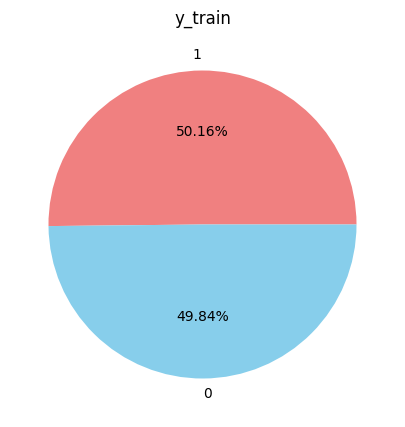

(10044, 2048) (10044,)
0    5022
1    5022
Name: count, dtype: int64


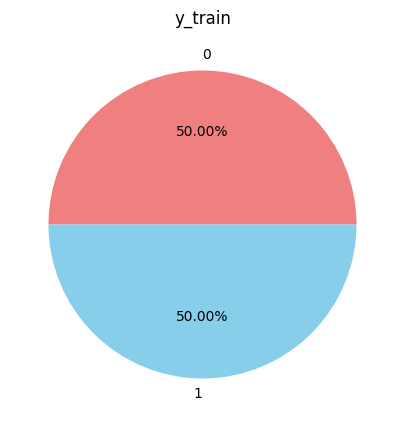

(5022, 2)
(5022, 2)


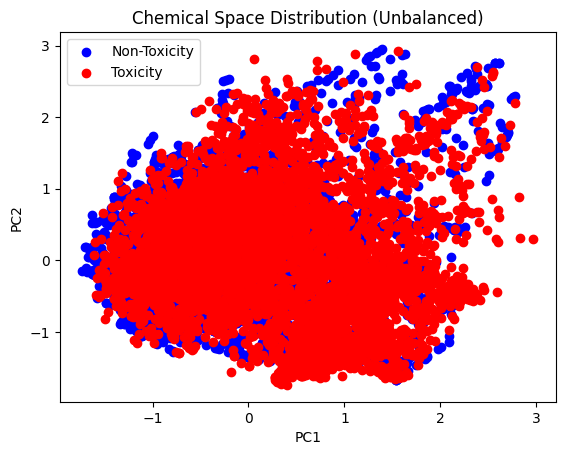

In [134]:
from sklearn.model_selection import KFold, train_test_split
from imblearn.over_sampling import ADASYN
import numpy as np
import torch

X_train,y_train = ADASYN(sampling_strategy='all').fit_resample(X_train_,y_train_)
print(np.array(X_train).shape,np.array(y_train).shape)
print(pd.Series(y_train).value_counts())
plt.figure( figsize=(10,5) )
pd.Series(y_train).value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'y_train' )  # 圖標題
plt.ylabel( '' )
plt.show()
X_train1, y_train1 = InstanceHardnessThreshold(estimator=GradientBoostingClassifier(),random_state=42).fit_resample(X_train, y_train)
print(np.array(X_train1).shape,np.array(y_train1).shape)
print(pd.Series(y_train1).value_counts())
plt.figure( figsize=(10,5) )
pd.Series(y_train1).value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'y_train' )  # 圖標題
plt.ylabel( '' )
plt.show()
#test toxicity
pca1 = PCA(n_components=2)
X_t = pca1.fit_transform(X_train1)

positive_indices = np.where(y_train1 == 1)[0]
negative_indices = np.where(y_train1 == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]

PCA_func(positive_samples,negative_samples)


(400, 2)
(400, 2)


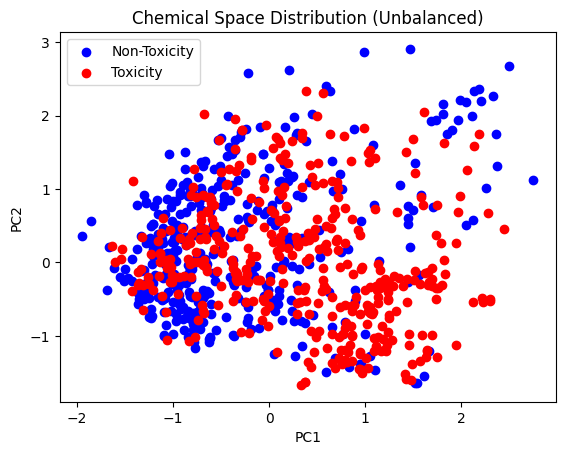

In [135]:
X_t = pca1.transform(X_test)
positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]
PCA_func(positive_samples,negative_samples)

In [119]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 假設 X 是特徵，y 是目標變數
# X, y = load_your_data_here()

# 計算互信息
mi = mutual_info_classif(X_train1, y_train1)

# 決定我們要試驗的特徵數量
k_values = range(1, len(mi)+1)

best_score = 0
best_k = 0
best_X = None

# 在迴圈開始前初始化兩個空列表
k_list = []
scores_list = []

for k in k_values:
    # 選擇前k個最重要的特徵
    selection = SelectKBest(score_func=mutual_info_classif, k=k)
    select_X = selection.fit_transform(X_train1, y_train1)
    
    # 使用隨機森林進行交叉驗證
    clf = RandomForestClassifier(random_state=0)
    scores = cross_val_score(clf, select_X, y_train1, cv=5, scoring='f1')
    mean_score = scores.mean()
    
    print(f"K={k}, n={select_X.shape[1]}, Accuracy: {mean_score:.2f} (+/- {scores.std():.2f})")

    # 如果這個k值的得分比我們之前找到的得分還高，則更新最佳k值和數據集
    if mean_score > best_score:
        best_score = mean_score
        best_k = k
        best_X = select_X

    # 將每個k值和對應的評分添加到列表中
    k_list.append(k)
    scores_list.append(mean_score)

print(f"Best k={best_k}, Accuracy: {best_score:.2f}")

K=1, n=1, Accuracy: 0.72 (+/- 0.03)
K=2, n=2, Accuracy: 0.74 (+/- 0.08)
K=3, n=3, Accuracy: 0.74 (+/- 0.11)
K=4, n=4, Accuracy: 0.80 (+/- 0.10)
K=5, n=5, Accuracy: 0.82 (+/- 0.10)
K=6, n=6, Accuracy: 0.84 (+/- 0.10)
K=7, n=7, Accuracy: 0.86 (+/- 0.09)
K=8, n=8, Accuracy: 0.86 (+/- 0.10)
K=9, n=9, Accuracy: 0.88 (+/- 0.09)
K=10, n=10, Accuracy: 0.88 (+/- 0.09)
K=11, n=11, Accuracy: 0.88 (+/- 0.08)
K=12, n=12, Accuracy: 0.89 (+/- 0.07)
K=13, n=13, Accuracy: 0.89 (+/- 0.09)
K=14, n=14, Accuracy: 0.90 (+/- 0.09)
K=15, n=15, Accuracy: 0.89 (+/- 0.09)
K=16, n=16, Accuracy: 0.91 (+/- 0.09)
K=17, n=17, Accuracy: 0.91 (+/- 0.09)
K=18, n=18, Accuracy: 0.91 (+/- 0.09)
K=19, n=19, Accuracy: 0.92 (+/- 0.09)
K=20, n=20, Accuracy: 0.92 (+/- 0.09)
K=21, n=21, Accuracy: 0.92 (+/- 0.09)
K=22, n=22, Accuracy: 0.92 (+/- 0.10)
K=23, n=23, Accuracy: 0.92 (+/- 0.09)
K=24, n=24, Accuracy: 0.92 (+/- 0.10)
K=25, n=25, Accuracy: 0.92 (+/- 0.09)
K=26, n=26, Accuracy: 0.92 (+/- 0.10)
K=27, n=27, Accuracy: 0.92 (+/

K=212, n=212, Accuracy: 0.95 (+/- 0.08)
K=213, n=213, Accuracy: 0.95 (+/- 0.08)
K=214, n=214, Accuracy: 0.95 (+/- 0.07)
K=215, n=215, Accuracy: 0.95 (+/- 0.08)
K=216, n=216, Accuracy: 0.95 (+/- 0.08)
K=217, n=217, Accuracy: 0.95 (+/- 0.08)
K=218, n=218, Accuracy: 0.95 (+/- 0.08)
K=219, n=219, Accuracy: 0.95 (+/- 0.07)
K=220, n=220, Accuracy: 0.95 (+/- 0.07)
K=221, n=221, Accuracy: 0.95 (+/- 0.08)
K=222, n=222, Accuracy: 0.95 (+/- 0.08)
K=223, n=223, Accuracy: 0.95 (+/- 0.07)
K=224, n=224, Accuracy: 0.95 (+/- 0.08)
K=225, n=225, Accuracy: 0.95 (+/- 0.07)
K=226, n=226, Accuracy: 0.95 (+/- 0.08)
K=227, n=227, Accuracy: 0.95 (+/- 0.08)
K=228, n=228, Accuracy: 0.95 (+/- 0.08)
K=229, n=229, Accuracy: 0.95 (+/- 0.08)
K=230, n=230, Accuracy: 0.95 (+/- 0.08)
K=231, n=231, Accuracy: 0.95 (+/- 0.08)
K=232, n=232, Accuracy: 0.95 (+/- 0.08)
K=233, n=233, Accuracy: 0.95 (+/- 0.07)
K=234, n=234, Accuracy: 0.95 (+/- 0.08)
K=235, n=235, Accuracy: 0.95 (+/- 0.07)
K=236, n=236, Accuracy: 0.95 (+/- 0.07)


K=417, n=417, Accuracy: 0.95 (+/- 0.07)
K=418, n=418, Accuracy: 0.95 (+/- 0.07)
K=419, n=419, Accuracy: 0.95 (+/- 0.07)
K=420, n=420, Accuracy: 0.95 (+/- 0.07)
K=421, n=421, Accuracy: 0.95 (+/- 0.07)
K=422, n=422, Accuracy: 0.95 (+/- 0.07)
K=423, n=423, Accuracy: 0.95 (+/- 0.07)
K=424, n=424, Accuracy: 0.95 (+/- 0.08)
K=425, n=425, Accuracy: 0.95 (+/- 0.07)
K=426, n=426, Accuracy: 0.95 (+/- 0.07)
K=427, n=427, Accuracy: 0.95 (+/- 0.07)
K=428, n=428, Accuracy: 0.95 (+/- 0.07)
K=429, n=429, Accuracy: 0.95 (+/- 0.07)
K=430, n=430, Accuracy: 0.95 (+/- 0.07)
K=431, n=431, Accuracy: 0.95 (+/- 0.07)
K=432, n=432, Accuracy: 0.95 (+/- 0.07)
K=433, n=433, Accuracy: 0.95 (+/- 0.07)
K=434, n=434, Accuracy: 0.95 (+/- 0.07)
K=435, n=435, Accuracy: 0.95 (+/- 0.07)
K=436, n=436, Accuracy: 0.95 (+/- 0.07)
K=437, n=437, Accuracy: 0.95 (+/- 0.07)
K=438, n=438, Accuracy: 0.95 (+/- 0.07)
K=439, n=439, Accuracy: 0.95 (+/- 0.07)
K=440, n=440, Accuracy: 0.95 (+/- 0.07)
K=441, n=441, Accuracy: 0.95 (+/- 0.07)


K=622, n=622, Accuracy: 0.95 (+/- 0.07)
K=623, n=623, Accuracy: 0.95 (+/- 0.07)
K=624, n=624, Accuracy: 0.96 (+/- 0.07)
K=625, n=625, Accuracy: 0.95 (+/- 0.07)
K=626, n=626, Accuracy: 0.95 (+/- 0.07)
K=627, n=627, Accuracy: 0.95 (+/- 0.07)
K=628, n=628, Accuracy: 0.95 (+/- 0.07)
K=629, n=629, Accuracy: 0.95 (+/- 0.07)
K=630, n=630, Accuracy: 0.95 (+/- 0.07)
K=631, n=631, Accuracy: 0.95 (+/- 0.07)
K=632, n=632, Accuracy: 0.95 (+/- 0.07)
K=633, n=633, Accuracy: 0.95 (+/- 0.07)
K=634, n=634, Accuracy: 0.95 (+/- 0.07)
K=635, n=635, Accuracy: 0.95 (+/- 0.07)
K=636, n=636, Accuracy: 0.95 (+/- 0.07)
K=637, n=637, Accuracy: 0.95 (+/- 0.07)
K=638, n=638, Accuracy: 0.95 (+/- 0.07)
K=639, n=639, Accuracy: 0.95 (+/- 0.07)
K=640, n=640, Accuracy: 0.95 (+/- 0.07)
K=641, n=641, Accuracy: 0.95 (+/- 0.07)
K=642, n=642, Accuracy: 0.95 (+/- 0.07)
K=643, n=643, Accuracy: 0.96 (+/- 0.07)
K=644, n=644, Accuracy: 0.95 (+/- 0.07)
K=645, n=645, Accuracy: 0.95 (+/- 0.07)
K=646, n=646, Accuracy: 0.95 (+/- 0.07)


K=827, n=827, Accuracy: 0.96 (+/- 0.07)
K=828, n=828, Accuracy: 0.95 (+/- 0.07)
K=829, n=829, Accuracy: 0.96 (+/- 0.07)
K=830, n=830, Accuracy: 0.95 (+/- 0.07)
K=831, n=831, Accuracy: 0.95 (+/- 0.07)
K=832, n=832, Accuracy: 0.95 (+/- 0.07)
K=833, n=833, Accuracy: 0.95 (+/- 0.07)
K=834, n=834, Accuracy: 0.95 (+/- 0.07)
K=835, n=835, Accuracy: 0.96 (+/- 0.07)
K=836, n=836, Accuracy: 0.96 (+/- 0.07)
K=837, n=837, Accuracy: 0.95 (+/- 0.07)
K=838, n=838, Accuracy: 0.95 (+/- 0.07)
K=839, n=839, Accuracy: 0.96 (+/- 0.07)
K=840, n=840, Accuracy: 0.95 (+/- 0.07)
K=841, n=841, Accuracy: 0.96 (+/- 0.07)
K=842, n=842, Accuracy: 0.96 (+/- 0.07)
K=843, n=843, Accuracy: 0.96 (+/- 0.06)
K=844, n=844, Accuracy: 0.96 (+/- 0.06)
K=845, n=845, Accuracy: 0.96 (+/- 0.07)
K=846, n=846, Accuracy: 0.96 (+/- 0.07)
K=847, n=847, Accuracy: 0.95 (+/- 0.07)
K=848, n=848, Accuracy: 0.95 (+/- 0.07)
K=849, n=849, Accuracy: 0.96 (+/- 0.07)
K=850, n=850, Accuracy: 0.95 (+/- 0.07)
K=851, n=851, Accuracy: 0.95 (+/- 0.07)


K=1031, n=1031, Accuracy: 0.96 (+/- 0.06)
K=1032, n=1032, Accuracy: 0.96 (+/- 0.07)
K=1033, n=1033, Accuracy: 0.96 (+/- 0.06)
K=1034, n=1034, Accuracy: 0.95 (+/- 0.07)
K=1035, n=1035, Accuracy: 0.95 (+/- 0.07)
K=1036, n=1036, Accuracy: 0.96 (+/- 0.06)
K=1037, n=1037, Accuracy: 0.96 (+/- 0.07)
K=1038, n=1038, Accuracy: 0.96 (+/- 0.07)
K=1039, n=1039, Accuracy: 0.96 (+/- 0.07)
K=1040, n=1040, Accuracy: 0.96 (+/- 0.07)
K=1041, n=1041, Accuracy: 0.96 (+/- 0.07)
K=1042, n=1042, Accuracy: 0.96 (+/- 0.06)
K=1043, n=1043, Accuracy: 0.96 (+/- 0.07)
K=1044, n=1044, Accuracy: 0.96 (+/- 0.06)
K=1045, n=1045, Accuracy: 0.96 (+/- 0.06)
K=1046, n=1046, Accuracy: 0.96 (+/- 0.07)
K=1047, n=1047, Accuracy: 0.96 (+/- 0.06)
K=1048, n=1048, Accuracy: 0.96 (+/- 0.07)
K=1049, n=1049, Accuracy: 0.95 (+/- 0.07)
K=1050, n=1050, Accuracy: 0.96 (+/- 0.07)
K=1051, n=1051, Accuracy: 0.96 (+/- 0.07)
K=1052, n=1052, Accuracy: 0.96 (+/- 0.07)
K=1053, n=1053, Accuracy: 0.96 (+/- 0.07)
K=1054, n=1054, Accuracy: 0.96 (+/

K=1227, n=1227, Accuracy: 0.96 (+/- 0.07)
K=1228, n=1228, Accuracy: 0.96 (+/- 0.06)
K=1229, n=1229, Accuracy: 0.96 (+/- 0.07)
K=1230, n=1230, Accuracy: 0.96 (+/- 0.06)
K=1231, n=1231, Accuracy: 0.96 (+/- 0.06)
K=1232, n=1232, Accuracy: 0.96 (+/- 0.07)
K=1233, n=1233, Accuracy: 0.96 (+/- 0.06)
K=1234, n=1234, Accuracy: 0.96 (+/- 0.07)
K=1235, n=1235, Accuracy: 0.96 (+/- 0.06)
K=1236, n=1236, Accuracy: 0.96 (+/- 0.06)
K=1237, n=1237, Accuracy: 0.96 (+/- 0.06)
K=1238, n=1238, Accuracy: 0.96 (+/- 0.06)
K=1239, n=1239, Accuracy: 0.96 (+/- 0.07)
K=1240, n=1240, Accuracy: 0.96 (+/- 0.06)
K=1241, n=1241, Accuracy: 0.96 (+/- 0.06)
K=1242, n=1242, Accuracy: 0.96 (+/- 0.06)
K=1243, n=1243, Accuracy: 0.96 (+/- 0.07)
K=1244, n=1244, Accuracy: 0.96 (+/- 0.07)
K=1245, n=1245, Accuracy: 0.96 (+/- 0.07)
K=1246, n=1246, Accuracy: 0.96 (+/- 0.06)
K=1247, n=1247, Accuracy: 0.96 (+/- 0.06)
K=1248, n=1248, Accuracy: 0.96 (+/- 0.06)
K=1249, n=1249, Accuracy: 0.96 (+/- 0.07)
K=1250, n=1250, Accuracy: 0.96 (+/

K=1423, n=1423, Accuracy: 0.96 (+/- 0.06)
K=1424, n=1424, Accuracy: 0.96 (+/- 0.07)
K=1425, n=1425, Accuracy: 0.96 (+/- 0.06)
K=1426, n=1426, Accuracy: 0.96 (+/- 0.06)
K=1427, n=1427, Accuracy: 0.96 (+/- 0.06)
K=1428, n=1428, Accuracy: 0.96 (+/- 0.06)
K=1429, n=1429, Accuracy: 0.96 (+/- 0.06)
K=1430, n=1430, Accuracy: 0.96 (+/- 0.06)
K=1431, n=1431, Accuracy: 0.96 (+/- 0.06)
K=1432, n=1432, Accuracy: 0.96 (+/- 0.06)
K=1433, n=1433, Accuracy: 0.96 (+/- 0.06)
K=1434, n=1434, Accuracy: 0.96 (+/- 0.06)
K=1435, n=1435, Accuracy: 0.96 (+/- 0.07)
K=1436, n=1436, Accuracy: 0.96 (+/- 0.06)
K=1437, n=1437, Accuracy: 0.96 (+/- 0.06)
K=1438, n=1438, Accuracy: 0.96 (+/- 0.06)
K=1439, n=1439, Accuracy: 0.96 (+/- 0.06)
K=1440, n=1440, Accuracy: 0.96 (+/- 0.07)
K=1441, n=1441, Accuracy: 0.96 (+/- 0.06)
K=1442, n=1442, Accuracy: 0.96 (+/- 0.06)
K=1443, n=1443, Accuracy: 0.96 (+/- 0.07)
K=1444, n=1444, Accuracy: 0.96 (+/- 0.06)
K=1445, n=1445, Accuracy: 0.96 (+/- 0.06)
K=1446, n=1446, Accuracy: 0.96 (+/

K=1619, n=1619, Accuracy: 0.96 (+/- 0.06)
K=1620, n=1620, Accuracy: 0.96 (+/- 0.06)
K=1621, n=1621, Accuracy: 0.96 (+/- 0.06)
K=1622, n=1622, Accuracy: 0.96 (+/- 0.07)
K=1623, n=1623, Accuracy: 0.96 (+/- 0.06)
K=1624, n=1624, Accuracy: 0.96 (+/- 0.06)
K=1625, n=1625, Accuracy: 0.96 (+/- 0.07)
K=1626, n=1626, Accuracy: 0.96 (+/- 0.06)
K=1627, n=1627, Accuracy: 0.96 (+/- 0.06)
K=1628, n=1628, Accuracy: 0.96 (+/- 0.06)
K=1629, n=1629, Accuracy: 0.96 (+/- 0.06)
K=1630, n=1630, Accuracy: 0.96 (+/- 0.06)
K=1631, n=1631, Accuracy: 0.96 (+/- 0.07)
K=1632, n=1632, Accuracy: 0.96 (+/- 0.06)
K=1633, n=1633, Accuracy: 0.96 (+/- 0.06)
K=1634, n=1634, Accuracy: 0.96 (+/- 0.07)
K=1635, n=1635, Accuracy: 0.96 (+/- 0.06)
K=1636, n=1636, Accuracy: 0.96 (+/- 0.06)
K=1637, n=1637, Accuracy: 0.96 (+/- 0.06)
K=1638, n=1638, Accuracy: 0.96 (+/- 0.06)
K=1639, n=1639, Accuracy: 0.96 (+/- 0.06)
K=1640, n=1640, Accuracy: 0.96 (+/- 0.06)
K=1641, n=1641, Accuracy: 0.96 (+/- 0.06)
K=1642, n=1642, Accuracy: 0.96 (+/

K=1815, n=1815, Accuracy: 0.96 (+/- 0.06)
K=1816, n=1816, Accuracy: 0.96 (+/- 0.06)
K=1817, n=1817, Accuracy: 0.96 (+/- 0.06)
K=1818, n=1818, Accuracy: 0.96 (+/- 0.06)
K=1819, n=1819, Accuracy: 0.96 (+/- 0.06)
K=1820, n=1820, Accuracy: 0.96 (+/- 0.06)
K=1821, n=1821, Accuracy: 0.96 (+/- 0.06)
K=1822, n=1822, Accuracy: 0.96 (+/- 0.06)
K=1823, n=1823, Accuracy: 0.96 (+/- 0.06)
K=1824, n=1824, Accuracy: 0.96 (+/- 0.07)
K=1825, n=1825, Accuracy: 0.96 (+/- 0.06)
K=1826, n=1826, Accuracy: 0.96 (+/- 0.06)
K=1827, n=1827, Accuracy: 0.96 (+/- 0.06)
K=1828, n=1828, Accuracy: 0.96 (+/- 0.06)
K=1829, n=1829, Accuracy: 0.96 (+/- 0.06)
K=1830, n=1830, Accuracy: 0.96 (+/- 0.06)
K=1831, n=1831, Accuracy: 0.96 (+/- 0.06)
K=1832, n=1832, Accuracy: 0.96 (+/- 0.06)
K=1833, n=1833, Accuracy: 0.96 (+/- 0.06)
K=1834, n=1834, Accuracy: 0.96 (+/- 0.06)
K=1835, n=1835, Accuracy: 0.96 (+/- 0.06)
K=1836, n=1836, Accuracy: 0.96 (+/- 0.06)
K=1837, n=1837, Accuracy: 0.96 (+/- 0.06)
K=1838, n=1838, Accuracy: 0.96 (+/

K=2011, n=2011, Accuracy: 0.96 (+/- 0.06)
K=2012, n=2012, Accuracy: 0.96 (+/- 0.06)
K=2013, n=2013, Accuracy: 0.96 (+/- 0.06)
K=2014, n=2014, Accuracy: 0.96 (+/- 0.06)
K=2015, n=2015, Accuracy: 0.96 (+/- 0.06)
K=2016, n=2016, Accuracy: 0.96 (+/- 0.06)
K=2017, n=2017, Accuracy: 0.96 (+/- 0.06)
K=2018, n=2018, Accuracy: 0.96 (+/- 0.06)
K=2019, n=2019, Accuracy: 0.96 (+/- 0.06)
K=2020, n=2020, Accuracy: 0.96 (+/- 0.06)
K=2021, n=2021, Accuracy: 0.96 (+/- 0.06)
K=2022, n=2022, Accuracy: 0.96 (+/- 0.06)
K=2023, n=2023, Accuracy: 0.96 (+/- 0.06)
K=2024, n=2024, Accuracy: 0.96 (+/- 0.06)
K=2025, n=2025, Accuracy: 0.96 (+/- 0.06)
K=2026, n=2026, Accuracy: 0.96 (+/- 0.06)
K=2027, n=2027, Accuracy: 0.96 (+/- 0.06)
K=2028, n=2028, Accuracy: 0.96 (+/- 0.06)
K=2029, n=2029, Accuracy: 0.96 (+/- 0.06)
K=2030, n=2030, Accuracy: 0.96 (+/- 0.06)
K=2031, n=2031, Accuracy: 0.96 (+/- 0.06)
K=2032, n=2032, Accuracy: 0.96 (+/- 0.06)
K=2033, n=2033, Accuracy: 0.96 (+/- 0.06)
K=2034, n=2034, Accuracy: 0.96 (+/

(5022, 2)
(5022, 2)


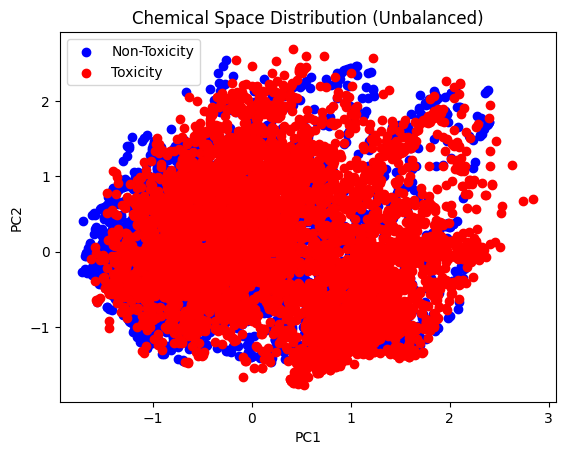

(400, 2)
(400, 2)


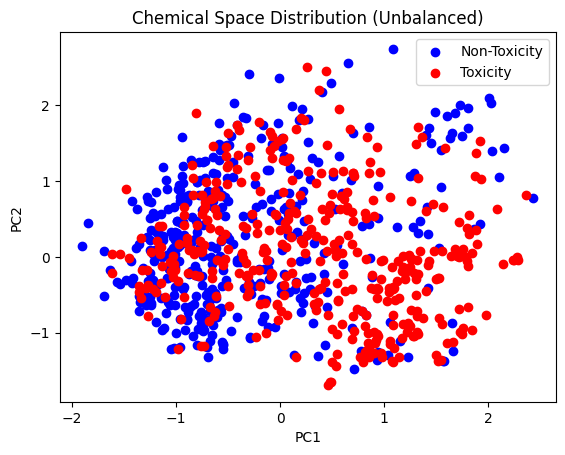

In [136]:
pca1 = PCA(n_components=2)
selection = SelectKBest(score_func=mutual_info_classif, k=523)
X_bt = selection.fit_transform(X_train1,y_train1)
X_t = pca1.fit_transform(X_bt)

positive_indices = np.where(y_train1 == 1)[0]
negative_indices = np.where(y_train1 == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]

PCA_func(positive_samples,negative_samples)

X_tt = selection.transform(X_test)
X_t = pca1.transform(X_tt)

positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]

PCA_func(positive_samples,negative_samples)

In [137]:
X_test.shape

(800, 2048)

In [138]:
selection = SelectKBest(score_func=mutual_info_classif, k=523)
X_train_k = selection.fit_transform(X_train1,y_train1)
X_test_k = selection.transform(X_test)
print(np.array(X_train_k).shape,np.array(X_test_k).shape)

(10044, 523) (800, 523)


Number of components to preserve 95.0% variance: 297
Epoch [1/1000], Training Loss: 1.3693, Training F1 score: 0.3406, Training MCC score: 0.0312, Training Combine score: 0.1859
[[3882 1126]
 [3749 1259]]
Epoch [1/1000], Validation Loss: 1.3737, Validation F1 score: 0.2167, Validation MCC score: -0.0023, Validation Combine score: 0.1072
[[170  28]
 [160  26]]
Epoch [2/1000], Training Loss: 1.3528, Training F1 score: 0.4439, Training MCC score: 0.0347, Training Combine score: 0.2393
[[3243 1763]
 [3078 1932]]
Epoch [2/1000], Validation Loss: 1.3364, Validation F1 score: 0.4070, Validation MCC score: 0.1137, Validation Combine score: 0.2604
[[157  43]
 [126  58]]
Epoch [3/1000], Training Loss: 1.3399, Training F1 score: 0.5050, Training MCC score: 0.0694, Training Combine score: 0.2872
[[2974 2034]
 [2629 2379]]
Epoch [3/1000], Validation Loss: 1.3361, Validation F1 score: 0.5271, Validation MCC score: 0.0484, Validation Combine score: 0.2878
[[ 99  99]
 [ 84 102]]
Epoch [4/1000], Traini

Epoch [28/1000], Training Loss: 0.8384, Training F1 score: 0.8480, Training MCC score: 0.6807, Training Combine score: 0.7644
[[3459 1552]
 [ 178 4827]]
Epoch [28/1000], Validation Loss: 1.0029, Validation F1 score: 0.6942, Validation MCC score: 0.4206, Validation Combine score: 0.5574
[[147  52]
 [ 59 126]]
Epoch [29/1000], Training Loss: 0.8399, Training F1 score: 0.8446, Training MCC score: 0.6717, Training Combine score: 0.7582
[[3529 1481]
 [ 264 4742]]
Epoch [29/1000], Validation Loss: 1.0179, Validation F1 score: 0.6743, Validation MCC score: 0.4062, Validation Combine score: 0.5403
[[152  46]
 [ 68 118]]
Epoch [30/1000], Training Loss: 0.8315, Training F1 score: 0.8492, Training MCC score: 0.6818, Training Combine score: 0.7655
[[3606 1400]
 [ 280 4730]]
Epoch [30/1000], Validation Loss: 1.0026, Validation F1 score: 0.6995, Validation MCC score: 0.4262, Validation Combine score: 0.5628
[[146  52]
 [ 58 128]]
Epoch [31/1000], Training Loss: 0.8249, Training F1 score: 0.8492, Tra

Epoch [55/1000], Training Loss: 0.7286, Training F1 score: 0.8556, Training MCC score: 0.6969, Training Combine score: 0.7763
[[3594 1415]
 [ 206 4801]]
Epoch [55/1000], Validation Loss: 0.9166, Validation F1 score: 0.6947, Validation MCC score: 0.4311, Validation Combine score: 0.5629
[[151  48]
 [ 61 124]]
Epoch [56/1000], Training Loss: 0.7163, Training F1 score: 0.8626, Training MCC score: 0.7129, Training Combine score: 0.7877
[[3634 1372]
 [ 170 4840]]
Epoch [56/1000], Validation Loss: 0.9183, Validation F1 score: 0.7017, Validation MCC score: 0.4366, Validation Combine score: 0.5691
[[149  49]
 [ 59 127]]
Epoch [57/1000], Training Loss: 0.7102, Training F1 score: 0.8647, Training MCC score: 0.7179, Training Combine score: 0.7913
[[3648 1360]
 [ 158 4850]]
Epoch [57/1000], Validation Loss: 0.8791, Validation F1 score: 0.7302, Validation MCC score: 0.4693, Validation Combine score: 0.5997
[[144  55]
 [ 47 138]]
Epoch [58/1000], Training Loss: 0.7233, Training F1 score: 0.8517, Tra

Epoch [82/1000], Training Loss: 0.6579, Training F1 score: 0.8673, Training MCC score: 0.7231, Training Combine score: 0.7952
[[3671 1330]
 [ 157 4858]]
Epoch [82/1000], Validation Loss: 0.8713, Validation F1 score: 0.6916, Validation MCC score: 0.4427, Validation Combine score: 0.5672
[[157  42]
 [ 65 120]]
Epoch [83/1000], Training Loss: 0.6548, Training F1 score: 0.8714, Training MCC score: 0.7331, Training Combine score: 0.8022
[[3699 1310]
 [ 130 4877]]
Epoch [83/1000], Validation Loss: 0.8943, Validation F1 score: 0.6426, Validation MCC score: 0.3887, Validation Combine score: 0.5157
[[158  37]
 [ 82 107]]
Epoch [84/1000], Training Loss: 0.6516, Training F1 score: 0.8692, Training MCC score: 0.7282, Training Combine score: 0.7987
[[3681 1329]
 [ 137 4869]]
Epoch [84/1000], Validation Loss: 0.8480, Validation F1 score: 0.7116, Validation MCC score: 0.4421, Validation Combine score: 0.5768
[[145  53]
 [ 54 132]]
Epoch [85/1000], Training Loss: 0.6451, Training F1 score: 0.8756, Tra

Epoch [109/1000], Training Loss: 0.6021, Training F1 score: 0.8808, Training MCC score: 0.7543, Training Combine score: 0.8176
[[3781 1229]
 [  99 4907]]
Epoch [109/1000], Validation Loss: 0.8477, Validation F1 score: 0.6628, Validation MCC score: 0.4005, Validation Combine score: 0.5316
[[156  44]
 [ 71 113]]
Epoch [110/1000], Training Loss: 0.6026, Training F1 score: 0.8809, Training MCC score: 0.7539, Training Combine score: 0.8174
[[3792 1214]
 [ 111 4899]]
Epoch [110/1000], Validation Loss: 0.8441, Validation F1 score: 0.6839, Validation MCC score: 0.4277, Validation Combine score: 0.5558
[[155  43]
 [ 67 119]]
Epoch [111/1000], Training Loss: 0.5992, Training F1 score: 0.8822, Training MCC score: 0.7569, Training Combine score: 0.8196
[[3797 1209]
 [ 102 4908]]
Epoch [111/1000], Validation Loss: 0.8466, Validation F1 score: 0.6629, Validation MCC score: 0.3796, Validation Combine score: 0.5212
[[148  50]
 [ 69 117]]
Epoch [112/1000], Training Loss: 0.5993, Training F1 score: 0.88

Epoch [136/1000], Training Loss: 0.5604, Training F1 score: 0.8915, Training MCC score: 0.7767, Training Combine score: 0.8341
[[3914 1092]
 [ 103 4907]]
Epoch [136/1000], Validation Loss: 0.8286, Validation F1 score: 0.6705, Validation MCC score: 0.4003, Validation Combine score: 0.5354
[[152  47]
 [ 68 117]]
Epoch [137/1000], Training Loss: 0.5709, Training F1 score: 0.8860, Training MCC score: 0.7653, Training Combine score: 0.8256
[[3846 1163]
 [ 100 4907]]
Epoch [137/1000], Validation Loss: 0.8163, Validation F1 score: 0.6762, Validation MCC score: 0.4117, Validation Combine score: 0.5439
[[153  45]
 [ 68 118]]
Epoch [138/1000], Training Loss: 0.5640, Training F1 score: 0.8896, Training MCC score: 0.7729, Training Combine score: 0.8312
[[3872 1132]
 [  90 4922]]
Epoch [138/1000], Validation Loss: 0.8183, Validation F1 score: 0.6667, Validation MCC score: 0.3991, Validation Combine score: 0.5329
[[152  43]
 [ 73 116]]
Epoch [139/1000], Training Loss: 0.5672, Training F1 score: 0.88

Epoch [163/1000], Training Loss: 0.5562, Training F1 score: 0.8900, Training MCC score: 0.7739, Training Combine score: 0.8320
[[3875 1130]
 [  87 4924]]
Epoch [163/1000], Validation Loss: 0.8111, Validation F1 score: 0.6628, Validation MCC score: 0.3909, Validation Combine score: 0.5269
[[152  46]
 [ 71 115]]
Epoch [164/1000], Training Loss: 0.5554, Training F1 score: 0.8895, Training MCC score: 0.7727, Training Combine score: 0.8311
[[3882 1126]
 [  95 4913]]
Epoch [164/1000], Validation Loss: 0.8229, Validation F1 score: 0.6588, Validation MCC score: 0.4025, Validation Combine score: 0.5306
[[158  41]
 [ 74 111]]
Epoch [165/1000], Training Loss: 0.5575, Training F1 score: 0.8915, Training MCC score: 0.7765, Training Combine score: 0.8340
[[3948 1063]
 [ 125 4880]]
Epoch [165/1000], Validation Loss: 0.8320, Validation F1 score: 0.6386, Validation MCC score: 0.3744, Validation Combine score: 0.5065
[[158  43]
 [ 77 106]]
Epoch [166/1000], Training Loss: 0.5587, Training F1 score: 0.89

Epoch [190/1000], Training Loss: 0.5446, Training F1 score: 0.8995, Training MCC score: 0.7940, Training Combine score: 0.8467
[[4004 1004]
 [  94 4914]]
Epoch [190/1000], Validation Loss: 0.7963, Validation F1 score: 0.6802, Validation MCC score: 0.4285, Validation Combine score: 0.5544
[[157  41]
 [ 69 117]]
Early stopping triggered at epoch 190.
Test Loss: 0.7309, F1 Score: 0.75, MCC: 0.52, Combine: 0.64
[[151  36]
 [ 56 141]]


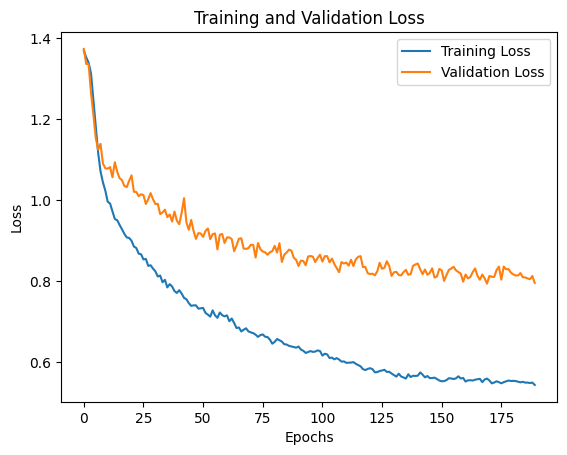

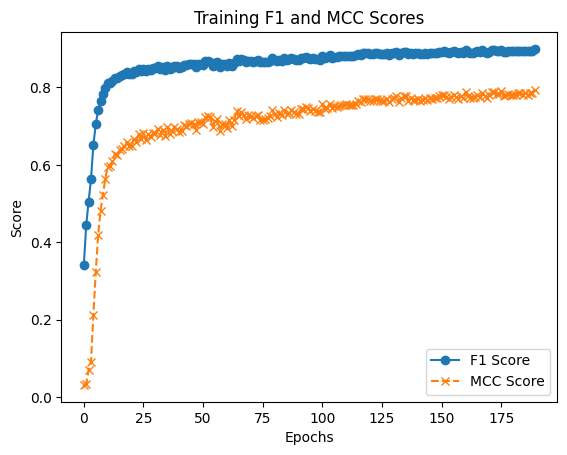

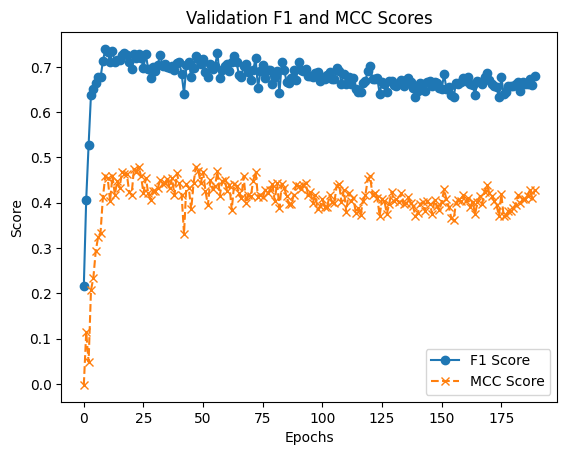

Number of components to preserve 95.0% variance: 297
Epoch [1/1000], Training Loss: 1.3608, Training F1 score: 0.4629, Training MCC score: 0.0468, Training Combine score: 0.2548
[[3178 1833]
 [2946 2059]]
Epoch [1/1000], Validation Loss: 1.3450, Validation F1 score: 0.6359, Validation MCC score: 0.1747, Validation Combine score: 0.4053
[[ 88  98]
 [ 60 138]]
Epoch [2/1000], Training Loss: 1.2941, Training F1 score: 0.5952, Training MCC score: 0.1526, Training Combine score: 0.3739
[[2647 2361]
 [1886 3122]]
Epoch [2/1000], Validation Loss: 1.1810, Validation F1 score: 0.7241, Validation MCC score: 0.3587, Validation Combine score: 0.5414
[[ 95  91]
 [ 34 164]]
Epoch [3/1000], Training Loss: 1.1411, Training F1 score: 0.7215, Training MCC score: 0.3877, Training Combine score: 0.5546
[[2845 2165]
 [ 959 4047]]
Epoch [3/1000], Validation Loss: 1.0862, Validation F1 score: 0.7689, Validation MCC score: 0.4959, Validation Combine score: 0.6324
[[123  66]
 [ 32 163]]
Epoch [4/1000], Trainin

Epoch [28/1000], Training Loss: 0.7313, Training F1 score: 0.8451, Training MCC score: 0.6767, Training Combine score: 0.7609
[[3895 1113]
 [ 529 4479]]
Epoch [28/1000], Validation Loss: 0.8081, Validation F1 score: 0.7927, Validation MCC score: 0.5361, Validation Combine score: 0.6644
[[119  67]
 [ 24 174]]
Epoch [29/1000], Training Loss: 0.7331, Training F1 score: 0.8396, Training MCC score: 0.6656, Training Combine score: 0.7526
[[3888 1118]
 [ 576 4434]]
Epoch [29/1000], Validation Loss: 0.8688, Validation F1 score: 0.7403, Validation MCC score: 0.5208, Validation Combine score: 0.6306
[[156  30]
 [ 64 134]]
Epoch [30/1000], Training Loss: 0.7278, Training F1 score: 0.8419, Training MCC score: 0.6718, Training Combine score: 0.7568
[[3940 1068]
 [ 591 4417]]
Epoch [30/1000], Validation Loss: 0.8617, Validation F1 score: 0.7539, Validation MCC score: 0.3957, Validation Combine score: 0.5748
[[ 65 117]
 [  9 193]]
Epoch [31/1000], Training Loss: 0.7123, Training F1 score: 0.8473, Tra

Epoch [55/1000], Training Loss: 0.6419, Training F1 score: 0.8625, Training MCC score: 0.7138, Training Combine score: 0.7882
[[3579 1429]
 [ 127 4881]]
Epoch [55/1000], Validation Loss: 0.7840, Validation F1 score: 0.7540, Validation MCC score: 0.4551, Validation Combine score: 0.6046
[[113  77]
 [ 30 164]]
Epoch [56/1000], Training Loss: 0.6433, Training F1 score: 0.8632, Training MCC score: 0.7153, Training Combine score: 0.7892
[[3574 1429]
 [ 121 4892]]
Epoch [56/1000], Validation Loss: 0.7488, Validation F1 score: 0.7789, Validation MCC score: 0.5640, Validation Combine score: 0.6715
[[152  36]
 [ 48 148]]
Epoch [57/1000], Training Loss: 0.6389, Training F1 score: 0.8651, Training MCC score: 0.7193, Training Combine score: 0.7922
[[3628 1382]
 [ 137 4869]]
Epoch [57/1000], Validation Loss: 0.7717, Validation F1 score: 0.7628, Validation MCC score: 0.4949, Validation Combine score: 0.6289
[[131  56]
 [ 41 156]]
Epoch [58/1000], Training Loss: 0.6373, Training F1 score: 0.8621, Tra

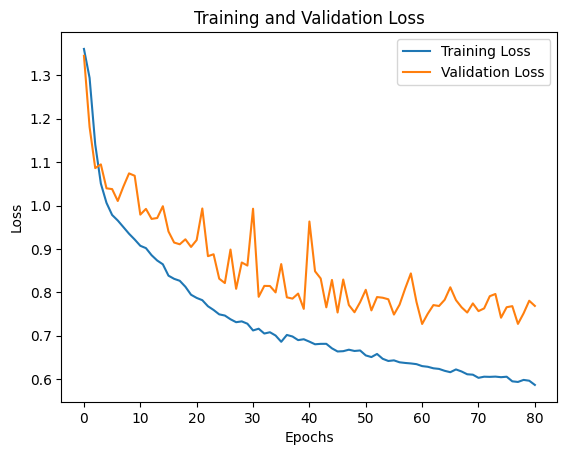

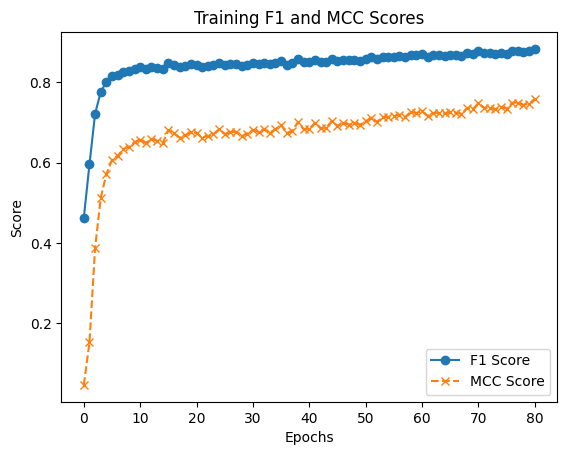

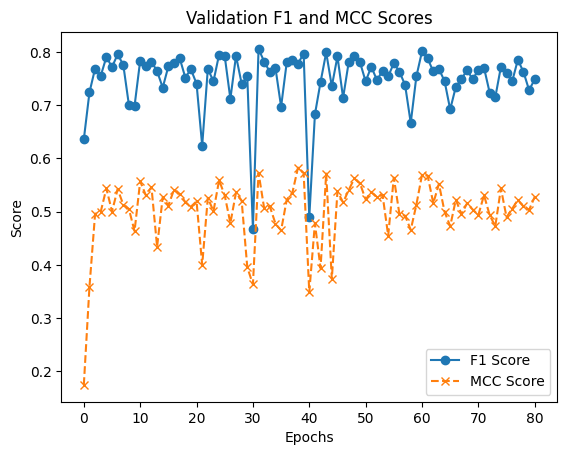

Model            Dataset Preprocessing  F1 (Toxic)  Precision (Toxic)   
0   RNN  MorganFingerPrint           PCA    0.673913           0.825095  \
1   RNN  MorganFingerPrint           PCA    0.729805           0.782090   

   Sensitivity  Specificity        BA   AUC-ROC    AUC-PR       MCC  
0     0.569554     0.881137  0.725345  0.725345  0.683478  0.474868  
1     0.684073     0.810390  0.747231  0.747231  0.692559  0.498536

In [139]:




# 初始化 k 折交叉驗證
k = 2
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

X = X_test_k
y = y_test

# 訓練和評估
result_f1 = []
result_mcc = []
total_y_true = []
total_y_pred = []

f1_four = []
mcc_four = []
total_y_true_four = []
total_y_pred_four = []
for fold, (val_indices, test_indices) in enumerate(kfold.split(X, y)):
    # 分割數據集
    X_val, X_test = X[val_indices], X[test_indices]
    y_val, y_test = y[val_indices], y[test_indices]
    
    # 將訓練集再分為訓練集和驗證集
    #X_train1, X_val, y_train1, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42, stratify=y_train1)
    X_train2 = csr_matrix(X_train_k).toarray()


    
#     negative_indices = np.where(labels == 0)[0]
#     negative_samples = np.array(np.array(feature))[negative_indices]
#     negative_labels  = np.array(np.array(labels))[negative_indices]
#     print(pd.Series(negative_labels).value_counts())


    # 假设 X 是您的数据矩阵，形状为 (样本数, 特征数)，例如 (500, 2048)

    # 初始化 PCA，所有主成分
    pca = PCA()

    # PCA
    pca.fit(X_train2)

    # 計算PCA各個主成份的方差解釋率
    explained_variance_ratio = pca.explained_variance_ratio_

    # 累積方差解釋率
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    # setting the threshold
    threshold = 0.95

    # 找到最小主成分数目
    n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

    print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")
    
    pca_reduced = PCA(n_components=n_components)
    # 進行 PCA 轉換
    X_train2 = pca_reduced.fit_transform(X_train2)
    X_val1 = pca_reduced.transform(X_val)
    X_test1 = pca_reduced.transform(X_test)
#     X_four = pca_reduced.transform(np.array(feature))

    # 轉換標籤為一維張量
    y_train1 = y_train1.flatten()
    y_val1 = y_val.flatten()
    y_test1 = y_test.flatten()
#     y_four = labels.flatten()

    # 創建數據加載器
    train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train2), torch.Tensor(y_train1))
    val_data = torch.utils.data.TensorDataset(torch.Tensor(X_val1), torch.Tensor(y_val))
    test_data = torch.utils.data.TensorDataset(torch.Tensor(X_test1), torch.Tensor(y_test))
#     four_data = torch.utils.data.TensorDataset(torch.Tensor(X_four), torch.Tensor(y_four))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size =32, shuffle=True, drop_last=True)
#     four_loader = torch.utils.data.DataLoader(four_data, batch_size =32, shuffle=True, drop_last=True)

    # 實例化模型、損失函數和優化器

    input_size = 2048
    embedding_dim = n_components
    hidden_size = 128
    output_size = 1 #二元分類問題
    num_layers = 2
    model = RNNModel(input_size,embedding_dim, hidden_size, output_size, num_layers).to(dtype=torch.float)

    learning_rate = 0.0005

    l2_lambda = 0.00005
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)

    patience = 20
    counter = 0
    best_val_loss = float('inf')


    n_epochs = 1000


    # Initialize lists to store training and validation loss and F1 score
    train_losses = []
    val_losses = []
    train_f1_scores = []
    train_mcc_scores = []
    val_f1_scores = []
    val_mcc_scores = []

    for epoch in range(n_epochs):
        train_loss,t_f1,t_mcc,tcombined_score,train_mtr =  train(model, optimizer, train_loader)
        val_loss, val_f1, val_mcc, combined_score,mtr = validate(model, val_loader, l2_lambda)
        scheduler.step(val_loss)
        # Append the results to the lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1_scores.append(t_f1)
        train_mcc_scores.append(t_mcc)
        val_f1_scores.append(val_f1)
        val_mcc_scores.append(val_mcc)   
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training F1 score: {:.4f}, Training MCC score: {:.4f}, Training Combine score: {:.4f}'.format(epoch+1, n_epochs, train_loss,t_f1,t_mcc,tcombined_score))
        print(train_mtr)
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation F1 score: {:.4f}, Validation MCC score: {:.4f}, Validation Combine score: {:.4f}'.format(epoch+1, n_epochs,val_loss, val_f1, val_mcc, combined_score))
        print(mtr)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered at epoch {}.".format(epoch+1))
                break





    test_loss, f1,mcc,mtr,y_true,y_pred = test(model, test_loader)
    print('Test Loss: {:.4f}, F1 Score: {:.2f}, MCC: {:.2f}, Combine: {:.2f}'.format(test_loss, f1,mcc,(f1+mcc)/2))
    print(mtr)
    
    total_y_pred = total_y_pred + y_pred
    total_y_true = total_y_true + y_true
    
#     test_loss, f1,mcc,mtr,y_true,y_pred = test(model, four_loader)
#     print('Test Loss: {:.4f}, Accuracy Score: {:.2f}'.format(test_loss,accuracy_score(y_true, y_pred)))
#     print(mtr)

#     total_y_pred_four = total_y_pred_four + y_pred
#     total_y_true_four = total_y_true_four + y_true
    
    # Plotting the training and validation loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the training F1 score
    plt.figure()
    plt.plot(train_f1_scores, label='F1 Score', linestyle='-', marker='o')
    plt.plot(train_mcc_scores, label='MCC Score', linestyle='--', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Training F1 and MCC Scores')
    plt.legend()
    plt.show()

    # Plotting the validation F1 score
    plt.figure()
    plt.plot(val_f1_scores, label='F1 Score', linestyle='-', marker='o')
    plt.plot(val_mcc_scores, label='MCC Score', linestyle='--', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Validation F1 and MCC Scores')
    plt.legend()
    plt.show()


model_name = "RNN"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,total_y_true,total_y_pred)
# print("Testing for all negative : {}".format(accuracy_score(total_y_true_four, total_y_pred_four)))
per_index
# model_name = "RNN"
# dataset = "MorganFingerPrint (ALL data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,total_y_true_four,total_y_pred_four)

In [140]:
per_index

Model            Dataset Preprocessing  F1 (Toxic)  Precision (Toxic)   
0   RNN  MorganFingerPrint           PCA    0.673913           0.825095  \
1   RNN  MorganFingerPrint           PCA    0.729805           0.782090   

   Sensitivity  Specificity        BA   AUC-ROC    AUC-PR       MCC  
0     0.569554     0.881137  0.725345  0.725345  0.683478  0.474868  
1     0.684073     0.810390  0.747231  0.747231  0.692559  0.498536

In [143]:
# # 分離陽性和陰性樣本
positive_indices = np.where(np.array(label) == 1)[0]
negative_indices = np.where(np.array(label) == 0)[0]


positive_samples = np.array(fingerprints)[positive_indices]
negative_samples = np.array(fingerprints)[negative_indices]
np.random.seed(42)  # 設定隨機種子以確保可重現性

# 從陽性樣本中隨機選擇500筆
positive_test_indices = np.random.choice(positive_indices, size=400, replace=False)

# 從陰性樣本中隨機選擇500筆
negative_test_indices = np.random.choice(negative_indices, size=400, replace=False)

# 將兩個測試集合併
test_indices = np.concatenate((positive_test_indices, negative_test_indices))


# 將測試集和訓練集分開
train_indices = np.setdiff1d(np.arange(len(label)), test_indices)

X_train_, X_test = np.array(fingerprints)[train_indices], np.array(fingerprints)[test_indices]
y_train_, y_test = np.array(label)[train_indices], np.array(label)[test_indices]
print(X_train_.shape,X_test.shape,y_train_.shape,y_test.shape)
print(pd.Series(y_train_).value_counts())

(5542, 2048) (800, 2048) (5542,) (800,)
0    5022
1     520
Name: count, dtype: int64


In [144]:
# X_train1, y_train1 = InstanceHardnessThreshold(estimator=GradientBoostingClassifier(),random_state=42).fit_resample(X_train, y_train)
# print(np.array(X_train1).shape,np.array(y_train1).shape)
# plt.figure( figsize=(10,5) )
# pd.Series(y_train1).value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
# plt.title( 'y_train' )  # 圖標題
# plt.ylabel( '' )
# plt.show()
# # X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train,y_train, test_size=0.3, random_state=42, stratify=y_train)
# X_train1 = csr_matrix(X_train1).toarray()
# # print(X_train1)
# # print("\n")
# # print(X_test1)


selection = SelectKBest(score_func=mutual_info_classif, k=523)
X_train_k = selection.fit_transform(X_train1,y_train1)
X_test_k = selection.transform(X_test)
print(np.array(X_train_k).shape,np.array(X_test_k).shape)

# 初始化 PCA，所有主成分
pca = PCA()

# PCA
pca.fit(X_train_k)

# 計算PCA各個主成份的方差解釋率
explained_variance_ratio = pca.explained_variance_ratio_

# 累積方差解釋率
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# setting the threshold
threshold = 0.95

# 找到最小主成分数目
n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")

pca_reduced = PCA(n_components=n_components)
# 進行 PCA 轉換
X_train3 = pca_reduced.fit_transform(X_train_k)
# X_val1 = pca_reduced.transform(X_val)
X_test3 = pca_reduced.transform(X_test_k)
# X_four = pca_reduced.transform(np.array(feature))
# 轉換標籤為一維張量
y_train = y_train1.ravel()
y_test = np.array(y_test).ravel()
# y_four = np.array(labels).ravel()
print("Size of training set : {}   {}".format(X_train3.shape,y_train.shape))



def mcc_score(y_true, y_pred):
    return (matthews_corrcoef(y_true, y_pred)+f1_score(y_true, y_pred))/2

# 将 MCC 转换为评估指标
scoring = make_scorer(mcc_score)

X_train_copy = X_train3
X_test_copy = X_test3


k_best_selector = SelectKBest(k=100)
percentile_selector = SelectPercentile(percentile=100)
pca_selector = PCA(n_components=100)
selector = VarianceThreshold(threshold=0)
svm = SVC(kernel='linear', C=1, random_state=42)
selector = SelectFromModel(svm, threshold=0.3)
rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold= "mean")
n_iter_search = 20 



nb_classifier = GaussianNB()
params_nb = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}
pipeline_nb = Pipeline([
    ('classifier', nb_classifier)
])
model_nb = RandomizedSearchCV(pipeline_nb, param_distributions=params_nb,
                              n_iter=n_iter_search, verbose=1,
                              scoring=scoring, cv=5)
model_nb.fit(X_train_copy, y_train)
nb = model_nb.best_estimator_
matrix = metrics.confusion_matrix(y_test,nb.predict(X_test_copy))
precision = precision_score(y_test,nb.predict(X_test_copy))
recall = recall_score(y_test,nb.predict(X_test_copy))
f1 = f1_score(y_test,nb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,nb.predict(X_test_copy))

model_name = "GaussianNB"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,nb.predict(X_test_copy))

print("########################NB########################")
print(" Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

# matrix = metrics.confusion_matrix(y_four,nb.predict(X_four))
# precision = precision_score(y_four,nb.predict(X_four))
# recall = recall_score(y_four,nb.predict(X_four))
# f1 = f1_score(y_four,nb.predict(X_four))
# mcc = matthews_corrcoef(y_four,nb.predict(X_four))

# model_name = "GaussianNB"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,nb.predict(X_four))

# print("########################NB########################")
# print(" Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3

params_log = {'classifier__penalty':['l2','l1'],"classifier__C" :[0.0001,0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__solver":["liblinear"],"classifier__max_iter":[50,100,200,500,700,1000]}
log_classifier = LogisticRegression()
pipeline_log = Pipeline([
    ('classifier', log_classifier)
])
model_log = RandomizedSearchCV(pipeline_log,
                               param_distributions=params_log,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_log.fit(X_train_copy,y_train)
logg = model_log.best_estimator_
matrix = metrics.confusion_matrix(y_test,logg.predict(X_test_copy))
precision = precision_score(y_test,logg.predict(X_test_copy))
recall = recall_score(y_test,logg.predict(X_test_copy))
f1 = f1_score(y_test,logg.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,logg.predict(X_test_copy))

model_name = "LogisticRegression"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,logg.predict(X_test_copy))

print("########################LogisticRegression########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

# matrix = metrics.confusion_matrix(y_four,logg.predict(X_four))
# precision = precision_score(y_four,logg.predict(X_four))
# recall = recall_score(y_four,logg.predict(X_four))
# f1 = f1_score(y_four,logg.predict(X_four))
# mcc = matthews_corrcoef(y_four,logg.predict(X_four))

# model_name = "LogisticRegression"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,logg.predict(X_four))

# print("########################LogisticRegression########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_svm = {'classifier__kernel':['linear', 'poly', 'rbf','sigmoid'],
              "classifier__C" :[0.0001,0.001, 0.01, 0.1, 1, 10, 100],
            "classifier__gamma" : ['scale','auto']}
svm_classifier = SVC()
pipeline_svm = Pipeline([
    ('classifier', svm_classifier)
])
model_svm = RandomizedSearchCV(pipeline_svm,
                               param_distributions=params_svm,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_svm.fit(X_train_copy,y_train)
svm = model_svm.best_estimator_
matrix = metrics.confusion_matrix(y_test,svm.predict(X_test_copy))
precision = precision_score(y_test,svm.predict(X_test_copy))
recall = recall_score(y_test,svm.predict(X_test_copy))
f1 = f1_score(y_test,svm.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,svm.predict(X_test_copy))

model_name = "SVM"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,svm.predict(X_test_copy))

print("########################SVM########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,svm.predict(X_four))
# precision = precision_score(y_four,svm.predict(X_four))
# recall = recall_score(y_four,svm.predict(X_four))
# f1 = f1_score(y_four,svm.predict(X_four))
# mcc = matthews_corrcoef(y_four,svm.predict(X_four))

# model_name = "SVM"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,svm.predict(X_four))

# print("########################SVM########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)

X_train_copy = X_train3
X_test_copy = X_test3


params_xgb = {'classifier__learning_rate':[0.01,0.001,0.0001],
              'classifier__max_depth': range(10,100,20),
              "classifier__n_estimators" :range(1,201,50),
              "classifier__gamma" :range(1,10,3)
             }
xgb_classifier = XGBClassifier()
pipeline_xgb = Pipeline([
    ('classifier', xgb_classifier)
])
model_xgb = RandomizedSearchCV(pipeline_xgb,
                               param_distributions=params_xgb,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_xgb.fit(X_train_copy,y_train)
xgb = model_xgb.best_estimator_
matrix = metrics.confusion_matrix(y_test,xgb.predict(X_test_copy))
precision = precision_score(y_test,xgb.predict(X_test_copy),zero_division=0)
recall = recall_score(y_test,xgb.predict(X_test_copy))
f1 = f1_score(y_test,xgb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,xgb.predict(X_test_copy))

model_name = "XGBClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,xgb.predict(X_test_copy))


print("########################XGBClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,xgb.predict(X_four))
# precision = precision_score(y_four,xgb.predict(X_four),zero_division=0)
# recall = recall_score(y_four,xgb.predict(X_four))
# f1 = f1_score(y_four,xgb.predict(X_four))
# mcc = matthews_corrcoef(y_four,xgb.predict(X_four))

# model_name = "XGBClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,xgb.predict(X_four))


# print("########################XGBClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_rf = {'classifier__max_features':['sqrt','log2'],
              'classifier__max_depth': range(10,100,20),
              "classifier__n_estimators" :range(100,1000,100),
   "classifier__criterion" : ['gini','entropy'],
             "classifier__oob_score" : [True]
             
             }
rf_classifier = RandomForestClassifier()
pipeline_rf = Pipeline([
    ('classifier', rf_classifier)
])
model_rf = RandomizedSearchCV(pipeline_rf,
                              param_distributions=params_rf,
                              n_iter=n_iter_search, verbose=1,
                              scoring=scoring, cv=5)
model_rf.fit(X_train_copy,y_train)
rf = model_rf.best_estimator_
matrix = metrics.confusion_matrix(y_test,rf.predict(X_test_copy))
precision = precision_score(y_test,rf.predict(X_test_copy),zero_division=1)
recall = recall_score(y_test,rf.predict(X_test_copy))
f1 = f1_score(y_test,rf.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,rf.predict(X_test_copy))

model_name = "RandomForestClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,rf.predict(X_test_copy))

print("########################RandomForest########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,rf.predict(X_four))
# precision = precision_score(y_four,rf.predict(X_four),zero_division=1)
# recall = recall_score(y_four,rf.predict(X_four))
# f1 = f1_score(y_four,rf.predict(X_four))
# mcc = matthews_corrcoef(y_four,rf.predict(X_four))

# model_name = "RandomForestClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,rf.predict(X_four))

# print("########################RandomForest########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3



params_lgb = {'classifier__objective': ["binary"],
              "classifier__learning_rate" :[0.01, 0.015, 0.025, 0.05, 0.1],
   "classifier__max_depth" : [3, 5, 6, 7, 9, 12, 15, 17, 25],
             "classifier__subsample" : [0.6, 0.7, 0.8, 0.9, 1]
             }
lgb_classifier = lgb.LGBMClassifier()
pipeline_lgb = Pipeline([
    ('classifier', lgb_classifier)
])
model_lgb = RandomizedSearchCV(pipeline_lgb,
                               param_distributions=params_lgb,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)

model_lgb.fit(X_train_copy,y_train)
lgb = model_lgb.best_estimator_
matrix = metrics.confusion_matrix(y_test,lgb.predict(X_test_copy))
precision = precision_score(y_test,lgb.predict(X_test_copy))
recall = recall_score(y_test,lgb.predict(X_test_copy))
f1 = f1_score(y_test,lgb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,lgb.predict(X_test_copy))

model_name = "LGBMClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,lgb.predict(X_test_copy))

print("########################LGBMClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,lgb.predict(X_four))
# precision = precision_score(y_four,lgb.predict(X_four))
# recall = recall_score(y_four,lgb.predict(X_four))
# f1 = f1_score(y_four,lgb.predict(X_four))
# mcc = matthews_corrcoef(y_four,lgb.predict(X_four))

# model_name = "LGBMClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,lgb.predict(X_four))

# print("########################LGBMClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_mlp = {'classifier__hidden_layer_sizes':[50,100,150,200],
              'classifier__solver': ["sgd","adam"],
              "classifier__learning_rate_init" :[0.01, 0.015, 0.025, 0.05, 0.1],
   "classifier__early_stopping" : [True],
             "classifier__shuffle" : [True]
             }

mlp_classifier= MLPClassifier()
pipeline_mlp = Pipeline([
    ('classifier', mlp_classifier)
])
model_mlp = RandomizedSearchCV(pipeline_mlp,
                               param_distributions=params_mlp,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_mlp.fit(X_train_copy,y_train)
mlp = model_mlp.best_estimator_
matrix = metrics.confusion_matrix(y_test,mlp.predict(X_test_copy))
precision = precision_score(y_test,mlp.predict(X_test_copy),zero_division = 1)
recall = recall_score(y_test,mlp.predict(X_test_copy))
f1 = f1_score(y_test,mlp.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,mlp.predict(X_test_copy))

model_name = "MLPClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,mlp.predict(X_test_copy))

print("########################MLPClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,mlp.predict(X_four))
# precision = precision_score(y_four,mlp.predict(X_four),zero_division = 1)
# recall = recall_score(y_four,mlp.predict(X_four))
# f1 = f1_score(y_four,mlp.predict(X_four))
# mcc = matthews_corrcoef(y_four,mlp.predict(X_four))

# model_name = "MLPClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,mlp.predict(X_four))

# print("########################MLPClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_cat = {'classifier__loss_function':["RMSE","Logloss","CrossEntropy","MAE"],
              'classifier__iterations': [1000],
              "classifier__learning_rate" :[0.01, 0.015, 0.025, 0.05, 0.1],
             "classifier__sampling_frequency" : ["PerTree","PerTreeLevel"]
             }
cat_classifier = CatBoostClassifier()
pipeline_cat = Pipeline([
    ('classifier', cat_classifier)
])
model_cat = RandomizedSearchCV(pipeline_cat,
                               param_distributions=params_cat,
                               n_iter=n_iter_search, verbose=0,
                               scoring=scoring, cv=5)
model_cat.fit(X_train_copy,y_train)
cat = model_cat.best_estimator_
matrix = metrics.confusion_matrix(y_test,cat.predict(X_test_copy))
precision = precision_score(y_test,cat.predict(X_test_copy))
recall = recall_score(y_test,cat.predict(X_test_copy))
f1 = f1_score(y_test,cat.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,cat.predict(X_test_copy))

model_name = "CatBoostClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,cat.predict(X_test_copy))

print("########################CatBoostClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,cat.predict(X_four))
# precision = precision_score(y_four,cat.predict(X_four))
# recall = recall_score(y_four,cat.predict(X_four))
# f1 = f1_score(y_four,cat.predict(X_four))
# mcc = matthews_corrcoef(y_four,cat.predict(X_four))

# model_name = "CatBoostClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,cat.predict(X_four))

# print("########################CatBoostClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)
per_index



(10044, 523) (800, 523)
Number of components to preserve 95.0% variance: 299
Size of training set : (10044, 299)   (10044,)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
########################NB########################
 Best F1 score 0.3976945244956772 , MCC : -0.046668471984040345
Precision : 0.46938775510204084,  Recall : 0.345
[[244 156]
 [262 138]]



        Model            Dataset Preprocessing  F1 (Toxic)  Precision (Toxic)   
0         RNN  MorganFingerPrint           PCA    0.673913           0.825095  \
1         RNN  MorganFingerPrint           PCA    0.729805           0.782090   
2  GaussianNB  MorganFingerPrint           PCA    0.397695           0.469388   

   Sensitivity  Specificity        BA   AUC-ROC    AUC-PR       MCC  
0     0.569554     0.881137  0.725345  0.725345  0.683478  0.474868  
1     0.684073     0.810390  0.747231  0.747231  0.692559  0.498536  
2     0.345000     0.610000  0.477500  0.477500  0.489439 -0.046668  
Fitting 5 folds for

0:	learn: 0.6891095	total: 25.8ms	remaining: 25.8s
1:	learn: 0.6848374	total: 44.1ms	remaining: 22s
2:	learn: 0.6813583	total: 62.4ms	remaining: 20.7s
3:	learn: 0.6772957	total: 82.2ms	remaining: 20.5s
4:	learn: 0.6735109	total: 102ms	remaining: 20.3s
5:	learn: 0.6698872	total: 122ms	remaining: 20.2s
6:	learn: 0.6664700	total: 142ms	remaining: 20.2s
7:	learn: 0.6631347	total: 164ms	remaining: 20.3s
8:	learn: 0.6599115	total: 186ms	remaining: 20.5s
9:	learn: 0.6564857	total: 212ms	remaining: 21s
10:	learn: 0.6529841	total: 244ms	remaining: 21.9s
11:	learn: 0.6497202	total: 316ms	remaining: 26s
12:	learn: 0.6463043	total: 414ms	remaining: 31.5s
13:	learn: 0.6432686	total: 458ms	remaining: 32.3s
14:	learn: 0.6398564	total: 502ms	remaining: 32.9s
15:	learn: 0.6366724	total: 536ms	remaining: 32.9s
16:	learn: 0.6336295	total: 569ms	remaining: 32.9s
17:	learn: 0.6305619	total: 600ms	remaining: 32.7s
18:	learn: 0.6278465	total: 632ms	remaining: 32.6s
19:	learn: 0.6249879	total: 673ms	remaining

162:	learn: 0.4253608	total: 5.15s	remaining: 26.5s
163:	learn: 0.4245863	total: 5.19s	remaining: 26.4s
164:	learn: 0.4239017	total: 5.22s	remaining: 26.4s
165:	learn: 0.4230987	total: 5.25s	remaining: 26.4s
166:	learn: 0.4222680	total: 5.28s	remaining: 26.3s
167:	learn: 0.4211739	total: 5.31s	remaining: 26.3s
168:	learn: 0.4204294	total: 5.33s	remaining: 26.2s
169:	learn: 0.4196725	total: 5.36s	remaining: 26.2s
170:	learn: 0.4187787	total: 5.39s	remaining: 26.1s
171:	learn: 0.4180396	total: 5.42s	remaining: 26.1s
172:	learn: 0.4173322	total: 5.45s	remaining: 26.1s
173:	learn: 0.4165542	total: 5.49s	remaining: 26.1s
174:	learn: 0.4157095	total: 5.52s	remaining: 26s
175:	learn: 0.4151282	total: 5.55s	remaining: 26s
176:	learn: 0.4142815	total: 5.58s	remaining: 25.9s
177:	learn: 0.4134627	total: 5.61s	remaining: 25.9s
178:	learn: 0.4126707	total: 5.64s	remaining: 25.9s
179:	learn: 0.4119237	total: 5.67s	remaining: 25.8s
180:	learn: 0.4112776	total: 5.7s	remaining: 25.8s
181:	learn: 0.410

325:	learn: 0.3227420	total: 9.9s	remaining: 20.5s
326:	learn: 0.3222475	total: 9.93s	remaining: 20.4s
327:	learn: 0.3218060	total: 9.96s	remaining: 20.4s
328:	learn: 0.3213479	total: 9.99s	remaining: 20.4s
329:	learn: 0.3209126	total: 10s	remaining: 20.3s
330:	learn: 0.3204030	total: 10s	remaining: 20.3s
331:	learn: 0.3198840	total: 10.1s	remaining: 20.3s
332:	learn: 0.3194999	total: 10.1s	remaining: 20.2s
333:	learn: 0.3190659	total: 10.1s	remaining: 20.2s
334:	learn: 0.3186288	total: 10.2s	remaining: 20.2s
335:	learn: 0.3181339	total: 10.2s	remaining: 20.1s
336:	learn: 0.3176976	total: 10.2s	remaining: 20.1s
337:	learn: 0.3172845	total: 10.2s	remaining: 20.1s
338:	learn: 0.3166927	total: 10.3s	remaining: 20s
339:	learn: 0.3162310	total: 10.3s	remaining: 20s
340:	learn: 0.3158560	total: 10.3s	remaining: 20s
341:	learn: 0.3155168	total: 10.4s	remaining: 19.9s
342:	learn: 0.3151116	total: 10.4s	remaining: 19.9s
343:	learn: 0.3145779	total: 10.4s	remaining: 19.9s
344:	learn: 0.3139965	t

490:	learn: 0.2543869	total: 14.8s	remaining: 15.3s
491:	learn: 0.2541060	total: 14.8s	remaining: 15.3s
492:	learn: 0.2536870	total: 14.9s	remaining: 15.3s
493:	learn: 0.2533626	total: 14.9s	remaining: 15.2s
494:	learn: 0.2530485	total: 14.9s	remaining: 15.2s
495:	learn: 0.2527437	total: 14.9s	remaining: 15.2s
496:	learn: 0.2523723	total: 15s	remaining: 15.1s
497:	learn: 0.2520084	total: 15s	remaining: 15.1s
498:	learn: 0.2516589	total: 15s	remaining: 15.1s
499:	learn: 0.2512896	total: 15.1s	remaining: 15.1s
500:	learn: 0.2509313	total: 15.1s	remaining: 15s
501:	learn: 0.2505433	total: 15.1s	remaining: 15s
502:	learn: 0.2502405	total: 15.1s	remaining: 15s
503:	learn: 0.2498803	total: 15.2s	remaining: 14.9s
504:	learn: 0.2495484	total: 15.2s	remaining: 14.9s
505:	learn: 0.2492518	total: 15.2s	remaining: 14.9s
506:	learn: 0.2489548	total: 15.3s	remaining: 14.8s
507:	learn: 0.2485367	total: 15.3s	remaining: 14.8s
508:	learn: 0.2481278	total: 15.3s	remaining: 14.8s
509:	learn: 0.2477703	to

655:	learn: 0.1992512	total: 19.5s	remaining: 10.2s
656:	learn: 0.1989247	total: 19.5s	remaining: 10.2s
657:	learn: 0.1986547	total: 19.6s	remaining: 10.2s
658:	learn: 0.1982899	total: 19.6s	remaining: 10.1s
659:	learn: 0.1979713	total: 19.6s	remaining: 10.1s
660:	learn: 0.1977143	total: 19.7s	remaining: 10.1s
661:	learn: 0.1973926	total: 19.7s	remaining: 10.1s
662:	learn: 0.1969623	total: 19.7s	remaining: 10s
663:	learn: 0.1966211	total: 19.7s	remaining: 9.99s
664:	learn: 0.1963625	total: 19.8s	remaining: 9.96s
665:	learn: 0.1961361	total: 19.8s	remaining: 9.93s
666:	learn: 0.1957336	total: 19.8s	remaining: 9.9s
667:	learn: 0.1954753	total: 19.9s	remaining: 9.87s
668:	learn: 0.1951283	total: 19.9s	remaining: 9.84s
669:	learn: 0.1948007	total: 19.9s	remaining: 9.81s
670:	learn: 0.1944897	total: 19.9s	remaining: 9.78s
671:	learn: 0.1941757	total: 20s	remaining: 9.75s
672:	learn: 0.1939164	total: 20s	remaining: 9.72s
673:	learn: 0.1936585	total: 20s	remaining: 9.69s
674:	learn: 0.1934161

815:	learn: 0.1541415	total: 24.3s	remaining: 5.48s
816:	learn: 0.1538786	total: 24.3s	remaining: 5.45s
817:	learn: 0.1536175	total: 24.4s	remaining: 5.42s
818:	learn: 0.1533787	total: 24.4s	remaining: 5.39s
819:	learn: 0.1531890	total: 24.4s	remaining: 5.36s
820:	learn: 0.1529376	total: 24.5s	remaining: 5.33s
821:	learn: 0.1527081	total: 24.5s	remaining: 5.3s
822:	learn: 0.1524836	total: 24.5s	remaining: 5.27s
823:	learn: 0.1522541	total: 24.5s	remaining: 5.24s
824:	learn: 0.1520352	total: 24.6s	remaining: 5.21s
825:	learn: 0.1517854	total: 24.6s	remaining: 5.18s
826:	learn: 0.1515927	total: 24.6s	remaining: 5.15s
827:	learn: 0.1512726	total: 24.7s	remaining: 5.12s
828:	learn: 0.1510653	total: 24.7s	remaining: 5.09s
829:	learn: 0.1507811	total: 24.7s	remaining: 5.06s
830:	learn: 0.1505368	total: 24.7s	remaining: 5.03s
831:	learn: 0.1503031	total: 24.8s	remaining: 5s
832:	learn: 0.1500580	total: 24.8s	remaining: 4.97s
833:	learn: 0.1498701	total: 24.8s	remaining: 4.94s
834:	learn: 0.14

976:	learn: 0.1204227	total: 29s	remaining: 682ms
977:	learn: 0.1202652	total: 29s	remaining: 652ms
978:	learn: 0.1201049	total: 29s	remaining: 622ms
979:	learn: 0.1199150	total: 29s	remaining: 593ms
980:	learn: 0.1197248	total: 29.1s	remaining: 563ms
981:	learn: 0.1195296	total: 29.1s	remaining: 533ms
982:	learn: 0.1193418	total: 29.1s	remaining: 504ms
983:	learn: 0.1191887	total: 29.1s	remaining: 474ms
984:	learn: 0.1190578	total: 29.2s	remaining: 444ms
985:	learn: 0.1189052	total: 29.2s	remaining: 415ms
986:	learn: 0.1187274	total: 29.2s	remaining: 385ms
987:	learn: 0.1185593	total: 29.3s	remaining: 355ms
988:	learn: 0.1183966	total: 29.3s	remaining: 326ms
989:	learn: 0.1182042	total: 29.3s	remaining: 296ms
990:	learn: 0.1179976	total: 29.3s	remaining: 267ms
991:	learn: 0.1178432	total: 29.4s	remaining: 237ms
992:	learn: 0.1176248	total: 29.4s	remaining: 207ms
993:	learn: 0.1174393	total: 29.4s	remaining: 178ms
994:	learn: 0.1172683	total: 29.5s	remaining: 148ms
995:	learn: 0.117087

141:	learn: 0.4556661	total: 4.24s	remaining: 25.6s
142:	learn: 0.4546977	total: 4.27s	remaining: 25.6s
143:	learn: 0.4537961	total: 4.3s	remaining: 25.6s
144:	learn: 0.4528690	total: 4.33s	remaining: 25.5s
145:	learn: 0.4522264	total: 4.36s	remaining: 25.5s
146:	learn: 0.4512136	total: 4.39s	remaining: 25.5s
147:	learn: 0.4502922	total: 4.42s	remaining: 25.5s
148:	learn: 0.4493260	total: 4.45s	remaining: 25.4s
149:	learn: 0.4487093	total: 4.48s	remaining: 25.4s
150:	learn: 0.4479312	total: 4.52s	remaining: 25.4s
151:	learn: 0.4471110	total: 4.55s	remaining: 25.4s
152:	learn: 0.4462643	total: 4.58s	remaining: 25.4s
153:	learn: 0.4454938	total: 4.61s	remaining: 25.3s
154:	learn: 0.4448654	total: 4.64s	remaining: 25.3s
155:	learn: 0.4442592	total: 4.67s	remaining: 25.3s
156:	learn: 0.4434031	total: 4.7s	remaining: 25.2s
157:	learn: 0.4427442	total: 4.73s	remaining: 25.2s
158:	learn: 0.4418118	total: 4.76s	remaining: 25.2s
159:	learn: 0.4411166	total: 4.79s	remaining: 25.2s
160:	learn: 0.

302:	learn: 0.3495522	total: 8.99s	remaining: 20.7s
303:	learn: 0.3488594	total: 9.02s	remaining: 20.6s
304:	learn: 0.3482225	total: 9.05s	remaining: 20.6s
305:	learn: 0.3477249	total: 9.07s	remaining: 20.6s
306:	learn: 0.3472366	total: 9.1s	remaining: 20.5s
307:	learn: 0.3465275	total: 9.13s	remaining: 20.5s
308:	learn: 0.3459310	total: 9.15s	remaining: 20.5s
309:	learn: 0.3453534	total: 9.18s	remaining: 20.4s
310:	learn: 0.3446551	total: 9.21s	remaining: 20.4s
311:	learn: 0.3441359	total: 9.24s	remaining: 20.4s
312:	learn: 0.3435473	total: 9.27s	remaining: 20.3s
313:	learn: 0.3431090	total: 9.29s	remaining: 20.3s
314:	learn: 0.3427308	total: 9.32s	remaining: 20.3s
315:	learn: 0.3422238	total: 9.35s	remaining: 20.2s
316:	learn: 0.3416423	total: 9.38s	remaining: 20.2s
317:	learn: 0.3411917	total: 9.41s	remaining: 20.2s
318:	learn: 0.3405947	total: 9.43s	remaining: 20.1s
319:	learn: 0.3400955	total: 9.46s	remaining: 20.1s
320:	learn: 0.3394614	total: 9.49s	remaining: 20.1s
321:	learn: 0

466:	learn: 0.2783332	total: 13.7s	remaining: 15.7s
467:	learn: 0.2778994	total: 13.8s	remaining: 15.7s
468:	learn: 0.2775840	total: 13.8s	remaining: 15.6s
469:	learn: 0.2772228	total: 13.8s	remaining: 15.6s
470:	learn: 0.2768522	total: 13.9s	remaining: 15.6s
471:	learn: 0.2764729	total: 13.9s	remaining: 15.5s
472:	learn: 0.2761198	total: 13.9s	remaining: 15.5s
473:	learn: 0.2757475	total: 13.9s	remaining: 15.5s
474:	learn: 0.2753294	total: 14s	remaining: 15.4s
475:	learn: 0.2750151	total: 14s	remaining: 15.4s
476:	learn: 0.2746209	total: 14s	remaining: 15.4s
477:	learn: 0.2741591	total: 14.1s	remaining: 15.4s
478:	learn: 0.2738720	total: 14.1s	remaining: 15.3s
479:	learn: 0.2735458	total: 14.1s	remaining: 15.3s
480:	learn: 0.2730017	total: 14.1s	remaining: 15.3s
481:	learn: 0.2726067	total: 14.2s	remaining: 15.2s
482:	learn: 0.2722637	total: 14.2s	remaining: 15.2s
483:	learn: 0.2718146	total: 14.2s	remaining: 15.2s
484:	learn: 0.2714257	total: 14.3s	remaining: 15.1s
485:	learn: 0.2710

630:	learn: 0.2211836	total: 18.3s	remaining: 10.7s
631:	learn: 0.2208336	total: 18.4s	remaining: 10.7s
632:	learn: 0.2205390	total: 18.4s	remaining: 10.7s
633:	learn: 0.2201979	total: 18.4s	remaining: 10.6s
634:	learn: 0.2199314	total: 18.5s	remaining: 10.6s
635:	learn: 0.2195831	total: 18.5s	remaining: 10.6s
636:	learn: 0.2192871	total: 18.5s	remaining: 10.5s
637:	learn: 0.2189805	total: 18.5s	remaining: 10.5s
638:	learn: 0.2186819	total: 18.6s	remaining: 10.5s
639:	learn: 0.2183372	total: 18.6s	remaining: 10.5s
640:	learn: 0.2180083	total: 18.6s	remaining: 10.4s
641:	learn: 0.2176673	total: 18.6s	remaining: 10.4s
642:	learn: 0.2173168	total: 18.7s	remaining: 10.4s
643:	learn: 0.2170036	total: 18.7s	remaining: 10.3s
644:	learn: 0.2167444	total: 18.7s	remaining: 10.3s
645:	learn: 0.2163645	total: 18.8s	remaining: 10.3s
646:	learn: 0.2159906	total: 18.8s	remaining: 10.3s
647:	learn: 0.2156116	total: 18.8s	remaining: 10.2s
648:	learn: 0.2153399	total: 18.8s	remaining: 10.2s
649:	learn: 

796:	learn: 0.1713458	total: 23s	remaining: 5.86s
797:	learn: 0.1710757	total: 23s	remaining: 5.83s
798:	learn: 0.1708549	total: 23.1s	remaining: 5.8s
799:	learn: 0.1705587	total: 23.1s	remaining: 5.78s
800:	learn: 0.1703001	total: 23.1s	remaining: 5.75s
801:	learn: 0.1700009	total: 23.2s	remaining: 5.72s
802:	learn: 0.1697400	total: 23.2s	remaining: 5.69s
803:	learn: 0.1694982	total: 23.2s	remaining: 5.67s
804:	learn: 0.1692950	total: 23.3s	remaining: 5.64s
805:	learn: 0.1690509	total: 23.3s	remaining: 5.61s
806:	learn: 0.1687598	total: 23.3s	remaining: 5.58s
807:	learn: 0.1684995	total: 23.4s	remaining: 5.55s
808:	learn: 0.1681984	total: 23.4s	remaining: 5.53s
809:	learn: 0.1679210	total: 23.4s	remaining: 5.5s
810:	learn: 0.1676926	total: 23.5s	remaining: 5.47s
811:	learn: 0.1674321	total: 23.5s	remaining: 5.44s
812:	learn: 0.1672249	total: 23.5s	remaining: 5.41s
813:	learn: 0.1669652	total: 23.6s	remaining: 5.38s
814:	learn: 0.1667093	total: 23.6s	remaining: 5.35s
815:	learn: 0.1665

955:	learn: 0.1355012	total: 27.6s	remaining: 1.27s
956:	learn: 0.1352772	total: 27.6s	remaining: 1.24s
957:	learn: 0.1351098	total: 27.7s	remaining: 1.21s
958:	learn: 0.1348859	total: 27.7s	remaining: 1.18s
959:	learn: 0.1346995	total: 27.7s	remaining: 1.16s
960:	learn: 0.1344938	total: 27.8s	remaining: 1.13s
961:	learn: 0.1343259	total: 27.8s	remaining: 1.1s
962:	learn: 0.1341490	total: 27.8s	remaining: 1.07s
963:	learn: 0.1339580	total: 27.8s	remaining: 1.04s
964:	learn: 0.1337283	total: 27.9s	remaining: 1.01s
965:	learn: 0.1335522	total: 27.9s	remaining: 982ms
966:	learn: 0.1333111	total: 27.9s	remaining: 953ms
967:	learn: 0.1330872	total: 27.9s	remaining: 924ms
968:	learn: 0.1328938	total: 28s	remaining: 895ms
969:	learn: 0.1327412	total: 28s	remaining: 866ms
970:	learn: 0.1325270	total: 28s	remaining: 837ms
971:	learn: 0.1323605	total: 28.1s	remaining: 809ms
972:	learn: 0.1321183	total: 28.1s	remaining: 780ms
973:	learn: 0.1319128	total: 28.1s	remaining: 751ms
974:	learn: 0.13169

116:	learn: 0.4728622	total: 3.47s	remaining: 26.2s
117:	learn: 0.4719085	total: 3.51s	remaining: 26.2s
118:	learn: 0.4708571	total: 3.53s	remaining: 26.2s
119:	learn: 0.4699712	total: 3.56s	remaining: 26.1s
120:	learn: 0.4691259	total: 3.59s	remaining: 26.1s
121:	learn: 0.4680570	total: 3.62s	remaining: 26.1s
122:	learn: 0.4672101	total: 3.65s	remaining: 26s
123:	learn: 0.4660467	total: 3.68s	remaining: 26s
124:	learn: 0.4651209	total: 3.71s	remaining: 26s
125:	learn: 0.4641647	total: 3.74s	remaining: 26s
126:	learn: 0.4632234	total: 3.77s	remaining: 25.9s
127:	learn: 0.4622664	total: 3.8s	remaining: 25.9s
128:	learn: 0.4615023	total: 3.83s	remaining: 25.9s
129:	learn: 0.4606354	total: 3.86s	remaining: 25.9s
130:	learn: 0.4598388	total: 3.89s	remaining: 25.8s
131:	learn: 0.4588346	total: 3.92s	remaining: 25.8s
132:	learn: 0.4579962	total: 3.95s	remaining: 25.8s
133:	learn: 0.4569584	total: 3.98s	remaining: 25.7s
134:	learn: 0.4559502	total: 4.01s	remaining: 25.7s
135:	learn: 0.4550378

282:	learn: 0.3550854	total: 8.36s	remaining: 21.2s
283:	learn: 0.3544783	total: 8.39s	remaining: 21.2s
284:	learn: 0.3540248	total: 8.42s	remaining: 21.1s
285:	learn: 0.3535352	total: 8.45s	remaining: 21.1s
286:	learn: 0.3530807	total: 8.48s	remaining: 21.1s
287:	learn: 0.3524384	total: 8.51s	remaining: 21s
288:	learn: 0.3516854	total: 8.53s	remaining: 21s
289:	learn: 0.3511995	total: 8.56s	remaining: 21s
290:	learn: 0.3506354	total: 8.59s	remaining: 20.9s
291:	learn: 0.3501056	total: 8.62s	remaining: 20.9s
292:	learn: 0.3494302	total: 8.64s	remaining: 20.9s
293:	learn: 0.3487842	total: 8.67s	remaining: 20.8s
294:	learn: 0.3483727	total: 8.7s	remaining: 20.8s
295:	learn: 0.3477502	total: 8.73s	remaining: 20.8s
296:	learn: 0.3469659	total: 8.75s	remaining: 20.7s
297:	learn: 0.3465359	total: 8.78s	remaining: 20.7s
298:	learn: 0.3457379	total: 8.81s	remaining: 20.7s
299:	learn: 0.3453003	total: 8.84s	remaining: 20.6s
300:	learn: 0.3448792	total: 8.87s	remaining: 20.6s
301:	learn: 0.34440

441:	learn: 0.2813635	total: 12.9s	remaining: 16.3s
442:	learn: 0.2809452	total: 12.9s	remaining: 16.3s
443:	learn: 0.2805745	total: 13s	remaining: 16.3s
444:	learn: 0.2801836	total: 13s	remaining: 16.2s
445:	learn: 0.2798279	total: 13s	remaining: 16.2s
446:	learn: 0.2795262	total: 13.1s	remaining: 16.2s
447:	learn: 0.2791540	total: 13.1s	remaining: 16.1s
448:	learn: 0.2787882	total: 13.1s	remaining: 16.1s
449:	learn: 0.2784191	total: 13.2s	remaining: 16.1s
450:	learn: 0.2779663	total: 13.2s	remaining: 16.1s
451:	learn: 0.2776028	total: 13.2s	remaining: 16s
452:	learn: 0.2772172	total: 13.2s	remaining: 16s
453:	learn: 0.2768628	total: 13.3s	remaining: 16s
454:	learn: 0.2765015	total: 13.3s	remaining: 15.9s
455:	learn: 0.2761037	total: 13.3s	remaining: 15.9s
456:	learn: 0.2757659	total: 13.4s	remaining: 15.9s
457:	learn: 0.2755093	total: 13.4s	remaining: 15.9s
458:	learn: 0.2751966	total: 13.4s	remaining: 15.8s
459:	learn: 0.2748885	total: 13.5s	remaining: 15.8s
460:	learn: 0.2745549	to

605:	learn: 0.2240952	total: 17.6s	remaining: 11.4s
606:	learn: 0.2237738	total: 17.6s	remaining: 11.4s
607:	learn: 0.2235159	total: 17.6s	remaining: 11.4s
608:	learn: 0.2231230	total: 17.7s	remaining: 11.3s
609:	learn: 0.2227959	total: 17.7s	remaining: 11.3s
610:	learn: 0.2224526	total: 17.7s	remaining: 11.3s
611:	learn: 0.2221453	total: 17.7s	remaining: 11.2s
612:	learn: 0.2217987	total: 17.8s	remaining: 11.2s
613:	learn: 0.2215359	total: 17.8s	remaining: 11.2s
614:	learn: 0.2212322	total: 17.8s	remaining: 11.2s
615:	learn: 0.2209021	total: 17.9s	remaining: 11.1s
616:	learn: 0.2205846	total: 17.9s	remaining: 11.1s
617:	learn: 0.2203139	total: 17.9s	remaining: 11.1s
618:	learn: 0.2199561	total: 17.9s	remaining: 11s
619:	learn: 0.2195890	total: 18s	remaining: 11s
620:	learn: 0.2192873	total: 18s	remaining: 11s
621:	learn: 0.2189525	total: 18s	remaining: 11s
622:	learn: 0.2186602	total: 18.1s	remaining: 10.9s
623:	learn: 0.2184404	total: 18.1s	remaining: 10.9s
624:	learn: 0.2181049	tota

769:	learn: 0.1743481	total: 22.2s	remaining: 6.63s
770:	learn: 0.1740772	total: 22.2s	remaining: 6.6s
771:	learn: 0.1738414	total: 22.3s	remaining: 6.57s
772:	learn: 0.1735946	total: 22.3s	remaining: 6.54s
773:	learn: 0.1733405	total: 22.3s	remaining: 6.51s
774:	learn: 0.1730561	total: 22.3s	remaining: 6.49s
775:	learn: 0.1727312	total: 22.4s	remaining: 6.46s
776:	learn: 0.1724489	total: 22.4s	remaining: 6.43s
777:	learn: 0.1721801	total: 22.4s	remaining: 6.4s
778:	learn: 0.1719112	total: 22.5s	remaining: 6.37s
779:	learn: 0.1716196	total: 22.5s	remaining: 6.34s
780:	learn: 0.1713576	total: 22.5s	remaining: 6.31s
781:	learn: 0.1710576	total: 22.5s	remaining: 6.28s
782:	learn: 0.1708226	total: 22.6s	remaining: 6.25s
783:	learn: 0.1705600	total: 22.6s	remaining: 6.22s
784:	learn: 0.1703280	total: 22.6s	remaining: 6.2s
785:	learn: 0.1700653	total: 22.6s	remaining: 6.17s
786:	learn: 0.1697870	total: 22.7s	remaining: 6.14s
787:	learn: 0.1694904	total: 22.7s	remaining: 6.11s
788:	learn: 0.1

931:	learn: 0.1365021	total: 26.9s	remaining: 1.96s
932:	learn: 0.1362911	total: 26.9s	remaining: 1.94s
933:	learn: 0.1361090	total: 27s	remaining: 1.91s
934:	learn: 0.1359646	total: 27s	remaining: 1.88s
935:	learn: 0.1357827	total: 27s	remaining: 1.85s
936:	learn: 0.1355816	total: 27.1s	remaining: 1.82s
937:	learn: 0.1353538	total: 27.1s	remaining: 1.79s
938:	learn: 0.1351839	total: 27.1s	remaining: 1.76s
939:	learn: 0.1349803	total: 27.2s	remaining: 1.73s
940:	learn: 0.1347837	total: 27.2s	remaining: 1.7s
941:	learn: 0.1345896	total: 27.2s	remaining: 1.68s
942:	learn: 0.1343991	total: 27.2s	remaining: 1.65s
943:	learn: 0.1341765	total: 27.3s	remaining: 1.62s
944:	learn: 0.1339809	total: 27.3s	remaining: 1.59s
945:	learn: 0.1338012	total: 27.3s	remaining: 1.56s
946:	learn: 0.1335842	total: 27.4s	remaining: 1.53s
947:	learn: 0.1334023	total: 27.4s	remaining: 1.5s
948:	learn: 0.1331889	total: 27.4s	remaining: 1.47s
949:	learn: 0.1330067	total: 27.5s	remaining: 1.45s
950:	learn: 0.132785

95:	learn: 0.5003722	total: 4.95s	remaining: 46.6s
96:	learn: 0.4992152	total: 4.98s	remaining: 46.4s
97:	learn: 0.4981705	total: 5.01s	remaining: 46.1s
98:	learn: 0.4971129	total: 5.04s	remaining: 45.9s
99:	learn: 0.4959200	total: 5.08s	remaining: 45.7s
100:	learn: 0.4948998	total: 5.12s	remaining: 45.5s
101:	learn: 0.4937370	total: 5.15s	remaining: 45.3s
102:	learn: 0.4926753	total: 5.18s	remaining: 45.1s
103:	learn: 0.4918578	total: 5.21s	remaining: 44.9s
104:	learn: 0.4909113	total: 5.25s	remaining: 44.7s
105:	learn: 0.4900211	total: 5.28s	remaining: 44.5s
106:	learn: 0.4887320	total: 5.31s	remaining: 44.3s
107:	learn: 0.4877507	total: 5.34s	remaining: 44.1s
108:	learn: 0.4866530	total: 5.37s	remaining: 43.9s
109:	learn: 0.4856549	total: 5.4s	remaining: 43.7s
110:	learn: 0.4845465	total: 5.43s	remaining: 43.5s
111:	learn: 0.4835684	total: 5.46s	remaining: 43.3s
112:	learn: 0.4826906	total: 5.49s	remaining: 43.1s
113:	learn: 0.4817282	total: 5.52s	remaining: 42.9s
114:	learn: 0.4806

256:	learn: 0.3777083	total: 9.86s	remaining: 28.5s
257:	learn: 0.3770748	total: 9.9s	remaining: 28.5s
258:	learn: 0.3764511	total: 9.93s	remaining: 28.4s
259:	learn: 0.3758118	total: 9.97s	remaining: 28.4s
260:	learn: 0.3751278	total: 10s	remaining: 28.3s
261:	learn: 0.3745525	total: 10s	remaining: 28.3s
262:	learn: 0.3737567	total: 10.1s	remaining: 28.2s
263:	learn: 0.3732610	total: 10.1s	remaining: 28.2s
264:	learn: 0.3726845	total: 10.1s	remaining: 28.1s
265:	learn: 0.3722104	total: 10.2s	remaining: 28.1s
266:	learn: 0.3716996	total: 10.2s	remaining: 28s
267:	learn: 0.3712253	total: 10.2s	remaining: 28s
268:	learn: 0.3706052	total: 10.3s	remaining: 27.9s
269:	learn: 0.3700435	total: 10.3s	remaining: 27.9s
270:	learn: 0.3694659	total: 10.3s	remaining: 27.8s
271:	learn: 0.3687433	total: 10.4s	remaining: 27.8s
272:	learn: 0.3681246	total: 10.4s	remaining: 27.7s
273:	learn: 0.3676383	total: 10.4s	remaining: 27.6s
274:	learn: 0.3670783	total: 10.5s	remaining: 27.6s
275:	learn: 0.3665156

417:	learn: 0.2977317	total: 14.7s	remaining: 20.5s
418:	learn: 0.2973064	total: 14.8s	remaining: 20.5s
419:	learn: 0.2968572	total: 14.8s	remaining: 20.4s
420:	learn: 0.2964900	total: 14.8s	remaining: 20.4s
421:	learn: 0.2961428	total: 14.9s	remaining: 20.3s
422:	learn: 0.2958076	total: 14.9s	remaining: 20.3s
423:	learn: 0.2953836	total: 14.9s	remaining: 20.3s
424:	learn: 0.2948404	total: 14.9s	remaining: 20.2s
425:	learn: 0.2944567	total: 15s	remaining: 20.2s
426:	learn: 0.2940478	total: 15s	remaining: 20.1s
427:	learn: 0.2934564	total: 15s	remaining: 20.1s
428:	learn: 0.2931060	total: 15.1s	remaining: 20s
429:	learn: 0.2926578	total: 15.1s	remaining: 20s
430:	learn: 0.2922855	total: 15.1s	remaining: 20s
431:	learn: 0.2918630	total: 15.1s	remaining: 19.9s
432:	learn: 0.2914271	total: 15.2s	remaining: 19.9s
433:	learn: 0.2910292	total: 15.2s	remaining: 19.8s
434:	learn: 0.2905916	total: 15.2s	remaining: 19.8s
435:	learn: 0.2903014	total: 15.3s	remaining: 19.7s
436:	learn: 0.2897646	to

578:	learn: 0.2394156	total: 19.4s	remaining: 14.1s
579:	learn: 0.2390534	total: 19.4s	remaining: 14.1s
580:	learn: 0.2387198	total: 19.5s	remaining: 14s
581:	learn: 0.2382771	total: 19.5s	remaining: 14s
582:	learn: 0.2380141	total: 19.5s	remaining: 14s
583:	learn: 0.2376326	total: 19.6s	remaining: 13.9s
584:	learn: 0.2373484	total: 19.6s	remaining: 13.9s
585:	learn: 0.2369841	total: 19.6s	remaining: 13.9s
586:	learn: 0.2366143	total: 19.6s	remaining: 13.8s
587:	learn: 0.2362187	total: 19.7s	remaining: 13.8s
588:	learn: 0.2359010	total: 19.7s	remaining: 13.7s
589:	learn: 0.2355205	total: 19.7s	remaining: 13.7s
590:	learn: 0.2351348	total: 19.8s	remaining: 13.7s
591:	learn: 0.2348487	total: 19.8s	remaining: 13.6s
592:	learn: 0.2345408	total: 19.8s	remaining: 13.6s
593:	learn: 0.2342604	total: 19.8s	remaining: 13.6s
594:	learn: 0.2339169	total: 19.9s	remaining: 13.5s
595:	learn: 0.2335873	total: 19.9s	remaining: 13.5s
596:	learn: 0.2333113	total: 19.9s	remaining: 13.5s
597:	learn: 0.2329

737:	learn: 0.1885386	total: 24s	remaining: 8.53s
738:	learn: 0.1882556	total: 24.1s	remaining: 8.5s
739:	learn: 0.1879597	total: 24.1s	remaining: 8.46s
740:	learn: 0.1876924	total: 24.1s	remaining: 8.43s
741:	learn: 0.1873328	total: 24.1s	remaining: 8.39s
742:	learn: 0.1870300	total: 24.2s	remaining: 8.36s
743:	learn: 0.1867636	total: 24.2s	remaining: 8.32s
744:	learn: 0.1864930	total: 24.2s	remaining: 8.29s
745:	learn: 0.1862215	total: 24.2s	remaining: 8.26s
746:	learn: 0.1859198	total: 24.3s	remaining: 8.22s
747:	learn: 0.1856350	total: 24.3s	remaining: 8.19s
748:	learn: 0.1853403	total: 24.3s	remaining: 8.15s
749:	learn: 0.1850482	total: 24.4s	remaining: 8.12s
750:	learn: 0.1847949	total: 24.4s	remaining: 8.09s
751:	learn: 0.1844817	total: 24.4s	remaining: 8.05s
752:	learn: 0.1842445	total: 24.4s	remaining: 8.02s
753:	learn: 0.1839562	total: 24.5s	remaining: 7.98s
754:	learn: 0.1836521	total: 24.5s	remaining: 7.95s
755:	learn: 0.1833238	total: 24.5s	remaining: 7.92s
756:	learn: 0.1

897:	learn: 0.1482036	total: 28.7s	remaining: 3.25s
898:	learn: 0.1479547	total: 28.7s	remaining: 3.22s
899:	learn: 0.1477132	total: 28.7s	remaining: 3.19s
900:	learn: 0.1474730	total: 28.7s	remaining: 3.16s
901:	learn: 0.1472573	total: 28.8s	remaining: 3.13s
902:	learn: 0.1470399	total: 28.8s	remaining: 3.09s
903:	learn: 0.1468511	total: 28.8s	remaining: 3.06s
904:	learn: 0.1466300	total: 28.9s	remaining: 3.03s
905:	learn: 0.1464021	total: 28.9s	remaining: 3s
906:	learn: 0.1462136	total: 28.9s	remaining: 2.96s
907:	learn: 0.1460105	total: 28.9s	remaining: 2.93s
908:	learn: 0.1458326	total: 29s	remaining: 2.9s
909:	learn: 0.1456150	total: 29s	remaining: 2.87s
910:	learn: 0.1453683	total: 29s	remaining: 2.83s
911:	learn: 0.1451773	total: 29s	remaining: 2.8s
912:	learn: 0.1449565	total: 29.1s	remaining: 2.77s
913:	learn: 0.1447614	total: 29.1s	remaining: 2.74s
914:	learn: 0.1445558	total: 29.1s	remaining: 2.71s
915:	learn: 0.1443434	total: 29.2s	remaining: 2.67s
916:	learn: 0.1441365	tot

57:	learn: 0.5468859	total: 1.75s	remaining: 28.5s
58:	learn: 0.5449358	total: 1.78s	remaining: 28.5s
59:	learn: 0.5432948	total: 1.82s	remaining: 28.5s
60:	learn: 0.5418906	total: 1.85s	remaining: 28.5s
61:	learn: 0.5403973	total: 1.88s	remaining: 28.5s
62:	learn: 0.5390808	total: 1.91s	remaining: 28.5s
63:	learn: 0.5374673	total: 1.94s	remaining: 28.4s
64:	learn: 0.5361194	total: 1.97s	remaining: 28.4s
65:	learn: 0.5349535	total: 2s	remaining: 28.3s
66:	learn: 0.5336753	total: 2.03s	remaining: 28.3s
67:	learn: 0.5324886	total: 2.06s	remaining: 28.3s
68:	learn: 0.5310741	total: 2.09s	remaining: 28.2s
69:	learn: 0.5296943	total: 2.12s	remaining: 28.2s
70:	learn: 0.5283970	total: 2.15s	remaining: 28.1s
71:	learn: 0.5271442	total: 2.18s	remaining: 28.1s
72:	learn: 0.5259003	total: 2.21s	remaining: 28.1s
73:	learn: 0.5242230	total: 2.24s	remaining: 28.1s
74:	learn: 0.5231238	total: 2.27s	remaining: 28s
75:	learn: 0.5218302	total: 2.3s	remaining: 28s
76:	learn: 0.5206284	total: 2.33s	remai

217:	learn: 0.3962527	total: 6.41s	remaining: 23s
218:	learn: 0.3956353	total: 6.44s	remaining: 23s
219:	learn: 0.3949874	total: 6.47s	remaining: 22.9s
220:	learn: 0.3941709	total: 6.5s	remaining: 22.9s
221:	learn: 0.3935378	total: 6.52s	remaining: 22.9s
222:	learn: 0.3929394	total: 6.55s	remaining: 22.8s
223:	learn: 0.3921575	total: 6.58s	remaining: 22.8s
224:	learn: 0.3914151	total: 6.6s	remaining: 22.7s
225:	learn: 0.3907278	total: 6.63s	remaining: 22.7s
226:	learn: 0.3900348	total: 6.66s	remaining: 22.7s
227:	learn: 0.3893892	total: 6.69s	remaining: 22.6s
228:	learn: 0.3887001	total: 6.71s	remaining: 22.6s
229:	learn: 0.3880965	total: 6.74s	remaining: 22.6s
230:	learn: 0.3874673	total: 6.77s	remaining: 22.5s
231:	learn: 0.3869370	total: 6.79s	remaining: 22.5s
232:	learn: 0.3863575	total: 6.83s	remaining: 22.5s
233:	learn: 0.3858085	total: 6.85s	remaining: 22.4s
234:	learn: 0.3852922	total: 6.88s	remaining: 22.4s
235:	learn: 0.3845067	total: 6.91s	remaining: 22.4s
236:	learn: 0.3838

376:	learn: 0.3117025	total: 11s	remaining: 18.3s
377:	learn: 0.3112059	total: 11.1s	remaining: 18.2s
378:	learn: 0.3107302	total: 11.1s	remaining: 18.2s
379:	learn: 0.3104223	total: 11.1s	remaining: 18.2s
380:	learn: 0.3100674	total: 11.2s	remaining: 18.1s
381:	learn: 0.3096704	total: 11.2s	remaining: 18.1s
382:	learn: 0.3093211	total: 11.2s	remaining: 18.1s
383:	learn: 0.3088661	total: 11.2s	remaining: 18s
384:	learn: 0.3084795	total: 11.3s	remaining: 18s
385:	learn: 0.3080531	total: 11.3s	remaining: 18s
386:	learn: 0.3076815	total: 11.3s	remaining: 17.9s
387:	learn: 0.3073041	total: 11.4s	remaining: 17.9s
388:	learn: 0.3068842	total: 11.4s	remaining: 17.9s
389:	learn: 0.3063880	total: 11.4s	remaining: 17.9s
390:	learn: 0.3060346	total: 11.5s	remaining: 17.8s
391:	learn: 0.3056703	total: 11.5s	remaining: 17.8s
392:	learn: 0.3054042	total: 11.5s	remaining: 17.8s
393:	learn: 0.3050904	total: 11.5s	remaining: 17.8s
394:	learn: 0.3046227	total: 11.6s	remaining: 17.7s
395:	learn: 0.304234

538:	learn: 0.2493974	total: 15.6s	remaining: 13.4s
539:	learn: 0.2491135	total: 15.7s	remaining: 13.3s
540:	learn: 0.2487538	total: 15.7s	remaining: 13.3s
541:	learn: 0.2483833	total: 15.7s	remaining: 13.3s
542:	learn: 0.2479921	total: 15.8s	remaining: 13.3s
543:	learn: 0.2476223	total: 15.8s	remaining: 13.2s
544:	learn: 0.2472476	total: 15.8s	remaining: 13.2s
545:	learn: 0.2469230	total: 15.9s	remaining: 13.2s
546:	learn: 0.2465203	total: 15.9s	remaining: 13.2s
547:	learn: 0.2462043	total: 15.9s	remaining: 13.1s
548:	learn: 0.2458218	total: 16s	remaining: 13.1s
549:	learn: 0.2455142	total: 16s	remaining: 13.1s
550:	learn: 0.2452198	total: 16s	remaining: 13.1s
551:	learn: 0.2448575	total: 16.1s	remaining: 13s
552:	learn: 0.2445223	total: 16.1s	remaining: 13s
553:	learn: 0.2441880	total: 16.1s	remaining: 13s
554:	learn: 0.2438104	total: 16.2s	remaining: 13s
555:	learn: 0.2433731	total: 16.2s	remaining: 12.9s
556:	learn: 0.2429281	total: 16.2s	remaining: 12.9s
557:	learn: 0.2425786	tota

701:	learn: 0.1960515	total: 20.6s	remaining: 8.76s
702:	learn: 0.1957767	total: 20.7s	remaining: 8.73s
703:	learn: 0.1955216	total: 20.7s	remaining: 8.7s
704:	learn: 0.1952164	total: 20.7s	remaining: 8.67s
705:	learn: 0.1949094	total: 20.8s	remaining: 8.64s
706:	learn: 0.1945671	total: 20.8s	remaining: 8.61s
707:	learn: 0.1943111	total: 20.8s	remaining: 8.58s
708:	learn: 0.1940169	total: 20.8s	remaining: 8.55s
709:	learn: 0.1937237	total: 20.9s	remaining: 8.52s
710:	learn: 0.1934102	total: 20.9s	remaining: 8.49s
711:	learn: 0.1931044	total: 20.9s	remaining: 8.47s
712:	learn: 0.1927700	total: 21s	remaining: 8.44s
713:	learn: 0.1924657	total: 21s	remaining: 8.41s
714:	learn: 0.1921214	total: 21s	remaining: 8.38s
715:	learn: 0.1918436	total: 21s	remaining: 8.35s
716:	learn: 0.1915312	total: 21.1s	remaining: 8.32s
717:	learn: 0.1912512	total: 21.1s	remaining: 8.29s
718:	learn: 0.1909183	total: 21.1s	remaining: 8.26s
719:	learn: 0.1905936	total: 21.2s	remaining: 8.24s
720:	learn: 0.1903634

865:	learn: 0.1527394	total: 25.9s	remaining: 4s
866:	learn: 0.1524945	total: 25.9s	remaining: 3.97s
867:	learn: 0.1522824	total: 25.9s	remaining: 3.94s
868:	learn: 0.1520497	total: 25.9s	remaining: 3.91s
869:	learn: 0.1517883	total: 26s	remaining: 3.88s
870:	learn: 0.1515452	total: 26s	remaining: 3.85s
871:	learn: 0.1513299	total: 26s	remaining: 3.82s
872:	learn: 0.1511322	total: 26.1s	remaining: 3.79s
873:	learn: 0.1509296	total: 26.1s	remaining: 3.76s
874:	learn: 0.1507052	total: 26.1s	remaining: 3.73s
875:	learn: 0.1504801	total: 26.2s	remaining: 3.7s
876:	learn: 0.1502621	total: 26.2s	remaining: 3.67s
877:	learn: 0.1500823	total: 26.2s	remaining: 3.64s
878:	learn: 0.1498749	total: 26.3s	remaining: 3.61s
879:	learn: 0.1496505	total: 26.3s	remaining: 3.58s
880:	learn: 0.1494418	total: 26.3s	remaining: 3.55s
881:	learn: 0.1491970	total: 26.3s	remaining: 3.52s
882:	learn: 0.1489471	total: 26.4s	remaining: 3.49s
883:	learn: 0.1487901	total: 26.4s	remaining: 3.46s
884:	learn: 0.1485866	

30:	learn: 0.3941402	total: 921ms	remaining: 28.8s
31:	learn: 0.3887542	total: 948ms	remaining: 28.7s
32:	learn: 0.3845410	total: 976ms	remaining: 28.6s
33:	learn: 0.3804843	total: 1s	remaining: 28.5s
34:	learn: 0.3767794	total: 1.03s	remaining: 28.5s
35:	learn: 0.3726606	total: 1.06s	remaining: 28.4s
36:	learn: 0.3689293	total: 1.09s	remaining: 28.3s
37:	learn: 0.3657811	total: 1.12s	remaining: 28.3s
38:	learn: 0.3620975	total: 1.15s	remaining: 28.3s
39:	learn: 0.3580285	total: 1.18s	remaining: 28.3s
40:	learn: 0.3538872	total: 1.21s	remaining: 28.3s
41:	learn: 0.3505799	total: 1.24s	remaining: 28.2s
42:	learn: 0.3471865	total: 1.26s	remaining: 28.1s
43:	learn: 0.3437690	total: 1.29s	remaining: 28.1s
44:	learn: 0.3397711	total: 1.32s	remaining: 28s
45:	learn: 0.3364460	total: 1.35s	remaining: 28s
46:	learn: 0.3332946	total: 1.38s	remaining: 27.9s
47:	learn: 0.3297480	total: 1.41s	remaining: 27.9s
48:	learn: 0.3272107	total: 1.44s	remaining: 27.9s
49:	learn: 0.3231583	total: 1.46s	rema

191:	learn: 0.0793946	total: 5.58s	remaining: 23.5s
192:	learn: 0.0786741	total: 5.61s	remaining: 23.5s
193:	learn: 0.0780611	total: 5.64s	remaining: 23.4s
194:	learn: 0.0775119	total: 5.67s	remaining: 23.4s
195:	learn: 0.0767155	total: 5.7s	remaining: 23.4s
196:	learn: 0.0758761	total: 5.73s	remaining: 23.4s
197:	learn: 0.0752482	total: 5.76s	remaining: 23.3s
198:	learn: 0.0745495	total: 5.79s	remaining: 23.3s
199:	learn: 0.0737677	total: 5.82s	remaining: 23.3s
200:	learn: 0.0732301	total: 5.85s	remaining: 23.2s
201:	learn: 0.0725472	total: 5.87s	remaining: 23.2s
202:	learn: 0.0718101	total: 5.9s	remaining: 23.2s
203:	learn: 0.0711147	total: 5.93s	remaining: 23.2s
204:	learn: 0.0704698	total: 5.96s	remaining: 23.1s
205:	learn: 0.0698309	total: 5.99s	remaining: 23.1s
206:	learn: 0.0693918	total: 6.02s	remaining: 23.1s
207:	learn: 0.0687923	total: 6.05s	remaining: 23s
208:	learn: 0.0680620	total: 6.08s	remaining: 23s
209:	learn: 0.0674602	total: 6.1s	remaining: 23s
210:	learn: 0.0669242

356:	learn: 0.0215400	total: 10.5s	remaining: 18.9s
357:	learn: 0.0213977	total: 10.5s	remaining: 18.9s
358:	learn: 0.0212029	total: 10.6s	remaining: 18.8s
359:	learn: 0.0210398	total: 10.6s	remaining: 18.8s
360:	learn: 0.0208679	total: 10.6s	remaining: 18.8s
361:	learn: 0.0207336	total: 10.6s	remaining: 18.8s
362:	learn: 0.0205736	total: 10.7s	remaining: 18.7s
363:	learn: 0.0204162	total: 10.7s	remaining: 18.7s
364:	learn: 0.0202919	total: 10.7s	remaining: 18.7s
365:	learn: 0.0201614	total: 10.8s	remaining: 18.6s
366:	learn: 0.0199933	total: 10.8s	remaining: 18.6s
367:	learn: 0.0199028	total: 10.8s	remaining: 18.6s
368:	learn: 0.0197841	total: 10.8s	remaining: 18.6s
369:	learn: 0.0196697	total: 10.9s	remaining: 18.5s
370:	learn: 0.0195657	total: 10.9s	remaining: 18.5s
371:	learn: 0.0194519	total: 10.9s	remaining: 18.5s
372:	learn: 0.0193096	total: 11s	remaining: 18.4s
373:	learn: 0.0192144	total: 11s	remaining: 18.4s
374:	learn: 0.0190619	total: 11s	remaining: 18.4s
375:	learn: 0.0189

519:	learn: 0.0078194	total: 15.2s	remaining: 14.1s
520:	learn: 0.0077806	total: 15.3s	remaining: 14s
521:	learn: 0.0077408	total: 15.3s	remaining: 14s
522:	learn: 0.0077083	total: 15.3s	remaining: 14s
523:	learn: 0.0076655	total: 15.3s	remaining: 13.9s
524:	learn: 0.0076289	total: 15.4s	remaining: 13.9s
525:	learn: 0.0075946	total: 15.4s	remaining: 13.9s
526:	learn: 0.0075424	total: 15.4s	remaining: 13.9s
527:	learn: 0.0074953	total: 15.5s	remaining: 13.8s
528:	learn: 0.0074492	total: 15.5s	remaining: 13.8s
529:	learn: 0.0074033	total: 15.5s	remaining: 13.8s
530:	learn: 0.0073567	total: 15.6s	remaining: 13.7s
531:	learn: 0.0073119	total: 15.6s	remaining: 13.7s
532:	learn: 0.0072794	total: 15.6s	remaining: 13.7s
533:	learn: 0.0072246	total: 15.6s	remaining: 13.6s
534:	learn: 0.0071812	total: 15.7s	remaining: 13.6s
535:	learn: 0.0071392	total: 15.7s	remaining: 13.6s
536:	learn: 0.0071090	total: 15.7s	remaining: 13.6s
537:	learn: 0.0070593	total: 15.7s	remaining: 13.5s
538:	learn: 0.0070

684:	learn: 0.0038232	total: 19.9s	remaining: 9.14s
685:	learn: 0.0038027	total: 19.9s	remaining: 9.11s
686:	learn: 0.0037904	total: 19.9s	remaining: 9.08s
687:	learn: 0.0037751	total: 19.9s	remaining: 9.05s
688:	learn: 0.0037751	total: 20s	remaining: 9.02s
689:	learn: 0.0037588	total: 20s	remaining: 8.99s
690:	learn: 0.0037393	total: 20s	remaining: 8.96s
691:	learn: 0.0037392	total: 20.1s	remaining: 8.93s
692:	learn: 0.0037392	total: 20.1s	remaining: 8.9s
693:	learn: 0.0037230	total: 20.1s	remaining: 8.87s
694:	learn: 0.0037080	total: 20.1s	remaining: 8.84s
695:	learn: 0.0037080	total: 20.2s	remaining: 8.81s
696:	learn: 0.0036926	total: 20.2s	remaining: 8.78s
697:	learn: 0.0036926	total: 20.2s	remaining: 8.75s
698:	learn: 0.0036784	total: 20.3s	remaining: 8.72s
699:	learn: 0.0036598	total: 20.3s	remaining: 8.69s
700:	learn: 0.0036597	total: 20.3s	remaining: 8.66s
701:	learn: 0.0036597	total: 20.3s	remaining: 8.63s
702:	learn: 0.0036597	total: 20.4s	remaining: 8.6s
703:	learn: 0.003659

850:	learn: 0.0030578	total: 24.5s	remaining: 4.29s
851:	learn: 0.0030578	total: 24.5s	remaining: 4.26s
852:	learn: 0.0030578	total: 24.5s	remaining: 4.23s
853:	learn: 0.0030578	total: 24.6s	remaining: 4.2s
854:	learn: 0.0030578	total: 24.6s	remaining: 4.17s
855:	learn: 0.0030424	total: 24.6s	remaining: 4.14s
856:	learn: 0.0030424	total: 24.7s	remaining: 4.11s
857:	learn: 0.0030424	total: 24.7s	remaining: 4.08s
858:	learn: 0.0030332	total: 24.7s	remaining: 4.06s
859:	learn: 0.0030331	total: 24.7s	remaining: 4.03s
860:	learn: 0.0030331	total: 24.8s	remaining: 4s
861:	learn: 0.0030331	total: 24.8s	remaining: 3.97s
862:	learn: 0.0030331	total: 24.8s	remaining: 3.94s
863:	learn: 0.0030242	total: 24.8s	remaining: 3.91s
864:	learn: 0.0030242	total: 24.9s	remaining: 3.88s
865:	learn: 0.0030242	total: 24.9s	remaining: 3.85s
866:	learn: 0.0030241	total: 24.9s	remaining: 3.82s
867:	learn: 0.0030241	total: 25s	remaining: 3.79s
868:	learn: 0.0030241	total: 25s	remaining: 3.77s
869:	learn: 0.003024

9:	learn: 0.5357227	total: 254ms	remaining: 25.1s
10:	learn: 0.5287262	total: 283ms	remaining: 25.4s
11:	learn: 0.5193550	total: 331ms	remaining: 27.2s
12:	learn: 0.5106813	total: 361ms	remaining: 27.4s
13:	learn: 0.5036943	total: 390ms	remaining: 27.5s
14:	learn: 0.4957607	total: 421ms	remaining: 27.6s
15:	learn: 0.4890134	total: 449ms	remaining: 27.6s
16:	learn: 0.4828938	total: 480ms	remaining: 27.8s
17:	learn: 0.4780887	total: 510ms	remaining: 27.8s
18:	learn: 0.4733781	total: 538ms	remaining: 27.8s
19:	learn: 0.4660776	total: 567ms	remaining: 27.8s
20:	learn: 0.4603793	total: 595ms	remaining: 27.8s
21:	learn: 0.4543057	total: 624ms	remaining: 27.7s
22:	learn: 0.4486581	total: 652ms	remaining: 27.7s
23:	learn: 0.4439318	total: 678ms	remaining: 27.6s
24:	learn: 0.4388184	total: 706ms	remaining: 27.5s
25:	learn: 0.4333147	total: 733ms	remaining: 27.5s
26:	learn: 0.4279816	total: 761ms	remaining: 27.4s
27:	learn: 0.4230345	total: 789ms	remaining: 27.4s
28:	learn: 0.4183069	total: 818m

175:	learn: 0.1015815	total: 5.57s	remaining: 26.1s
176:	learn: 0.1006502	total: 5.6s	remaining: 26.1s
177:	learn: 0.0997969	total: 5.64s	remaining: 26s
178:	learn: 0.0987811	total: 5.67s	remaining: 26s
179:	learn: 0.0980209	total: 5.7s	remaining: 26s
180:	learn: 0.0972843	total: 5.73s	remaining: 25.9s
181:	learn: 0.0965114	total: 5.76s	remaining: 25.9s
182:	learn: 0.0956274	total: 5.79s	remaining: 25.9s
183:	learn: 0.0945228	total: 5.82s	remaining: 25.8s
184:	learn: 0.0937491	total: 5.85s	remaining: 25.8s
185:	learn: 0.0928467	total: 5.88s	remaining: 25.8s
186:	learn: 0.0920854	total: 5.92s	remaining: 25.7s
187:	learn: 0.0912357	total: 5.95s	remaining: 25.7s
188:	learn: 0.0905033	total: 5.98s	remaining: 25.7s
189:	learn: 0.0898046	total: 6.01s	remaining: 25.6s
190:	learn: 0.0891005	total: 6.04s	remaining: 25.6s
191:	learn: 0.0883192	total: 6.08s	remaining: 25.6s
192:	learn: 0.0875578	total: 6.11s	remaining: 25.5s
193:	learn: 0.0867164	total: 6.14s	remaining: 25.5s
194:	learn: 0.085938

335:	learn: 0.0280241	total: 10.5s	remaining: 20.8s
336:	learn: 0.0278269	total: 10.5s	remaining: 20.7s
337:	learn: 0.0276847	total: 10.6s	remaining: 20.7s
338:	learn: 0.0274801	total: 10.6s	remaining: 20.7s
339:	learn: 0.0273526	total: 10.6s	remaining: 20.6s
340:	learn: 0.0271617	total: 10.7s	remaining: 20.6s
341:	learn: 0.0268882	total: 10.7s	remaining: 20.6s
342:	learn: 0.0267143	total: 10.7s	remaining: 20.5s
343:	learn: 0.0265092	total: 10.8s	remaining: 20.5s
344:	learn: 0.0263357	total: 10.8s	remaining: 20.5s
345:	learn: 0.0261605	total: 10.8s	remaining: 20.4s
346:	learn: 0.0259160	total: 10.8s	remaining: 20.4s
347:	learn: 0.0257156	total: 10.9s	remaining: 20.4s
348:	learn: 0.0255658	total: 10.9s	remaining: 20.3s
349:	learn: 0.0253925	total: 10.9s	remaining: 20.3s
350:	learn: 0.0252126	total: 11s	remaining: 20.3s
351:	learn: 0.0250456	total: 11s	remaining: 20.2s
352:	learn: 0.0248804	total: 11s	remaining: 20.2s
353:	learn: 0.0246878	total: 11.1s	remaining: 20.2s
354:	learn: 0.0245

497:	learn: 0.0105132	total: 15.3s	remaining: 15.4s
498:	learn: 0.0104401	total: 15.3s	remaining: 15.4s
499:	learn: 0.0103966	total: 15.3s	remaining: 15.3s
500:	learn: 0.0103429	total: 15.4s	remaining: 15.3s
501:	learn: 0.0102816	total: 15.4s	remaining: 15.3s
502:	learn: 0.0102364	total: 15.4s	remaining: 15.2s
503:	learn: 0.0101821	total: 15.5s	remaining: 15.2s
504:	learn: 0.0101374	total: 15.5s	remaining: 15.2s
505:	learn: 0.0100797	total: 15.5s	remaining: 15.2s
506:	learn: 0.0100438	total: 15.5s	remaining: 15.1s
507:	learn: 0.0099891	total: 15.6s	remaining: 15.1s
508:	learn: 0.0099292	total: 15.6s	remaining: 15.1s
509:	learn: 0.0098736	total: 15.6s	remaining: 15s
510:	learn: 0.0098189	total: 15.7s	remaining: 15s
511:	learn: 0.0097778	total: 15.7s	remaining: 15s
512:	learn: 0.0097254	total: 15.7s	remaining: 14.9s
513:	learn: 0.0096904	total: 15.7s	remaining: 14.9s
514:	learn: 0.0096277	total: 15.8s	remaining: 14.9s
515:	learn: 0.0095658	total: 15.8s	remaining: 14.8s
516:	learn: 0.0095

663:	learn: 0.0051511	total: 19.9s	remaining: 10.1s
664:	learn: 0.0051323	total: 20s	remaining: 10.1s
665:	learn: 0.0051131	total: 20s	remaining: 10s
666:	learn: 0.0051131	total: 20s	remaining: 10s
667:	learn: 0.0051130	total: 20.1s	remaining: 9.97s
668:	learn: 0.0050967	total: 20.1s	remaining: 9.94s
669:	learn: 0.0050797	total: 20.1s	remaining: 9.9s
670:	learn: 0.0050652	total: 20.1s	remaining: 9.87s
671:	learn: 0.0050437	total: 20.2s	remaining: 9.84s
672:	learn: 0.0050438	total: 20.2s	remaining: 9.81s
673:	learn: 0.0050234	total: 20.2s	remaining: 9.78s
674:	learn: 0.0050053	total: 20.3s	remaining: 9.75s
675:	learn: 0.0049887	total: 20.3s	remaining: 9.72s
676:	learn: 0.0049762	total: 20.3s	remaining: 9.69s
677:	learn: 0.0049761	total: 20.3s	remaining: 9.66s
678:	learn: 0.0049761	total: 20.4s	remaining: 9.62s
679:	learn: 0.0049760	total: 20.4s	remaining: 9.59s
680:	learn: 0.0049759	total: 20.4s	remaining: 9.56s
681:	learn: 0.0049759	total: 20.4s	remaining: 9.53s
682:	learn: 0.0049626	t

823:	learn: 0.0039952	total: 25.5s	remaining: 5.46s
824:	learn: 0.0039835	total: 25.6s	remaining: 5.42s
825:	learn: 0.0039834	total: 25.6s	remaining: 5.39s
826:	learn: 0.0039834	total: 25.6s	remaining: 5.37s
827:	learn: 0.0039834	total: 25.7s	remaining: 5.33s
828:	learn: 0.0039834	total: 25.7s	remaining: 5.3s
829:	learn: 0.0039834	total: 25.8s	remaining: 5.27s
830:	learn: 0.0039833	total: 25.8s	remaining: 5.25s
831:	learn: 0.0039833	total: 25.9s	remaining: 5.22s
832:	learn: 0.0039833	total: 25.9s	remaining: 5.2s
833:	learn: 0.0039833	total: 25.9s	remaining: 5.17s
834:	learn: 0.0039833	total: 26s	remaining: 5.13s
835:	learn: 0.0039832	total: 26s	remaining: 5.11s
836:	learn: 0.0039832	total: 26.1s	remaining: 5.08s
837:	learn: 0.0039695	total: 26.1s	remaining: 5.05s
838:	learn: 0.0039570	total: 26.2s	remaining: 5.02s
839:	learn: 0.0039570	total: 26.2s	remaining: 4.99s
840:	learn: 0.0039570	total: 26.2s	remaining: 4.96s
841:	learn: 0.0039570	total: 26.3s	remaining: 4.93s
842:	learn: 0.0039

986:	learn: 0.0038191	total: 32.4s	remaining: 426ms
987:	learn: 0.0038191	total: 32.4s	remaining: 393ms
988:	learn: 0.0038191	total: 32.4s	remaining: 361ms
989:	learn: 0.0038190	total: 32.4s	remaining: 328ms
990:	learn: 0.0038191	total: 32.5s	remaining: 295ms
991:	learn: 0.0038190	total: 32.5s	remaining: 262ms
992:	learn: 0.0038190	total: 32.6s	remaining: 229ms
993:	learn: 0.0038190	total: 32.6s	remaining: 197ms
994:	learn: 0.0038190	total: 32.6s	remaining: 164ms
995:	learn: 0.0038190	total: 32.7s	remaining: 131ms
996:	learn: 0.0038049	total: 32.7s	remaining: 98.4ms
997:	learn: 0.0038049	total: 32.7s	remaining: 65.6ms
998:	learn: 0.0038049	total: 32.8s	remaining: 32.8ms
999:	learn: 0.0038035	total: 32.8s	remaining: 0us
0:	learn: 0.6683565	total: 37.8ms	remaining: 37.8s
1:	learn: 0.6480851	total: 64ms	remaining: 32s
2:	learn: 0.6290448	total: 88.1ms	remaining: 29.3s
3:	learn: 0.6116669	total: 111ms	remaining: 27.7s
4:	learn: 0.5958120	total: 135ms	remaining: 26.9s
5:	learn: 0.5802019	to

147:	learn: 0.1263005	total: 5.87s	remaining: 33.8s
148:	learn: 0.1253023	total: 5.91s	remaining: 33.7s
149:	learn: 0.1240806	total: 5.93s	remaining: 33.6s
150:	learn: 0.1225872	total: 5.96s	remaining: 33.5s
151:	learn: 0.1213689	total: 5.99s	remaining: 33.4s
152:	learn: 0.1202318	total: 6.02s	remaining: 33.3s
153:	learn: 0.1193667	total: 6.05s	remaining: 33.2s
154:	learn: 0.1181874	total: 6.1s	remaining: 33.2s
155:	learn: 0.1172717	total: 6.13s	remaining: 33.2s
156:	learn: 0.1159000	total: 6.16s	remaining: 33.1s
157:	learn: 0.1147850	total: 6.19s	remaining: 33s
158:	learn: 0.1137023	total: 6.24s	remaining: 33s
159:	learn: 0.1126685	total: 6.27s	remaining: 32.9s
160:	learn: 0.1115769	total: 6.3s	remaining: 32.8s
161:	learn: 0.1105189	total: 6.33s	remaining: 32.8s
162:	learn: 0.1093791	total: 6.38s	remaining: 32.7s
163:	learn: 0.1083274	total: 6.41s	remaining: 32.7s
164:	learn: 0.1073935	total: 6.46s	remaining: 32.7s
165:	learn: 0.1062079	total: 6.49s	remaining: 32.6s
166:	learn: 0.1052

310:	learn: 0.0325226	total: 10.9s	remaining: 24.2s
311:	learn: 0.0323757	total: 11s	remaining: 24.2s
312:	learn: 0.0321181	total: 11s	remaining: 24.1s
313:	learn: 0.0318727	total: 11s	remaining: 24.1s
314:	learn: 0.0316488	total: 11.1s	remaining: 24s
315:	learn: 0.0314637	total: 11.1s	remaining: 24s
316:	learn: 0.0311323	total: 11.1s	remaining: 23.9s
317:	learn: 0.0309725	total: 11.1s	remaining: 23.9s
318:	learn: 0.0307814	total: 11.2s	remaining: 23.8s
319:	learn: 0.0305906	total: 11.2s	remaining: 23.8s
320:	learn: 0.0303606	total: 11.2s	remaining: 23.7s
321:	learn: 0.0302212	total: 11.2s	remaining: 23.7s
322:	learn: 0.0300420	total: 11.3s	remaining: 23.6s
323:	learn: 0.0299188	total: 11.3s	remaining: 23.6s
324:	learn: 0.0297766	total: 11.3s	remaining: 23.5s
325:	learn: 0.0295640	total: 11.4s	remaining: 23.5s
326:	learn: 0.0293691	total: 11.4s	remaining: 23.4s
327:	learn: 0.0292481	total: 11.4s	remaining: 23.4s
328:	learn: 0.0291216	total: 11.4s	remaining: 23.3s
329:	learn: 0.0289418	

469:	learn: 0.0124040	total: 15.5s	remaining: 17.5s
470:	learn: 0.0123370	total: 15.6s	remaining: 17.5s
471:	learn: 0.0122551	total: 15.6s	remaining: 17.4s
472:	learn: 0.0121962	total: 15.6s	remaining: 17.4s
473:	learn: 0.0121615	total: 15.6s	remaining: 17.4s
474:	learn: 0.0121191	total: 15.7s	remaining: 17.3s
475:	learn: 0.0120269	total: 15.7s	remaining: 17.3s
476:	learn: 0.0119532	total: 15.7s	remaining: 17.2s
477:	learn: 0.0118786	total: 15.8s	remaining: 17.2s
478:	learn: 0.0118094	total: 15.8s	remaining: 17.2s
479:	learn: 0.0117538	total: 15.8s	remaining: 17.1s
480:	learn: 0.0117016	total: 15.8s	remaining: 17.1s
481:	learn: 0.0116221	total: 15.9s	remaining: 17.1s
482:	learn: 0.0115537	total: 15.9s	remaining: 17s
483:	learn: 0.0114808	total: 15.9s	remaining: 17s
484:	learn: 0.0114209	total: 16s	remaining: 16.9s
485:	learn: 0.0113598	total: 16s	remaining: 16.9s
486:	learn: 0.0112849	total: 16s	remaining: 16.9s
487:	learn: 0.0112352	total: 16s	remaining: 16.8s
488:	learn: 0.0111607	to

630:	learn: 0.0061375	total: 20.1s	remaining: 11.7s
631:	learn: 0.0061149	total: 20.1s	remaining: 11.7s
632:	learn: 0.0060959	total: 20.1s	remaining: 11.7s
633:	learn: 0.0060791	total: 20.2s	remaining: 11.6s
634:	learn: 0.0060570	total: 20.2s	remaining: 11.6s
635:	learn: 0.0060353	total: 20.2s	remaining: 11.6s
636:	learn: 0.0060111	total: 20.3s	remaining: 11.5s
637:	learn: 0.0060111	total: 20.3s	remaining: 11.5s
638:	learn: 0.0059871	total: 20.3s	remaining: 11.5s
639:	learn: 0.0059733	total: 20.3s	remaining: 11.4s
640:	learn: 0.0059733	total: 20.4s	remaining: 11.4s
641:	learn: 0.0059733	total: 20.4s	remaining: 11.4s
642:	learn: 0.0059716	total: 20.4s	remaining: 11.3s
643:	learn: 0.0059716	total: 20.4s	remaining: 11.3s
644:	learn: 0.0059493	total: 20.5s	remaining: 11.3s
645:	learn: 0.0059493	total: 20.5s	remaining: 11.2s
646:	learn: 0.0059392	total: 20.5s	remaining: 11.2s
647:	learn: 0.0059391	total: 20.6s	remaining: 11.2s
648:	learn: 0.0059373	total: 20.6s	remaining: 11.1s
649:	learn: 

795:	learn: 0.0045880	total: 24.9s	remaining: 6.37s
796:	learn: 0.0045880	total: 24.9s	remaining: 6.34s
797:	learn: 0.0045798	total: 24.9s	remaining: 6.31s
798:	learn: 0.0045632	total: 25s	remaining: 6.28s
799:	learn: 0.0045467	total: 25s	remaining: 6.25s
800:	learn: 0.0045392	total: 25s	remaining: 6.21s
801:	learn: 0.0045219	total: 25s	remaining: 6.18s
802:	learn: 0.0045218	total: 25.1s	remaining: 6.15s
803:	learn: 0.0045218	total: 25.1s	remaining: 6.12s
804:	learn: 0.0045049	total: 25.1s	remaining: 6.08s
805:	learn: 0.0044897	total: 25.1s	remaining: 6.05s
806:	learn: 0.0044758	total: 25.2s	remaining: 6.02s
807:	learn: 0.0044758	total: 25.2s	remaining: 5.99s
808:	learn: 0.0044599	total: 25.2s	remaining: 5.96s
809:	learn: 0.0044594	total: 25.3s	remaining: 5.92s
810:	learn: 0.0044427	total: 25.3s	remaining: 5.89s
811:	learn: 0.0044427	total: 25.3s	remaining: 5.86s
812:	learn: 0.0044291	total: 25.4s	remaining: 5.83s
813:	learn: 0.0044291	total: 25.4s	remaining: 5.8s
814:	learn: 0.0044164

955:	learn: 0.0040054	total: 29.7s	remaining: 1.37s
956:	learn: 0.0040054	total: 29.7s	remaining: 1.33s
957:	learn: 0.0040054	total: 29.8s	remaining: 1.3s
958:	learn: 0.0040054	total: 29.8s	remaining: 1.27s
959:	learn: 0.0040053	total: 29.8s	remaining: 1.24s
960:	learn: 0.0040053	total: 29.8s	remaining: 1.21s
961:	learn: 0.0040053	total: 29.9s	remaining: 1.18s
962:	learn: 0.0040053	total: 29.9s	remaining: 1.15s
963:	learn: 0.0040052	total: 29.9s	remaining: 1.12s
964:	learn: 0.0040052	total: 29.9s	remaining: 1.08s
965:	learn: 0.0040052	total: 30s	remaining: 1.05s
966:	learn: 0.0040052	total: 30s	remaining: 1.02s
967:	learn: 0.0040052	total: 30s	remaining: 992ms
968:	learn: 0.0040052	total: 30s	remaining: 961ms
969:	learn: 0.0040052	total: 30.1s	remaining: 930ms
970:	learn: 0.0040051	total: 30.1s	remaining: 899ms
971:	learn: 0.0040051	total: 30.1s	remaining: 868ms
972:	learn: 0.0040051	total: 30.2s	remaining: 837ms
973:	learn: 0.0040051	total: 30.2s	remaining: 806ms
974:	learn: 0.0040051

118:	learn: 0.1761646	total: 4.26s	remaining: 31.5s
119:	learn: 0.1743192	total: 4.29s	remaining: 31.5s
120:	learn: 0.1726566	total: 4.32s	remaining: 31.4s
121:	learn: 0.1711677	total: 4.35s	remaining: 31.3s
122:	learn: 0.1691690	total: 4.38s	remaining: 31.2s
123:	learn: 0.1673786	total: 4.41s	remaining: 31.1s
124:	learn: 0.1658653	total: 4.44s	remaining: 31.1s
125:	learn: 0.1641816	total: 4.46s	remaining: 31s
126:	learn: 0.1622871	total: 4.49s	remaining: 30.9s
127:	learn: 0.1609721	total: 4.52s	remaining: 30.8s
128:	learn: 0.1591919	total: 4.55s	remaining: 30.7s
129:	learn: 0.1574945	total: 4.58s	remaining: 30.6s
130:	learn: 0.1561018	total: 4.6s	remaining: 30.5s
131:	learn: 0.1544494	total: 4.64s	remaining: 30.5s
132:	learn: 0.1529200	total: 4.67s	remaining: 30.4s
133:	learn: 0.1513727	total: 4.7s	remaining: 30.4s
134:	learn: 0.1499872	total: 4.72s	remaining: 30.3s
135:	learn: 0.1488187	total: 4.75s	remaining: 30.2s
136:	learn: 0.1473548	total: 4.78s	remaining: 30.1s
137:	learn: 0.14

278:	learn: 0.0421014	total: 8.95s	remaining: 23.1s
279:	learn: 0.0416989	total: 8.98s	remaining: 23.1s
280:	learn: 0.0413935	total: 9.01s	remaining: 23.1s
281:	learn: 0.0411338	total: 9.04s	remaining: 23s
282:	learn: 0.0408153	total: 9.07s	remaining: 23s
283:	learn: 0.0405444	total: 9.1s	remaining: 22.9s
284:	learn: 0.0402655	total: 9.12s	remaining: 22.9s
285:	learn: 0.0399430	total: 9.15s	remaining: 22.8s
286:	learn: 0.0396583	total: 9.18s	remaining: 22.8s
287:	learn: 0.0392893	total: 9.21s	remaining: 22.8s
288:	learn: 0.0390950	total: 9.23s	remaining: 22.7s
289:	learn: 0.0388426	total: 9.26s	remaining: 22.7s
290:	learn: 0.0384955	total: 9.29s	remaining: 22.6s
291:	learn: 0.0381607	total: 9.32s	remaining: 22.6s
292:	learn: 0.0377912	total: 9.35s	remaining: 22.6s
293:	learn: 0.0375339	total: 9.37s	remaining: 22.5s
294:	learn: 0.0372666	total: 9.4s	remaining: 22.5s
295:	learn: 0.0369181	total: 9.43s	remaining: 22.4s
296:	learn: 0.0366211	total: 9.46s	remaining: 22.4s
297:	learn: 0.0363

442:	learn: 0.0138962	total: 13.5s	remaining: 17s
443:	learn: 0.0137948	total: 13.5s	remaining: 17s
444:	learn: 0.0137251	total: 13.6s	remaining: 16.9s
445:	learn: 0.0136637	total: 13.6s	remaining: 16.9s
446:	learn: 0.0136085	total: 13.6s	remaining: 16.9s
447:	learn: 0.0135449	total: 13.7s	remaining: 16.8s
448:	learn: 0.0134560	total: 13.7s	remaining: 16.8s
449:	learn: 0.0133811	total: 13.7s	remaining: 16.7s
450:	learn: 0.0132869	total: 13.7s	remaining: 16.7s
451:	learn: 0.0132164	total: 13.8s	remaining: 16.7s
452:	learn: 0.0131204	total: 13.8s	remaining: 16.6s
453:	learn: 0.0130441	total: 13.8s	remaining: 16.6s
454:	learn: 0.0129844	total: 13.8s	remaining: 16.6s
455:	learn: 0.0129205	total: 13.9s	remaining: 16.5s
456:	learn: 0.0128659	total: 13.9s	remaining: 16.5s
457:	learn: 0.0128101	total: 13.9s	remaining: 16.5s
458:	learn: 0.0127425	total: 14s	remaining: 16.4s
459:	learn: 0.0126680	total: 14s	remaining: 16.4s
460:	learn: 0.0126048	total: 14s	remaining: 16.4s
461:	learn: 0.0125335	

604:	learn: 0.0063706	total: 18.1s	remaining: 11.8s
605:	learn: 0.0063416	total: 18.1s	remaining: 11.8s
606:	learn: 0.0063164	total: 18.1s	remaining: 11.7s
607:	learn: 0.0062985	total: 18.2s	remaining: 11.7s
608:	learn: 0.0062750	total: 18.2s	remaining: 11.7s
609:	learn: 0.0062554	total: 18.2s	remaining: 11.7s
610:	learn: 0.0062187	total: 18.3s	remaining: 11.6s
611:	learn: 0.0061926	total: 18.3s	remaining: 11.6s
612:	learn: 0.0061625	total: 18.3s	remaining: 11.6s
613:	learn: 0.0061412	total: 18.4s	remaining: 11.5s
614:	learn: 0.0061202	total: 18.4s	remaining: 11.5s
615:	learn: 0.0060941	total: 18.4s	remaining: 11.5s
616:	learn: 0.0060595	total: 18.4s	remaining: 11.4s
617:	learn: 0.0060296	total: 18.5s	remaining: 11.4s
618:	learn: 0.0060049	total: 18.5s	remaining: 11.4s
619:	learn: 0.0059827	total: 18.5s	remaining: 11.3s
620:	learn: 0.0059580	total: 18.5s	remaining: 11.3s
621:	learn: 0.0059384	total: 18.6s	remaining: 11.3s
622:	learn: 0.0059084	total: 18.6s	remaining: 11.3s
623:	learn: 

769:	learn: 0.0041192	total: 22.6s	remaining: 6.76s
770:	learn: 0.0041192	total: 22.6s	remaining: 6.73s
771:	learn: 0.0041192	total: 22.7s	remaining: 6.7s
772:	learn: 0.0041191	total: 22.7s	remaining: 6.67s
773:	learn: 0.0041191	total: 22.7s	remaining: 6.63s
774:	learn: 0.0041191	total: 22.7s	remaining: 6.6s
775:	learn: 0.0041191	total: 22.8s	remaining: 6.57s
776:	learn: 0.0041191	total: 22.8s	remaining: 6.54s
777:	learn: 0.0041191	total: 22.8s	remaining: 6.51s
778:	learn: 0.0041191	total: 22.9s	remaining: 6.48s
779:	learn: 0.0041074	total: 22.9s	remaining: 6.45s
780:	learn: 0.0041073	total: 22.9s	remaining: 6.42s
781:	learn: 0.0041073	total: 22.9s	remaining: 6.39s
782:	learn: 0.0041073	total: 23s	remaining: 6.36s
783:	learn: 0.0041073	total: 23s	remaining: 6.33s
784:	learn: 0.0041073	total: 23s	remaining: 6.3s
785:	learn: 0.0041072	total: 23s	remaining: 6.27s
786:	learn: 0.0041072	total: 23.1s	remaining: 6.24s
787:	learn: 0.0040911	total: 23.1s	remaining: 6.21s
788:	learn: 0.0040797	t

928:	learn: 0.0038102	total: 27.3s	remaining: 2.08s
929:	learn: 0.0038102	total: 27.3s	remaining: 2.05s
930:	learn: 0.0038102	total: 27.3s	remaining: 2.02s
931:	learn: 0.0038102	total: 27.3s	remaining: 1.99s
932:	learn: 0.0038102	total: 27.4s	remaining: 1.96s
933:	learn: 0.0038102	total: 27.4s	remaining: 1.94s
934:	learn: 0.0038102	total: 27.4s	remaining: 1.91s
935:	learn: 0.0037966	total: 27.4s	remaining: 1.88s
936:	learn: 0.0037966	total: 27.5s	remaining: 1.85s
937:	learn: 0.0037966	total: 27.5s	remaining: 1.82s
938:	learn: 0.0037965	total: 27.5s	remaining: 1.79s
939:	learn: 0.0037965	total: 27.6s	remaining: 1.76s
940:	learn: 0.0037965	total: 27.6s	remaining: 1.73s
941:	learn: 0.0037965	total: 27.6s	remaining: 1.7s
942:	learn: 0.0037965	total: 27.6s	remaining: 1.67s
943:	learn: 0.0037965	total: 27.7s	remaining: 1.64s
944:	learn: 0.0037830	total: 27.7s	remaining: 1.61s
945:	learn: 0.0037830	total: 27.7s	remaining: 1.58s
946:	learn: 0.0037830	total: 27.7s	remaining: 1.55s
947:	learn: 0

92:	learn: 0.2252408	total: 2.66s	remaining: 25.9s
93:	learn: 0.2229938	total: 2.69s	remaining: 25.9s
94:	learn: 0.2208662	total: 2.71s	remaining: 25.8s
95:	learn: 0.2183224	total: 2.74s	remaining: 25.8s
96:	learn: 0.2162378	total: 2.77s	remaining: 25.8s
97:	learn: 0.2142378	total: 2.8s	remaining: 25.8s
98:	learn: 0.2120091	total: 2.83s	remaining: 25.8s
99:	learn: 0.2098710	total: 2.86s	remaining: 25.7s
100:	learn: 0.2077340	total: 2.88s	remaining: 25.7s
101:	learn: 0.2057552	total: 2.92s	remaining: 25.7s
102:	learn: 0.2032192	total: 2.95s	remaining: 25.7s
103:	learn: 0.2010042	total: 2.97s	remaining: 25.6s
104:	learn: 0.1986660	total: 3s	remaining: 25.6s
105:	learn: 0.1969080	total: 3.03s	remaining: 25.5s
106:	learn: 0.1952793	total: 3.06s	remaining: 25.5s
107:	learn: 0.1930927	total: 3.08s	remaining: 25.5s
108:	learn: 0.1908629	total: 3.11s	remaining: 25.4s
109:	learn: 0.1883421	total: 3.14s	remaining: 25.4s
110:	learn: 0.1867317	total: 3.17s	remaining: 25.3s
111:	learn: 0.1846541	to

255:	learn: 0.0505453	total: 7.27s	remaining: 21.1s
256:	learn: 0.0501274	total: 7.3s	remaining: 21.1s
257:	learn: 0.0497800	total: 7.32s	remaining: 21.1s
258:	learn: 0.0495227	total: 7.35s	remaining: 21s
259:	learn: 0.0490659	total: 7.38s	remaining: 21s
260:	learn: 0.0486911	total: 7.41s	remaining: 21s
261:	learn: 0.0483148	total: 7.44s	remaining: 20.9s
262:	learn: 0.0479707	total: 7.46s	remaining: 20.9s
263:	learn: 0.0476430	total: 7.5s	remaining: 20.9s
264:	learn: 0.0472329	total: 7.53s	remaining: 20.9s
265:	learn: 0.0469410	total: 7.55s	remaining: 20.8s
266:	learn: 0.0465808	total: 7.58s	remaining: 20.8s
267:	learn: 0.0461374	total: 7.61s	remaining: 20.8s
268:	learn: 0.0457473	total: 7.63s	remaining: 20.7s
269:	learn: 0.0453404	total: 7.66s	remaining: 20.7s
270:	learn: 0.0450124	total: 7.69s	remaining: 20.7s
271:	learn: 0.0448524	total: 7.72s	remaining: 20.7s
272:	learn: 0.0444890	total: 7.74s	remaining: 20.6s
273:	learn: 0.0440653	total: 7.77s	remaining: 20.6s
274:	learn: 0.043648

414:	learn: 0.0168835	total: 11.8s	remaining: 16.6s
415:	learn: 0.0168041	total: 11.8s	remaining: 16.6s
416:	learn: 0.0167185	total: 11.8s	remaining: 16.6s
417:	learn: 0.0166482	total: 11.9s	remaining: 16.5s
418:	learn: 0.0165438	total: 11.9s	remaining: 16.5s
419:	learn: 0.0164340	total: 11.9s	remaining: 16.5s
420:	learn: 0.0163720	total: 12s	remaining: 16.4s
421:	learn: 0.0162795	total: 12s	remaining: 16.4s
422:	learn: 0.0161808	total: 12s	remaining: 16.4s
423:	learn: 0.0160866	total: 12s	remaining: 16.4s
424:	learn: 0.0159513	total: 12.1s	remaining: 16.3s
425:	learn: 0.0158698	total: 12.1s	remaining: 16.3s
426:	learn: 0.0157885	total: 12.1s	remaining: 16.3s
427:	learn: 0.0157270	total: 12.2s	remaining: 16.2s
428:	learn: 0.0156458	total: 12.2s	remaining: 16.2s
429:	learn: 0.0155768	total: 12.2s	remaining: 16.2s
430:	learn: 0.0154867	total: 12.2s	remaining: 16.2s
431:	learn: 0.0154273	total: 12.3s	remaining: 16.1s
432:	learn: 0.0153310	total: 12.3s	remaining: 16.1s
433:	learn: 0.015231

575:	learn: 0.0074316	total: 16.3s	remaining: 12s
576:	learn: 0.0074067	total: 16.3s	remaining: 12s
577:	learn: 0.0073716	total: 16.4s	remaining: 12s
578:	learn: 0.0073406	total: 16.4s	remaining: 11.9s
579:	learn: 0.0073159	total: 16.4s	remaining: 11.9s
580:	learn: 0.0072742	total: 16.5s	remaining: 11.9s
581:	learn: 0.0072484	total: 16.5s	remaining: 11.8s
582:	learn: 0.0072170	total: 16.5s	remaining: 11.8s
583:	learn: 0.0071793	total: 16.5s	remaining: 11.8s
584:	learn: 0.0071526	total: 16.6s	remaining: 11.8s
585:	learn: 0.0071270	total: 16.6s	remaining: 11.7s
586:	learn: 0.0070910	total: 16.6s	remaining: 11.7s
587:	learn: 0.0070749	total: 16.6s	remaining: 11.7s
588:	learn: 0.0070445	total: 16.7s	remaining: 11.6s
589:	learn: 0.0070160	total: 16.7s	remaining: 11.6s
590:	learn: 0.0069844	total: 16.7s	remaining: 11.6s
591:	learn: 0.0069627	total: 16.8s	remaining: 11.5s
592:	learn: 0.0069283	total: 16.8s	remaining: 11.5s
593:	learn: 0.0069113	total: 16.8s	remaining: 11.5s
594:	learn: 0.0068

740:	learn: 0.0045992	total: 20.9s	remaining: 7.3s
741:	learn: 0.0045860	total: 20.9s	remaining: 7.27s
742:	learn: 0.0045860	total: 20.9s	remaining: 7.24s
743:	learn: 0.0045860	total: 21s	remaining: 7.21s
744:	learn: 0.0045859	total: 21s	remaining: 7.18s
745:	learn: 0.0045714	total: 21s	remaining: 7.16s
746:	learn: 0.0045498	total: 21s	remaining: 7.13s
747:	learn: 0.0045498	total: 21.1s	remaining: 7.1s
748:	learn: 0.0045498	total: 21.1s	remaining: 7.07s
749:	learn: 0.0045498	total: 21.1s	remaining: 7.04s
750:	learn: 0.0045391	total: 21.2s	remaining: 7.01s
751:	learn: 0.0045256	total: 21.2s	remaining: 6.99s
752:	learn: 0.0045111	total: 21.2s	remaining: 6.96s
753:	learn: 0.0044959	total: 21.2s	remaining: 6.93s
754:	learn: 0.0044959	total: 21.3s	remaining: 6.9s
755:	learn: 0.0044814	total: 21.3s	remaining: 6.87s
756:	learn: 0.0044689	total: 21.3s	remaining: 6.84s
757:	learn: 0.0044546	total: 21.4s	remaining: 6.82s
758:	learn: 0.0044403	total: 21.4s	remaining: 6.79s
759:	learn: 0.0044403	t

901:	learn: 0.0038805	total: 25.4s	remaining: 2.76s
902:	learn: 0.0038804	total: 25.4s	remaining: 2.73s
903:	learn: 0.0038804	total: 25.5s	remaining: 2.7s
904:	learn: 0.0038804	total: 25.5s	remaining: 2.68s
905:	learn: 0.0038732	total: 25.5s	remaining: 2.65s
906:	learn: 0.0038606	total: 25.6s	remaining: 2.62s
907:	learn: 0.0038606	total: 25.6s	remaining: 2.6s
908:	learn: 0.0038606	total: 25.6s	remaining: 2.57s
909:	learn: 0.0038606	total: 25.7s	remaining: 2.54s
910:	learn: 0.0038605	total: 25.7s	remaining: 2.51s
911:	learn: 0.0038605	total: 25.7s	remaining: 2.48s
912:	learn: 0.0038605	total: 25.8s	remaining: 2.46s
913:	learn: 0.0038605	total: 25.8s	remaining: 2.43s
914:	learn: 0.0038605	total: 25.8s	remaining: 2.4s
915:	learn: 0.0038605	total: 25.9s	remaining: 2.37s
916:	learn: 0.0038445	total: 25.9s	remaining: 2.34s
917:	learn: 0.0038445	total: 25.9s	remaining: 2.31s
918:	learn: 0.0038445	total: 25.9s	remaining: 2.29s
919:	learn: 0.0038444	total: 26s	remaining: 2.26s
920:	learn: 0.003

63:	learn: 0.4771729	total: 1.77s	remaining: 25.9s
64:	learn: 0.4752765	total: 1.8s	remaining: 25.9s
65:	learn: 0.4733715	total: 1.82s	remaining: 25.8s
66:	learn: 0.4714213	total: 1.85s	remaining: 25.8s
67:	learn: 0.4693460	total: 1.88s	remaining: 25.8s
68:	learn: 0.4677133	total: 1.91s	remaining: 25.8s
69:	learn: 0.4660975	total: 1.94s	remaining: 25.8s
70:	learn: 0.4642869	total: 1.97s	remaining: 25.7s
71:	learn: 0.4628264	total: 2s	remaining: 25.8s
72:	learn: 0.4613162	total: 2.03s	remaining: 25.7s
73:	learn: 0.4597016	total: 2.05s	remaining: 25.7s
74:	learn: 0.4582092	total: 2.08s	remaining: 25.6s
75:	learn: 0.4569008	total: 2.1s	remaining: 25.6s
76:	learn: 0.4553291	total: 2.13s	remaining: 25.6s
77:	learn: 0.4536296	total: 2.16s	remaining: 25.5s
78:	learn: 0.4523944	total: 2.19s	remaining: 25.5s
79:	learn: 0.4509813	total: 2.21s	remaining: 25.5s
80:	learn: 0.4496976	total: 2.24s	remaining: 25.4s
81:	learn: 0.4478355	total: 2.28s	remaining: 25.5s
82:	learn: 0.4463684	total: 2.31s	re

225:	learn: 0.2996444	total: 6.31s	remaining: 21.6s
226:	learn: 0.2985312	total: 6.34s	remaining: 21.6s
227:	learn: 0.2977888	total: 6.36s	remaining: 21.5s
228:	learn: 0.2969579	total: 6.4s	remaining: 21.5s
229:	learn: 0.2961895	total: 6.42s	remaining: 21.5s
230:	learn: 0.2954782	total: 6.45s	remaining: 21.5s
231:	learn: 0.2944574	total: 6.48s	remaining: 21.5s
232:	learn: 0.2936370	total: 6.51s	remaining: 21.4s
233:	learn: 0.2927471	total: 6.54s	remaining: 21.4s
234:	learn: 0.2920101	total: 6.56s	remaining: 21.4s
235:	learn: 0.2914546	total: 6.59s	remaining: 21.3s
236:	learn: 0.2909050	total: 6.62s	remaining: 21.3s
237:	learn: 0.2901478	total: 6.65s	remaining: 21.3s
238:	learn: 0.2894808	total: 6.68s	remaining: 21.3s
239:	learn: 0.2889474	total: 6.71s	remaining: 21.2s
240:	learn: 0.2882774	total: 6.74s	remaining: 21.2s
241:	learn: 0.2877481	total: 6.76s	remaining: 21.2s
242:	learn: 0.2872024	total: 6.79s	remaining: 21.2s
243:	learn: 0.2861000	total: 6.84s	remaining: 21.2s
244:	learn: 0

385:	learn: 0.2039454	total: 11.3s	remaining: 18s
386:	learn: 0.2033396	total: 11.3s	remaining: 18s
387:	learn: 0.2028897	total: 11.4s	remaining: 17.9s
388:	learn: 0.2022871	total: 11.4s	remaining: 17.9s
389:	learn: 0.2017867	total: 11.4s	remaining: 17.9s
390:	learn: 0.2013482	total: 11.5s	remaining: 17.9s
391:	learn: 0.2007884	total: 11.5s	remaining: 17.8s
392:	learn: 0.2003582	total: 11.5s	remaining: 17.8s
393:	learn: 0.1998614	total: 11.6s	remaining: 17.8s
394:	learn: 0.1994087	total: 11.6s	remaining: 17.8s
395:	learn: 0.1987120	total: 11.6s	remaining: 17.7s
396:	learn: 0.1980864	total: 11.7s	remaining: 17.7s
397:	learn: 0.1976014	total: 11.7s	remaining: 17.7s
398:	learn: 0.1971124	total: 11.7s	remaining: 17.6s
399:	learn: 0.1964888	total: 11.7s	remaining: 17.6s
400:	learn: 0.1959698	total: 11.8s	remaining: 17.6s
401:	learn: 0.1953885	total: 11.8s	remaining: 17.6s
402:	learn: 0.1948303	total: 11.8s	remaining: 17.5s
403:	learn: 0.1941461	total: 11.9s	remaining: 17.5s
404:	learn: 0.19

550:	learn: 0.1319775	total: 16.5s	remaining: 13.5s
551:	learn: 0.1316606	total: 16.5s	remaining: 13.4s
552:	learn: 0.1313150	total: 16.6s	remaining: 13.4s
553:	learn: 0.1309892	total: 16.6s	remaining: 13.4s
554:	learn: 0.1306957	total: 16.6s	remaining: 13.3s
555:	learn: 0.1303743	total: 16.7s	remaining: 13.3s
556:	learn: 0.1300731	total: 16.7s	remaining: 13.3s
557:	learn: 0.1297199	total: 16.7s	remaining: 13.2s
558:	learn: 0.1294736	total: 16.7s	remaining: 13.2s
559:	learn: 0.1291427	total: 16.8s	remaining: 13.2s
560:	learn: 0.1288395	total: 16.8s	remaining: 13.2s
561:	learn: 0.1285785	total: 16.8s	remaining: 13.1s
562:	learn: 0.1283038	total: 16.9s	remaining: 13.1s
563:	learn: 0.1279557	total: 16.9s	remaining: 13.1s
564:	learn: 0.1275483	total: 16.9s	remaining: 13s
565:	learn: 0.1272523	total: 16.9s	remaining: 13s
566:	learn: 0.1269437	total: 17s	remaining: 13s
567:	learn: 0.1266280	total: 17s	remaining: 12.9s
568:	learn: 0.1263436	total: 17s	remaining: 12.9s
569:	learn: 0.1260303	to

713:	learn: 0.0889148	total: 21.8s	remaining: 8.71s
714:	learn: 0.0886904	total: 21.8s	remaining: 8.68s
715:	learn: 0.0884693	total: 21.8s	remaining: 8.65s
716:	learn: 0.0882686	total: 21.8s	remaining: 8.62s
717:	learn: 0.0880457	total: 21.9s	remaining: 8.59s
718:	learn: 0.0878002	total: 21.9s	remaining: 8.56s
719:	learn: 0.0876230	total: 21.9s	remaining: 8.53s
720:	learn: 0.0874119	total: 22s	remaining: 8.5s
721:	learn: 0.0872081	total: 22s	remaining: 8.47s
722:	learn: 0.0870344	total: 22s	remaining: 8.44s
723:	learn: 0.0868362	total: 22.1s	remaining: 8.41s
724:	learn: 0.0866286	total: 22.1s	remaining: 8.38s
725:	learn: 0.0864920	total: 22.1s	remaining: 8.35s
726:	learn: 0.0862803	total: 22.1s	remaining: 8.31s
727:	learn: 0.0861177	total: 22.2s	remaining: 8.28s
728:	learn: 0.0859336	total: 22.2s	remaining: 8.25s
729:	learn: 0.0857835	total: 22.2s	remaining: 8.22s
730:	learn: 0.0855055	total: 22.3s	remaining: 8.2s
731:	learn: 0.0853515	total: 22.3s	remaining: 8.16s
732:	learn: 0.085108

876:	learn: 0.0619748	total: 27.7s	remaining: 3.88s
877:	learn: 0.0618331	total: 27.7s	remaining: 3.85s
878:	learn: 0.0617424	total: 27.8s	remaining: 3.82s
879:	learn: 0.0616611	total: 27.8s	remaining: 3.79s
880:	learn: 0.0615285	total: 27.8s	remaining: 3.76s
881:	learn: 0.0613769	total: 27.9s	remaining: 3.73s
882:	learn: 0.0612749	total: 27.9s	remaining: 3.7s
883:	learn: 0.0611270	total: 28s	remaining: 3.67s
884:	learn: 0.0610039	total: 28s	remaining: 3.64s
885:	learn: 0.0608560	total: 28s	remaining: 3.61s
886:	learn: 0.0607236	total: 28.1s	remaining: 3.58s
887:	learn: 0.0605297	total: 28.1s	remaining: 3.55s
888:	learn: 0.0604172	total: 28.2s	remaining: 3.52s
889:	learn: 0.0603016	total: 28.2s	remaining: 3.49s
890:	learn: 0.0601596	total: 28.3s	remaining: 3.46s
891:	learn: 0.0600681	total: 28.3s	remaining: 3.43s
892:	learn: 0.0599440	total: 28.3s	remaining: 3.4s
893:	learn: 0.0598572	total: 28.4s	remaining: 3.37s
894:	learn: 0.0597492	total: 28.4s	remaining: 3.34s
895:	learn: 0.059590

40:	learn: 0.5359429	total: 1.34s	remaining: 31.4s
41:	learn: 0.5335428	total: 1.37s	remaining: 31.4s
42:	learn: 0.5309783	total: 1.42s	remaining: 31.6s
43:	learn: 0.5285975	total: 1.46s	remaining: 31.7s
44:	learn: 0.5268340	total: 1.5s	remaining: 31.9s
45:	learn: 0.5246172	total: 1.55s	remaining: 32.1s
46:	learn: 0.5222789	total: 1.6s	remaining: 32.4s
47:	learn: 0.5203832	total: 1.64s	remaining: 32.5s
48:	learn: 0.5178680	total: 1.67s	remaining: 32.4s
49:	learn: 0.5159583	total: 1.71s	remaining: 32.5s
50:	learn: 0.5140970	total: 1.74s	remaining: 32.5s
51:	learn: 0.5120122	total: 1.78s	remaining: 32.4s
52:	learn: 0.5102599	total: 1.81s	remaining: 32.4s
53:	learn: 0.5079653	total: 1.85s	remaining: 32.4s
54:	learn: 0.5062873	total: 1.88s	remaining: 32.4s
55:	learn: 0.5040755	total: 1.92s	remaining: 32.3s
56:	learn: 0.5021199	total: 1.95s	remaining: 32.2s
57:	learn: 0.5004511	total: 1.99s	remaining: 32.2s
58:	learn: 0.4987054	total: 2.01s	remaining: 32.1s
59:	learn: 0.4967474	total: 2.05s

200:	learn: 0.3364497	total: 6.58s	remaining: 26.1s
201:	learn: 0.3358207	total: 6.6s	remaining: 26.1s
202:	learn: 0.3350900	total: 6.63s	remaining: 26s
203:	learn: 0.3341442	total: 6.66s	remaining: 26s
204:	learn: 0.3334580	total: 6.69s	remaining: 26s
205:	learn: 0.3326435	total: 6.72s	remaining: 25.9s
206:	learn: 0.3317644	total: 6.75s	remaining: 25.9s
207:	learn: 0.3309985	total: 6.78s	remaining: 25.8s
208:	learn: 0.3302507	total: 6.81s	remaining: 25.8s
209:	learn: 0.3296217	total: 6.84s	remaining: 25.7s
210:	learn: 0.3287095	total: 6.87s	remaining: 25.7s
211:	learn: 0.3276988	total: 6.9s	remaining: 25.7s
212:	learn: 0.3270575	total: 6.93s	remaining: 25.6s
213:	learn: 0.3263213	total: 6.96s	remaining: 25.5s
214:	learn: 0.3254144	total: 6.98s	remaining: 25.5s
215:	learn: 0.3242190	total: 7.02s	remaining: 25.5s
216:	learn: 0.3234554	total: 7.06s	remaining: 25.5s
217:	learn: 0.3226641	total: 7.09s	remaining: 25.4s
218:	learn: 0.3217601	total: 7.12s	remaining: 25.4s
219:	learn: 0.321163

363:	learn: 0.2309371	total: 11.3s	remaining: 19.8s
364:	learn: 0.2304520	total: 11.3s	remaining: 19.7s
365:	learn: 0.2298841	total: 11.4s	remaining: 19.7s
366:	learn: 0.2292835	total: 11.4s	remaining: 19.6s
367:	learn: 0.2286433	total: 11.4s	remaining: 19.6s
368:	learn: 0.2280887	total: 11.4s	remaining: 19.6s
369:	learn: 0.2277011	total: 11.5s	remaining: 19.5s
370:	learn: 0.2270582	total: 11.5s	remaining: 19.5s
371:	learn: 0.2264486	total: 11.5s	remaining: 19.5s
372:	learn: 0.2258294	total: 11.6s	remaining: 19.4s
373:	learn: 0.2254790	total: 11.6s	remaining: 19.4s
374:	learn: 0.2251451	total: 11.6s	remaining: 19.3s
375:	learn: 0.2245608	total: 11.6s	remaining: 19.3s
376:	learn: 0.2239071	total: 11.7s	remaining: 19.3s
377:	learn: 0.2232379	total: 11.7s	remaining: 19.2s
378:	learn: 0.2227735	total: 11.7s	remaining: 19.2s
379:	learn: 0.2221528	total: 11.7s	remaining: 19.1s
380:	learn: 0.2216012	total: 11.8s	remaining: 19.1s
381:	learn: 0.2209494	total: 11.8s	remaining: 19.1s
382:	learn: 

529:	learn: 0.1516324	total: 15.9s	remaining: 14.1s
530:	learn: 0.1512497	total: 15.9s	remaining: 14s
531:	learn: 0.1508508	total: 15.9s	remaining: 14s
532:	learn: 0.1505346	total: 16s	remaining: 14s
533:	learn: 0.1501646	total: 16s	remaining: 14s
534:	learn: 0.1497362	total: 16s	remaining: 13.9s
535:	learn: 0.1494100	total: 16.1s	remaining: 13.9s
536:	learn: 0.1489424	total: 16.1s	remaining: 13.9s
537:	learn: 0.1484797	total: 16.1s	remaining: 13.8s
538:	learn: 0.1481015	total: 16.1s	remaining: 13.8s
539:	learn: 0.1477687	total: 16.2s	remaining: 13.8s
540:	learn: 0.1473481	total: 16.2s	remaining: 13.7s
541:	learn: 0.1470036	total: 16.2s	remaining: 13.7s
542:	learn: 0.1466431	total: 16.2s	remaining: 13.7s
543:	learn: 0.1462868	total: 16.3s	remaining: 13.6s
544:	learn: 0.1459187	total: 16.3s	remaining: 13.6s
545:	learn: 0.1455080	total: 16.3s	remaining: 13.6s
546:	learn: 0.1451133	total: 16.4s	remaining: 13.5s
547:	learn: 0.1447949	total: 16.4s	remaining: 13.5s
548:	learn: 0.1444106	tota

690:	learn: 0.1029785	total: 20.5s	remaining: 9.17s
691:	learn: 0.1027632	total: 20.5s	remaining: 9.14s
692:	learn: 0.1025174	total: 20.6s	remaining: 9.11s
693:	learn: 0.1023571	total: 20.6s	remaining: 9.08s
694:	learn: 0.1021238	total: 20.6s	remaining: 9.05s
695:	learn: 0.1019210	total: 20.7s	remaining: 9.02s
696:	learn: 0.1016836	total: 20.7s	remaining: 8.99s
697:	learn: 0.1014836	total: 20.7s	remaining: 8.96s
698:	learn: 0.1012453	total: 20.7s	remaining: 8.93s
699:	learn: 0.1010354	total: 20.8s	remaining: 8.9s
700:	learn: 0.1008417	total: 20.8s	remaining: 8.87s
701:	learn: 0.1006213	total: 20.8s	remaining: 8.85s
702:	learn: 0.1003694	total: 20.9s	remaining: 8.82s
703:	learn: 0.1001390	total: 20.9s	remaining: 8.79s
704:	learn: 0.0999265	total: 20.9s	remaining: 8.76s
705:	learn: 0.0997200	total: 21s	remaining: 8.73s
706:	learn: 0.0994962	total: 21s	remaining: 8.7s
707:	learn: 0.0992443	total: 21s	remaining: 8.67s
708:	learn: 0.0990051	total: 21.1s	remaining: 8.64s
709:	learn: 0.098784

854:	learn: 0.0723198	total: 25.6s	remaining: 4.33s
855:	learn: 0.0721695	total: 25.6s	remaining: 4.3s
856:	learn: 0.0720112	total: 25.6s	remaining: 4.28s
857:	learn: 0.0718687	total: 25.7s	remaining: 4.25s
858:	learn: 0.0717181	total: 25.7s	remaining: 4.22s
859:	learn: 0.0715142	total: 25.7s	remaining: 4.19s
860:	learn: 0.0713625	total: 25.8s	remaining: 4.16s
861:	learn: 0.0712098	total: 25.8s	remaining: 4.13s
862:	learn: 0.0710253	total: 25.8s	remaining: 4.1s
863:	learn: 0.0708455	total: 25.9s	remaining: 4.07s
864:	learn: 0.0707504	total: 25.9s	remaining: 4.04s
865:	learn: 0.0705923	total: 25.9s	remaining: 4.01s
866:	learn: 0.0704602	total: 26s	remaining: 3.98s
867:	learn: 0.0702993	total: 26s	remaining: 3.95s
868:	learn: 0.0701280	total: 26s	remaining: 3.92s
869:	learn: 0.0699807	total: 26.1s	remaining: 3.89s
870:	learn: 0.0698616	total: 26.1s	remaining: 3.86s
871:	learn: 0.0696793	total: 26.1s	remaining: 3.83s
872:	learn: 0.0695396	total: 26.2s	remaining: 3.81s
873:	learn: 0.069383

15:	learn: 0.6099786	total: 449ms	remaining: 27.6s
16:	learn: 0.6055934	total: 479ms	remaining: 27.7s
17:	learn: 0.6018388	total: 507ms	remaining: 27.7s
18:	learn: 0.5981699	total: 538ms	remaining: 27.8s
19:	learn: 0.5944724	total: 566ms	remaining: 27.7s
20:	learn: 0.5907142	total: 591ms	remaining: 27.5s
21:	learn: 0.5867077	total: 617ms	remaining: 27.4s
22:	learn: 0.5828116	total: 644ms	remaining: 27.3s
23:	learn: 0.5794966	total: 671ms	remaining: 27.3s
24:	learn: 0.5760730	total: 702ms	remaining: 27.4s
25:	learn: 0.5728127	total: 734ms	remaining: 27.5s
26:	learn: 0.5692811	total: 759ms	remaining: 27.4s
27:	learn: 0.5666324	total: 798ms	remaining: 27.7s
28:	learn: 0.5633452	total: 825ms	remaining: 27.6s
29:	learn: 0.5605718	total: 856ms	remaining: 27.7s
30:	learn: 0.5577146	total: 885ms	remaining: 27.7s
31:	learn: 0.5542122	total: 914ms	remaining: 27.7s
32:	learn: 0.5521277	total: 941ms	remaining: 27.6s
33:	learn: 0.5493574	total: 968ms	remaining: 27.5s
34:	learn: 0.5469770	total: 994

179:	learn: 0.3484538	total: 5.22s	remaining: 23.8s
180:	learn: 0.3474825	total: 5.25s	remaining: 23.7s
181:	learn: 0.3465854	total: 5.29s	remaining: 23.8s
182:	learn: 0.3457074	total: 5.34s	remaining: 23.8s
183:	learn: 0.3448475	total: 5.39s	remaining: 23.9s
184:	learn: 0.3440754	total: 5.43s	remaining: 23.9s
185:	learn: 0.3433737	total: 5.46s	remaining: 23.9s
186:	learn: 0.3426900	total: 5.5s	remaining: 23.9s
187:	learn: 0.3419023	total: 5.54s	remaining: 23.9s
188:	learn: 0.3407744	total: 5.59s	remaining: 24s
189:	learn: 0.3397246	total: 5.63s	remaining: 24s
190:	learn: 0.3390355	total: 5.66s	remaining: 24s
191:	learn: 0.3382788	total: 5.68s	remaining: 23.9s
192:	learn: 0.3372468	total: 5.71s	remaining: 23.9s
193:	learn: 0.3366159	total: 5.74s	remaining: 23.9s
194:	learn: 0.3357670	total: 5.77s	remaining: 23.8s
195:	learn: 0.3349604	total: 5.8s	remaining: 23.8s
196:	learn: 0.3341846	total: 5.83s	remaining: 23.7s
197:	learn: 0.3333415	total: 5.86s	remaining: 23.7s
198:	learn: 0.332556

342:	learn: 0.2378422	total: 10s	remaining: 19.2s
343:	learn: 0.2372377	total: 10s	remaining: 19.2s
344:	learn: 0.2367561	total: 10.1s	remaining: 19.1s
345:	learn: 0.2361311	total: 10.1s	remaining: 19.1s
346:	learn: 0.2357251	total: 10.1s	remaining: 19.1s
347:	learn: 0.2353022	total: 10.2s	remaining: 19s
348:	learn: 0.2347713	total: 10.2s	remaining: 19s
349:	learn: 0.2342158	total: 10.2s	remaining: 19s
350:	learn: 0.2337549	total: 10.2s	remaining: 18.9s
351:	learn: 0.2333152	total: 10.3s	remaining: 18.9s
352:	learn: 0.2327250	total: 10.3s	remaining: 18.9s
353:	learn: 0.2321693	total: 10.3s	remaining: 18.8s
354:	learn: 0.2315046	total: 10.3s	remaining: 18.8s
355:	learn: 0.2308300	total: 10.4s	remaining: 18.8s
356:	learn: 0.2302305	total: 10.4s	remaining: 18.7s
357:	learn: 0.2297090	total: 10.4s	remaining: 18.7s
358:	learn: 0.2289796	total: 10.5s	remaining: 18.7s
359:	learn: 0.2284032	total: 10.5s	remaining: 18.6s
360:	learn: 0.2278225	total: 10.5s	remaining: 18.6s
361:	learn: 0.2271570	

502:	learn: 0.1578652	total: 14.4s	remaining: 14.2s
503:	learn: 0.1575002	total: 14.4s	remaining: 14.2s
504:	learn: 0.1571073	total: 14.4s	remaining: 14.1s
505:	learn: 0.1566899	total: 14.5s	remaining: 14.1s
506:	learn: 0.1562590	total: 14.5s	remaining: 14.1s
507:	learn: 0.1559170	total: 14.5s	remaining: 14.1s
508:	learn: 0.1555167	total: 14.5s	remaining: 14s
509:	learn: 0.1551483	total: 14.6s	remaining: 14s
510:	learn: 0.1547575	total: 14.6s	remaining: 14s
511:	learn: 0.1543427	total: 14.6s	remaining: 13.9s
512:	learn: 0.1540231	total: 14.7s	remaining: 13.9s
513:	learn: 0.1536218	total: 14.7s	remaining: 13.9s
514:	learn: 0.1532068	total: 14.7s	remaining: 13.8s
515:	learn: 0.1528708	total: 14.7s	remaining: 13.8s
516:	learn: 0.1524889	total: 14.8s	remaining: 13.8s
517:	learn: 0.1520794	total: 14.8s	remaining: 13.8s
518:	learn: 0.1517062	total: 14.8s	remaining: 13.7s
519:	learn: 0.1513211	total: 14.8s	remaining: 13.7s
520:	learn: 0.1510024	total: 14.9s	remaining: 13.7s
521:	learn: 0.1505

661:	learn: 0.1074613	total: 18.8s	remaining: 9.58s
662:	learn: 0.1072062	total: 18.8s	remaining: 9.55s
663:	learn: 0.1069387	total: 18.8s	remaining: 9.52s
664:	learn: 0.1066574	total: 18.8s	remaining: 9.49s
665:	learn: 0.1064098	total: 18.9s	remaining: 9.46s
666:	learn: 0.1061562	total: 18.9s	remaining: 9.44s
667:	learn: 0.1059434	total: 18.9s	remaining: 9.41s
668:	learn: 0.1056488	total: 19s	remaining: 9.38s
669:	learn: 0.1054562	total: 19s	remaining: 9.35s
670:	learn: 0.1052157	total: 19s	remaining: 9.32s
671:	learn: 0.1049281	total: 19s	remaining: 9.29s
672:	learn: 0.1046352	total: 19.1s	remaining: 9.26s
673:	learn: 0.1044191	total: 19.1s	remaining: 9.23s
674:	learn: 0.1041550	total: 19.1s	remaining: 9.2s
675:	learn: 0.1039148	total: 19.1s	remaining: 9.18s
676:	learn: 0.1037200	total: 19.2s	remaining: 9.15s
677:	learn: 0.1035323	total: 19.2s	remaining: 9.12s
678:	learn: 0.1032780	total: 19.2s	remaining: 9.09s
679:	learn: 0.1030625	total: 19.3s	remaining: 9.06s
680:	learn: 0.1027835

822:	learn: 0.0750800	total: 24.7s	remaining: 5.31s
823:	learn: 0.0749021	total: 24.7s	remaining: 5.28s
824:	learn: 0.0747496	total: 24.8s	remaining: 5.26s
825:	learn: 0.0745472	total: 24.8s	remaining: 5.23s
826:	learn: 0.0743776	total: 24.9s	remaining: 5.2s
827:	learn: 0.0742529	total: 24.9s	remaining: 5.17s
828:	learn: 0.0741560	total: 24.9s	remaining: 5.14s
829:	learn: 0.0740022	total: 25s	remaining: 5.13s
830:	learn: 0.0738624	total: 25.1s	remaining: 5.11s
831:	learn: 0.0737002	total: 25.2s	remaining: 5.08s
832:	learn: 0.0735174	total: 25.2s	remaining: 5.05s
833:	learn: 0.0733729	total: 25.3s	remaining: 5.03s
834:	learn: 0.0732326	total: 25.3s	remaining: 5s
835:	learn: 0.0730682	total: 25.5s	remaining: 5s
836:	learn: 0.0729043	total: 25.7s	remaining: 5.01s
837:	learn: 0.0727504	total: 25.9s	remaining: 5.01s
838:	learn: 0.0726215	total: 26s	remaining: 5s
839:	learn: 0.0724533	total: 26.2s	remaining: 4.98s
840:	learn: 0.0723409	total: 26.3s	remaining: 4.97s
841:	learn: 0.0721711	tota

981:	learn: 0.0540474	total: 30.9s	remaining: 566ms
982:	learn: 0.0539323	total: 30.9s	remaining: 534ms
983:	learn: 0.0537962	total: 30.9s	remaining: 503ms
984:	learn: 0.0537255	total: 30.9s	remaining: 471ms
985:	learn: 0.0536047	total: 31s	remaining: 440ms
986:	learn: 0.0534830	total: 31s	remaining: 408ms
987:	learn: 0.0533815	total: 31s	remaining: 377ms
988:	learn: 0.0532731	total: 31.1s	remaining: 346ms
989:	learn: 0.0531725	total: 31.1s	remaining: 314ms
990:	learn: 0.0530836	total: 31.1s	remaining: 283ms
991:	learn: 0.0529563	total: 31.2s	remaining: 251ms
992:	learn: 0.0528577	total: 31.2s	remaining: 220ms
993:	learn: 0.0527541	total: 31.2s	remaining: 188ms
994:	learn: 0.0526755	total: 31.2s	remaining: 157ms
995:	learn: 0.0525843	total: 31.3s	remaining: 126ms
996:	learn: 0.0524655	total: 31.3s	remaining: 94.2ms
997:	learn: 0.0523346	total: 31.3s	remaining: 62.8ms
998:	learn: 0.0522331	total: 31.3s	remaining: 31.4ms
999:	learn: 0.0521316	total: 31.4s	remaining: 0us
0:	learn: 0.68699

145:	learn: 0.3837921	total: 4.37s	remaining: 25.6s
146:	learn: 0.3827298	total: 4.4s	remaining: 25.5s
147:	learn: 0.3817686	total: 4.43s	remaining: 25.5s
148:	learn: 0.3805487	total: 4.46s	remaining: 25.4s
149:	learn: 0.3795018	total: 4.48s	remaining: 25.4s
150:	learn: 0.3785519	total: 4.51s	remaining: 25.4s
151:	learn: 0.3775113	total: 4.54s	remaining: 25.3s
152:	learn: 0.3763362	total: 4.57s	remaining: 25.3s
153:	learn: 0.3753082	total: 4.59s	remaining: 25.2s
154:	learn: 0.3744063	total: 4.62s	remaining: 25.2s
155:	learn: 0.3735432	total: 4.65s	remaining: 25.2s
156:	learn: 0.3725596	total: 4.68s	remaining: 25.1s
157:	learn: 0.3718236	total: 4.71s	remaining: 25.1s
158:	learn: 0.3708391	total: 4.74s	remaining: 25s
159:	learn: 0.3697305	total: 4.76s	remaining: 25s
160:	learn: 0.3686947	total: 4.79s	remaining: 25s
161:	learn: 0.3677203	total: 4.82s	remaining: 24.9s
162:	learn: 0.3669955	total: 4.86s	remaining: 24.9s
163:	learn: 0.3660022	total: 4.88s	remaining: 24.9s
164:	learn: 0.36507

305:	learn: 0.2617113	total: 8.93s	remaining: 20.3s
306:	learn: 0.2611698	total: 8.97s	remaining: 20.2s
307:	learn: 0.2605420	total: 9s	remaining: 20.2s
308:	learn: 0.2599920	total: 9.02s	remaining: 20.2s
309:	learn: 0.2593734	total: 9.05s	remaining: 20.1s
310:	learn: 0.2586709	total: 9.08s	remaining: 20.1s
311:	learn: 0.2582695	total: 9.11s	remaining: 20.1s
312:	learn: 0.2576725	total: 9.13s	remaining: 20s
313:	learn: 0.2570569	total: 9.16s	remaining: 20s
314:	learn: 0.2565340	total: 9.19s	remaining: 20s
315:	learn: 0.2559588	total: 9.22s	remaining: 19.9s
316:	learn: 0.2552745	total: 9.24s	remaining: 19.9s
317:	learn: 0.2545730	total: 9.27s	remaining: 19.9s
318:	learn: 0.2539253	total: 9.3s	remaining: 19.9s
319:	learn: 0.2533683	total: 9.33s	remaining: 19.8s
320:	learn: 0.2528785	total: 9.35s	remaining: 19.8s
321:	learn: 0.2522762	total: 9.38s	remaining: 19.7s
322:	learn: 0.2515918	total: 9.41s	remaining: 19.7s
323:	learn: 0.2509438	total: 9.43s	remaining: 19.7s
324:	learn: 0.2502940	

465:	learn: 0.1765620	total: 13.5s	remaining: 15.5s
466:	learn: 0.1761074	total: 13.5s	remaining: 15.4s
467:	learn: 0.1757412	total: 13.6s	remaining: 15.4s
468:	learn: 0.1752324	total: 13.6s	remaining: 15.4s
469:	learn: 0.1748265	total: 13.6s	remaining: 15.4s
470:	learn: 0.1743967	total: 13.7s	remaining: 15.3s
471:	learn: 0.1739873	total: 13.7s	remaining: 15.3s
472:	learn: 0.1735902	total: 13.7s	remaining: 15.3s
473:	learn: 0.1731317	total: 13.8s	remaining: 15.3s
474:	learn: 0.1727390	total: 13.8s	remaining: 15.2s
475:	learn: 0.1722917	total: 13.8s	remaining: 15.2s
476:	learn: 0.1717800	total: 13.8s	remaining: 15.2s
477:	learn: 0.1713516	total: 13.9s	remaining: 15.2s
478:	learn: 0.1709410	total: 13.9s	remaining: 15.1s
479:	learn: 0.1705312	total: 13.9s	remaining: 15.1s
480:	learn: 0.1701421	total: 14s	remaining: 15.1s
481:	learn: 0.1697499	total: 14s	remaining: 15s
482:	learn: 0.1693203	total: 14s	remaining: 15s
483:	learn: 0.1688293	total: 14.1s	remaining: 15s
484:	learn: 0.1684508	to

627:	learn: 0.1190840	total: 18.3s	remaining: 10.8s
628:	learn: 0.1187691	total: 18.3s	remaining: 10.8s
629:	learn: 0.1184462	total: 18.4s	remaining: 10.8s
630:	learn: 0.1181583	total: 18.4s	remaining: 10.8s
631:	learn: 0.1178665	total: 18.4s	remaining: 10.7s
632:	learn: 0.1175781	total: 18.4s	remaining: 10.7s
633:	learn: 0.1172812	total: 18.5s	remaining: 10.7s
634:	learn: 0.1169667	total: 18.5s	remaining: 10.6s
635:	learn: 0.1167017	total: 18.5s	remaining: 10.6s
636:	learn: 0.1164570	total: 18.6s	remaining: 10.6s
637:	learn: 0.1161824	total: 18.6s	remaining: 10.5s
638:	learn: 0.1159597	total: 18.6s	remaining: 10.5s
639:	learn: 0.1157015	total: 18.6s	remaining: 10.5s
640:	learn: 0.1154282	total: 18.7s	remaining: 10.5s
641:	learn: 0.1151801	total: 18.7s	remaining: 10.4s
642:	learn: 0.1148866	total: 18.7s	remaining: 10.4s
643:	learn: 0.1146734	total: 18.8s	remaining: 10.4s
644:	learn: 0.1144174	total: 18.8s	remaining: 10.3s
645:	learn: 0.1141725	total: 18.8s	remaining: 10.3s
646:	learn: 

792:	learn: 0.0823214	total: 23.1s	remaining: 6.02s
793:	learn: 0.0821663	total: 23.1s	remaining: 6s
794:	learn: 0.0820376	total: 23.1s	remaining: 5.97s
795:	learn: 0.0819146	total: 23.2s	remaining: 5.94s
796:	learn: 0.0817542	total: 23.2s	remaining: 5.91s
797:	learn: 0.0815547	total: 23.2s	remaining: 5.88s
798:	learn: 0.0814135	total: 23.3s	remaining: 5.85s
799:	learn: 0.0812541	total: 23.3s	remaining: 5.82s
800:	learn: 0.0810602	total: 23.3s	remaining: 5.79s
801:	learn: 0.0808798	total: 23.4s	remaining: 5.76s
802:	learn: 0.0806979	total: 23.4s	remaining: 5.74s
803:	learn: 0.0805276	total: 23.4s	remaining: 5.71s
804:	learn: 0.0803377	total: 23.4s	remaining: 5.68s
805:	learn: 0.0801641	total: 23.5s	remaining: 5.65s
806:	learn: 0.0800036	total: 23.5s	remaining: 5.62s
807:	learn: 0.0798106	total: 23.5s	remaining: 5.59s
808:	learn: 0.0796682	total: 23.6s	remaining: 5.56s
809:	learn: 0.0794959	total: 23.6s	remaining: 5.54s
810:	learn: 0.0793071	total: 23.6s	remaining: 5.51s
811:	learn: 0.0

955:	learn: 0.0587333	total: 27.8s	remaining: 1.28s
956:	learn: 0.0585998	total: 27.8s	remaining: 1.25s
957:	learn: 0.0584822	total: 27.9s	remaining: 1.22s
958:	learn: 0.0583819	total: 27.9s	remaining: 1.19s
959:	learn: 0.0582256	total: 27.9s	remaining: 1.16s
960:	learn: 0.0581235	total: 28s	remaining: 1.13s
961:	learn: 0.0580250	total: 28s	remaining: 1.1s
962:	learn: 0.0579160	total: 28s	remaining: 1.08s
963:	learn: 0.0578045	total: 28.1s	remaining: 1.05s
964:	learn: 0.0576926	total: 28.1s	remaining: 1.02s
965:	learn: 0.0575717	total: 28.1s	remaining: 989ms
966:	learn: 0.0574664	total: 28.1s	remaining: 960ms
967:	learn: 0.0573618	total: 28.2s	remaining: 931ms
968:	learn: 0.0572586	total: 28.2s	remaining: 902ms
969:	learn: 0.0571313	total: 28.2s	remaining: 873ms
970:	learn: 0.0570140	total: 28.3s	remaining: 844ms
971:	learn: 0.0568840	total: 28.3s	remaining: 815ms
972:	learn: 0.0567654	total: 28.3s	remaining: 786ms
973:	learn: 0.0566543	total: 28.3s	remaining: 757ms
974:	learn: 0.05655

120:	learn: 0.4071091	total: 3.48s	remaining: 25.3s
121:	learn: 0.4058695	total: 3.51s	remaining: 25.3s
122:	learn: 0.4048599	total: 3.53s	remaining: 25.2s
123:	learn: 0.4038191	total: 3.56s	remaining: 25.2s
124:	learn: 0.4026579	total: 3.59s	remaining: 25.1s
125:	learn: 0.4016794	total: 3.61s	remaining: 25.1s
126:	learn: 0.4006790	total: 3.64s	remaining: 25s
127:	learn: 0.3995015	total: 3.67s	remaining: 25s
128:	learn: 0.3984219	total: 3.7s	remaining: 25s
129:	learn: 0.3972575	total: 3.73s	remaining: 24.9s
130:	learn: 0.3963558	total: 3.75s	remaining: 24.9s
131:	learn: 0.3954487	total: 3.78s	remaining: 24.9s
132:	learn: 0.3941922	total: 3.81s	remaining: 24.8s
133:	learn: 0.3931747	total: 3.84s	remaining: 24.8s
134:	learn: 0.3921063	total: 3.86s	remaining: 24.8s
135:	learn: 0.3908875	total: 3.89s	remaining: 24.7s
136:	learn: 0.3896704	total: 3.92s	remaining: 24.7s
137:	learn: 0.3884739	total: 3.95s	remaining: 24.7s
138:	learn: 0.3873345	total: 3.98s	remaining: 24.6s
139:	learn: 0.38641

284:	learn: 0.2737222	total: 8.03s	remaining: 20.2s
285:	learn: 0.2731277	total: 8.06s	remaining: 20.1s
286:	learn: 0.2726425	total: 8.09s	remaining: 20.1s
287:	learn: 0.2721281	total: 8.11s	remaining: 20.1s
288:	learn: 0.2715628	total: 8.14s	remaining: 20s
289:	learn: 0.2711347	total: 8.16s	remaining: 20s
290:	learn: 0.2703175	total: 8.19s	remaining: 20s
291:	learn: 0.2697763	total: 8.22s	remaining: 19.9s
292:	learn: 0.2691728	total: 8.24s	remaining: 19.9s
293:	learn: 0.2684985	total: 8.27s	remaining: 19.9s
294:	learn: 0.2679731	total: 8.3s	remaining: 19.8s
295:	learn: 0.2672413	total: 8.33s	remaining: 19.8s
296:	learn: 0.2664867	total: 8.35s	remaining: 19.8s
297:	learn: 0.2658199	total: 8.38s	remaining: 19.7s
298:	learn: 0.2653621	total: 8.41s	remaining: 19.7s
299:	learn: 0.2647768	total: 8.44s	remaining: 19.7s
300:	learn: 0.2643202	total: 8.46s	remaining: 19.7s
301:	learn: 0.2638039	total: 8.49s	remaining: 19.6s
302:	learn: 0.2631487	total: 8.52s	remaining: 19.6s
303:	learn: 0.26248

448:	learn: 0.1849329	total: 12.6s	remaining: 15.5s
449:	learn: 0.1844907	total: 12.6s	remaining: 15.4s
450:	learn: 0.1841194	total: 12.6s	remaining: 15.4s
451:	learn: 0.1837273	total: 12.7s	remaining: 15.4s
452:	learn: 0.1831712	total: 12.7s	remaining: 15.3s
453:	learn: 0.1826088	total: 12.7s	remaining: 15.3s
454:	learn: 0.1821034	total: 12.8s	remaining: 15.3s
455:	learn: 0.1816835	total: 12.8s	remaining: 15.3s
456:	learn: 0.1812686	total: 12.8s	remaining: 15.2s
457:	learn: 0.1807080	total: 12.8s	remaining: 15.2s
458:	learn: 0.1801735	total: 12.9s	remaining: 15.2s
459:	learn: 0.1796846	total: 12.9s	remaining: 15.1s
460:	learn: 0.1792440	total: 12.9s	remaining: 15.1s
461:	learn: 0.1787984	total: 13s	remaining: 15.1s
462:	learn: 0.1782875	total: 13s	remaining: 15.1s
463:	learn: 0.1778683	total: 13s	remaining: 15s
464:	learn: 0.1775039	total: 13s	remaining: 15s
465:	learn: 0.1769951	total: 13.1s	remaining: 15s
466:	learn: 0.1765404	total: 13.1s	remaining: 14.9s
467:	learn: 0.1761107	tota

612:	learn: 0.1229780	total: 17.3s	remaining: 10.9s
613:	learn: 0.1226704	total: 17.4s	remaining: 10.9s
614:	learn: 0.1223877	total: 17.4s	remaining: 10.9s
615:	learn: 0.1220589	total: 17.4s	remaining: 10.9s
616:	learn: 0.1217390	total: 17.5s	remaining: 10.8s
617:	learn: 0.1214742	total: 17.5s	remaining: 10.8s
618:	learn: 0.1211599	total: 17.5s	remaining: 10.8s
619:	learn: 0.1209000	total: 17.6s	remaining: 10.8s
620:	learn: 0.1206781	total: 17.6s	remaining: 10.7s
621:	learn: 0.1203262	total: 17.6s	remaining: 10.7s
622:	learn: 0.1200453	total: 17.6s	remaining: 10.7s
623:	learn: 0.1197300	total: 17.7s	remaining: 10.6s
624:	learn: 0.1194487	total: 17.7s	remaining: 10.6s
625:	learn: 0.1192198	total: 17.7s	remaining: 10.6s
626:	learn: 0.1189164	total: 17.8s	remaining: 10.6s
627:	learn: 0.1186524	total: 17.8s	remaining: 10.5s
628:	learn: 0.1183655	total: 17.8s	remaining: 10.5s
629:	learn: 0.1181282	total: 17.8s	remaining: 10.5s
630:	learn: 0.1178716	total: 17.9s	remaining: 10.5s
631:	learn: 

772:	learn: 0.0857459	total: 22.1s	remaining: 6.48s
773:	learn: 0.0855808	total: 22.1s	remaining: 6.45s
774:	learn: 0.0853646	total: 22.1s	remaining: 6.42s
775:	learn: 0.0851637	total: 22.2s	remaining: 6.4s
776:	learn: 0.0849619	total: 22.2s	remaining: 6.37s
777:	learn: 0.0847551	total: 22.2s	remaining: 6.34s
778:	learn: 0.0846169	total: 22.2s	remaining: 6.31s
779:	learn: 0.0844156	total: 22.3s	remaining: 6.29s
780:	learn: 0.0842337	total: 22.3s	remaining: 6.26s
781:	learn: 0.0840079	total: 22.4s	remaining: 6.24s
782:	learn: 0.0838034	total: 22.4s	remaining: 6.21s
783:	learn: 0.0835885	total: 22.4s	remaining: 6.18s
784:	learn: 0.0834581	total: 22.5s	remaining: 6.16s
785:	learn: 0.0832719	total: 22.5s	remaining: 6.13s
786:	learn: 0.0830840	total: 22.6s	remaining: 6.1s
787:	learn: 0.0828734	total: 22.6s	remaining: 6.08s
788:	learn: 0.0826883	total: 22.6s	remaining: 6.05s
789:	learn: 0.0825342	total: 22.7s	remaining: 6.02s
790:	learn: 0.0823931	total: 22.7s	remaining: 5.99s
791:	learn: 0.

932:	learn: 0.0614603	total: 27.3s	remaining: 1.96s
933:	learn: 0.0613222	total: 27.3s	remaining: 1.93s
934:	learn: 0.0612220	total: 27.3s	remaining: 1.9s
935:	learn: 0.0610846	total: 27.3s	remaining: 1.87s
936:	learn: 0.0609907	total: 27.4s	remaining: 1.84s
937:	learn: 0.0608339	total: 27.4s	remaining: 1.81s
938:	learn: 0.0606798	total: 27.4s	remaining: 1.78s
939:	learn: 0.0605310	total: 27.5s	remaining: 1.75s
940:	learn: 0.0603959	total: 27.5s	remaining: 1.72s
941:	learn: 0.0602671	total: 27.5s	remaining: 1.69s
942:	learn: 0.0601448	total: 27.5s	remaining: 1.66s
943:	learn: 0.0600040	total: 27.6s	remaining: 1.64s
944:	learn: 0.0598934	total: 27.6s	remaining: 1.6s
945:	learn: 0.0597859	total: 27.6s	remaining: 1.58s
946:	learn: 0.0596542	total: 27.7s	remaining: 1.55s
947:	learn: 0.0595413	total: 27.7s	remaining: 1.52s
948:	learn: 0.0593916	total: 27.7s	remaining: 1.49s
949:	learn: 0.0593009	total: 27.7s	remaining: 1.46s
950:	learn: 0.0591707	total: 27.8s	remaining: 1.43s
951:	learn: 0.

95:	learn: 0.5292926	total: 3.05s	remaining: 28.7s
96:	learn: 0.5282144	total: 3.08s	remaining: 28.7s
97:	learn: 0.5273685	total: 3.11s	remaining: 28.6s
98:	learn: 0.5262488	total: 3.14s	remaining: 28.6s
99:	learn: 0.5252159	total: 3.17s	remaining: 28.5s
100:	learn: 0.5242512	total: 3.2s	remaining: 28.5s
101:	learn: 0.5232597	total: 3.23s	remaining: 28.4s
102:	learn: 0.5223214	total: 3.26s	remaining: 28.4s
103:	learn: 0.5213307	total: 3.29s	remaining: 28.3s
104:	learn: 0.5204748	total: 3.32s	remaining: 28.3s
105:	learn: 0.5195993	total: 3.35s	remaining: 28.3s
106:	learn: 0.5187041	total: 3.38s	remaining: 28.2s
107:	learn: 0.5178876	total: 3.41s	remaining: 28.2s
108:	learn: 0.5168583	total: 3.44s	remaining: 28.1s
109:	learn: 0.5158416	total: 3.46s	remaining: 28s
110:	learn: 0.5148508	total: 3.5s	remaining: 28.1s
111:	learn: 0.5139314	total: 3.54s	remaining: 28.1s
112:	learn: 0.5130392	total: 3.57s	remaining: 28s
113:	learn: 0.5122754	total: 3.6s	remaining: 28s
114:	learn: 0.5112098	tota

258:	learn: 0.4167555	total: 7.8s	remaining: 22.3s
259:	learn: 0.4161659	total: 7.83s	remaining: 22.3s
260:	learn: 0.4155564	total: 7.86s	remaining: 22.3s
261:	learn: 0.4148315	total: 7.89s	remaining: 22.2s
262:	learn: 0.4143270	total: 7.92s	remaining: 22.2s
263:	learn: 0.4138314	total: 7.95s	remaining: 22.2s
264:	learn: 0.4133511	total: 7.97s	remaining: 22.1s
265:	learn: 0.4128512	total: 8s	remaining: 22.1s
266:	learn: 0.4123970	total: 8.03s	remaining: 22s
267:	learn: 0.4120053	total: 8.06s	remaining: 22s
268:	learn: 0.4114829	total: 8.08s	remaining: 22s
269:	learn: 0.4109916	total: 8.11s	remaining: 21.9s
270:	learn: 0.4104752	total: 8.14s	remaining: 21.9s
271:	learn: 0.4099472	total: 8.16s	remaining: 21.8s
272:	learn: 0.4094952	total: 8.19s	remaining: 21.8s
273:	learn: 0.4089728	total: 8.22s	remaining: 21.8s
274:	learn: 0.4084939	total: 8.24s	remaining: 21.7s
275:	learn: 0.4080678	total: 8.27s	remaining: 21.7s
276:	learn: 0.4076006	total: 8.3s	remaining: 21.7s
277:	learn: 0.4071289	t

420:	learn: 0.3459965	total: 12.4s	remaining: 17s
421:	learn: 0.3457176	total: 12.4s	remaining: 17s
422:	learn: 0.3453520	total: 12.4s	remaining: 16.9s
423:	learn: 0.3448749	total: 12.5s	remaining: 16.9s
424:	learn: 0.3445027	total: 12.5s	remaining: 16.9s
425:	learn: 0.3441208	total: 12.5s	remaining: 16.9s
426:	learn: 0.3437460	total: 12.5s	remaining: 16.8s
427:	learn: 0.3433494	total: 12.6s	remaining: 16.8s
428:	learn: 0.3429924	total: 12.6s	remaining: 16.8s
429:	learn: 0.3426195	total: 12.6s	remaining: 16.7s
430:	learn: 0.3422615	total: 12.7s	remaining: 16.7s
431:	learn: 0.3419587	total: 12.7s	remaining: 16.7s
432:	learn: 0.3415852	total: 12.7s	remaining: 16.7s
433:	learn: 0.3412699	total: 12.7s	remaining: 16.6s
434:	learn: 0.3408171	total: 12.8s	remaining: 16.6s
435:	learn: 0.3404505	total: 12.8s	remaining: 16.6s
436:	learn: 0.3401159	total: 12.8s	remaining: 16.5s
437:	learn: 0.3397548	total: 12.9s	remaining: 16.5s
438:	learn: 0.3394257	total: 12.9s	remaining: 16.5s
439:	learn: 0.33

579:	learn: 0.2949529	total: 17.1s	remaining: 12.4s
580:	learn: 0.2946587	total: 17.1s	remaining: 12.4s
581:	learn: 0.2943103	total: 17.2s	remaining: 12.3s
582:	learn: 0.2939184	total: 17.2s	remaining: 12.3s
583:	learn: 0.2935726	total: 17.2s	remaining: 12.3s
584:	learn: 0.2932535	total: 17.2s	remaining: 12.2s
585:	learn: 0.2929629	total: 17.3s	remaining: 12.2s
586:	learn: 0.2926887	total: 17.3s	remaining: 12.2s
587:	learn: 0.2924757	total: 17.3s	remaining: 12.1s
588:	learn: 0.2922432	total: 17.4s	remaining: 12.1s
589:	learn: 0.2918881	total: 17.4s	remaining: 12.1s
590:	learn: 0.2916682	total: 17.4s	remaining: 12.1s
591:	learn: 0.2914613	total: 17.4s	remaining: 12s
592:	learn: 0.2911051	total: 17.5s	remaining: 12s
593:	learn: 0.2908095	total: 17.5s	remaining: 12s
594:	learn: 0.2905374	total: 17.5s	remaining: 11.9s
595:	learn: 0.2902187	total: 17.6s	remaining: 11.9s
596:	learn: 0.2898150	total: 17.6s	remaining: 11.9s
597:	learn: 0.2895436	total: 17.6s	remaining: 11.8s
598:	learn: 0.2892

742:	learn: 0.2526285	total: 21.7s	remaining: 7.5s
743:	learn: 0.2524712	total: 21.7s	remaining: 7.47s
744:	learn: 0.2522845	total: 21.8s	remaining: 7.45s
745:	learn: 0.2519968	total: 21.8s	remaining: 7.42s
746:	learn: 0.2517512	total: 21.8s	remaining: 7.38s
747:	learn: 0.2513928	total: 21.8s	remaining: 7.35s
748:	learn: 0.2511758	total: 21.9s	remaining: 7.32s
749:	learn: 0.2509879	total: 21.9s	remaining: 7.29s
750:	learn: 0.2507451	total: 21.9s	remaining: 7.26s
751:	learn: 0.2504990	total: 21.9s	remaining: 7.24s
752:	learn: 0.2501923	total: 22s	remaining: 7.21s
753:	learn: 0.2499928	total: 22s	remaining: 7.17s
754:	learn: 0.2497722	total: 22s	remaining: 7.14s
755:	learn: 0.2495404	total: 22s	remaining: 7.12s
756:	learn: 0.2493390	total: 22.1s	remaining: 7.08s
757:	learn: 0.2491470	total: 22.1s	remaining: 7.05s
758:	learn: 0.2489302	total: 22.1s	remaining: 7.03s
759:	learn: 0.2487094	total: 22.2s	remaining: 7s
760:	learn: 0.2483895	total: 22.2s	remaining: 6.97s
761:	learn: 0.2481894	to

907:	learn: 0.2153930	total: 26.7s	remaining: 2.71s
908:	learn: 0.2151398	total: 26.7s	remaining: 2.68s
909:	learn: 0.2149304	total: 26.8s	remaining: 2.65s
910:	learn: 0.2147346	total: 26.8s	remaining: 2.62s
911:	learn: 0.2145015	total: 26.8s	remaining: 2.59s
912:	learn: 0.2142919	total: 26.9s	remaining: 2.56s
913:	learn: 0.2140333	total: 26.9s	remaining: 2.53s
914:	learn: 0.2138426	total: 26.9s	remaining: 2.5s
915:	learn: 0.2135942	total: 26.9s	remaining: 2.47s
916:	learn: 0.2134021	total: 27s	remaining: 2.44s
917:	learn: 0.2131533	total: 27s	remaining: 2.41s
918:	learn: 0.2129204	total: 27s	remaining: 2.38s
919:	learn: 0.2127542	total: 27s	remaining: 2.35s
920:	learn: 0.2124602	total: 27.1s	remaining: 2.32s
921:	learn: 0.2122060	total: 27.1s	remaining: 2.29s
922:	learn: 0.2119953	total: 27.1s	remaining: 2.26s
923:	learn: 0.2117983	total: 27.2s	remaining: 2.23s
924:	learn: 0.2115863	total: 27.2s	remaining: 2.2s
925:	learn: 0.2113901	total: 27.2s	remaining: 2.17s
926:	learn: 0.2111812	

72:	learn: 0.5650484	total: 2.22s	remaining: 28.2s
73:	learn: 0.5639332	total: 2.26s	remaining: 28.3s
74:	learn: 0.5626515	total: 2.3s	remaining: 28.3s
75:	learn: 0.5613514	total: 2.33s	remaining: 28.3s
76:	learn: 0.5600763	total: 2.37s	remaining: 28.4s
77:	learn: 0.5588212	total: 2.4s	remaining: 28.4s
78:	learn: 0.5575625	total: 2.43s	remaining: 28.3s
79:	learn: 0.5563601	total: 2.46s	remaining: 28.3s
80:	learn: 0.5551587	total: 2.5s	remaining: 28.3s
81:	learn: 0.5541075	total: 2.53s	remaining: 28.3s
82:	learn: 0.5530127	total: 2.56s	remaining: 28.3s
83:	learn: 0.5518514	total: 2.6s	remaining: 28.4s
84:	learn: 0.5508734	total: 2.64s	remaining: 28.4s
85:	learn: 0.5497915	total: 2.67s	remaining: 28.4s
86:	learn: 0.5486360	total: 2.72s	remaining: 28.5s
87:	learn: 0.5478081	total: 2.75s	remaining: 28.5s
88:	learn: 0.5468686	total: 2.79s	remaining: 28.6s
89:	learn: 0.5458200	total: 2.83s	remaining: 28.7s
90:	learn: 0.5449407	total: 2.88s	remaining: 28.8s
91:	learn: 0.5440368	total: 2.92s	r

232:	learn: 0.4449335	total: 7.62s	remaining: 25.1s
233:	learn: 0.4444777	total: 7.65s	remaining: 25s
234:	learn: 0.4440640	total: 7.7s	remaining: 25.1s
235:	learn: 0.4434013	total: 7.75s	remaining: 25.1s
236:	learn: 0.4428659	total: 7.78s	remaining: 25.1s
237:	learn: 0.4423380	total: 7.82s	remaining: 25s
238:	learn: 0.4418767	total: 7.85s	remaining: 25s
239:	learn: 0.4414002	total: 7.9s	remaining: 25s
240:	learn: 0.4409048	total: 7.94s	remaining: 25s
241:	learn: 0.4403786	total: 7.97s	remaining: 25s
242:	learn: 0.4397457	total: 8.01s	remaining: 24.9s
243:	learn: 0.4392653	total: 8.05s	remaining: 24.9s
244:	learn: 0.4387469	total: 8.08s	remaining: 24.9s
245:	learn: 0.4382900	total: 8.11s	remaining: 24.9s
246:	learn: 0.4377861	total: 8.15s	remaining: 24.8s
247:	learn: 0.4371447	total: 8.19s	remaining: 24.8s
248:	learn: 0.4367202	total: 8.22s	remaining: 24.8s
249:	learn: 0.4362349	total: 8.25s	remaining: 24.7s
250:	learn: 0.4357698	total: 8.29s	remaining: 24.7s
251:	learn: 0.4353416	tota

391:	learn: 0.3736558	total: 12.7s	remaining: 19.6s
392:	learn: 0.3732678	total: 12.7s	remaining: 19.6s
393:	learn: 0.3729124	total: 12.7s	remaining: 19.6s
394:	learn: 0.3724031	total: 12.8s	remaining: 19.5s
395:	learn: 0.3720557	total: 12.8s	remaining: 19.5s
396:	learn: 0.3716315	total: 12.8s	remaining: 19.5s
397:	learn: 0.3711907	total: 12.8s	remaining: 19.4s
398:	learn: 0.3708491	total: 12.9s	remaining: 19.4s
399:	learn: 0.3704403	total: 12.9s	remaining: 19.3s
400:	learn: 0.3700033	total: 12.9s	remaining: 19.3s
401:	learn: 0.3696534	total: 13s	remaining: 19.3s
402:	learn: 0.3692864	total: 13s	remaining: 19.2s
403:	learn: 0.3689243	total: 13s	remaining: 19.2s
404:	learn: 0.3685517	total: 13s	remaining: 19.2s
405:	learn: 0.3682203	total: 13.1s	remaining: 19.1s
406:	learn: 0.3677954	total: 13.1s	remaining: 19.1s
407:	learn: 0.3674263	total: 13.1s	remaining: 19.1s
408:	learn: 0.3671061	total: 13.2s	remaining: 19s
409:	learn: 0.3667824	total: 13.2s	remaining: 19s
410:	learn: 0.3664187	to

553:	learn: 0.3188239	total: 17.4s	remaining: 14s
554:	learn: 0.3185286	total: 17.4s	remaining: 13.9s
555:	learn: 0.3182343	total: 17.4s	remaining: 13.9s
556:	learn: 0.3178906	total: 17.5s	remaining: 13.9s
557:	learn: 0.3176130	total: 17.5s	remaining: 13.8s
558:	learn: 0.3174067	total: 17.5s	remaining: 13.8s
559:	learn: 0.3170810	total: 17.5s	remaining: 13.8s
560:	learn: 0.3167593	total: 17.6s	remaining: 13.7s
561:	learn: 0.3164466	total: 17.6s	remaining: 13.7s
562:	learn: 0.3161555	total: 17.6s	remaining: 13.7s
563:	learn: 0.3157975	total: 17.7s	remaining: 13.6s
564:	learn: 0.3155425	total: 17.7s	remaining: 13.6s
565:	learn: 0.3152679	total: 17.7s	remaining: 13.6s
566:	learn: 0.3149865	total: 17.7s	remaining: 13.5s
567:	learn: 0.3146217	total: 17.8s	remaining: 13.5s
568:	learn: 0.3142617	total: 17.8s	remaining: 13.5s
569:	learn: 0.3139994	total: 17.8s	remaining: 13.4s
570:	learn: 0.3137158	total: 17.8s	remaining: 13.4s
571:	learn: 0.3134388	total: 17.9s	remaining: 13.4s
572:	learn: 0.

716:	learn: 0.2744972	total: 22.5s	remaining: 8.86s
717:	learn: 0.2742822	total: 22.5s	remaining: 8.83s
718:	learn: 0.2740654	total: 22.5s	remaining: 8.8s
719:	learn: 0.2737799	total: 22.6s	remaining: 8.77s
720:	learn: 0.2735146	total: 22.6s	remaining: 8.74s
721:	learn: 0.2732465	total: 22.6s	remaining: 8.71s
722:	learn: 0.2730273	total: 22.7s	remaining: 8.68s
723:	learn: 0.2727696	total: 22.7s	remaining: 8.65s
724:	learn: 0.2725609	total: 22.7s	remaining: 8.63s
725:	learn: 0.2723337	total: 22.8s	remaining: 8.6s
726:	learn: 0.2721263	total: 22.8s	remaining: 8.57s
727:	learn: 0.2719057	total: 22.9s	remaining: 8.54s
728:	learn: 0.2717154	total: 22.9s	remaining: 8.51s
729:	learn: 0.2714429	total: 22.9s	remaining: 8.48s
730:	learn: 0.2711603	total: 23s	remaining: 8.45s
731:	learn: 0.2709022	total: 23s	remaining: 8.42s
732:	learn: 0.2706697	total: 23s	remaining: 8.39s
733:	learn: 0.2704434	total: 23.1s	remaining: 8.36s
734:	learn: 0.2701840	total: 23.1s	remaining: 8.33s
735:	learn: 0.269953

875:	learn: 0.2367932	total: 27.6s	remaining: 3.91s
876:	learn: 0.2365048	total: 27.7s	remaining: 3.88s
877:	learn: 0.2362838	total: 27.7s	remaining: 3.85s
878:	learn: 0.2360062	total: 27.7s	remaining: 3.82s
879:	learn: 0.2357872	total: 27.8s	remaining: 3.79s
880:	learn: 0.2355582	total: 27.8s	remaining: 3.75s
881:	learn: 0.2353529	total: 27.8s	remaining: 3.72s
882:	learn: 0.2351357	total: 27.8s	remaining: 3.69s
883:	learn: 0.2349268	total: 27.9s	remaining: 3.66s
884:	learn: 0.2347155	total: 27.9s	remaining: 3.63s
885:	learn: 0.2344744	total: 27.9s	remaining: 3.59s
886:	learn: 0.2342208	total: 28s	remaining: 3.56s
887:	learn: 0.2340345	total: 28s	remaining: 3.53s
888:	learn: 0.2338143	total: 28s	remaining: 3.5s
889:	learn: 0.2335997	total: 28s	remaining: 3.46s
890:	learn: 0.2333692	total: 28.1s	remaining: 3.43s
891:	learn: 0.2331404	total: 28.1s	remaining: 3.4s
892:	learn: 0.2328956	total: 28.1s	remaining: 3.37s
893:	learn: 0.2326668	total: 28.2s	remaining: 3.34s
894:	learn: 0.2325032	

39:	learn: 0.6089427	total: 1.34s	remaining: 32.1s
40:	learn: 0.6073517	total: 1.37s	remaining: 32.1s
41:	learn: 0.6056949	total: 1.4s	remaining: 32s
42:	learn: 0.6040491	total: 1.44s	remaining: 32s
43:	learn: 0.6024838	total: 1.47s	remaining: 31.9s
44:	learn: 0.6009650	total: 1.5s	remaining: 31.8s
45:	learn: 0.5991877	total: 1.53s	remaining: 31.7s
46:	learn: 0.5975274	total: 1.56s	remaining: 31.7s
47:	learn: 0.5957251	total: 1.6s	remaining: 31.7s
48:	learn: 0.5940626	total: 1.63s	remaining: 31.7s
49:	learn: 0.5923800	total: 1.66s	remaining: 31.6s
50:	learn: 0.5909508	total: 1.7s	remaining: 31.7s
51:	learn: 0.5893510	total: 1.74s	remaining: 31.7s
52:	learn: 0.5877102	total: 1.77s	remaining: 31.6s
53:	learn: 0.5863259	total: 1.81s	remaining: 31.7s
54:	learn: 0.5849684	total: 1.84s	remaining: 31.6s
55:	learn: 0.5835448	total: 1.87s	remaining: 31.6s
56:	learn: 0.5819876	total: 1.9s	remaining: 31.5s
57:	learn: 0.5804200	total: 1.94s	remaining: 31.4s
58:	learn: 0.5790169	total: 1.97s	remain

203:	learn: 0.4553535	total: 6.5s	remaining: 25.4s
204:	learn: 0.4546774	total: 6.53s	remaining: 25.3s
205:	learn: 0.4541059	total: 6.56s	remaining: 25.3s
206:	learn: 0.4536030	total: 6.59s	remaining: 25.3s
207:	learn: 0.4530299	total: 6.62s	remaining: 25.2s
208:	learn: 0.4522845	total: 6.65s	remaining: 25.2s
209:	learn: 0.4517276	total: 6.68s	remaining: 25.1s
210:	learn: 0.4511973	total: 6.71s	remaining: 25.1s
211:	learn: 0.4505586	total: 6.74s	remaining: 25.1s
212:	learn: 0.4499299	total: 6.77s	remaining: 25s
213:	learn: 0.4494202	total: 6.8s	remaining: 25s
214:	learn: 0.4486060	total: 6.83s	remaining: 24.9s
215:	learn: 0.4480979	total: 6.86s	remaining: 24.9s
216:	learn: 0.4476045	total: 6.88s	remaining: 24.8s
217:	learn: 0.4470417	total: 6.91s	remaining: 24.8s
218:	learn: 0.4464233	total: 6.94s	remaining: 24.7s
219:	learn: 0.4459284	total: 6.97s	remaining: 24.7s
220:	learn: 0.4453026	total: 7s	remaining: 24.7s
221:	learn: 0.4447630	total: 7.03s	remaining: 24.6s
222:	learn: 0.4442561

363:	learn: 0.3779528	total: 12.5s	remaining: 21.8s
364:	learn: 0.3775533	total: 12.5s	remaining: 21.8s
365:	learn: 0.3771420	total: 12.6s	remaining: 21.7s
366:	learn: 0.3766734	total: 12.6s	remaining: 21.7s
367:	learn: 0.3762381	total: 12.6s	remaining: 21.7s
368:	learn: 0.3758402	total: 12.7s	remaining: 21.7s
369:	learn: 0.3753712	total: 12.7s	remaining: 21.7s
370:	learn: 0.3750009	total: 12.8s	remaining: 21.6s
371:	learn: 0.3746351	total: 12.8s	remaining: 21.6s
372:	learn: 0.3742191	total: 12.8s	remaining: 21.6s
373:	learn: 0.3737464	total: 12.9s	remaining: 21.6s
374:	learn: 0.3733731	total: 12.9s	remaining: 21.6s
375:	learn: 0.3729877	total: 13s	remaining: 21.6s
376:	learn: 0.3725234	total: 13s	remaining: 21.5s
377:	learn: 0.3721329	total: 13.1s	remaining: 21.5s
378:	learn: 0.3715904	total: 13.1s	remaining: 21.5s
379:	learn: 0.3712232	total: 13.2s	remaining: 21.5s
380:	learn: 0.3709164	total: 13.2s	remaining: 21.4s
381:	learn: 0.3704408	total: 13.2s	remaining: 21.4s
382:	learn: 0.37

524:	learn: 0.3202514	total: 21.2s	remaining: 19.2s
525:	learn: 0.3199690	total: 21.2s	remaining: 19.1s
526:	learn: 0.3196883	total: 21.3s	remaining: 19.1s
527:	learn: 0.3193817	total: 21.3s	remaining: 19.1s
528:	learn: 0.3190773	total: 21.4s	remaining: 19s
529:	learn: 0.3188483	total: 21.4s	remaining: 19s
530:	learn: 0.3186066	total: 21.5s	remaining: 19s
531:	learn: 0.3182495	total: 21.5s	remaining: 18.9s
532:	learn: 0.3180014	total: 21.6s	remaining: 18.9s
533:	learn: 0.3177263	total: 21.6s	remaining: 18.9s
534:	learn: 0.3173987	total: 21.7s	remaining: 18.8s
535:	learn: 0.3169002	total: 21.7s	remaining: 18.8s
536:	learn: 0.3165698	total: 21.8s	remaining: 18.8s
537:	learn: 0.3161470	total: 21.8s	remaining: 18.7s
538:	learn: 0.3158879	total: 21.9s	remaining: 18.7s
539:	learn: 0.3156032	total: 21.9s	remaining: 18.7s
540:	learn: 0.3153163	total: 22s	remaining: 18.6s
541:	learn: 0.3149880	total: 22s	remaining: 18.6s
542:	learn: 0.3146812	total: 22.1s	remaining: 18.6s
543:	learn: 0.3143636	

689:	learn: 0.2747478	total: 29.5s	remaining: 13.3s
690:	learn: 0.2745353	total: 29.5s	remaining: 13.2s
691:	learn: 0.2742828	total: 29.6s	remaining: 13.2s
692:	learn: 0.2740426	total: 29.6s	remaining: 13.1s
693:	learn: 0.2738319	total: 29.6s	remaining: 13.1s
694:	learn: 0.2736531	total: 29.7s	remaining: 13s
695:	learn: 0.2733822	total: 29.7s	remaining: 13s
696:	learn: 0.2731635	total: 29.7s	remaining: 12.9s
697:	learn: 0.2729050	total: 29.8s	remaining: 12.9s
698:	learn: 0.2726589	total: 29.8s	remaining: 12.8s
699:	learn: 0.2724566	total: 29.8s	remaining: 12.8s
700:	learn: 0.2722737	total: 29.9s	remaining: 12.7s
701:	learn: 0.2720451	total: 29.9s	remaining: 12.7s
702:	learn: 0.2717673	total: 29.9s	remaining: 12.6s
703:	learn: 0.2715524	total: 29.9s	remaining: 12.6s
704:	learn: 0.2713149	total: 30s	remaining: 12.5s
705:	learn: 0.2710923	total: 30s	remaining: 12.5s
706:	learn: 0.2708437	total: 30s	remaining: 12.4s
707:	learn: 0.2705690	total: 30.1s	remaining: 12.4s
708:	learn: 0.2703337	

850:	learn: 0.2369303	total: 34.5s	remaining: 6.03s
851:	learn: 0.2366979	total: 34.5s	remaining: 5.99s
852:	learn: 0.2364731	total: 34.5s	remaining: 5.95s
853:	learn: 0.2362266	total: 34.5s	remaining: 5.91s
854:	learn: 0.2359661	total: 34.6s	remaining: 5.86s
855:	learn: 0.2357717	total: 34.6s	remaining: 5.82s
856:	learn: 0.2355744	total: 34.6s	remaining: 5.78s
857:	learn: 0.2353056	total: 34.7s	remaining: 5.74s
858:	learn: 0.2351081	total: 34.7s	remaining: 5.7s
859:	learn: 0.2348632	total: 34.7s	remaining: 5.65s
860:	learn: 0.2346124	total: 34.8s	remaining: 5.61s
861:	learn: 0.2343868	total: 34.8s	remaining: 5.57s
862:	learn: 0.2341154	total: 34.8s	remaining: 5.53s
863:	learn: 0.2339184	total: 34.8s	remaining: 5.49s
864:	learn: 0.2337042	total: 34.9s	remaining: 5.44s
865:	learn: 0.2334526	total: 34.9s	remaining: 5.4s
866:	learn: 0.2332517	total: 34.9s	remaining: 5.36s
867:	learn: 0.2330143	total: 35s	remaining: 5.32s
868:	learn: 0.2327800	total: 35s	remaining: 5.28s
869:	learn: 0.2325

15:	learn: 0.6560974	total: 463ms	remaining: 28.5s
16:	learn: 0.6542067	total: 495ms	remaining: 28.6s
17:	learn: 0.6517775	total: 526ms	remaining: 28.7s
18:	learn: 0.6497883	total: 555ms	remaining: 28.7s
19:	learn: 0.6478706	total: 582ms	remaining: 28.5s
20:	learn: 0.6459668	total: 609ms	remaining: 28.4s
21:	learn: 0.6442253	total: 637ms	remaining: 28.3s
22:	learn: 0.6423169	total: 668ms	remaining: 28.4s
23:	learn: 0.6401851	total: 698ms	remaining: 28.4s
24:	learn: 0.6383415	total: 727ms	remaining: 28.4s
25:	learn: 0.6363956	total: 756ms	remaining: 28.3s
26:	learn: 0.6342779	total: 783ms	remaining: 28.2s
27:	learn: 0.6324817	total: 809ms	remaining: 28.1s
28:	learn: 0.6307832	total: 839ms	remaining: 28.1s
29:	learn: 0.6292150	total: 866ms	remaining: 28s
30:	learn: 0.6273632	total: 900ms	remaining: 28.1s
31:	learn: 0.6256466	total: 947ms	remaining: 28.7s
32:	learn: 0.6235833	total: 1000ms	remaining: 29.3s
33:	learn: 0.6217316	total: 1.05s	remaining: 29.9s
34:	learn: 0.6200746	total: 1.1s

181:	learn: 0.4746982	total: 5.49s	remaining: 24.7s
182:	learn: 0.4740812	total: 5.52s	remaining: 24.6s
183:	learn: 0.4733074	total: 5.55s	remaining: 24.6s
184:	learn: 0.4727740	total: 5.58s	remaining: 24.6s
185:	learn: 0.4722169	total: 5.61s	remaining: 24.6s
186:	learn: 0.4715317	total: 5.64s	remaining: 24.5s
187:	learn: 0.4709909	total: 5.67s	remaining: 24.5s
188:	learn: 0.4703007	total: 5.69s	remaining: 24.4s
189:	learn: 0.4696767	total: 5.72s	remaining: 24.4s
190:	learn: 0.4691341	total: 5.75s	remaining: 24.4s
191:	learn: 0.4685515	total: 5.78s	remaining: 24.3s
192:	learn: 0.4678844	total: 5.81s	remaining: 24.3s
193:	learn: 0.4674277	total: 5.84s	remaining: 24.3s
194:	learn: 0.4667737	total: 5.87s	remaining: 24.2s
195:	learn: 0.4661789	total: 5.89s	remaining: 24.2s
196:	learn: 0.4655490	total: 5.92s	remaining: 24.1s
197:	learn: 0.4650691	total: 5.95s	remaining: 24.1s
198:	learn: 0.4645234	total: 5.98s	remaining: 24.1s
199:	learn: 0.4640745	total: 6s	remaining: 24s
200:	learn: 0.463

341:	learn: 0.3934692	total: 10.3s	remaining: 19.7s
342:	learn: 0.3930765	total: 10.3s	remaining: 19.7s
343:	learn: 0.3926306	total: 10.3s	remaining: 19.7s
344:	learn: 0.3922271	total: 10.3s	remaining: 19.6s
345:	learn: 0.3918504	total: 10.4s	remaining: 19.6s
346:	learn: 0.3914812	total: 10.4s	remaining: 19.6s
347:	learn: 0.3909387	total: 10.4s	remaining: 19.5s
348:	learn: 0.3904013	total: 10.5s	remaining: 19.5s
349:	learn: 0.3899596	total: 10.5s	remaining: 19.5s
350:	learn: 0.3892264	total: 10.5s	remaining: 19.4s
351:	learn: 0.3887351	total: 10.5s	remaining: 19.4s
352:	learn: 0.3883570	total: 10.6s	remaining: 19.4s
353:	learn: 0.3880167	total: 10.6s	remaining: 19.4s
354:	learn: 0.3876705	total: 10.6s	remaining: 19.3s
355:	learn: 0.3872666	total: 10.7s	remaining: 19.3s
356:	learn: 0.3869612	total: 10.7s	remaining: 19.3s
357:	learn: 0.3865125	total: 10.7s	remaining: 19.2s
358:	learn: 0.3861114	total: 10.7s	remaining: 19.2s
359:	learn: 0.3857620	total: 10.8s	remaining: 19.2s
360:	learn: 

503:	learn: 0.3340367	total: 15.1s	remaining: 14.9s
504:	learn: 0.3337598	total: 15.2s	remaining: 14.9s
505:	learn: 0.3334248	total: 15.2s	remaining: 14.8s
506:	learn: 0.3331051	total: 15.2s	remaining: 14.8s
507:	learn: 0.3327722	total: 15.3s	remaining: 14.8s
508:	learn: 0.3323980	total: 15.3s	remaining: 14.8s
509:	learn: 0.3320541	total: 15.3s	remaining: 14.7s
510:	learn: 0.3317364	total: 15.4s	remaining: 14.7s
511:	learn: 0.3314404	total: 15.4s	remaining: 14.7s
512:	learn: 0.3311135	total: 15.4s	remaining: 14.6s
513:	learn: 0.3307553	total: 15.5s	remaining: 14.6s
514:	learn: 0.3304083	total: 15.5s	remaining: 14.6s
515:	learn: 0.3300308	total: 15.5s	remaining: 14.6s
516:	learn: 0.3297260	total: 15.5s	remaining: 14.5s
517:	learn: 0.3294310	total: 15.6s	remaining: 14.5s
518:	learn: 0.3291411	total: 15.6s	remaining: 14.5s
519:	learn: 0.3288815	total: 15.6s	remaining: 14.4s
520:	learn: 0.3285889	total: 15.7s	remaining: 14.4s
521:	learn: 0.3282126	total: 15.7s	remaining: 14.4s
522:	learn: 

662:	learn: 0.2879672	total: 19.8s	remaining: 10.1s
663:	learn: 0.2876739	total: 19.9s	remaining: 10.1s
664:	learn: 0.2873763	total: 19.9s	remaining: 10s
665:	learn: 0.2870545	total: 19.9s	remaining: 9.99s
666:	learn: 0.2868083	total: 20s	remaining: 9.96s
667:	learn: 0.2865595	total: 20s	remaining: 9.93s
668:	learn: 0.2862966	total: 20s	remaining: 9.9s
669:	learn: 0.2860019	total: 20s	remaining: 9.87s
670:	learn: 0.2858163	total: 20.1s	remaining: 9.84s
671:	learn: 0.2855497	total: 20.1s	remaining: 9.81s
672:	learn: 0.2853471	total: 20.1s	remaining: 9.78s
673:	learn: 0.2851048	total: 20.1s	remaining: 9.74s
674:	learn: 0.2848402	total: 20.2s	remaining: 9.71s
675:	learn: 0.2844268	total: 20.2s	remaining: 9.68s
676:	learn: 0.2842349	total: 20.2s	remaining: 9.65s
677:	learn: 0.2838567	total: 20.3s	remaining: 9.62s
678:	learn: 0.2836534	total: 20.3s	remaining: 9.59s
679:	learn: 0.2833987	total: 20.3s	remaining: 9.56s
680:	learn: 0.2830527	total: 20.3s	remaining: 9.53s
681:	learn: 0.2828163	t

824:	learn: 0.2491443	total: 24.5s	remaining: 5.2s
825:	learn: 0.2488810	total: 24.6s	remaining: 5.17s
826:	learn: 0.2487048	total: 24.6s	remaining: 5.14s
827:	learn: 0.2484222	total: 24.6s	remaining: 5.11s
828:	learn: 0.2482171	total: 24.6s	remaining: 5.08s
829:	learn: 0.2480063	total: 24.7s	remaining: 5.05s
830:	learn: 0.2478171	total: 24.7s	remaining: 5.02s
831:	learn: 0.2475736	total: 24.7s	remaining: 4.99s
832:	learn: 0.2473301	total: 24.8s	remaining: 4.96s
833:	learn: 0.2470885	total: 24.8s	remaining: 4.93s
834:	learn: 0.2468584	total: 24.8s	remaining: 4.9s
835:	learn: 0.2466624	total: 24.8s	remaining: 4.87s
836:	learn: 0.2464480	total: 24.9s	remaining: 4.84s
837:	learn: 0.2462100	total: 24.9s	remaining: 4.82s
838:	learn: 0.2459824	total: 24.9s	remaining: 4.79s
839:	learn: 0.2457839	total: 25s	remaining: 4.75s
840:	learn: 0.2455220	total: 25s	remaining: 4.72s
841:	learn: 0.2453384	total: 25s	remaining: 4.7s
842:	learn: 0.2451364	total: 25.1s	remaining: 4.67s
843:	learn: 0.2449234

986:	learn: 0.2138562	total: 29.2s	remaining: 384ms
987:	learn: 0.2136284	total: 29.2s	remaining: 355ms
988:	learn: 0.2134409	total: 29.2s	remaining: 325ms
989:	learn: 0.2132422	total: 29.3s	remaining: 296ms
990:	learn: 0.2130647	total: 29.3s	remaining: 266ms
991:	learn: 0.2128474	total: 29.3s	remaining: 237ms
992:	learn: 0.2126335	total: 29.4s	remaining: 207ms
993:	learn: 0.2124352	total: 29.4s	remaining: 177ms
994:	learn: 0.2122305	total: 29.4s	remaining: 148ms
995:	learn: 0.2120097	total: 29.5s	remaining: 118ms
996:	learn: 0.2117792	total: 29.5s	remaining: 88.7ms
997:	learn: 0.2115278	total: 29.5s	remaining: 59.2ms
998:	learn: 0.2113386	total: 29.5s	remaining: 29.6ms
999:	learn: 0.2111647	total: 29.6s	remaining: 0us
0:	learn: 0.6904633	total: 29.5ms	remaining: 29.5s
1:	learn: 0.6879095	total: 58.3ms	remaining: 29.1s
2:	learn: 0.6854320	total: 83.8ms	remaining: 27.9s
3:	learn: 0.6830132	total: 110ms	remaining: 27.5s
4:	learn: 0.6805978	total: 140ms	remaining: 27.8s
5:	learn: 0.678456

149:	learn: 0.4941440	total: 4.36s	remaining: 24.7s
150:	learn: 0.4932252	total: 4.39s	remaining: 24.7s
151:	learn: 0.4926373	total: 4.42s	remaining: 24.6s
152:	learn: 0.4920378	total: 4.44s	remaining: 24.6s
153:	learn: 0.4913551	total: 4.47s	remaining: 24.6s
154:	learn: 0.4906576	total: 4.5s	remaining: 24.5s
155:	learn: 0.4899225	total: 4.53s	remaining: 24.5s
156:	learn: 0.4892476	total: 4.56s	remaining: 24.5s
157:	learn: 0.4886196	total: 4.59s	remaining: 24.5s
158:	learn: 0.4878443	total: 4.62s	remaining: 24.4s
159:	learn: 0.4871932	total: 4.65s	remaining: 24.4s
160:	learn: 0.4866281	total: 4.67s	remaining: 24.4s
161:	learn: 0.4858853	total: 4.7s	remaining: 24.3s
162:	learn: 0.4851719	total: 4.73s	remaining: 24.3s
163:	learn: 0.4845922	total: 4.75s	remaining: 24.2s
164:	learn: 0.4840530	total: 4.78s	remaining: 24.2s
165:	learn: 0.4833974	total: 4.81s	remaining: 24.2s
166:	learn: 0.4827797	total: 4.84s	remaining: 24.2s
167:	learn: 0.4819528	total: 4.88s	remaining: 24.2s
168:	learn: 0.

311:	learn: 0.4048356	total: 9.2s	remaining: 20.3s
312:	learn: 0.4039474	total: 9.23s	remaining: 20.3s
313:	learn: 0.4035396	total: 9.26s	remaining: 20.2s
314:	learn: 0.4030423	total: 9.29s	remaining: 20.2s
315:	learn: 0.4026297	total: 9.33s	remaining: 20.2s
316:	learn: 0.4021629	total: 9.36s	remaining: 20.2s
317:	learn: 0.4016058	total: 9.38s	remaining: 20.1s
318:	learn: 0.4010682	total: 9.41s	remaining: 20.1s
319:	learn: 0.4004672	total: 9.45s	remaining: 20.1s
320:	learn: 0.3999853	total: 9.47s	remaining: 20s
321:	learn: 0.3993902	total: 9.5s	remaining: 20s
322:	learn: 0.3988932	total: 9.53s	remaining: 20s
323:	learn: 0.3983911	total: 9.56s	remaining: 19.9s
324:	learn: 0.3977009	total: 9.59s	remaining: 19.9s
325:	learn: 0.3972848	total: 9.62s	remaining: 19.9s
326:	learn: 0.3967922	total: 9.65s	remaining: 19.9s
327:	learn: 0.3963468	total: 9.68s	remaining: 19.8s
328:	learn: 0.3959564	total: 9.71s	remaining: 19.8s
329:	learn: 0.3955754	total: 9.73s	remaining: 19.8s
330:	learn: 0.395158

475:	learn: 0.3394876	total: 14s	remaining: 15.4s
476:	learn: 0.3391456	total: 14s	remaining: 15.4s
477:	learn: 0.3388099	total: 14s	remaining: 15.3s
478:	learn: 0.3383213	total: 14.1s	remaining: 15.3s
479:	learn: 0.3380046	total: 14.1s	remaining: 15.3s
480:	learn: 0.3376402	total: 14.1s	remaining: 15.2s
481:	learn: 0.3372537	total: 14.2s	remaining: 15.2s
482:	learn: 0.3368618	total: 14.2s	remaining: 15.2s
483:	learn: 0.3365369	total: 14.2s	remaining: 15.2s
484:	learn: 0.3361488	total: 14.3s	remaining: 15.1s
485:	learn: 0.3358011	total: 14.3s	remaining: 15.1s
486:	learn: 0.3355715	total: 14.3s	remaining: 15.1s
487:	learn: 0.3352428	total: 14.3s	remaining: 15s
488:	learn: 0.3349563	total: 14.4s	remaining: 15s
489:	learn: 0.3346212	total: 14.4s	remaining: 15s
490:	learn: 0.3343304	total: 14.4s	remaining: 15s
491:	learn: 0.3338981	total: 14.5s	remaining: 14.9s
492:	learn: 0.3336757	total: 14.5s	remaining: 14.9s
493:	learn: 0.3333434	total: 14.5s	remaining: 14.9s
494:	learn: 0.3330331	tota

636:	learn: 0.2909632	total: 18.8s	remaining: 10.7s
637:	learn: 0.2906530	total: 18.8s	remaining: 10.7s
638:	learn: 0.2904014	total: 18.9s	remaining: 10.6s
639:	learn: 0.2901884	total: 18.9s	remaining: 10.6s
640:	learn: 0.2899268	total: 18.9s	remaining: 10.6s
641:	learn: 0.2896988	total: 18.9s	remaining: 10.6s
642:	learn: 0.2894305	total: 19s	remaining: 10.5s
643:	learn: 0.2891434	total: 19s	remaining: 10.5s
644:	learn: 0.2889073	total: 19s	remaining: 10.5s
645:	learn: 0.2885838	total: 19s	remaining: 10.4s
646:	learn: 0.2883666	total: 19.1s	remaining: 10.4s
647:	learn: 0.2881417	total: 19.1s	remaining: 10.4s
648:	learn: 0.2879254	total: 19.1s	remaining: 10.3s
649:	learn: 0.2876931	total: 19.2s	remaining: 10.3s
650:	learn: 0.2874670	total: 19.2s	remaining: 10.3s
651:	learn: 0.2871784	total: 19.2s	remaining: 10.3s
652:	learn: 0.2868875	total: 19.2s	remaining: 10.2s
653:	learn: 0.2866120	total: 19.3s	remaining: 10.2s
654:	learn: 0.2863638	total: 19.3s	remaining: 10.2s
655:	learn: 0.286035

795:	learn: 0.2509286	total: 23.4s	remaining: 5.99s
796:	learn: 0.2507070	total: 23.4s	remaining: 5.96s
797:	learn: 0.2504730	total: 23.4s	remaining: 5.93s
798:	learn: 0.2502456	total: 23.5s	remaining: 5.9s
799:	learn: 0.2500570	total: 23.5s	remaining: 5.87s
800:	learn: 0.2498155	total: 23.5s	remaining: 5.84s
801:	learn: 0.2496531	total: 23.5s	remaining: 5.81s
802:	learn: 0.2494106	total: 23.6s	remaining: 5.78s
803:	learn: 0.2491492	total: 23.6s	remaining: 5.75s
804:	learn: 0.2489236	total: 23.6s	remaining: 5.72s
805:	learn: 0.2487586	total: 23.7s	remaining: 5.7s
806:	learn: 0.2485500	total: 23.7s	remaining: 5.67s
807:	learn: 0.2483069	total: 23.7s	remaining: 5.64s
808:	learn: 0.2480388	total: 23.8s	remaining: 5.61s
809:	learn: 0.2477986	total: 23.8s	remaining: 5.58s
810:	learn: 0.2476104	total: 23.8s	remaining: 5.55s
811:	learn: 0.2473517	total: 23.8s	remaining: 5.52s
812:	learn: 0.2471472	total: 23.9s	remaining: 5.49s
813:	learn: 0.2468946	total: 23.9s	remaining: 5.46s
814:	learn: 0.

955:	learn: 0.2160158	total: 28.4s	remaining: 1.3s
956:	learn: 0.2158072	total: 28.4s	remaining: 1.27s
957:	learn: 0.2155236	total: 28.4s	remaining: 1.25s
958:	learn: 0.2153018	total: 28.5s	remaining: 1.22s
959:	learn: 0.2150630	total: 28.5s	remaining: 1.19s
960:	learn: 0.2148213	total: 28.5s	remaining: 1.16s
961:	learn: 0.2146340	total: 28.6s	remaining: 1.13s
962:	learn: 0.2144288	total: 28.6s	remaining: 1.1s
963:	learn: 0.2142446	total: 28.6s	remaining: 1.07s
964:	learn: 0.2140074	total: 28.6s	remaining: 1.04s
965:	learn: 0.2137556	total: 28.7s	remaining: 1.01s
966:	learn: 0.2135143	total: 28.7s	remaining: 980ms
967:	learn: 0.2132951	total: 28.7s	remaining: 950ms
968:	learn: 0.2131130	total: 28.8s	remaining: 920ms
969:	learn: 0.2128892	total: 28.8s	remaining: 891ms
970:	learn: 0.2126875	total: 28.8s	remaining: 861ms
971:	learn: 0.2124997	total: 28.9s	remaining: 831ms
972:	learn: 0.2123099	total: 28.9s	remaining: 802ms
973:	learn: 0.2120947	total: 28.9s	remaining: 772ms
974:	learn: 0.

117:	learn: 0.2960211	total: 3.5s	remaining: 26.1s
118:	learn: 0.2944976	total: 3.53s	remaining: 26.1s
119:	learn: 0.2932784	total: 3.56s	remaining: 26.1s
120:	learn: 0.2920214	total: 3.58s	remaining: 26s
121:	learn: 0.2904375	total: 3.61s	remaining: 26s
122:	learn: 0.2890537	total: 3.64s	remaining: 26s
123:	learn: 0.2876923	total: 3.67s	remaining: 25.9s
124:	learn: 0.2865472	total: 3.69s	remaining: 25.9s
125:	learn: 0.2850334	total: 3.72s	remaining: 25.8s
126:	learn: 0.2836353	total: 3.75s	remaining: 25.8s
127:	learn: 0.2824602	total: 3.78s	remaining: 25.8s
128:	learn: 0.2812899	total: 3.81s	remaining: 25.7s
129:	learn: 0.2799099	total: 3.83s	remaining: 25.7s
130:	learn: 0.2788959	total: 3.86s	remaining: 25.6s
131:	learn: 0.2770801	total: 3.89s	remaining: 25.6s
132:	learn: 0.2759453	total: 3.92s	remaining: 25.5s
133:	learn: 0.2748321	total: 3.94s	remaining: 25.5s
134:	learn: 0.2734294	total: 3.97s	remaining: 25.5s
135:	learn: 0.2721432	total: 4s	remaining: 25.4s
136:	learn: 0.2710740	

278:	learn: 0.1308137	total: 8.29s	remaining: 21.4s
279:	learn: 0.1301626	total: 8.32s	remaining: 21.4s
280:	learn: 0.1294697	total: 8.35s	remaining: 21.4s
281:	learn: 0.1287936	total: 8.38s	remaining: 21.3s
282:	learn: 0.1281994	total: 8.41s	remaining: 21.3s
283:	learn: 0.1275837	total: 8.44s	remaining: 21.3s
284:	learn: 0.1269115	total: 8.47s	remaining: 21.3s
285:	learn: 0.1262789	total: 8.5s	remaining: 21.2s
286:	learn: 0.1256025	total: 8.53s	remaining: 21.2s
287:	learn: 0.1249005	total: 8.56s	remaining: 21.2s
288:	learn: 0.1242979	total: 8.59s	remaining: 21.1s
289:	learn: 0.1236805	total: 8.63s	remaining: 21.1s
290:	learn: 0.1230857	total: 8.67s	remaining: 21.1s
291:	learn: 0.1224092	total: 8.7s	remaining: 21.1s
292:	learn: 0.1217540	total: 8.73s	remaining: 21.1s
293:	learn: 0.1211491	total: 8.77s	remaining: 21.1s
294:	learn: 0.1205127	total: 8.8s	remaining: 21s
295:	learn: 0.1198715	total: 8.84s	remaining: 21s
296:	learn: 0.1192894	total: 8.87s	remaining: 21s
297:	learn: 0.1186656

439:	learn: 0.0614557	total: 13.2s	remaining: 16.8s
440:	learn: 0.0612503	total: 13.3s	remaining: 16.8s
441:	learn: 0.0610179	total: 13.3s	remaining: 16.8s
442:	learn: 0.0607755	total: 13.3s	remaining: 16.8s
443:	learn: 0.0604835	total: 13.4s	remaining: 16.8s
444:	learn: 0.0601638	total: 13.4s	remaining: 16.7s
445:	learn: 0.0598800	total: 13.5s	remaining: 16.7s
446:	learn: 0.0595921	total: 13.5s	remaining: 16.7s
447:	learn: 0.0594407	total: 13.6s	remaining: 16.7s
448:	learn: 0.0591755	total: 13.6s	remaining: 16.7s
449:	learn: 0.0589246	total: 13.6s	remaining: 16.7s
450:	learn: 0.0586676	total: 13.7s	remaining: 16.6s
451:	learn: 0.0584628	total: 13.7s	remaining: 16.6s
452:	learn: 0.0582065	total: 13.7s	remaining: 16.6s
453:	learn: 0.0579153	total: 13.8s	remaining: 16.6s
454:	learn: 0.0577811	total: 13.8s	remaining: 16.5s
455:	learn: 0.0575397	total: 13.8s	remaining: 16.5s
456:	learn: 0.0572738	total: 13.9s	remaining: 16.5s
457:	learn: 0.0570266	total: 13.9s	remaining: 16.4s
458:	learn: 

604:	learn: 0.0316284	total: 18.7s	remaining: 12.2s
605:	learn: 0.0314965	total: 18.7s	remaining: 12.1s
606:	learn: 0.0313871	total: 18.7s	remaining: 12.1s
607:	learn: 0.0312744	total: 18.8s	remaining: 12.1s
608:	learn: 0.0311569	total: 18.8s	remaining: 12.1s
609:	learn: 0.0310479	total: 18.8s	remaining: 12s
610:	learn: 0.0309354	total: 18.9s	remaining: 12s
611:	learn: 0.0308604	total: 18.9s	remaining: 12s
612:	learn: 0.0307739	total: 18.9s	remaining: 11.9s
613:	learn: 0.0306586	total: 18.9s	remaining: 11.9s
614:	learn: 0.0305556	total: 19s	remaining: 11.9s
615:	learn: 0.0304500	total: 19s	remaining: 11.8s
616:	learn: 0.0303526	total: 19s	remaining: 11.8s
617:	learn: 0.0302523	total: 19.1s	remaining: 11.8s
618:	learn: 0.0301557	total: 19.1s	remaining: 11.8s
619:	learn: 0.0300210	total: 19.1s	remaining: 11.7s
620:	learn: 0.0299150	total: 19.2s	remaining: 11.7s
621:	learn: 0.0297703	total: 19.2s	remaining: 11.7s
622:	learn: 0.0296491	total: 19.2s	remaining: 11.6s
623:	learn: 0.0295546	to

764:	learn: 0.0178674	total: 23.4s	remaining: 7.18s
765:	learn: 0.0177962	total: 23.4s	remaining: 7.15s
766:	learn: 0.0177182	total: 23.5s	remaining: 7.12s
767:	learn: 0.0176640	total: 23.5s	remaining: 7.09s
768:	learn: 0.0175967	total: 23.5s	remaining: 7.06s
769:	learn: 0.0175160	total: 23.5s	remaining: 7.03s
770:	learn: 0.0174406	total: 23.6s	remaining: 7s
771:	learn: 0.0173922	total: 23.6s	remaining: 6.97s
772:	learn: 0.0173431	total: 23.6s	remaining: 6.94s
773:	learn: 0.0172759	total: 23.7s	remaining: 6.91s
774:	learn: 0.0172232	total: 23.7s	remaining: 6.88s
775:	learn: 0.0171650	total: 23.7s	remaining: 6.85s
776:	learn: 0.0171197	total: 23.8s	remaining: 6.82s
777:	learn: 0.0170532	total: 23.8s	remaining: 6.79s
778:	learn: 0.0169980	total: 23.8s	remaining: 6.75s
779:	learn: 0.0169361	total: 23.8s	remaining: 6.72s
780:	learn: 0.0168848	total: 23.9s	remaining: 6.69s
781:	learn: 0.0168364	total: 23.9s	remaining: 6.66s
782:	learn: 0.0167680	total: 23.9s	remaining: 6.63s
783:	learn: 0.0

926:	learn: 0.0108392	total: 28.2s	remaining: 2.22s
927:	learn: 0.0108132	total: 28.2s	remaining: 2.19s
928:	learn: 0.0107747	total: 28.2s	remaining: 2.16s
929:	learn: 0.0107413	total: 28.3s	remaining: 2.13s
930:	learn: 0.0107064	total: 28.3s	remaining: 2.1s
931:	learn: 0.0106740	total: 28.3s	remaining: 2.07s
932:	learn: 0.0106379	total: 28.4s	remaining: 2.04s
933:	learn: 0.0106123	total: 28.4s	remaining: 2s
934:	learn: 0.0105742	total: 28.4s	remaining: 1.98s
935:	learn: 0.0105457	total: 28.4s	remaining: 1.94s
936:	learn: 0.0105350	total: 28.5s	remaining: 1.91s
937:	learn: 0.0105020	total: 28.5s	remaining: 1.88s
938:	learn: 0.0104725	total: 28.5s	remaining: 1.85s
939:	learn: 0.0104323	total: 28.6s	remaining: 1.82s
940:	learn: 0.0104174	total: 28.6s	remaining: 1.79s
941:	learn: 0.0103803	total: 28.6s	remaining: 1.76s
942:	learn: 0.0103537	total: 28.6s	remaining: 1.73s
943:	learn: 0.0103303	total: 28.7s	remaining: 1.7s
944:	learn: 0.0102939	total: 28.7s	remaining: 1.67s
945:	learn: 0.010

94:	learn: 0.3462494	total: 2.86s	remaining: 27.3s
95:	learn: 0.3438736	total: 2.89s	remaining: 27.2s
96:	learn: 0.3423641	total: 2.92s	remaining: 27.1s
97:	learn: 0.3405374	total: 2.94s	remaining: 27.1s
98:	learn: 0.3390334	total: 2.97s	remaining: 27.1s
99:	learn: 0.3371859	total: 3s	remaining: 27s
100:	learn: 0.3354591	total: 3.02s	remaining: 26.9s
101:	learn: 0.3338884	total: 3.05s	remaining: 26.9s
102:	learn: 0.3320984	total: 3.08s	remaining: 26.8s
103:	learn: 0.3310861	total: 3.11s	remaining: 26.8s
104:	learn: 0.3297236	total: 3.13s	remaining: 26.7s
105:	learn: 0.3285616	total: 3.16s	remaining: 26.7s
106:	learn: 0.3268567	total: 3.19s	remaining: 26.6s
107:	learn: 0.3255294	total: 3.21s	remaining: 26.6s
108:	learn: 0.3239954	total: 3.24s	remaining: 26.5s
109:	learn: 0.3224277	total: 3.27s	remaining: 26.4s
110:	learn: 0.3210995	total: 3.3s	remaining: 26.4s
111:	learn: 0.3195982	total: 3.33s	remaining: 26.4s
112:	learn: 0.3178933	total: 3.36s	remaining: 26.3s
113:	learn: 0.3161600	to

259:	learn: 0.1549788	total: 7.65s	remaining: 21.8s
260:	learn: 0.1540759	total: 7.68s	remaining: 21.8s
261:	learn: 0.1533671	total: 7.71s	remaining: 21.7s
262:	learn: 0.1526745	total: 7.74s	remaining: 21.7s
263:	learn: 0.1517719	total: 7.77s	remaining: 21.7s
264:	learn: 0.1508556	total: 7.8s	remaining: 21.6s
265:	learn: 0.1500248	total: 7.83s	remaining: 21.6s
266:	learn: 0.1491315	total: 7.86s	remaining: 21.6s
267:	learn: 0.1484820	total: 7.89s	remaining: 21.5s
268:	learn: 0.1476836	total: 7.92s	remaining: 21.5s
269:	learn: 0.1470668	total: 7.95s	remaining: 21.5s
270:	learn: 0.1462618	total: 7.97s	remaining: 21.5s
271:	learn: 0.1456000	total: 8s	remaining: 21.4s
272:	learn: 0.1448133	total: 8.03s	remaining: 21.4s
273:	learn: 0.1440720	total: 8.06s	remaining: 21.4s
274:	learn: 0.1432435	total: 8.09s	remaining: 21.3s
275:	learn: 0.1426248	total: 8.12s	remaining: 21.3s
276:	learn: 0.1419034	total: 8.15s	remaining: 21.3s
277:	learn: 0.1412431	total: 8.18s	remaining: 21.3s
278:	learn: 0.14

424:	learn: 0.0720399	total: 12.4s	remaining: 16.8s
425:	learn: 0.0717488	total: 12.5s	remaining: 16.8s
426:	learn: 0.0714276	total: 12.5s	remaining: 16.8s
427:	learn: 0.0710783	total: 12.5s	remaining: 16.7s
428:	learn: 0.0708185	total: 12.6s	remaining: 16.7s
429:	learn: 0.0704633	total: 12.6s	remaining: 16.7s
430:	learn: 0.0701776	total: 12.6s	remaining: 16.7s
431:	learn: 0.0698630	total: 12.7s	remaining: 16.6s
432:	learn: 0.0696266	total: 12.7s	remaining: 16.6s
433:	learn: 0.0694220	total: 12.7s	remaining: 16.6s
434:	learn: 0.0691699	total: 12.7s	remaining: 16.5s
435:	learn: 0.0688547	total: 12.8s	remaining: 16.5s
436:	learn: 0.0685647	total: 12.8s	remaining: 16.5s
437:	learn: 0.0682599	total: 12.8s	remaining: 16.5s
438:	learn: 0.0680075	total: 12.9s	remaining: 16.4s
439:	learn: 0.0677098	total: 12.9s	remaining: 16.4s
440:	learn: 0.0674153	total: 12.9s	remaining: 16.4s
441:	learn: 0.0671252	total: 12.9s	remaining: 16.3s
442:	learn: 0.0667769	total: 13s	remaining: 16.3s
443:	learn: 0.

585:	learn: 0.0380605	total: 17.3s	remaining: 12.2s
586:	learn: 0.0378737	total: 17.3s	remaining: 12.2s
587:	learn: 0.0377271	total: 17.3s	remaining: 12.2s
588:	learn: 0.0375968	total: 17.4s	remaining: 12.1s
589:	learn: 0.0374613	total: 17.4s	remaining: 12.1s
590:	learn: 0.0373658	total: 17.4s	remaining: 12.1s
591:	learn: 0.0372287	total: 17.5s	remaining: 12s
592:	learn: 0.0370571	total: 17.5s	remaining: 12s
593:	learn: 0.0368890	total: 17.5s	remaining: 12s
594:	learn: 0.0367571	total: 17.6s	remaining: 11.9s
595:	learn: 0.0366392	total: 17.6s	remaining: 11.9s
596:	learn: 0.0364892	total: 17.6s	remaining: 11.9s
597:	learn: 0.0363540	total: 17.6s	remaining: 11.9s
598:	learn: 0.0361887	total: 17.7s	remaining: 11.8s
599:	learn: 0.0360655	total: 17.7s	remaining: 11.8s
600:	learn: 0.0359074	total: 17.7s	remaining: 11.8s
601:	learn: 0.0357939	total: 17.8s	remaining: 11.7s
602:	learn: 0.0356735	total: 17.8s	remaining: 11.7s
603:	learn: 0.0355427	total: 17.8s	remaining: 11.7s
604:	learn: 0.0354

747:	learn: 0.0216502	total: 22s	remaining: 7.42s
748:	learn: 0.0215949	total: 22s	remaining: 7.39s
749:	learn: 0.0215330	total: 22.1s	remaining: 7.36s
750:	learn: 0.0214843	total: 22.1s	remaining: 7.33s
751:	learn: 0.0214010	total: 22.1s	remaining: 7.3s
752:	learn: 0.0213171	total: 22.2s	remaining: 7.27s
753:	learn: 0.0212546	total: 22.2s	remaining: 7.24s
754:	learn: 0.0211861	total: 22.2s	remaining: 7.21s
755:	learn: 0.0211159	total: 22.3s	remaining: 7.18s
756:	learn: 0.0210531	total: 22.3s	remaining: 7.15s
757:	learn: 0.0209759	total: 22.3s	remaining: 7.13s
758:	learn: 0.0209108	total: 22.3s	remaining: 7.09s
759:	learn: 0.0208303	total: 22.4s	remaining: 7.07s
760:	learn: 0.0207494	total: 22.4s	remaining: 7.04s
761:	learn: 0.0206815	total: 22.4s	remaining: 7.01s
762:	learn: 0.0205922	total: 22.5s	remaining: 6.98s
763:	learn: 0.0205269	total: 22.5s	remaining: 6.95s
764:	learn: 0.0204570	total: 22.5s	remaining: 6.92s
765:	learn: 0.0203640	total: 22.6s	remaining: 6.89s
766:	learn: 0.020

907:	learn: 0.0133306	total: 26.7s	remaining: 2.7s
908:	learn: 0.0133048	total: 26.7s	remaining: 2.67s
909:	learn: 0.0132755	total: 26.7s	remaining: 2.64s
910:	learn: 0.0132532	total: 26.8s	remaining: 2.62s
911:	learn: 0.0132063	total: 26.8s	remaining: 2.58s
912:	learn: 0.0131778	total: 26.8s	remaining: 2.56s
913:	learn: 0.0131595	total: 26.9s	remaining: 2.53s
914:	learn: 0.0131313	total: 26.9s	remaining: 2.5s
915:	learn: 0.0130950	total: 26.9s	remaining: 2.47s
916:	learn: 0.0130533	total: 26.9s	remaining: 2.44s
917:	learn: 0.0130215	total: 27s	remaining: 2.41s
918:	learn: 0.0129797	total: 27s	remaining: 2.38s
919:	learn: 0.0129455	total: 27s	remaining: 2.35s
920:	learn: 0.0129001	total: 27.1s	remaining: 2.32s
921:	learn: 0.0128689	total: 27.1s	remaining: 2.29s
922:	learn: 0.0128335	total: 27.1s	remaining: 2.26s
923:	learn: 0.0127909	total: 27.1s	remaining: 2.23s
924:	learn: 0.0127646	total: 27.2s	remaining: 2.2s
925:	learn: 0.0127301	total: 27.2s	remaining: 2.17s
926:	learn: 0.0127009

69:	learn: 0.3833247	total: 2.01s	remaining: 26.8s
70:	learn: 0.3814395	total: 2.04s	remaining: 26.7s
71:	learn: 0.3790733	total: 2.07s	remaining: 26.7s
72:	learn: 0.3767602	total: 2.1s	remaining: 26.7s
73:	learn: 0.3737014	total: 2.13s	remaining: 26.6s
74:	learn: 0.3720413	total: 2.16s	remaining: 26.6s
75:	learn: 0.3698355	total: 2.19s	remaining: 26.6s
76:	learn: 0.3680767	total: 2.22s	remaining: 26.6s
77:	learn: 0.3663333	total: 2.25s	remaining: 26.6s
78:	learn: 0.3645154	total: 2.28s	remaining: 26.6s
79:	learn: 0.3631357	total: 2.31s	remaining: 26.5s
80:	learn: 0.3606344	total: 2.33s	remaining: 26.5s
81:	learn: 0.3584126	total: 2.36s	remaining: 26.4s
82:	learn: 0.3566714	total: 2.39s	remaining: 26.4s
83:	learn: 0.3545924	total: 2.42s	remaining: 26.3s
84:	learn: 0.3528272	total: 2.44s	remaining: 26.3s
85:	learn: 0.3507554	total: 2.48s	remaining: 26.3s
86:	learn: 0.3493398	total: 2.51s	remaining: 26.3s
87:	learn: 0.3477251	total: 2.53s	remaining: 26.3s
88:	learn: 0.3462329	total: 2.56

232:	learn: 0.1718075	total: 6.76s	remaining: 22.3s
233:	learn: 0.1708960	total: 6.79s	remaining: 22.2s
234:	learn: 0.1701411	total: 6.83s	remaining: 22.2s
235:	learn: 0.1693175	total: 6.86s	remaining: 22.2s
236:	learn: 0.1683827	total: 6.89s	remaining: 22.2s
237:	learn: 0.1673881	total: 6.93s	remaining: 22.2s
238:	learn: 0.1665833	total: 6.96s	remaining: 22.2s
239:	learn: 0.1657404	total: 7s	remaining: 22.2s
240:	learn: 0.1649103	total: 7.03s	remaining: 22.1s
241:	learn: 0.1639281	total: 7.06s	remaining: 22.1s
242:	learn: 0.1631270	total: 7.09s	remaining: 22.1s
243:	learn: 0.1622709	total: 7.12s	remaining: 22.1s
244:	learn: 0.1614947	total: 7.15s	remaining: 22s
245:	learn: 0.1606828	total: 7.18s	remaining: 22s
246:	learn: 0.1598537	total: 7.21s	remaining: 22s
247:	learn: 0.1591153	total: 7.25s	remaining: 22s
248:	learn: 0.1581927	total: 7.28s	remaining: 21.9s
249:	learn: 0.1574844	total: 7.3s	remaining: 21.9s
250:	learn: 0.1565416	total: 7.33s	remaining: 21.9s
251:	learn: 0.1555466	to

393:	learn: 0.0802719	total: 12.5s	remaining: 19.3s
394:	learn: 0.0799918	total: 12.6s	remaining: 19.2s
395:	learn: 0.0796401	total: 12.6s	remaining: 19.2s
396:	learn: 0.0793147	total: 12.6s	remaining: 19.2s
397:	learn: 0.0789266	total: 12.7s	remaining: 19.2s
398:	learn: 0.0785876	total: 12.7s	remaining: 19.1s
399:	learn: 0.0781585	total: 12.7s	remaining: 19.1s
400:	learn: 0.0778852	total: 12.8s	remaining: 19.1s
401:	learn: 0.0775417	total: 12.8s	remaining: 19.1s
402:	learn: 0.0772486	total: 12.9s	remaining: 19s
403:	learn: 0.0769251	total: 12.9s	remaining: 19s
404:	learn: 0.0766107	total: 12.9s	remaining: 19s
405:	learn: 0.0763017	total: 13s	remaining: 19s
406:	learn: 0.0759479	total: 13s	remaining: 18.9s
407:	learn: 0.0755833	total: 13s	remaining: 18.9s
408:	learn: 0.0752316	total: 13.1s	remaining: 18.9s
409:	learn: 0.0749378	total: 13.1s	remaining: 18.8s
410:	learn: 0.0746216	total: 13.1s	remaining: 18.8s
411:	learn: 0.0743567	total: 13.2s	remaining: 18.8s
412:	learn: 0.0740504	tota

558:	learn: 0.0409588	total: 19s	remaining: 15s
559:	learn: 0.0408346	total: 19s	remaining: 15s
560:	learn: 0.0406569	total: 19.1s	remaining: 14.9s
561:	learn: 0.0404930	total: 19.1s	remaining: 14.9s
562:	learn: 0.0403540	total: 19.1s	remaining: 14.8s
563:	learn: 0.0402300	total: 19.2s	remaining: 14.8s
564:	learn: 0.0400441	total: 19.2s	remaining: 14.8s
565:	learn: 0.0398731	total: 19.2s	remaining: 14.7s
566:	learn: 0.0397364	total: 19.2s	remaining: 14.7s
567:	learn: 0.0395762	total: 19.3s	remaining: 14.7s
568:	learn: 0.0394452	total: 19.3s	remaining: 14.6s
569:	learn: 0.0393370	total: 19.3s	remaining: 14.6s
570:	learn: 0.0392528	total: 19.4s	remaining: 14.5s
571:	learn: 0.0390746	total: 19.4s	remaining: 14.5s
572:	learn: 0.0389203	total: 19.4s	remaining: 14.5s
573:	learn: 0.0387914	total: 19.4s	remaining: 14.4s
574:	learn: 0.0386426	total: 19.5s	remaining: 14.4s
575:	learn: 0.0384563	total: 19.5s	remaining: 14.4s
576:	learn: 0.0382632	total: 19.5s	remaining: 14.3s
577:	learn: 0.038119

720:	learn: 0.0232425	total: 23.8s	remaining: 9.21s
721:	learn: 0.0231662	total: 23.9s	remaining: 9.19s
722:	learn: 0.0231152	total: 23.9s	remaining: 9.16s
723:	learn: 0.0230361	total: 24s	remaining: 9.13s
724:	learn: 0.0229650	total: 24s	remaining: 9.1s
725:	learn: 0.0228631	total: 24s	remaining: 9.07s
726:	learn: 0.0227671	total: 24.1s	remaining: 9.04s
727:	learn: 0.0226898	total: 24.1s	remaining: 9.02s
728:	learn: 0.0226162	total: 24.2s	remaining: 8.99s
729:	learn: 0.0225520	total: 24.2s	remaining: 8.95s
730:	learn: 0.0224750	total: 24.3s	remaining: 8.92s
731:	learn: 0.0224019	total: 24.3s	remaining: 8.89s
732:	learn: 0.0223571	total: 24.3s	remaining: 8.86s
733:	learn: 0.0222904	total: 24.4s	remaining: 8.83s
734:	learn: 0.0222089	total: 24.4s	remaining: 8.8s
735:	learn: 0.0221501	total: 24.4s	remaining: 8.76s
736:	learn: 0.0220743	total: 24.5s	remaining: 8.73s
737:	learn: 0.0220150	total: 24.5s	remaining: 8.69s
738:	learn: 0.0219141	total: 24.5s	remaining: 8.66s
739:	learn: 0.021857

879:	learn: 0.0144608	total: 28.8s	remaining: 3.92s
880:	learn: 0.0144208	total: 28.8s	remaining: 3.89s
881:	learn: 0.0143739	total: 28.9s	remaining: 3.86s
882:	learn: 0.0143401	total: 28.9s	remaining: 3.83s
883:	learn: 0.0142962	total: 28.9s	remaining: 3.79s
884:	learn: 0.0142672	total: 28.9s	remaining: 3.76s
885:	learn: 0.0142274	total: 29s	remaining: 3.73s
886:	learn: 0.0141897	total: 29s	remaining: 3.69s
887:	learn: 0.0141392	total: 29s	remaining: 3.66s
888:	learn: 0.0141107	total: 29.1s	remaining: 3.63s
889:	learn: 0.0140688	total: 29.1s	remaining: 3.59s
890:	learn: 0.0140291	total: 29.1s	remaining: 3.56s
891:	learn: 0.0139881	total: 29.1s	remaining: 3.53s
892:	learn: 0.0139472	total: 29.2s	remaining: 3.5s
893:	learn: 0.0139024	total: 29.2s	remaining: 3.46s
894:	learn: 0.0138604	total: 29.2s	remaining: 3.43s
895:	learn: 0.0138280	total: 29.3s	remaining: 3.4s
896:	learn: 0.0137805	total: 29.3s	remaining: 3.36s
897:	learn: 0.0137440	total: 29.3s	remaining: 3.33s
898:	learn: 0.013735

45:	learn: 0.4515041	total: 1.32s	remaining: 27.5s
46:	learn: 0.4494444	total: 1.35s	remaining: 27.5s
47:	learn: 0.4470591	total: 1.38s	remaining: 27.5s
48:	learn: 0.4443700	total: 1.41s	remaining: 27.4s
49:	learn: 0.4420525	total: 1.44s	remaining: 27.3s
50:	learn: 0.4391077	total: 1.47s	remaining: 27.3s
51:	learn: 0.4361026	total: 1.49s	remaining: 27.2s
52:	learn: 0.4332860	total: 1.52s	remaining: 27.2s
53:	learn: 0.4304414	total: 1.55s	remaining: 27.1s
54:	learn: 0.4277876	total: 1.58s	remaining: 27.1s
55:	learn: 0.4249209	total: 1.61s	remaining: 27.1s
56:	learn: 0.4222321	total: 1.64s	remaining: 27.1s
57:	learn: 0.4202208	total: 1.66s	remaining: 27s
58:	learn: 0.4179910	total: 1.69s	remaining: 27s
59:	learn: 0.4159913	total: 1.72s	remaining: 27s
60:	learn: 0.4140985	total: 1.76s	remaining: 27.1s
61:	learn: 0.4123567	total: 1.79s	remaining: 27s
62:	learn: 0.4106124	total: 1.82s	remaining: 27s
63:	learn: 0.4083360	total: 1.85s	remaining: 27s
64:	learn: 0.4060953	total: 1.87s	remaining

209:	learn: 0.2029959	total: 6.17s	remaining: 23.2s
210:	learn: 0.2019151	total: 6.2s	remaining: 23.2s
211:	learn: 0.2008729	total: 6.23s	remaining: 23.2s
212:	learn: 0.1996620	total: 6.26s	remaining: 23.1s
213:	learn: 0.1985154	total: 6.29s	remaining: 23.1s
214:	learn: 0.1976075	total: 6.33s	remaining: 23.1s
215:	learn: 0.1966926	total: 6.36s	remaining: 23.1s
216:	learn: 0.1958675	total: 6.4s	remaining: 23.1s
217:	learn: 0.1946046	total: 6.43s	remaining: 23.1s
218:	learn: 0.1936122	total: 6.46s	remaining: 23s
219:	learn: 0.1928593	total: 6.49s	remaining: 23s
220:	learn: 0.1918272	total: 6.52s	remaining: 23s
221:	learn: 0.1908334	total: 6.55s	remaining: 23s
222:	learn: 0.1898235	total: 6.58s	remaining: 22.9s
223:	learn: 0.1886856	total: 6.61s	remaining: 22.9s
224:	learn: 0.1878005	total: 6.64s	remaining: 22.9s
225:	learn: 0.1867914	total: 6.67s	remaining: 22.9s
226:	learn: 0.1857858	total: 6.7s	remaining: 22.8s
227:	learn: 0.1846404	total: 6.74s	remaining: 22.8s
228:	learn: 0.1840250	t

373:	learn: 0.0930013	total: 11.1s	remaining: 18.5s
374:	learn: 0.0925737	total: 11.1s	remaining: 18.5s
375:	learn: 0.0921189	total: 11.1s	remaining: 18.4s
376:	learn: 0.0917133	total: 11.1s	remaining: 18.4s
377:	learn: 0.0914233	total: 11.2s	remaining: 18.4s
378:	learn: 0.0910630	total: 11.2s	remaining: 18.4s
379:	learn: 0.0906024	total: 11.2s	remaining: 18.3s
380:	learn: 0.0902026	total: 11.3s	remaining: 18.3s
381:	learn: 0.0897676	total: 11.3s	remaining: 18.3s
382:	learn: 0.0893442	total: 11.3s	remaining: 18.2s
383:	learn: 0.0890315	total: 11.4s	remaining: 18.2s
384:	learn: 0.0886492	total: 11.4s	remaining: 18.2s
385:	learn: 0.0883092	total: 11.4s	remaining: 18.2s
386:	learn: 0.0879146	total: 11.4s	remaining: 18.1s
387:	learn: 0.0874225	total: 11.5s	remaining: 18.1s
388:	learn: 0.0870601	total: 11.5s	remaining: 18.1s
389:	learn: 0.0866799	total: 11.5s	remaining: 18s
390:	learn: 0.0862487	total: 11.6s	remaining: 18s
391:	learn: 0.0858401	total: 11.6s	remaining: 18s
392:	learn: 0.0854

535:	learn: 0.0466382	total: 15.9s	remaining: 13.8s
536:	learn: 0.0464818	total: 15.9s	remaining: 13.7s
537:	learn: 0.0462988	total: 16s	remaining: 13.7s
538:	learn: 0.0461172	total: 16s	remaining: 13.7s
539:	learn: 0.0459925	total: 16s	remaining: 13.7s
540:	learn: 0.0458686	total: 16.1s	remaining: 13.6s
541:	learn: 0.0456919	total: 16.1s	remaining: 13.6s
542:	learn: 0.0455527	total: 16.1s	remaining: 13.6s
543:	learn: 0.0453730	total: 16.1s	remaining: 13.5s
544:	learn: 0.0451757	total: 16.2s	remaining: 13.5s
545:	learn: 0.0450432	total: 16.2s	remaining: 13.5s
546:	learn: 0.0449142	total: 16.2s	remaining: 13.4s
547:	learn: 0.0447364	total: 16.3s	remaining: 13.4s
548:	learn: 0.0445334	total: 16.3s	remaining: 13.4s
549:	learn: 0.0443280	total: 16.3s	remaining: 13.3s
550:	learn: 0.0441897	total: 16.3s	remaining: 13.3s
551:	learn: 0.0440053	total: 16.4s	remaining: 13.3s
552:	learn: 0.0438613	total: 16.4s	remaining: 13.2s
553:	learn: 0.0436813	total: 16.4s	remaining: 13.2s
554:	learn: 0.0435

698:	learn: 0.0257445	total: 20.7s	remaining: 8.91s
699:	learn: 0.0256782	total: 20.7s	remaining: 8.88s
700:	learn: 0.0255939	total: 20.7s	remaining: 8.85s
701:	learn: 0.0254840	total: 20.8s	remaining: 8.82s
702:	learn: 0.0253980	total: 20.8s	remaining: 8.79s
703:	learn: 0.0253319	total: 20.8s	remaining: 8.76s
704:	learn: 0.0252307	total: 20.9s	remaining: 8.73s
705:	learn: 0.0251419	total: 20.9s	remaining: 8.7s
706:	learn: 0.0250632	total: 20.9s	remaining: 8.68s
707:	learn: 0.0249883	total: 21s	remaining: 8.65s
708:	learn: 0.0249195	total: 21s	remaining: 8.62s
709:	learn: 0.0248392	total: 21s	remaining: 8.59s
710:	learn: 0.0247439	total: 21.1s	remaining: 8.56s
711:	learn: 0.0246604	total: 21.1s	remaining: 8.53s
712:	learn: 0.0245923	total: 21.1s	remaining: 8.5s
713:	learn: 0.0245145	total: 21.1s	remaining: 8.47s
714:	learn: 0.0244444	total: 21.2s	remaining: 8.44s
715:	learn: 0.0243621	total: 21.2s	remaining: 8.41s
716:	learn: 0.0242554	total: 21.2s	remaining: 8.38s
717:	learn: 0.024166

862:	learn: 0.0154354	total: 25.4s	remaining: 4.04s
863:	learn: 0.0153858	total: 25.5s	remaining: 4.01s
864:	learn: 0.0153596	total: 25.5s	remaining: 3.98s
865:	learn: 0.0153207	total: 25.5s	remaining: 3.95s
866:	learn: 0.0152833	total: 25.5s	remaining: 3.92s
867:	learn: 0.0152294	total: 25.6s	remaining: 3.89s
868:	learn: 0.0151925	total: 25.6s	remaining: 3.86s
869:	learn: 0.0151408	total: 25.6s	remaining: 3.83s
870:	learn: 0.0151026	total: 25.7s	remaining: 3.8s
871:	learn: 0.0150650	total: 25.7s	remaining: 3.77s
872:	learn: 0.0150244	total: 25.7s	remaining: 3.74s
873:	learn: 0.0149791	total: 25.8s	remaining: 3.71s
874:	learn: 0.0149334	total: 25.8s	remaining: 3.68s
875:	learn: 0.0149021	total: 25.8s	remaining: 3.65s
876:	learn: 0.0148477	total: 25.8s	remaining: 3.62s
877:	learn: 0.0147983	total: 25.9s	remaining: 3.59s
878:	learn: 0.0147674	total: 25.9s	remaining: 3.56s
879:	learn: 0.0147274	total: 25.9s	remaining: 3.54s
880:	learn: 0.0146789	total: 26s	remaining: 3.5s
881:	learn: 0.01

22:	learn: 0.5178706	total: 643ms	remaining: 27.3s
23:	learn: 0.5138812	total: 675ms	remaining: 27.4s
24:	learn: 0.5104742	total: 705ms	remaining: 27.5s
25:	learn: 0.5068515	total: 734ms	remaining: 27.5s
26:	learn: 0.5037090	total: 762ms	remaining: 27.5s
27:	learn: 0.5000502	total: 793ms	remaining: 27.5s
28:	learn: 0.4974198	total: 818ms	remaining: 27.4s
29:	learn: 0.4941879	total: 845ms	remaining: 27.3s
30:	learn: 0.4904853	total: 876ms	remaining: 27.4s
31:	learn: 0.4866937	total: 911ms	remaining: 27.6s
32:	learn: 0.4831300	total: 953ms	remaining: 27.9s
33:	learn: 0.4798868	total: 985ms	remaining: 28s
34:	learn: 0.4769388	total: 1.01s	remaining: 28s
35:	learn: 0.4739313	total: 1.04s	remaining: 28s
36:	learn: 0.4711324	total: 1.07s	remaining: 28s
37:	learn: 0.4681223	total: 1.11s	remaining: 28s
38:	learn: 0.4656787	total: 1.14s	remaining: 28s
39:	learn: 0.4630065	total: 1.16s	remaining: 27.9s
40:	learn: 0.4601919	total: 1.19s	remaining: 27.8s
41:	learn: 0.4571208	total: 1.22s	remaining

185:	learn: 0.2249139	total: 6.34s	remaining: 27.7s
186:	learn: 0.2239051	total: 6.42s	remaining: 27.9s
187:	learn: 0.2226881	total: 6.47s	remaining: 27.9s
188:	learn: 0.2216423	total: 6.52s	remaining: 28s
189:	learn: 0.2205023	total: 6.57s	remaining: 28s
190:	learn: 0.2193755	total: 6.61s	remaining: 28s
191:	learn: 0.2185391	total: 6.66s	remaining: 28s
192:	learn: 0.2175292	total: 6.7s	remaining: 28s
193:	learn: 0.2165798	total: 6.74s	remaining: 28s
194:	learn: 0.2155013	total: 6.77s	remaining: 28s
195:	learn: 0.2144449	total: 6.81s	remaining: 27.9s
196:	learn: 0.2133097	total: 6.85s	remaining: 27.9s
197:	learn: 0.2121453	total: 6.88s	remaining: 27.9s
198:	learn: 0.2108113	total: 6.92s	remaining: 27.8s
199:	learn: 0.2097942	total: 6.95s	remaining: 27.8s
200:	learn: 0.2087261	total: 6.98s	remaining: 27.7s
201:	learn: 0.2078395	total: 7.01s	remaining: 27.7s
202:	learn: 0.2066930	total: 7.04s	remaining: 27.6s
203:	learn: 0.2057425	total: 7.07s	remaining: 27.6s
204:	learn: 0.2047334	total

344:	learn: 0.1021727	total: 13.1s	remaining: 24.9s
345:	learn: 0.1016069	total: 13.3s	remaining: 25.2s
346:	learn: 0.1011424	total: 13.5s	remaining: 25.3s
347:	learn: 0.1006581	total: 13.5s	remaining: 25.4s
348:	learn: 0.1002718	total: 13.6s	remaining: 25.4s
349:	learn: 0.0997243	total: 13.7s	remaining: 25.4s
350:	learn: 0.0992625	total: 13.8s	remaining: 25.4s
351:	learn: 0.0987295	total: 13.8s	remaining: 25.4s
352:	learn: 0.0982784	total: 13.9s	remaining: 25.4s
353:	learn: 0.0978991	total: 13.9s	remaining: 25.4s
354:	learn: 0.0974385	total: 13.9s	remaining: 25.3s
355:	learn: 0.0969824	total: 14s	remaining: 25.3s
356:	learn: 0.0965906	total: 14s	remaining: 25.3s
357:	learn: 0.0961442	total: 14.1s	remaining: 25.2s
358:	learn: 0.0956932	total: 14.1s	remaining: 25.2s
359:	learn: 0.0952934	total: 14.1s	remaining: 25.1s
360:	learn: 0.0948985	total: 14.2s	remaining: 25.1s
361:	learn: 0.0945409	total: 14.2s	remaining: 25.1s
362:	learn: 0.0941086	total: 14.3s	remaining: 25s
363:	learn: 0.0936

506:	learn: 0.0518618	total: 25.2s	remaining: 24.5s
507:	learn: 0.0516840	total: 25.3s	remaining: 24.5s
508:	learn: 0.0515624	total: 25.4s	remaining: 24.5s
509:	learn: 0.0514170	total: 25.5s	remaining: 24.5s
510:	learn: 0.0511056	total: 25.5s	remaining: 24.4s
511:	learn: 0.0508659	total: 25.6s	remaining: 24.4s
512:	learn: 0.0506592	total: 25.7s	remaining: 24.4s
513:	learn: 0.0504543	total: 25.8s	remaining: 24.4s
514:	learn: 0.0502524	total: 26s	remaining: 24.5s
515:	learn: 0.0500528	total: 26.4s	remaining: 24.7s
516:	learn: 0.0498731	total: 26.4s	remaining: 24.7s
517:	learn: 0.0496984	total: 26.5s	remaining: 24.7s
518:	learn: 0.0495166	total: 26.6s	remaining: 24.7s
519:	learn: 0.0493400	total: 26.7s	remaining: 24.6s
520:	learn: 0.0491156	total: 26.7s	remaining: 24.6s
521:	learn: 0.0488906	total: 26.8s	remaining: 24.5s
522:	learn: 0.0486780	total: 26.8s	remaining: 24.5s
523:	learn: 0.0484738	total: 26.9s	remaining: 24.5s
524:	learn: 0.0483527	total: 27s	remaining: 24.4s
525:	learn: 0.04

668:	learn: 0.0289289	total: 32.2s	remaining: 15.9s
669:	learn: 0.0287939	total: 32.2s	remaining: 15.9s
670:	learn: 0.0286833	total: 32.3s	remaining: 15.8s
671:	learn: 0.0285585	total: 32.3s	remaining: 15.8s
672:	learn: 0.0284622	total: 32.4s	remaining: 15.7s
673:	learn: 0.0283922	total: 32.4s	remaining: 15.7s
674:	learn: 0.0283073	total: 32.4s	remaining: 15.6s
675:	learn: 0.0282263	total: 32.5s	remaining: 15.6s
676:	learn: 0.0281094	total: 32.5s	remaining: 15.5s
677:	learn: 0.0280482	total: 32.5s	remaining: 15.5s
678:	learn: 0.0279366	total: 32.6s	remaining: 15.4s
679:	learn: 0.0278577	total: 32.6s	remaining: 15.3s
680:	learn: 0.0277543	total: 32.6s	remaining: 15.3s
681:	learn: 0.0276742	total: 32.7s	remaining: 15.2s
682:	learn: 0.0275706	total: 32.7s	remaining: 15.2s
683:	learn: 0.0274555	total: 32.7s	remaining: 15.1s
684:	learn: 0.0273550	total: 32.8s	remaining: 15.1s
685:	learn: 0.0272306	total: 32.8s	remaining: 15s
686:	learn: 0.0271232	total: 32.8s	remaining: 15s
687:	learn: 0.02

829:	learn: 0.0171613	total: 36.9s	remaining: 7.57s
830:	learn: 0.0171192	total: 37s	remaining: 7.52s
831:	learn: 0.0170470	total: 37s	remaining: 7.47s
832:	learn: 0.0169985	total: 37s	remaining: 7.43s
833:	learn: 0.0169439	total: 37.1s	remaining: 7.38s
834:	learn: 0.0168865	total: 37.1s	remaining: 7.33s
835:	learn: 0.0168485	total: 37.1s	remaining: 7.28s
836:	learn: 0.0168132	total: 37.2s	remaining: 7.24s
837:	learn: 0.0167537	total: 37.2s	remaining: 7.19s
838:	learn: 0.0167039	total: 37.2s	remaining: 7.14s
839:	learn: 0.0166408	total: 37.3s	remaining: 7.09s
840:	learn: 0.0166004	total: 37.3s	remaining: 7.05s
841:	learn: 0.0165541	total: 37.3s	remaining: 7s
842:	learn: 0.0164954	total: 37.3s	remaining: 6.95s
843:	learn: 0.0164481	total: 37.4s	remaining: 6.91s
844:	learn: 0.0163974	total: 37.4s	remaining: 6.86s
845:	learn: 0.0163559	total: 37.4s	remaining: 6.81s
846:	learn: 0.0163123	total: 37.5s	remaining: 6.76s
847:	learn: 0.0162688	total: 37.5s	remaining: 6.72s
848:	learn: 0.0162373

993:	learn: 0.0109726	total: 42s	remaining: 254ms
994:	learn: 0.0109471	total: 42s	remaining: 211ms
995:	learn: 0.0109192	total: 42.1s	remaining: 169ms
996:	learn: 0.0108867	total: 42.1s	remaining: 127ms
997:	learn: 0.0108568	total: 42.1s	remaining: 84.5ms
998:	learn: 0.0108244	total: 42.2s	remaining: 42.2ms
999:	learn: 0.0108059	total: 42.2s	remaining: 0us
0:	learn: 0.6795122	total: 29.6ms	remaining: 29.6s
1:	learn: 0.6676779	total: 53.1ms	remaining: 26.5s
2:	learn: 0.6572778	total: 73.4ms	remaining: 24.4s
3:	learn: 0.6456409	total: 92.4ms	remaining: 23s
4:	learn: 0.6343116	total: 113ms	remaining: 22.5s
5:	learn: 0.6241442	total: 148ms	remaining: 24.5s
6:	learn: 0.6141245	total: 177ms	remaining: 25.1s
7:	learn: 0.6054383	total: 203ms	remaining: 25.1s
8:	learn: 0.5980307	total: 231ms	remaining: 25.5s
9:	learn: 0.5902553	total: 264ms	remaining: 26.1s
10:	learn: 0.5823951	total: 301ms	remaining: 27s
11:	learn: 0.5747431	total: 341ms	remaining: 28.1s
12:	learn: 0.5688701	total: 388ms	rema

155:	learn: 0.2450819	total: 4.36s	remaining: 23.6s
156:	learn: 0.2442196	total: 4.39s	remaining: 23.6s
157:	learn: 0.2430984	total: 4.42s	remaining: 23.5s
158:	learn: 0.2418753	total: 4.45s	remaining: 23.5s
159:	learn: 0.2407803	total: 4.47s	remaining: 23.5s
160:	learn: 0.2395283	total: 4.5s	remaining: 23.5s
161:	learn: 0.2382999	total: 4.53s	remaining: 23.4s
162:	learn: 0.2370494	total: 4.56s	remaining: 23.4s
163:	learn: 0.2358709	total: 4.58s	remaining: 23.4s
164:	learn: 0.2345269	total: 4.61s	remaining: 23.3s
165:	learn: 0.2334063	total: 4.64s	remaining: 23.3s
166:	learn: 0.2322493	total: 4.66s	remaining: 23.3s
167:	learn: 0.2311284	total: 4.69s	remaining: 23.2s
168:	learn: 0.2301866	total: 4.72s	remaining: 23.2s
169:	learn: 0.2291029	total: 4.74s	remaining: 23.2s
170:	learn: 0.2283328	total: 4.77s	remaining: 23.1s
171:	learn: 0.2273279	total: 4.8s	remaining: 23.1s
172:	learn: 0.2264478	total: 4.83s	remaining: 23.1s
173:	learn: 0.2253528	total: 4.86s	remaining: 23.1s
174:	learn: 0.

320:	learn: 0.1057067	total: 10.2s	remaining: 21.6s
321:	learn: 0.1053235	total: 10.3s	remaining: 21.6s
322:	learn: 0.1047340	total: 10.3s	remaining: 21.6s
323:	learn: 0.1042913	total: 10.3s	remaining: 21.5s
324:	learn: 0.1037912	total: 10.4s	remaining: 21.5s
325:	learn: 0.1033446	total: 10.4s	remaining: 21.5s
326:	learn: 0.1028378	total: 10.4s	remaining: 21.4s
327:	learn: 0.1023430	total: 10.5s	remaining: 21.4s
328:	learn: 0.1019230	total: 10.5s	remaining: 21.4s
329:	learn: 0.1014114	total: 10.5s	remaining: 21.3s
330:	learn: 0.1009824	total: 10.5s	remaining: 21.3s
331:	learn: 0.1005300	total: 10.6s	remaining: 21.3s
332:	learn: 0.1000299	total: 10.6s	remaining: 21.2s
333:	learn: 0.0996086	total: 10.6s	remaining: 21.2s
334:	learn: 0.0990345	total: 10.7s	remaining: 21.2s
335:	learn: 0.0986483	total: 10.7s	remaining: 21.1s
336:	learn: 0.0982720	total: 10.7s	remaining: 21.1s
337:	learn: 0.0978874	total: 10.7s	remaining: 21s
338:	learn: 0.0974675	total: 10.8s	remaining: 21s
339:	learn: 0.09

482:	learn: 0.0511716	total: 14.8s	remaining: 15.9s
483:	learn: 0.0509715	total: 14.8s	remaining: 15.8s
484:	learn: 0.0507560	total: 14.9s	remaining: 15.8s
485:	learn: 0.0505567	total: 14.9s	remaining: 15.8s
486:	learn: 0.0503816	total: 14.9s	remaining: 15.7s
487:	learn: 0.0502197	total: 14.9s	remaining: 15.7s
488:	learn: 0.0500470	total: 15s	remaining: 15.6s
489:	learn: 0.0498585	total: 15s	remaining: 15.6s
490:	learn: 0.0496998	total: 15s	remaining: 15.6s
491:	learn: 0.0494742	total: 15.1s	remaining: 15.6s
492:	learn: 0.0492851	total: 15.1s	remaining: 15.5s
493:	learn: 0.0490981	total: 15.1s	remaining: 15.5s
494:	learn: 0.0489303	total: 15.1s	remaining: 15.5s
495:	learn: 0.0486447	total: 15.2s	remaining: 15.4s
496:	learn: 0.0484609	total: 15.2s	remaining: 15.4s
497:	learn: 0.0482720	total: 15.2s	remaining: 15.3s
498:	learn: 0.0481178	total: 15.3s	remaining: 15.3s
499:	learn: 0.0479196	total: 15.3s	remaining: 15.3s
500:	learn: 0.0477246	total: 15.3s	remaining: 15.3s
501:	learn: 0.0475

642:	learn: 0.0273886	total: 19.2s	remaining: 10.7s
643:	learn: 0.0273024	total: 19.2s	remaining: 10.6s
644:	learn: 0.0271749	total: 19.2s	remaining: 10.6s
645:	learn: 0.0270599	total: 19.3s	remaining: 10.6s
646:	learn: 0.0269504	total: 19.3s	remaining: 10.5s
647:	learn: 0.0268464	total: 19.3s	remaining: 10.5s
648:	learn: 0.0267297	total: 19.3s	remaining: 10.5s
649:	learn: 0.0266204	total: 19.4s	remaining: 10.4s
650:	learn: 0.0265189	total: 19.4s	remaining: 10.4s
651:	learn: 0.0264334	total: 19.5s	remaining: 10.4s
652:	learn: 0.0263196	total: 19.5s	remaining: 10.4s
653:	learn: 0.0262514	total: 19.6s	remaining: 10.3s
654:	learn: 0.0261714	total: 19.6s	remaining: 10.3s
655:	learn: 0.0260705	total: 19.6s	remaining: 10.3s
656:	learn: 0.0259856	total: 19.7s	remaining: 10.3s
657:	learn: 0.0258912	total: 19.7s	remaining: 10.2s
658:	learn: 0.0258158	total: 19.7s	remaining: 10.2s
659:	learn: 0.0257409	total: 19.7s	remaining: 10.2s
660:	learn: 0.0256452	total: 19.8s	remaining: 10.1s
661:	learn: 

803:	learn: 0.0156275	total: 23.8s	remaining: 5.79s
804:	learn: 0.0155795	total: 23.8s	remaining: 5.76s
805:	learn: 0.0155347	total: 23.8s	remaining: 5.73s
806:	learn: 0.0155013	total: 23.8s	remaining: 5.7s
807:	learn: 0.0154507	total: 23.9s	remaining: 5.67s
808:	learn: 0.0154038	total: 23.9s	remaining: 5.64s
809:	learn: 0.0153444	total: 23.9s	remaining: 5.61s
810:	learn: 0.0152973	total: 24s	remaining: 5.58s
811:	learn: 0.0152399	total: 24s	remaining: 5.55s
812:	learn: 0.0151765	total: 24s	remaining: 5.52s
813:	learn: 0.0151296	total: 24s	remaining: 5.49s
814:	learn: 0.0150741	total: 24.1s	remaining: 5.46s
815:	learn: 0.0150422	total: 24.1s	remaining: 5.43s
816:	learn: 0.0150068	total: 24.1s	remaining: 5.4s
817:	learn: 0.0149492	total: 24.1s	remaining: 5.37s
818:	learn: 0.0149044	total: 24.2s	remaining: 5.34s
819:	learn: 0.0148635	total: 24.2s	remaining: 5.31s
820:	learn: 0.0148138	total: 24.2s	remaining: 5.28s
821:	learn: 0.0147872	total: 24.3s	remaining: 5.25s
822:	learn: 0.0147227	

962:	learn: 0.0095466	total: 29.4s	remaining: 1.13s
963:	learn: 0.0095262	total: 29.5s	remaining: 1.1s
964:	learn: 0.0095027	total: 29.5s	remaining: 1.07s
965:	learn: 0.0094697	total: 29.6s	remaining: 1.04s
966:	learn: 0.0094407	total: 29.6s	remaining: 1.01s
967:	learn: 0.0094183	total: 29.6s	remaining: 979ms
968:	learn: 0.0093851	total: 29.7s	remaining: 949ms
969:	learn: 0.0093583	total: 29.7s	remaining: 918ms
970:	learn: 0.0093276	total: 29.7s	remaining: 888ms
971:	learn: 0.0092993	total: 29.7s	remaining: 857ms
972:	learn: 0.0092734	total: 29.8s	remaining: 826ms
973:	learn: 0.0092521	total: 29.8s	remaining: 796ms
974:	learn: 0.0092285	total: 29.8s	remaining: 765ms
975:	learn: 0.0091981	total: 29.9s	remaining: 735ms
976:	learn: 0.0091709	total: 29.9s	remaining: 704ms
977:	learn: 0.0091462	total: 29.9s	remaining: 674ms
978:	learn: 0.0091251	total: 30s	remaining: 643ms
979:	learn: 0.0090988	total: 30s	remaining: 612ms
980:	learn: 0.0090811	total: 30s	remaining: 582ms
981:	learn: 0.00904

127:	learn: 0.2947328	total: 4.71s	remaining: 32.1s
128:	learn: 0.2931311	total: 4.75s	remaining: 32.1s
129:	learn: 0.2918254	total: 4.78s	remaining: 32s
130:	learn: 0.2904124	total: 4.81s	remaining: 31.9s
131:	learn: 0.2895067	total: 4.84s	remaining: 31.8s
132:	learn: 0.2881762	total: 4.86s	remaining: 31.7s
133:	learn: 0.2870817	total: 4.89s	remaining: 31.6s
134:	learn: 0.2855753	total: 4.92s	remaining: 31.5s
135:	learn: 0.2843404	total: 4.95s	remaining: 31.5s
136:	learn: 0.2831345	total: 4.99s	remaining: 31.5s
137:	learn: 0.2819701	total: 5.02s	remaining: 31.4s
138:	learn: 0.2808249	total: 5.05s	remaining: 31.3s
139:	learn: 0.2794747	total: 5.09s	remaining: 31.3s
140:	learn: 0.2784663	total: 5.12s	remaining: 31.2s
141:	learn: 0.2775507	total: 5.15s	remaining: 31.1s
142:	learn: 0.2761787	total: 5.18s	remaining: 31s
143:	learn: 0.2750660	total: 5.21s	remaining: 31s
144:	learn: 0.2737876	total: 5.24s	remaining: 30.9s
145:	learn: 0.2728320	total: 5.27s	remaining: 30.8s
146:	learn: 0.2715

288:	learn: 0.1329925	total: 9.63s	remaining: 23.7s
289:	learn: 0.1323846	total: 9.66s	remaining: 23.7s
290:	learn: 0.1317052	total: 9.69s	remaining: 23.6s
291:	learn: 0.1310693	total: 9.72s	remaining: 23.6s
292:	learn: 0.1304070	total: 9.75s	remaining: 23.5s
293:	learn: 0.1299045	total: 9.78s	remaining: 23.5s
294:	learn: 0.1292155	total: 9.81s	remaining: 23.4s
295:	learn: 0.1285952	total: 9.84s	remaining: 23.4s
296:	learn: 0.1279852	total: 9.87s	remaining: 23.4s
297:	learn: 0.1272587	total: 9.9s	remaining: 23.3s
298:	learn: 0.1267526	total: 9.93s	remaining: 23.3s
299:	learn: 0.1260484	total: 9.95s	remaining: 23.2s
300:	learn: 0.1254675	total: 9.98s	remaining: 23.2s
301:	learn: 0.1248702	total: 10s	remaining: 23.1s
302:	learn: 0.1243175	total: 10s	remaining: 23.1s
303:	learn: 0.1237769	total: 10.1s	remaining: 23.1s
304:	learn: 0.1232617	total: 10.1s	remaining: 23s
305:	learn: 0.1227032	total: 10.1s	remaining: 23s
306:	learn: 0.1220877	total: 10.2s	remaining: 22.9s
307:	learn: 0.1214495

451:	learn: 0.0636177	total: 14.4s	remaining: 17.5s
452:	learn: 0.0633794	total: 14.5s	remaining: 17.5s
453:	learn: 0.0631097	total: 14.5s	remaining: 17.4s
454:	learn: 0.0628696	total: 14.5s	remaining: 17.4s
455:	learn: 0.0625666	total: 14.5s	remaining: 17.4s
456:	learn: 0.0623159	total: 14.6s	remaining: 17.3s
457:	learn: 0.0620692	total: 14.6s	remaining: 17.3s
458:	learn: 0.0617957	total: 14.6s	remaining: 17.3s
459:	learn: 0.0615329	total: 14.7s	remaining: 17.2s
460:	learn: 0.0612463	total: 14.7s	remaining: 17.2s
461:	learn: 0.0609838	total: 14.7s	remaining: 17.2s
462:	learn: 0.0607762	total: 14.8s	remaining: 17.1s
463:	learn: 0.0605552	total: 14.8s	remaining: 17.1s
464:	learn: 0.0603139	total: 14.8s	remaining: 17s
465:	learn: 0.0600449	total: 14.8s	remaining: 17s
466:	learn: 0.0598286	total: 14.9s	remaining: 17s
467:	learn: 0.0595807	total: 14.9s	remaining: 16.9s
468:	learn: 0.0593821	total: 14.9s	remaining: 16.9s
469:	learn: 0.0591348	total: 15s	remaining: 16.9s
470:	learn: 0.058892

611:	learn: 0.0341173	total: 19.2s	remaining: 12.1s
612:	learn: 0.0339879	total: 19.2s	remaining: 12.1s
613:	learn: 0.0338744	total: 19.2s	remaining: 12.1s
614:	learn: 0.0337788	total: 19.2s	remaining: 12s
615:	learn: 0.0336344	total: 19.3s	remaining: 12s
616:	learn: 0.0335453	total: 19.3s	remaining: 12s
617:	learn: 0.0334247	total: 19.3s	remaining: 11.9s
618:	learn: 0.0332704	total: 19.4s	remaining: 11.9s
619:	learn: 0.0331795	total: 19.4s	remaining: 11.9s
620:	learn: 0.0330871	total: 19.4s	remaining: 11.8s
621:	learn: 0.0329833	total: 19.4s	remaining: 11.8s
622:	learn: 0.0328919	total: 19.5s	remaining: 11.8s
623:	learn: 0.0328016	total: 19.5s	remaining: 11.7s
624:	learn: 0.0326755	total: 19.5s	remaining: 11.7s
625:	learn: 0.0325300	total: 19.6s	remaining: 11.7s
626:	learn: 0.0324050	total: 19.6s	remaining: 11.6s
627:	learn: 0.0323176	total: 19.6s	remaining: 11.6s
628:	learn: 0.0321927	total: 19.6s	remaining: 11.6s
629:	learn: 0.0320796	total: 19.7s	remaining: 11.6s
630:	learn: 0.0319

774:	learn: 0.0194587	total: 23.9s	remaining: 6.93s
775:	learn: 0.0193874	total: 23.9s	remaining: 6.9s
776:	learn: 0.0193124	total: 23.9s	remaining: 6.87s
777:	learn: 0.0192537	total: 24s	remaining: 6.84s
778:	learn: 0.0191748	total: 24s	remaining: 6.81s
779:	learn: 0.0191244	total: 24s	remaining: 6.78s
780:	learn: 0.0190836	total: 24.1s	remaining: 6.74s
781:	learn: 0.0190082	total: 24.1s	remaining: 6.72s
782:	learn: 0.0189376	total: 24.1s	remaining: 6.69s
783:	learn: 0.0188779	total: 24.2s	remaining: 6.66s
784:	learn: 0.0188258	total: 24.2s	remaining: 6.62s
785:	learn: 0.0187557	total: 24.2s	remaining: 6.59s
786:	learn: 0.0186696	total: 24.2s	remaining: 6.56s
787:	learn: 0.0186144	total: 24.3s	remaining: 6.53s
788:	learn: 0.0185577	total: 24.3s	remaining: 6.5s
789:	learn: 0.0185073	total: 24.3s	remaining: 6.47s
790:	learn: 0.0184388	total: 24.4s	remaining: 6.43s
791:	learn: 0.0183799	total: 24.4s	remaining: 6.4s
792:	learn: 0.0183368	total: 24.4s	remaining: 6.37s
793:	learn: 0.0182588

939:	learn: 0.0119734	total: 28.9s	remaining: 1.85s
940:	learn: 0.0119438	total: 29s	remaining: 1.82s
941:	learn: 0.0119110	total: 29s	remaining: 1.78s
942:	learn: 0.0118779	total: 29s	remaining: 1.75s
943:	learn: 0.0118482	total: 29.1s	remaining: 1.72s
944:	learn: 0.0118160	total: 29.1s	remaining: 1.69s
945:	learn: 0.0117861	total: 29.1s	remaining: 1.66s
946:	learn: 0.0117514	total: 29.1s	remaining: 1.63s
947:	learn: 0.0117187	total: 29.2s	remaining: 1.6s
948:	learn: 0.0116889	total: 29.2s	remaining: 1.57s
949:	learn: 0.0116543	total: 29.2s	remaining: 1.54s
950:	learn: 0.0116224	total: 29.3s	remaining: 1.51s
951:	learn: 0.0116011	total: 29.3s	remaining: 1.48s
952:	learn: 0.0115627	total: 29.3s	remaining: 1.45s
953:	learn: 0.0115400	total: 29.3s	remaining: 1.41s
954:	learn: 0.0115043	total: 29.4s	remaining: 1.38s
955:	learn: 0.0114845	total: 29.4s	remaining: 1.35s
956:	learn: 0.0114616	total: 29.4s	remaining: 1.32s
957:	learn: 0.0114376	total: 29.4s	remaining: 1.29s
958:	learn: 0.01140

102:	learn: 0.3242902	total: 3.05s	remaining: 26.6s
103:	learn: 0.3229719	total: 3.08s	remaining: 26.6s
104:	learn: 0.3215439	total: 3.11s	remaining: 26.5s
105:	learn: 0.3199852	total: 3.14s	remaining: 26.5s
106:	learn: 0.3185100	total: 3.17s	remaining: 26.5s
107:	learn: 0.3167939	total: 3.2s	remaining: 26.4s
108:	learn: 0.3152093	total: 3.23s	remaining: 26.4s
109:	learn: 0.3139756	total: 3.26s	remaining: 26.4s
110:	learn: 0.3121465	total: 3.29s	remaining: 26.4s
111:	learn: 0.3106735	total: 3.33s	remaining: 26.4s
112:	learn: 0.3085056	total: 3.37s	remaining: 26.4s
113:	learn: 0.3069859	total: 3.4s	remaining: 26.4s
114:	learn: 0.3057784	total: 3.42s	remaining: 26.4s
115:	learn: 0.3039712	total: 3.45s	remaining: 26.3s
116:	learn: 0.3023723	total: 3.48s	remaining: 26.3s
117:	learn: 0.3011831	total: 3.51s	remaining: 26.2s
118:	learn: 0.3001348	total: 3.54s	remaining: 26.2s
119:	learn: 0.2988834	total: 3.57s	remaining: 26.2s
120:	learn: 0.2973495	total: 3.6s	remaining: 26.1s
121:	learn: 0.2

267:	learn: 0.1448214	total: 8s	remaining: 21.9s
268:	learn: 0.1442817	total: 8.03s	remaining: 21.8s
269:	learn: 0.1436458	total: 8.06s	remaining: 21.8s
270:	learn: 0.1428910	total: 8.09s	remaining: 21.8s
271:	learn: 0.1421065	total: 8.12s	remaining: 21.7s
272:	learn: 0.1413872	total: 8.15s	remaining: 21.7s
273:	learn: 0.1408256	total: 8.18s	remaining: 21.7s
274:	learn: 0.1400460	total: 8.21s	remaining: 21.7s
275:	learn: 0.1393282	total: 8.24s	remaining: 21.6s
276:	learn: 0.1386359	total: 8.27s	remaining: 21.6s
277:	learn: 0.1379856	total: 8.31s	remaining: 21.6s
278:	learn: 0.1372454	total: 8.34s	remaining: 21.5s
279:	learn: 0.1365781	total: 8.37s	remaining: 21.5s
280:	learn: 0.1358111	total: 8.4s	remaining: 21.5s
281:	learn: 0.1350218	total: 8.43s	remaining: 21.5s
282:	learn: 0.1343339	total: 8.46s	remaining: 21.4s
283:	learn: 0.1336065	total: 8.49s	remaining: 21.4s
284:	learn: 0.1329869	total: 8.52s	remaining: 21.4s
285:	learn: 0.1324492	total: 8.54s	remaining: 21.3s
286:	learn: 0.13

426:	learn: 0.0700090	total: 12.7s	remaining: 17s
427:	learn: 0.0697279	total: 12.7s	remaining: 17s
428:	learn: 0.0695256	total: 12.7s	remaining: 17s
429:	learn: 0.0692319	total: 12.8s	remaining: 16.9s
430:	learn: 0.0689485	total: 12.8s	remaining: 16.9s
431:	learn: 0.0686581	total: 12.8s	remaining: 16.9s
432:	learn: 0.0683523	total: 12.9s	remaining: 16.8s
433:	learn: 0.0680622	total: 12.9s	remaining: 16.8s
434:	learn: 0.0677922	total: 12.9s	remaining: 16.8s
435:	learn: 0.0675744	total: 12.9s	remaining: 16.7s
436:	learn: 0.0672679	total: 13s	remaining: 16.7s
437:	learn: 0.0670146	total: 13s	remaining: 16.7s
438:	learn: 0.0666989	total: 13s	remaining: 16.6s
439:	learn: 0.0663619	total: 13.1s	remaining: 16.6s
440:	learn: 0.0660920	total: 13.1s	remaining: 16.6s
441:	learn: 0.0658414	total: 13.1s	remaining: 16.6s
442:	learn: 0.0655706	total: 13.1s	remaining: 16.5s
443:	learn: 0.0652829	total: 13.2s	remaining: 16.5s
444:	learn: 0.0650216	total: 13.2s	remaining: 16.5s
445:	learn: 0.0647531	to

591:	learn: 0.0363858	total: 17.4s	remaining: 12s
592:	learn: 0.0362188	total: 17.5s	remaining: 12s
593:	learn: 0.0360716	total: 17.5s	remaining: 12s
594:	learn: 0.0359653	total: 17.5s	remaining: 11.9s
595:	learn: 0.0358262	total: 17.6s	remaining: 11.9s
596:	learn: 0.0357065	total: 17.6s	remaining: 11.9s
597:	learn: 0.0355387	total: 17.6s	remaining: 11.9s
598:	learn: 0.0354245	total: 17.7s	remaining: 11.8s
599:	learn: 0.0352984	total: 17.7s	remaining: 11.8s
600:	learn: 0.0351384	total: 17.8s	remaining: 11.8s
601:	learn: 0.0350356	total: 17.8s	remaining: 11.8s
602:	learn: 0.0349307	total: 17.8s	remaining: 11.7s
603:	learn: 0.0348214	total: 17.8s	remaining: 11.7s
604:	learn: 0.0346885	total: 17.9s	remaining: 11.7s
605:	learn: 0.0345919	total: 17.9s	remaining: 11.6s
606:	learn: 0.0344606	total: 17.9s	remaining: 11.6s
607:	learn: 0.0343180	total: 18s	remaining: 11.6s
608:	learn: 0.0341882	total: 18s	remaining: 11.6s
609:	learn: 0.0340463	total: 18s	remaining: 11.5s
610:	learn: 0.0339364	to

757:	learn: 0.0204817	total: 22.5s	remaining: 7.17s
758:	learn: 0.0204234	total: 22.5s	remaining: 7.14s
759:	learn: 0.0203517	total: 22.5s	remaining: 7.11s
760:	learn: 0.0202665	total: 22.5s	remaining: 7.08s
761:	learn: 0.0202125	total: 22.6s	remaining: 7.05s
762:	learn: 0.0201545	total: 22.6s	remaining: 7.02s
763:	learn: 0.0200883	total: 22.6s	remaining: 6.99s
764:	learn: 0.0200267	total: 22.6s	remaining: 6.96s
765:	learn: 0.0199730	total: 22.7s	remaining: 6.93s
766:	learn: 0.0199084	total: 22.7s	remaining: 6.9s
767:	learn: 0.0198575	total: 22.7s	remaining: 6.87s
768:	learn: 0.0198042	total: 22.8s	remaining: 6.84s
769:	learn: 0.0197466	total: 22.8s	remaining: 6.81s
770:	learn: 0.0197034	total: 22.8s	remaining: 6.78s
771:	learn: 0.0196510	total: 22.9s	remaining: 6.75s
772:	learn: 0.0196011	total: 22.9s	remaining: 6.73s
773:	learn: 0.0195349	total: 22.9s	remaining: 6.7s
774:	learn: 0.0194697	total: 23s	remaining: 6.67s
775:	learn: 0.0194070	total: 23s	remaining: 6.64s
776:	learn: 0.0193

920:	learn: 0.0131256	total: 27.6s	remaining: 2.36s
921:	learn: 0.0130889	total: 27.6s	remaining: 2.33s
922:	learn: 0.0130602	total: 27.6s	remaining: 2.3s
923:	learn: 0.0130216	total: 27.7s	remaining: 2.27s
924:	learn: 0.0129867	total: 27.7s	remaining: 2.25s
925:	learn: 0.0129659	total: 27.7s	remaining: 2.21s
926:	learn: 0.0129243	total: 27.7s	remaining: 2.18s
927:	learn: 0.0128877	total: 27.8s	remaining: 2.15s
928:	learn: 0.0128495	total: 27.8s	remaining: 2.13s
929:	learn: 0.0128217	total: 27.8s	remaining: 2.1s
930:	learn: 0.0127901	total: 27.9s	remaining: 2.07s
931:	learn: 0.0127571	total: 27.9s	remaining: 2.04s
932:	learn: 0.0127156	total: 27.9s	remaining: 2.01s
933:	learn: 0.0126722	total: 28s	remaining: 1.98s
934:	learn: 0.0126333	total: 28s	remaining: 1.95s
935:	learn: 0.0126049	total: 28s	remaining: 1.92s
936:	learn: 0.0125755	total: 28.1s	remaining: 1.89s
937:	learn: 0.0125408	total: 28.1s	remaining: 1.86s
938:	learn: 0.0125222	total: 28.1s	remaining: 1.83s
939:	learn: 0.012491

82:	learn: 0.3668963	total: 2.65s	remaining: 29.2s
83:	learn: 0.3644745	total: 2.67s	remaining: 29.2s
84:	learn: 0.3629471	total: 2.7s	remaining: 29.1s
85:	learn: 0.3613243	total: 2.73s	remaining: 29s
86:	learn: 0.3597496	total: 2.76s	remaining: 29s
87:	learn: 0.3578774	total: 2.79s	remaining: 28.9s
88:	learn: 0.3559744	total: 2.82s	remaining: 28.9s
89:	learn: 0.3545812	total: 2.85s	remaining: 28.8s
90:	learn: 0.3527348	total: 2.88s	remaining: 28.8s
91:	learn: 0.3509023	total: 2.91s	remaining: 28.8s
92:	learn: 0.3494668	total: 2.94s	remaining: 28.7s
93:	learn: 0.3478099	total: 2.97s	remaining: 28.6s
94:	learn: 0.3461298	total: 3s	remaining: 28.6s
95:	learn: 0.3441714	total: 3.03s	remaining: 28.5s
96:	learn: 0.3423994	total: 3.05s	remaining: 28.4s
97:	learn: 0.3408478	total: 3.08s	remaining: 28.4s
98:	learn: 0.3387807	total: 3.11s	remaining: 28.3s
99:	learn: 0.3373224	total: 3.14s	remaining: 28.2s
100:	learn: 0.3354436	total: 3.17s	remaining: 28.2s
101:	learn: 0.3339397	total: 3.19s	rem

247:	learn: 0.1665389	total: 7.5s	remaining: 22.8s
248:	learn: 0.1657033	total: 7.54s	remaining: 22.7s
249:	learn: 0.1650063	total: 7.56s	remaining: 22.7s
250:	learn: 0.1642237	total: 7.59s	remaining: 22.7s
251:	learn: 0.1632517	total: 7.62s	remaining: 22.6s
252:	learn: 0.1623724	total: 7.66s	remaining: 22.6s
253:	learn: 0.1614618	total: 7.69s	remaining: 22.6s
254:	learn: 0.1606987	total: 7.72s	remaining: 22.5s
255:	learn: 0.1599514	total: 7.75s	remaining: 22.5s
256:	learn: 0.1590931	total: 7.78s	remaining: 22.5s
257:	learn: 0.1583468	total: 7.8s	remaining: 22.4s
258:	learn: 0.1576750	total: 7.84s	remaining: 22.4s
259:	learn: 0.1567915	total: 7.87s	remaining: 22.4s
260:	learn: 0.1559506	total: 7.9s	remaining: 22.4s
261:	learn: 0.1551763	total: 7.93s	remaining: 22.3s
262:	learn: 0.1545427	total: 7.96s	remaining: 22.3s
263:	learn: 0.1537730	total: 7.99s	remaining: 22.3s
264:	learn: 0.1530394	total: 8.02s	remaining: 22.2s
265:	learn: 0.1522493	total: 8.04s	remaining: 22.2s
266:	learn: 0.1

410:	learn: 0.0783415	total: 12.3s	remaining: 17.6s
411:	learn: 0.0779783	total: 12.3s	remaining: 17.5s
412:	learn: 0.0776821	total: 12.3s	remaining: 17.5s
413:	learn: 0.0773967	total: 12.3s	remaining: 17.5s
414:	learn: 0.0770652	total: 12.4s	remaining: 17.4s
415:	learn: 0.0767192	total: 12.4s	remaining: 17.4s
416:	learn: 0.0763385	total: 12.4s	remaining: 17.4s
417:	learn: 0.0759737	total: 12.5s	remaining: 17.4s
418:	learn: 0.0757169	total: 12.5s	remaining: 17.3s
419:	learn: 0.0754531	total: 12.5s	remaining: 17.3s
420:	learn: 0.0751448	total: 12.6s	remaining: 17.3s
421:	learn: 0.0748484	total: 12.6s	remaining: 17.2s
422:	learn: 0.0744986	total: 12.6s	remaining: 17.2s
423:	learn: 0.0741228	total: 12.6s	remaining: 17.2s
424:	learn: 0.0737604	total: 12.7s	remaining: 17.1s
425:	learn: 0.0734629	total: 12.7s	remaining: 17.1s
426:	learn: 0.0731662	total: 12.7s	remaining: 17.1s
427:	learn: 0.0728051	total: 12.8s	remaining: 17s
428:	learn: 0.0725777	total: 12.8s	remaining: 17s
429:	learn: 0.07

569:	learn: 0.0412025	total: 16.8s	remaining: 12.7s
570:	learn: 0.0410760	total: 16.8s	remaining: 12.7s
571:	learn: 0.0409952	total: 16.9s	remaining: 12.6s
572:	learn: 0.0408323	total: 16.9s	remaining: 12.6s
573:	learn: 0.0406311	total: 16.9s	remaining: 12.6s
574:	learn: 0.0404675	total: 17s	remaining: 12.5s
575:	learn: 0.0403609	total: 17s	remaining: 12.5s
576:	learn: 0.0401785	total: 17s	remaining: 12.5s
577:	learn: 0.0400087	total: 17.1s	remaining: 12.5s
578:	learn: 0.0398286	total: 17.1s	remaining: 12.4s
579:	learn: 0.0396535	total: 17.2s	remaining: 12.4s
580:	learn: 0.0395020	total: 17.2s	remaining: 12.4s
581:	learn: 0.0393690	total: 17.2s	remaining: 12.4s
582:	learn: 0.0392009	total: 17.3s	remaining: 12.4s
583:	learn: 0.0390659	total: 17.3s	remaining: 12.3s
584:	learn: 0.0389274	total: 17.3s	remaining: 12.3s
585:	learn: 0.0387536	total: 17.4s	remaining: 12.3s
586:	learn: 0.0385983	total: 17.4s	remaining: 12.2s
587:	learn: 0.0384837	total: 17.4s	remaining: 12.2s
588:	learn: 0.0383

732:	learn: 0.0229717	total: 21.7s	remaining: 7.91s
733:	learn: 0.0228873	total: 21.7s	remaining: 7.88s
734:	learn: 0.0228409	total: 21.8s	remaining: 7.84s
735:	learn: 0.0227320	total: 21.8s	remaining: 7.82s
736:	learn: 0.0226601	total: 21.8s	remaining: 7.79s
737:	learn: 0.0225879	total: 21.9s	remaining: 7.76s
738:	learn: 0.0225346	total: 21.9s	remaining: 7.73s
739:	learn: 0.0224774	total: 21.9s	remaining: 7.7s
740:	learn: 0.0224074	total: 21.9s	remaining: 7.67s
741:	learn: 0.0223396	total: 22s	remaining: 7.64s
742:	learn: 0.0222509	total: 22s	remaining: 7.61s
743:	learn: 0.0221974	total: 22s	remaining: 7.58s
744:	learn: 0.0221460	total: 22s	remaining: 7.55s
745:	learn: 0.0220524	total: 22.1s	remaining: 7.52s
746:	learn: 0.0219709	total: 22.1s	remaining: 7.49s
747:	learn: 0.0219011	total: 22.1s	remaining: 7.46s
748:	learn: 0.0218158	total: 22.2s	remaining: 7.43s
749:	learn: 0.0217454	total: 22.2s	remaining: 7.4s
750:	learn: 0.0216786	total: 22.2s	remaining: 7.37s
751:	learn: 0.0216100	

892:	learn: 0.0140758	total: 26.5s	remaining: 3.18s
893:	learn: 0.0140426	total: 26.6s	remaining: 3.15s
894:	learn: 0.0140026	total: 26.6s	remaining: 3.12s
895:	learn: 0.0139690	total: 26.6s	remaining: 3.09s
896:	learn: 0.0139182	total: 26.7s	remaining: 3.06s
897:	learn: 0.0138763	total: 26.7s	remaining: 3.03s
898:	learn: 0.0138445	total: 26.7s	remaining: 3s
899:	learn: 0.0138013	total: 26.8s	remaining: 2.98s
900:	learn: 0.0137592	total: 26.8s	remaining: 2.94s
901:	learn: 0.0137212	total: 26.8s	remaining: 2.92s
902:	learn: 0.0136815	total: 26.9s	remaining: 2.89s
903:	learn: 0.0136376	total: 26.9s	remaining: 2.86s
904:	learn: 0.0136118	total: 26.9s	remaining: 2.83s
905:	learn: 0.0135690	total: 27s	remaining: 2.8s
906:	learn: 0.0135255	total: 27s	remaining: 2.77s
907:	learn: 0.0134754	total: 27s	remaining: 2.74s
908:	learn: 0.0134442	total: 27.1s	remaining: 2.71s
909:	learn: 0.0134016	total: 27.1s	remaining: 2.68s
910:	learn: 0.0133627	total: 27.1s	remaining: 2.65s
911:	learn: 0.0133252	

53:	learn: 0.4244969	total: 1.54s	remaining: 27.1s
54:	learn: 0.4212941	total: 1.58s	remaining: 27.1s
55:	learn: 0.4181359	total: 1.6s	remaining: 27.1s
56:	learn: 0.4150969	total: 1.63s	remaining: 27s
57:	learn: 0.4125860	total: 1.66s	remaining: 27s
58:	learn: 0.4105649	total: 1.69s	remaining: 26.9s
59:	learn: 0.4080003	total: 1.72s	remaining: 26.9s
60:	learn: 0.4058612	total: 1.74s	remaining: 26.8s
61:	learn: 0.4038676	total: 1.77s	remaining: 26.8s
62:	learn: 0.4015155	total: 1.8s	remaining: 26.7s
63:	learn: 0.3989692	total: 1.83s	remaining: 26.7s
64:	learn: 0.3970302	total: 1.85s	remaining: 26.7s
65:	learn: 0.3945350	total: 1.88s	remaining: 26.7s
66:	learn: 0.3926628	total: 1.91s	remaining: 26.6s
67:	learn: 0.3904497	total: 1.94s	remaining: 26.6s
68:	learn: 0.3884025	total: 1.97s	remaining: 26.5s
69:	learn: 0.3866490	total: 2s	remaining: 26.5s
70:	learn: 0.3844076	total: 2.02s	remaining: 26.5s
71:	learn: 0.3827055	total: 2.05s	remaining: 26.5s
72:	learn: 0.3810466	total: 2.08s	remain

213:	learn: 0.1957930	total: 6.52s	remaining: 23.9s
214:	learn: 0.1945258	total: 6.57s	remaining: 24s
215:	learn: 0.1936859	total: 6.63s	remaining: 24.1s
216:	learn: 0.1926156	total: 6.7s	remaining: 24.2s
217:	learn: 0.1917141	total: 6.74s	remaining: 24.2s
218:	learn: 0.1905628	total: 6.77s	remaining: 24.1s
219:	learn: 0.1895568	total: 6.79s	remaining: 24.1s
220:	learn: 0.1885801	total: 6.82s	remaining: 24s
221:	learn: 0.1875104	total: 6.85s	remaining: 24s
222:	learn: 0.1866623	total: 6.88s	remaining: 24s
223:	learn: 0.1856106	total: 6.9s	remaining: 23.9s
224:	learn: 0.1847521	total: 6.93s	remaining: 23.9s
225:	learn: 0.1838725	total: 6.98s	remaining: 23.9s
226:	learn: 0.1832794	total: 7.01s	remaining: 23.9s
227:	learn: 0.1823346	total: 7.04s	remaining: 23.8s
228:	learn: 0.1815140	total: 7.07s	remaining: 23.8s
229:	learn: 0.1804582	total: 7.1s	remaining: 23.8s
230:	learn: 0.1795042	total: 7.14s	remaining: 23.8s
231:	learn: 0.1785185	total: 7.18s	remaining: 23.8s
232:	learn: 0.1776212	t

376:	learn: 0.0892761	total: 11.6s	remaining: 19.1s
377:	learn: 0.0889884	total: 11.6s	remaining: 19.1s
378:	learn: 0.0885947	total: 11.6s	remaining: 19.1s
379:	learn: 0.0882060	total: 11.7s	remaining: 19s
380:	learn: 0.0877787	total: 11.7s	remaining: 19s
381:	learn: 0.0874286	total: 11.7s	remaining: 19s
382:	learn: 0.0870868	total: 11.8s	remaining: 18.9s
383:	learn: 0.0867240	total: 11.8s	remaining: 18.9s
384:	learn: 0.0864158	total: 11.8s	remaining: 18.9s
385:	learn: 0.0861008	total: 11.8s	remaining: 18.8s
386:	learn: 0.0857799	total: 11.9s	remaining: 18.8s
387:	learn: 0.0854303	total: 11.9s	remaining: 18.8s
388:	learn: 0.0850654	total: 11.9s	remaining: 18.8s
389:	learn: 0.0847030	total: 12s	remaining: 18.7s
390:	learn: 0.0843290	total: 12s	remaining: 18.7s
391:	learn: 0.0839424	total: 12s	remaining: 18.7s
392:	learn: 0.0835547	total: 12.1s	remaining: 18.6s
393:	learn: 0.0831893	total: 12.1s	remaining: 18.6s
394:	learn: 0.0827113	total: 12.1s	remaining: 18.6s
395:	learn: 0.0822924	to

539:	learn: 0.0457057	total: 16.3s	remaining: 13.9s
540:	learn: 0.0455272	total: 16.3s	remaining: 13.9s
541:	learn: 0.0453816	total: 16.4s	remaining: 13.8s
542:	learn: 0.0452174	total: 16.4s	remaining: 13.8s
543:	learn: 0.0451004	total: 16.4s	remaining: 13.8s
544:	learn: 0.0449184	total: 16.4s	remaining: 13.7s
545:	learn: 0.0447229	total: 16.5s	remaining: 13.7s
546:	learn: 0.0445849	total: 16.5s	remaining: 13.7s
547:	learn: 0.0444142	total: 16.5s	remaining: 13.6s
548:	learn: 0.0441591	total: 16.6s	remaining: 13.6s
549:	learn: 0.0439857	total: 16.6s	remaining: 13.6s
550:	learn: 0.0438637	total: 16.6s	remaining: 13.5s
551:	learn: 0.0437110	total: 16.6s	remaining: 13.5s
552:	learn: 0.0435144	total: 16.7s	remaining: 13.5s
553:	learn: 0.0433292	total: 16.7s	remaining: 13.4s
554:	learn: 0.0431679	total: 16.7s	remaining: 13.4s
555:	learn: 0.0430026	total: 16.8s	remaining: 13.4s
556:	learn: 0.0428257	total: 16.8s	remaining: 13.4s
557:	learn: 0.0426934	total: 16.8s	remaining: 13.3s
558:	learn: 

703:	learn: 0.0256654	total: 21.1s	remaining: 8.87s
704:	learn: 0.0255805	total: 21.1s	remaining: 8.84s
705:	learn: 0.0254905	total: 21.1s	remaining: 8.8s
706:	learn: 0.0254066	total: 21.2s	remaining: 8.78s
707:	learn: 0.0253231	total: 21.2s	remaining: 8.74s
708:	learn: 0.0252307	total: 21.2s	remaining: 8.71s
709:	learn: 0.0251228	total: 21.3s	remaining: 8.68s
710:	learn: 0.0250227	total: 21.3s	remaining: 8.65s
711:	learn: 0.0249667	total: 21.3s	remaining: 8.62s
712:	learn: 0.0248639	total: 21.3s	remaining: 8.59s
713:	learn: 0.0247790	total: 21.4s	remaining: 8.57s
714:	learn: 0.0246801	total: 21.4s	remaining: 8.54s
715:	learn: 0.0246089	total: 21.4s	remaining: 8.51s
716:	learn: 0.0245102	total: 21.5s	remaining: 8.47s
717:	learn: 0.0244250	total: 21.5s	remaining: 8.44s
718:	learn: 0.0243438	total: 21.5s	remaining: 8.41s
719:	learn: 0.0242562	total: 21.6s	remaining: 8.38s
720:	learn: 0.0242026	total: 21.6s	remaining: 8.35s
721:	learn: 0.0241299	total: 21.6s	remaining: 8.32s
722:	learn: 0

863:	learn: 0.0155319	total: 26.9s	remaining: 4.24s
864:	learn: 0.0154973	total: 27s	remaining: 4.21s
865:	learn: 0.0154569	total: 27s	remaining: 4.18s
866:	learn: 0.0154191	total: 27.1s	remaining: 4.16s
867:	learn: 0.0153784	total: 27.1s	remaining: 4.13s
868:	learn: 0.0153232	total: 27.2s	remaining: 4.1s
869:	learn: 0.0152972	total: 27.2s	remaining: 4.07s
870:	learn: 0.0152701	total: 27.3s	remaining: 4.04s
871:	learn: 0.0152219	total: 27.3s	remaining: 4.01s
872:	learn: 0.0151696	total: 27.3s	remaining: 3.98s
873:	learn: 0.0151361	total: 27.4s	remaining: 3.94s
874:	learn: 0.0150837	total: 27.4s	remaining: 3.91s
875:	learn: 0.0150590	total: 27.4s	remaining: 3.88s
876:	learn: 0.0150180	total: 27.5s	remaining: 3.85s
877:	learn: 0.0149728	total: 27.5s	remaining: 3.82s
878:	learn: 0.0149293	total: 27.5s	remaining: 3.79s
879:	learn: 0.0148807	total: 27.5s	remaining: 3.75s
880:	learn: 0.0148435	total: 27.6s	remaining: 3.72s
881:	learn: 0.0147992	total: 27.6s	remaining: 3.69s
882:	learn: 0.014

22:	learn: 0.6382324	total: 644ms	remaining: 27.4s
23:	learn: 0.6362061	total: 675ms	remaining: 27.5s
24:	learn: 0.6342741	total: 703ms	remaining: 27.4s
25:	learn: 0.6323940	total: 733ms	remaining: 27.5s
26:	learn: 0.6303006	total: 763ms	remaining: 27.5s
27:	learn: 0.6281145	total: 791ms	remaining: 27.4s
28:	learn: 0.6262641	total: 817ms	remaining: 27.4s
29:	learn: 0.6244020	total: 845ms	remaining: 27.3s
30:	learn: 0.6224630	total: 875ms	remaining: 27.4s
31:	learn: 0.6207776	total: 910ms	remaining: 27.5s
32:	learn: 0.6185926	total: 948ms	remaining: 27.8s
33:	learn: 0.6167741	total: 982ms	remaining: 27.9s
34:	learn: 0.6149256	total: 1.02s	remaining: 28.1s
35:	learn: 0.6132244	total: 1.05s	remaining: 28.1s
36:	learn: 0.6115095	total: 1.08s	remaining: 28.1s
37:	learn: 0.6098305	total: 1.11s	remaining: 28s
38:	learn: 0.6078347	total: 1.14s	remaining: 28s
39:	learn: 0.6059454	total: 1.17s	remaining: 28s
40:	learn: 0.6041418	total: 1.2s	remaining: 28s
41:	learn: 0.6023515	total: 1.22s	remain

184:	learn: 0.4588737	total: 5.56s	remaining: 24.5s
185:	learn: 0.4582092	total: 5.59s	remaining: 24.5s
186:	learn: 0.4576067	total: 5.62s	remaining: 24.4s
187:	learn: 0.4569390	total: 5.65s	remaining: 24.4s
188:	learn: 0.4563279	total: 5.68s	remaining: 24.4s
189:	learn: 0.4556880	total: 5.71s	remaining: 24.3s
190:	learn: 0.4551481	total: 5.74s	remaining: 24.3s
191:	learn: 0.4545375	total: 5.77s	remaining: 24.3s
192:	learn: 0.4539666	total: 5.8s	remaining: 24.3s
193:	learn: 0.4534697	total: 5.83s	remaining: 24.2s
194:	learn: 0.4527271	total: 5.86s	remaining: 24.2s
195:	learn: 0.4521821	total: 5.89s	remaining: 24.2s
196:	learn: 0.4516155	total: 5.92s	remaining: 24.1s
197:	learn: 0.4509761	total: 5.95s	remaining: 24.1s
198:	learn: 0.4505455	total: 5.98s	remaining: 24.1s
199:	learn: 0.4500208	total: 6.01s	remaining: 24.1s
200:	learn: 0.4494606	total: 6.04s	remaining: 24s
201:	learn: 0.4486758	total: 6.08s	remaining: 24s
202:	learn: 0.4480964	total: 6.11s	remaining: 24s
203:	learn: 0.44757

345:	learn: 0.3757384	total: 10.3s	remaining: 19.4s
346:	learn: 0.3753493	total: 10.3s	remaining: 19.4s
347:	learn: 0.3749341	total: 10.3s	remaining: 19.4s
348:	learn: 0.3745334	total: 10.4s	remaining: 19.3s
349:	learn: 0.3741159	total: 10.4s	remaining: 19.3s
350:	learn: 0.3737580	total: 10.4s	remaining: 19.3s
351:	learn: 0.3733856	total: 10.5s	remaining: 19.2s
352:	learn: 0.3728614	total: 10.5s	remaining: 19.2s
353:	learn: 0.3725423	total: 10.5s	remaining: 19.2s
354:	learn: 0.3721292	total: 10.5s	remaining: 19.1s
355:	learn: 0.3716740	total: 10.6s	remaining: 19.1s
356:	learn: 0.3712226	total: 10.6s	remaining: 19.1s
357:	learn: 0.3708084	total: 10.6s	remaining: 19.1s
358:	learn: 0.3702771	total: 10.7s	remaining: 19s
359:	learn: 0.3699210	total: 10.7s	remaining: 19s
360:	learn: 0.3694574	total: 10.7s	remaining: 19s
361:	learn: 0.3690314	total: 10.7s	remaining: 18.9s
362:	learn: 0.3686381	total: 10.8s	remaining: 18.9s
363:	learn: 0.3681916	total: 10.8s	remaining: 18.9s
364:	learn: 0.3676

506:	learn: 0.3165937	total: 15s	remaining: 14.6s
507:	learn: 0.3163325	total: 15.1s	remaining: 14.6s
508:	learn: 0.3160051	total: 15.1s	remaining: 14.6s
509:	learn: 0.3157568	total: 15.1s	remaining: 14.5s
510:	learn: 0.3154817	total: 15.2s	remaining: 14.5s
511:	learn: 0.3151072	total: 15.2s	remaining: 14.5s
512:	learn: 0.3148112	total: 15.2s	remaining: 14.5s
513:	learn: 0.3144492	total: 15.3s	remaining: 14.4s
514:	learn: 0.3141669	total: 15.3s	remaining: 14.4s
515:	learn: 0.3138585	total: 15.3s	remaining: 14.4s
516:	learn: 0.3135299	total: 15.3s	remaining: 14.3s
517:	learn: 0.3132272	total: 15.4s	remaining: 14.3s
518:	learn: 0.3129131	total: 15.4s	remaining: 14.3s
519:	learn: 0.3124916	total: 15.4s	remaining: 14.2s
520:	learn: 0.3120553	total: 15.4s	remaining: 14.2s
521:	learn: 0.3116616	total: 15.5s	remaining: 14.2s
522:	learn: 0.3114008	total: 15.5s	remaining: 14.1s
523:	learn: 0.3110716	total: 15.5s	remaining: 14.1s
524:	learn: 0.3107411	total: 15.6s	remaining: 14.1s
525:	learn: 0.

671:	learn: 0.2703878	total: 19.9s	remaining: 9.72s
672:	learn: 0.2701677	total: 19.9s	remaining: 9.69s
673:	learn: 0.2699627	total: 20s	remaining: 9.66s
674:	learn: 0.2697350	total: 20s	remaining: 9.63s
675:	learn: 0.2694337	total: 20s	remaining: 9.6s
676:	learn: 0.2692095	total: 20.1s	remaining: 9.57s
677:	learn: 0.2689004	total: 20.1s	remaining: 9.55s
678:	learn: 0.2686778	total: 20.1s	remaining: 9.52s
679:	learn: 0.2684100	total: 20.2s	remaining: 9.49s
680:	learn: 0.2681572	total: 20.2s	remaining: 9.46s
681:	learn: 0.2678844	total: 20.2s	remaining: 9.43s
682:	learn: 0.2676509	total: 20.3s	remaining: 9.4s
683:	learn: 0.2673752	total: 20.3s	remaining: 9.37s
684:	learn: 0.2671153	total: 20.3s	remaining: 9.34s
685:	learn: 0.2669047	total: 20.3s	remaining: 9.31s
686:	learn: 0.2667190	total: 20.4s	remaining: 9.28s
687:	learn: 0.2664368	total: 20.4s	remaining: 9.25s
688:	learn: 0.2661584	total: 20.4s	remaining: 9.22s
689:	learn: 0.2659168	total: 20.5s	remaining: 9.19s
690:	learn: 0.265651

833:	learn: 0.2316821	total: 25.1s	remaining: 4.99s
834:	learn: 0.2314559	total: 25.1s	remaining: 4.96s
835:	learn: 0.2312441	total: 25.2s	remaining: 4.93s
836:	learn: 0.2310612	total: 25.2s	remaining: 4.9s
837:	learn: 0.2308539	total: 25.2s	remaining: 4.87s
838:	learn: 0.2306746	total: 25.2s	remaining: 4.84s
839:	learn: 0.2304696	total: 25.3s	remaining: 4.81s
840:	learn: 0.2301319	total: 25.3s	remaining: 4.78s
841:	learn: 0.2298404	total: 25.3s	remaining: 4.75s
842:	learn: 0.2295881	total: 25.4s	remaining: 4.72s
843:	learn: 0.2293866	total: 25.4s	remaining: 4.69s
844:	learn: 0.2292000	total: 25.4s	remaining: 4.66s
845:	learn: 0.2289525	total: 25.4s	remaining: 4.63s
846:	learn: 0.2287551	total: 25.5s	remaining: 4.6s
847:	learn: 0.2285712	total: 25.5s	remaining: 4.57s
848:	learn: 0.2283894	total: 25.5s	remaining: 4.54s
849:	learn: 0.2282273	total: 25.6s	remaining: 4.51s
850:	learn: 0.2279452	total: 25.6s	remaining: 4.48s
851:	learn: 0.2277514	total: 25.6s	remaining: 4.45s
852:	learn: 0.

997:	learn: 0.1965764	total: 29.8s	remaining: 59.6ms
998:	learn: 0.1963330	total: 29.8s	remaining: 29.8ms
999:	learn: 0.1960828	total: 29.8s	remaining: 0us
0:	learn: 0.6903366	total: 24.4ms	remaining: 24.4s
1:	learn: 0.6879134	total: 50.4ms	remaining: 25.2s
2:	learn: 0.6854128	total: 74.6ms	remaining: 24.8s
3:	learn: 0.6828773	total: 99.6ms	remaining: 24.8s
4:	learn: 0.6803082	total: 124ms	remaining: 24.6s
5:	learn: 0.6777350	total: 150ms	remaining: 24.8s
6:	learn: 0.6754829	total: 177ms	remaining: 25.2s
7:	learn: 0.6730138	total: 205ms	remaining: 25.4s
8:	learn: 0.6709129	total: 233ms	remaining: 25.7s
9:	learn: 0.6686398	total: 270ms	remaining: 26.7s
10:	learn: 0.6662942	total: 303ms	remaining: 27.3s
11:	learn: 0.6643353	total: 335ms	remaining: 27.6s
12:	learn: 0.6622073	total: 365ms	remaining: 27.7s
13:	learn: 0.6596753	total: 396ms	remaining: 27.9s
14:	learn: 0.6574407	total: 425ms	remaining: 27.9s
15:	learn: 0.6552254	total: 456ms	remaining: 28s
16:	learn: 0.6534418	total: 486ms	re

162:	learn: 0.4869218	total: 4.8s	remaining: 24.6s
163:	learn: 0.4862736	total: 4.83s	remaining: 24.6s
164:	learn: 0.4857488	total: 4.86s	remaining: 24.6s
165:	learn: 0.4851720	total: 4.89s	remaining: 24.6s
166:	learn: 0.4844971	total: 4.92s	remaining: 24.5s
167:	learn: 0.4836823	total: 4.95s	remaining: 24.5s
168:	learn: 0.4829068	total: 4.98s	remaining: 24.5s
169:	learn: 0.4823465	total: 5.01s	remaining: 24.5s
170:	learn: 0.4817708	total: 5.04s	remaining: 24.4s
171:	learn: 0.4810562	total: 5.07s	remaining: 24.4s
172:	learn: 0.4804815	total: 5.1s	remaining: 24.4s
173:	learn: 0.4798207	total: 5.13s	remaining: 24.4s
174:	learn: 0.4790457	total: 5.16s	remaining: 24.3s
175:	learn: 0.4784342	total: 5.19s	remaining: 24.3s
176:	learn: 0.4778344	total: 5.22s	remaining: 24.3s
177:	learn: 0.4771095	total: 5.25s	remaining: 24.3s
178:	learn: 0.4764588	total: 5.29s	remaining: 24.2s
179:	learn: 0.4758692	total: 5.32s	remaining: 24.2s
180:	learn: 0.4752451	total: 5.34s	remaining: 24.2s
181:	learn: 0.

321:	learn: 0.4018004	total: 9.38s	remaining: 19.7s
322:	learn: 0.4013819	total: 9.41s	remaining: 19.7s
323:	learn: 0.4009158	total: 9.44s	remaining: 19.7s
324:	learn: 0.4004998	total: 9.46s	remaining: 19.7s
325:	learn: 0.4001734	total: 9.49s	remaining: 19.6s
326:	learn: 0.3997156	total: 9.52s	remaining: 19.6s
327:	learn: 0.3992451	total: 9.55s	remaining: 19.6s
328:	learn: 0.3988569	total: 9.58s	remaining: 19.5s
329:	learn: 0.3985279	total: 9.61s	remaining: 19.5s
330:	learn: 0.3981074	total: 9.64s	remaining: 19.5s
331:	learn: 0.3976052	total: 9.66s	remaining: 19.4s
332:	learn: 0.3972775	total: 9.69s	remaining: 19.4s
333:	learn: 0.3969611	total: 9.72s	remaining: 19.4s
334:	learn: 0.3965744	total: 9.75s	remaining: 19.4s
335:	learn: 0.3961704	total: 9.78s	remaining: 19.3s
336:	learn: 0.3958501	total: 9.81s	remaining: 19.3s
337:	learn: 0.3954242	total: 9.84s	remaining: 19.3s
338:	learn: 0.3949712	total: 9.87s	remaining: 19.2s
339:	learn: 0.3945839	total: 9.89s	remaining: 19.2s
340:	learn: 

481:	learn: 0.3413732	total: 14s	remaining: 15s
482:	learn: 0.3411260	total: 14s	remaining: 15s
483:	learn: 0.3408010	total: 14.1s	remaining: 15s
484:	learn: 0.3403822	total: 14.1s	remaining: 15s
485:	learn: 0.3400816	total: 14.1s	remaining: 14.9s
486:	learn: 0.3397260	total: 14.2s	remaining: 14.9s
487:	learn: 0.3394145	total: 14.2s	remaining: 14.9s
488:	learn: 0.3390425	total: 14.2s	remaining: 14.9s
489:	learn: 0.3385400	total: 14.2s	remaining: 14.8s
490:	learn: 0.3382697	total: 14.3s	remaining: 14.8s
491:	learn: 0.3378739	total: 14.3s	remaining: 14.8s
492:	learn: 0.3375014	total: 14.3s	remaining: 14.7s
493:	learn: 0.3372011	total: 14.4s	remaining: 14.7s
494:	learn: 0.3369630	total: 14.4s	remaining: 14.7s
495:	learn: 0.3366820	total: 14.4s	remaining: 14.6s
496:	learn: 0.3364240	total: 14.4s	remaining: 14.6s
497:	learn: 0.3359913	total: 14.5s	remaining: 14.6s
498:	learn: 0.3357222	total: 14.5s	remaining: 14.6s
499:	learn: 0.3353197	total: 14.5s	remaining: 14.5s
500:	learn: 0.3349438	to

642:	learn: 0.2936836	total: 18.7s	remaining: 10.4s
643:	learn: 0.2934525	total: 18.8s	remaining: 10.4s
644:	learn: 0.2932423	total: 18.8s	remaining: 10.3s
645:	learn: 0.2930035	total: 18.8s	remaining: 10.3s
646:	learn: 0.2927328	total: 18.9s	remaining: 10.3s
647:	learn: 0.2924124	total: 18.9s	remaining: 10.3s
648:	learn: 0.2921684	total: 18.9s	remaining: 10.2s
649:	learn: 0.2917241	total: 18.9s	remaining: 10.2s
650:	learn: 0.2914755	total: 19s	remaining: 10.2s
651:	learn: 0.2911945	total: 19s	remaining: 10.1s
652:	learn: 0.2909234	total: 19s	remaining: 10.1s
653:	learn: 0.2906781	total: 19.1s	remaining: 10.1s
654:	learn: 0.2904388	total: 19.1s	remaining: 10.1s
655:	learn: 0.2901373	total: 19.1s	remaining: 10s
656:	learn: 0.2898797	total: 19.1s	remaining: 10s
657:	learn: 0.2896693	total: 19.2s	remaining: 9.97s
658:	learn: 0.2894318	total: 19.2s	remaining: 9.94s
659:	learn: 0.2891071	total: 19.2s	remaining: 9.91s
660:	learn: 0.2887862	total: 19.3s	remaining: 9.88s
661:	learn: 0.2884896	

805:	learn: 0.2529245	total: 25.1s	remaining: 6.04s
806:	learn: 0.2527080	total: 25.1s	remaining: 6.01s
807:	learn: 0.2525090	total: 25.2s	remaining: 5.99s
808:	learn: 0.2522458	total: 25.2s	remaining: 5.96s
809:	learn: 0.2520751	total: 25.3s	remaining: 5.93s
810:	learn: 0.2519182	total: 25.3s	remaining: 5.9s
811:	learn: 0.2516868	total: 25.4s	remaining: 5.87s
812:	learn: 0.2514058	total: 25.4s	remaining: 5.84s
813:	learn: 0.2511309	total: 25.5s	remaining: 5.82s
814:	learn: 0.2508733	total: 25.5s	remaining: 5.79s
815:	learn: 0.2505983	total: 25.5s	remaining: 5.75s
816:	learn: 0.2503135	total: 25.6s	remaining: 5.72s
817:	learn: 0.2500123	total: 25.6s	remaining: 5.7s
818:	learn: 0.2497470	total: 25.6s	remaining: 5.67s
819:	learn: 0.2495196	total: 25.7s	remaining: 5.63s
820:	learn: 0.2492947	total: 25.7s	remaining: 5.6s
821:	learn: 0.2490569	total: 25.7s	remaining: 5.57s
822:	learn: 0.2488523	total: 25.8s	remaining: 5.54s
823:	learn: 0.2486569	total: 25.8s	remaining: 5.51s
824:	learn: 0.2

968:	learn: 0.2161954	total: 31s	remaining: 990ms
969:	learn: 0.2159964	total: 31s	remaining: 958ms
970:	learn: 0.2157354	total: 31s	remaining: 926ms
971:	learn: 0.2155254	total: 31s	remaining: 894ms
972:	learn: 0.2153247	total: 31.1s	remaining: 862ms
973:	learn: 0.2150483	total: 31.1s	remaining: 830ms
974:	learn: 0.2148395	total: 31.1s	remaining: 798ms
975:	learn: 0.2146334	total: 31.2s	remaining: 766ms
976:	learn: 0.2144379	total: 31.2s	remaining: 734ms
977:	learn: 0.2142371	total: 31.2s	remaining: 702ms
978:	learn: 0.2139861	total: 31.2s	remaining: 670ms
979:	learn: 0.2137493	total: 31.3s	remaining: 638ms
980:	learn: 0.2135071	total: 31.3s	remaining: 606ms
981:	learn: 0.2132802	total: 31.3s	remaining: 574ms
982:	learn: 0.2130551	total: 31.4s	remaining: 542ms
983:	learn: 0.2128567	total: 31.4s	remaining: 510ms
984:	learn: 0.2126099	total: 31.4s	remaining: 478ms
985:	learn: 0.2124535	total: 31.4s	remaining: 447ms
986:	learn: 0.2122326	total: 31.5s	remaining: 415ms
987:	learn: 0.212046

131:	learn: 0.5046452	total: 4.08s	remaining: 26.8s
132:	learn: 0.5038243	total: 4.11s	remaining: 26.8s
133:	learn: 0.5030698	total: 4.14s	remaining: 26.8s
134:	learn: 0.5022573	total: 4.17s	remaining: 26.7s
135:	learn: 0.5013923	total: 4.2s	remaining: 26.7s
136:	learn: 0.5006854	total: 4.23s	remaining: 26.6s
137:	learn: 0.4998751	total: 4.25s	remaining: 26.6s
138:	learn: 0.4989845	total: 4.28s	remaining: 26.5s
139:	learn: 0.4983394	total: 4.31s	remaining: 26.5s
140:	learn: 0.4975370	total: 4.34s	remaining: 26.5s
141:	learn: 0.4967947	total: 4.37s	remaining: 26.4s
142:	learn: 0.4960496	total: 4.4s	remaining: 26.4s
143:	learn: 0.4953658	total: 4.43s	remaining: 26.3s
144:	learn: 0.4946059	total: 4.46s	remaining: 26.3s
145:	learn: 0.4938090	total: 4.48s	remaining: 26.2s
146:	learn: 0.4931143	total: 4.51s	remaining: 26.2s
147:	learn: 0.4923261	total: 4.54s	remaining: 26.1s
148:	learn: 0.4915895	total: 4.56s	remaining: 26.1s
149:	learn: 0.4909012	total: 4.59s	remaining: 26s
150:	learn: 0.49

292:	learn: 0.4085540	total: 8.68s	remaining: 21s
293:	learn: 0.4080853	total: 8.72s	remaining: 20.9s
294:	learn: 0.4076610	total: 8.75s	remaining: 20.9s
295:	learn: 0.4072060	total: 8.78s	remaining: 20.9s
296:	learn: 0.4067046	total: 8.8s	remaining: 20.8s
297:	learn: 0.4061726	total: 8.83s	remaining: 20.8s
298:	learn: 0.4056696	total: 8.86s	remaining: 20.8s
299:	learn: 0.4051886	total: 8.89s	remaining: 20.7s
300:	learn: 0.4048437	total: 8.92s	remaining: 20.7s
301:	learn: 0.4044366	total: 8.95s	remaining: 20.7s
302:	learn: 0.4040307	total: 8.98s	remaining: 20.7s
303:	learn: 0.4036039	total: 9.01s	remaining: 20.6s
304:	learn: 0.4030388	total: 9.04s	remaining: 20.6s
305:	learn: 0.4026040	total: 9.06s	remaining: 20.6s
306:	learn: 0.4020804	total: 9.09s	remaining: 20.5s
307:	learn: 0.4016253	total: 9.12s	remaining: 20.5s
308:	learn: 0.4010650	total: 9.15s	remaining: 20.5s
309:	learn: 0.4006111	total: 9.18s	remaining: 20.4s
310:	learn: 0.4002256	total: 9.21s	remaining: 20.4s
311:	learn: 0.3

455:	learn: 0.3431560	total: 13.7s	remaining: 16.3s
456:	learn: 0.3428216	total: 13.7s	remaining: 16.3s
457:	learn: 0.3424364	total: 13.7s	remaining: 16.2s
458:	learn: 0.3421369	total: 13.8s	remaining: 16.2s
459:	learn: 0.3418449	total: 13.8s	remaining: 16.2s
460:	learn: 0.3415907	total: 13.8s	remaining: 16.2s
461:	learn: 0.3412443	total: 13.8s	remaining: 16.1s
462:	learn: 0.3409178	total: 13.9s	remaining: 16.1s
463:	learn: 0.3405695	total: 13.9s	remaining: 16.1s
464:	learn: 0.3401959	total: 13.9s	remaining: 16s
465:	learn: 0.3398580	total: 14s	remaining: 16s
466:	learn: 0.3395310	total: 14s	remaining: 16s
467:	learn: 0.3390705	total: 14s	remaining: 15.9s
468:	learn: 0.3387359	total: 14s	remaining: 15.9s
469:	learn: 0.3384164	total: 14.1s	remaining: 15.9s
470:	learn: 0.3381068	total: 14.1s	remaining: 15.8s
471:	learn: 0.3377652	total: 14.1s	remaining: 15.8s
472:	learn: 0.3375538	total: 14.2s	remaining: 15.8s
473:	learn: 0.3372391	total: 14.2s	remaining: 15.8s
474:	learn: 0.3369342	tota

620:	learn: 0.2926630	total: 18.7s	remaining: 11.4s
621:	learn: 0.2923829	total: 18.7s	remaining: 11.4s
622:	learn: 0.2920963	total: 18.8s	remaining: 11.4s
623:	learn: 0.2917413	total: 18.8s	remaining: 11.3s
624:	learn: 0.2914377	total: 18.8s	remaining: 11.3s
625:	learn: 0.2911446	total: 18.9s	remaining: 11.3s
626:	learn: 0.2908886	total: 18.9s	remaining: 11.2s
627:	learn: 0.2905968	total: 18.9s	remaining: 11.2s
628:	learn: 0.2903790	total: 18.9s	remaining: 11.2s
629:	learn: 0.2901398	total: 19s	remaining: 11.1s
630:	learn: 0.2898953	total: 19s	remaining: 11.1s
631:	learn: 0.2896583	total: 19s	remaining: 11.1s
632:	learn: 0.2894156	total: 19.1s	remaining: 11s
633:	learn: 0.2891665	total: 19.1s	remaining: 11s
634:	learn: 0.2889093	total: 19.1s	remaining: 11s
635:	learn: 0.2886157	total: 19.1s	remaining: 11s
636:	learn: 0.2883370	total: 19.2s	remaining: 10.9s
637:	learn: 0.2880841	total: 19.2s	remaining: 10.9s
638:	learn: 0.2878574	total: 19.3s	remaining: 10.9s
639:	learn: 0.2876161	tota

784:	learn: 0.2519473	total: 23.9s	remaining: 6.53s
785:	learn: 0.2517062	total: 23.9s	remaining: 6.5s
786:	learn: 0.2514373	total: 23.9s	remaining: 6.47s
787:	learn: 0.2512174	total: 23.9s	remaining: 6.44s
788:	learn: 0.2510298	total: 24s	remaining: 6.41s
789:	learn: 0.2508314	total: 24s	remaining: 6.38s
790:	learn: 0.2505853	total: 24s	remaining: 6.35s
791:	learn: 0.2503671	total: 24.1s	remaining: 6.32s
792:	learn: 0.2500348	total: 24.1s	remaining: 6.29s
793:	learn: 0.2497827	total: 24.1s	remaining: 6.26s
794:	learn: 0.2496287	total: 24.1s	remaining: 6.22s
795:	learn: 0.2494041	total: 24.2s	remaining: 6.19s
796:	learn: 0.2491395	total: 24.2s	remaining: 6.16s
797:	learn: 0.2489037	total: 24.2s	remaining: 6.13s
798:	learn: 0.2486781	total: 24.3s	remaining: 6.1s
799:	learn: 0.2484789	total: 24.3s	remaining: 6.07s
800:	learn: 0.2482325	total: 24.3s	remaining: 6.04s
801:	learn: 0.2480012	total: 24.3s	remaining: 6.01s
802:	learn: 0.2477942	total: 24.4s	remaining: 5.98s
803:	learn: 0.247540

943:	learn: 0.2164014	total: 28.4s	remaining: 1.68s
944:	learn: 0.2161467	total: 28.4s	remaining: 1.65s
945:	learn: 0.2159757	total: 28.5s	remaining: 1.62s
946:	learn: 0.2157439	total: 28.5s	remaining: 1.59s
947:	learn: 0.2155647	total: 28.5s	remaining: 1.56s
948:	learn: 0.2153756	total: 28.5s	remaining: 1.53s
949:	learn: 0.2151184	total: 28.6s	remaining: 1.5s
950:	learn: 0.2148842	total: 28.6s	remaining: 1.47s
951:	learn: 0.2146838	total: 28.6s	remaining: 1.44s
952:	learn: 0.2145244	total: 28.7s	remaining: 1.41s
953:	learn: 0.2142835	total: 28.7s	remaining: 1.38s
954:	learn: 0.2140557	total: 28.7s	remaining: 1.35s
955:	learn: 0.2138163	total: 28.7s	remaining: 1.32s
956:	learn: 0.2136043	total: 28.8s	remaining: 1.29s
957:	learn: 0.2134232	total: 28.8s	remaining: 1.26s
958:	learn: 0.2132015	total: 28.8s	remaining: 1.23s
959:	learn: 0.2129941	total: 28.9s	remaining: 1.2s
960:	learn: 0.2127779	total: 28.9s	remaining: 1.17s
961:	learn: 0.2125602	total: 28.9s	remaining: 1.14s
962:	learn: 0.

105:	learn: 0.5311379	total: 3.25s	remaining: 27.4s
106:	learn: 0.5302287	total: 3.28s	remaining: 27.3s
107:	learn: 0.5292837	total: 3.3s	remaining: 27.3s
108:	learn: 0.5283123	total: 3.33s	remaining: 27.3s
109:	learn: 0.5272693	total: 3.36s	remaining: 27.2s
110:	learn: 0.5263922	total: 3.4s	remaining: 27.2s
111:	learn: 0.5255924	total: 3.42s	remaining: 27.2s
112:	learn: 0.5249048	total: 3.46s	remaining: 27.1s
113:	learn: 0.5240765	total: 3.49s	remaining: 27.1s
114:	learn: 0.5232774	total: 3.52s	remaining: 27.1s
115:	learn: 0.5223064	total: 3.55s	remaining: 27.1s
116:	learn: 0.5213925	total: 3.58s	remaining: 27s
117:	learn: 0.5207006	total: 3.61s	remaining: 27s
118:	learn: 0.5199578	total: 3.64s	remaining: 26.9s
119:	learn: 0.5190778	total: 3.67s	remaining: 26.9s
120:	learn: 0.5183379	total: 3.7s	remaining: 26.9s
121:	learn: 0.5175065	total: 3.73s	remaining: 26.8s
122:	learn: 0.5167256	total: 3.75s	remaining: 26.8s
123:	learn: 0.5158821	total: 3.79s	remaining: 26.7s
124:	learn: 0.51515

270:	learn: 0.4266646	total: 8.41s	remaining: 22.6s
271:	learn: 0.4262019	total: 8.44s	remaining: 22.6s
272:	learn: 0.4256164	total: 8.47s	remaining: 22.6s
273:	learn: 0.4249979	total: 8.5s	remaining: 22.5s
274:	learn: 0.4245037	total: 8.53s	remaining: 22.5s
275:	learn: 0.4240609	total: 8.56s	remaining: 22.5s
276:	learn: 0.4235243	total: 8.59s	remaining: 22.4s
277:	learn: 0.4230820	total: 8.63s	remaining: 22.4s
278:	learn: 0.4225990	total: 8.66s	remaining: 22.4s
279:	learn: 0.4220761	total: 8.69s	remaining: 22.4s
280:	learn: 0.4216658	total: 8.72s	remaining: 22.3s
281:	learn: 0.4211535	total: 8.76s	remaining: 22.3s
282:	learn: 0.4206619	total: 8.79s	remaining: 22.3s
283:	learn: 0.4202288	total: 8.81s	remaining: 22.2s
284:	learn: 0.4196489	total: 8.85s	remaining: 22.2s
285:	learn: 0.4190878	total: 8.88s	remaining: 22.2s
286:	learn: 0.4186201	total: 8.91s	remaining: 22.1s
287:	learn: 0.4180711	total: 8.94s	remaining: 22.1s
288:	learn: 0.4175352	total: 8.97s	remaining: 22.1s
289:	learn: 0

429:	learn: 0.3598466	total: 13.1s	remaining: 17.4s
430:	learn: 0.3594000	total: 13.2s	remaining: 17.4s
431:	learn: 0.3589813	total: 13.2s	remaining: 17.4s
432:	learn: 0.3586469	total: 13.3s	remaining: 17.4s
433:	learn: 0.3583910	total: 13.3s	remaining: 17.3s
434:	learn: 0.3580430	total: 13.3s	remaining: 17.3s
435:	learn: 0.3577128	total: 13.3s	remaining: 17.3s
436:	learn: 0.3573514	total: 13.4s	remaining: 17.2s
437:	learn: 0.3569849	total: 13.4s	remaining: 17.2s
438:	learn: 0.3566726	total: 13.4s	remaining: 17.2s
439:	learn: 0.3562936	total: 13.5s	remaining: 17.1s
440:	learn: 0.3559690	total: 13.5s	remaining: 17.1s
441:	learn: 0.3555394	total: 13.5s	remaining: 17.1s
442:	learn: 0.3551787	total: 13.5s	remaining: 17s
443:	learn: 0.3548285	total: 13.6s	remaining: 17s
444:	learn: 0.3544566	total: 13.6s	remaining: 17s
445:	learn: 0.3541233	total: 13.6s	remaining: 16.9s
446:	learn: 0.3537825	total: 13.7s	remaining: 16.9s
447:	learn: 0.3535242	total: 13.7s	remaining: 16.9s
448:	learn: 0.3531

590:	learn: 0.3078616	total: 17.9s	remaining: 12.4s
591:	learn: 0.3075906	total: 17.9s	remaining: 12.3s
592:	learn: 0.3071875	total: 17.9s	remaining: 12.3s
593:	learn: 0.3069150	total: 18s	remaining: 12.3s
594:	learn: 0.3065464	total: 18s	remaining: 12.2s
595:	learn: 0.3062589	total: 18s	remaining: 12.2s
596:	learn: 0.3060596	total: 18.1s	remaining: 12.2s
597:	learn: 0.3057680	total: 18.1s	remaining: 12.2s
598:	learn: 0.3055343	total: 18.1s	remaining: 12.1s
599:	learn: 0.3052663	total: 18.1s	remaining: 12.1s
600:	learn: 0.3048994	total: 18.2s	remaining: 12.1s
601:	learn: 0.3046057	total: 18.2s	remaining: 12s
602:	learn: 0.3042792	total: 18.2s	remaining: 12s
603:	learn: 0.3040117	total: 18.3s	remaining: 12s
604:	learn: 0.3037396	total: 18.3s	remaining: 11.9s
605:	learn: 0.3035207	total: 18.3s	remaining: 11.9s
606:	learn: 0.3032422	total: 18.3s	remaining: 11.9s
607:	learn: 0.3029605	total: 18.4s	remaining: 11.8s
608:	learn: 0.3026426	total: 18.4s	remaining: 11.8s
609:	learn: 0.3023878	to

752:	learn: 0.2659334	total: 22.9s	remaining: 7.51s
753:	learn: 0.2657074	total: 22.9s	remaining: 7.48s
754:	learn: 0.2654370	total: 23s	remaining: 7.45s
755:	learn: 0.2651508	total: 23s	remaining: 7.42s
756:	learn: 0.2649311	total: 23s	remaining: 7.39s
757:	learn: 0.2647135	total: 23.1s	remaining: 7.36s
758:	learn: 0.2644606	total: 23.1s	remaining: 7.33s
759:	learn: 0.2642199	total: 23.1s	remaining: 7.3s
760:	learn: 0.2639908	total: 23.1s	remaining: 7.27s
761:	learn: 0.2636885	total: 23.2s	remaining: 7.24s
762:	learn: 0.2634378	total: 23.2s	remaining: 7.21s
763:	learn: 0.2632270	total: 23.2s	remaining: 7.17s
764:	learn: 0.2630136	total: 23.3s	remaining: 7.14s
765:	learn: 0.2627276	total: 23.3s	remaining: 7.11s
766:	learn: 0.2624431	total: 23.3s	remaining: 7.08s
767:	learn: 0.2621673	total: 23.3s	remaining: 7.05s
768:	learn: 0.2619353	total: 23.4s	remaining: 7.02s
769:	learn: 0.2616477	total: 23.4s	remaining: 6.99s
770:	learn: 0.2614477	total: 23.4s	remaining: 6.96s
771:	learn: 0.26127

916:	learn: 0.2287865	total: 27.7s	remaining: 2.5s
917:	learn: 0.2285832	total: 27.7s	remaining: 2.48s
918:	learn: 0.2283763	total: 27.7s	remaining: 2.44s
919:	learn: 0.2281809	total: 27.8s	remaining: 2.41s
920:	learn: 0.2279520	total: 27.8s	remaining: 2.38s
921:	learn: 0.2277147	total: 27.8s	remaining: 2.35s
922:	learn: 0.2275421	total: 27.9s	remaining: 2.32s
923:	learn: 0.2272899	total: 27.9s	remaining: 2.29s
924:	learn: 0.2270479	total: 27.9s	remaining: 2.26s
925:	learn: 0.2267961	total: 27.9s	remaining: 2.23s
926:	learn: 0.2265889	total: 28s	remaining: 2.2s
927:	learn: 0.2264228	total: 28s	remaining: 2.17s
928:	learn: 0.2262435	total: 28s	remaining: 2.14s
929:	learn: 0.2259826	total: 28.1s	remaining: 2.11s
930:	learn: 0.2257706	total: 28.1s	remaining: 2.08s
931:	learn: 0.2255328	total: 28.1s	remaining: 2.05s
932:	learn: 0.2253436	total: 28.2s	remaining: 2.02s
933:	learn: 0.2250738	total: 28.2s	remaining: 1.99s
934:	learn: 0.2248696	total: 28.2s	remaining: 1.96s
935:	learn: 0.224666

77:	learn: 0.5584527	total: 2.41s	remaining: 28.5s
78:	learn: 0.5573130	total: 2.45s	remaining: 28.5s
79:	learn: 0.5562219	total: 2.47s	remaining: 28.5s
80:	learn: 0.5549834	total: 2.5s	remaining: 28.4s
81:	learn: 0.5540007	total: 2.53s	remaining: 28.4s
82:	learn: 0.5531014	total: 2.56s	remaining: 28.3s
83:	learn: 0.5518800	total: 2.59s	remaining: 28.3s
84:	learn: 0.5508419	total: 2.62s	remaining: 28.2s
85:	learn: 0.5496950	total: 2.65s	remaining: 28.2s
86:	learn: 0.5487115	total: 2.68s	remaining: 28.1s
87:	learn: 0.5476743	total: 2.71s	remaining: 28.1s
88:	learn: 0.5467224	total: 2.74s	remaining: 28.1s
89:	learn: 0.5456840	total: 2.77s	remaining: 28s
90:	learn: 0.5446990	total: 2.8s	remaining: 28s
91:	learn: 0.5436914	total: 2.83s	remaining: 28s
92:	learn: 0.5425731	total: 2.86s	remaining: 27.9s
93:	learn: 0.5415811	total: 2.89s	remaining: 27.9s
94:	learn: 0.5405228	total: 2.92s	remaining: 27.8s
95:	learn: 0.5394773	total: 2.95s	remaining: 27.8s
96:	learn: 0.5384038	total: 2.98s	remai

238:	learn: 0.4396253	total: 7.14s	remaining: 22.7s
239:	learn: 0.4390674	total: 7.17s	remaining: 22.7s
240:	learn: 0.4384852	total: 7.2s	remaining: 22.7s
241:	learn: 0.4380122	total: 7.22s	remaining: 22.6s
242:	learn: 0.4374624	total: 7.25s	remaining: 22.6s
243:	learn: 0.4370486	total: 7.28s	remaining: 22.6s
244:	learn: 0.4365099	total: 7.31s	remaining: 22.5s
245:	learn: 0.4360229	total: 7.34s	remaining: 22.5s
246:	learn: 0.4355204	total: 7.37s	remaining: 22.5s
247:	learn: 0.4350713	total: 7.4s	remaining: 22.4s
248:	learn: 0.4347102	total: 7.43s	remaining: 22.4s
249:	learn: 0.4341391	total: 7.46s	remaining: 22.4s
250:	learn: 0.4337113	total: 7.49s	remaining: 22.4s
251:	learn: 0.4332926	total: 7.52s	remaining: 22.3s
252:	learn: 0.4328284	total: 7.55s	remaining: 22.3s
253:	learn: 0.4323496	total: 7.58s	remaining: 22.3s
254:	learn: 0.4318390	total: 7.61s	remaining: 22.2s
255:	learn: 0.4313918	total: 7.63s	remaining: 22.2s
256:	learn: 0.4308436	total: 7.66s	remaining: 22.2s
257:	learn: 0.

397:	learn: 0.3683501	total: 11.7s	remaining: 17.7s
398:	learn: 0.3679785	total: 11.7s	remaining: 17.7s
399:	learn: 0.3675492	total: 11.8s	remaining: 17.6s
400:	learn: 0.3670216	total: 11.8s	remaining: 17.6s
401:	learn: 0.3667193	total: 11.8s	remaining: 17.6s
402:	learn: 0.3663016	total: 11.8s	remaining: 17.5s
403:	learn: 0.3659920	total: 11.9s	remaining: 17.5s
404:	learn: 0.3655175	total: 11.9s	remaining: 17.5s
405:	learn: 0.3651866	total: 11.9s	remaining: 17.4s
406:	learn: 0.3647411	total: 11.9s	remaining: 17.4s
407:	learn: 0.3641708	total: 12s	remaining: 17.4s
408:	learn: 0.3637334	total: 12s	remaining: 17.4s
409:	learn: 0.3633609	total: 12s	remaining: 17.3s
410:	learn: 0.3630069	total: 12.1s	remaining: 17.3s
411:	learn: 0.3626813	total: 12.1s	remaining: 17.3s
412:	learn: 0.3623454	total: 12.1s	remaining: 17.2s
413:	learn: 0.3619962	total: 12.2s	remaining: 17.2s
414:	learn: 0.3616370	total: 12.2s	remaining: 17.2s
415:	learn: 0.3613358	total: 12.2s	remaining: 17.1s
416:	learn: 0.3609

562:	learn: 0.3112083	total: 16.6s	remaining: 12.9s
563:	learn: 0.3108819	total: 16.6s	remaining: 12.9s
564:	learn: 0.3105491	total: 16.7s	remaining: 12.8s
565:	learn: 0.3103200	total: 16.7s	remaining: 12.8s
566:	learn: 0.3100596	total: 16.7s	remaining: 12.8s
567:	learn: 0.3097618	total: 16.8s	remaining: 12.7s
568:	learn: 0.3094342	total: 16.8s	remaining: 12.7s
569:	learn: 0.3092438	total: 16.8s	remaining: 12.7s
570:	learn: 0.3089831	total: 16.9s	remaining: 12.7s
571:	learn: 0.3087005	total: 16.9s	remaining: 12.6s
572:	learn: 0.3083828	total: 16.9s	remaining: 12.6s
573:	learn: 0.3081128	total: 16.9s	remaining: 12.6s
574:	learn: 0.3078620	total: 17s	remaining: 12.5s
575:	learn: 0.3075672	total: 17s	remaining: 12.5s
576:	learn: 0.3073232	total: 17s	remaining: 12.5s
577:	learn: 0.3070345	total: 17.1s	remaining: 12.5s
578:	learn: 0.3066916	total: 17.1s	remaining: 12.4s
579:	learn: 0.3063986	total: 17.1s	remaining: 12.4s
580:	learn: 0.3061778	total: 17.2s	remaining: 12.4s
581:	learn: 0.3057

722:	learn: 0.2684713	total: 21.5s	remaining: 8.25s
723:	learn: 0.2682890	total: 21.6s	remaining: 8.22s
724:	learn: 0.2680795	total: 21.6s	remaining: 8.2s
725:	learn: 0.2678697	total: 21.6s	remaining: 8.17s
726:	learn: 0.2676355	total: 21.7s	remaining: 8.14s
727:	learn: 0.2674769	total: 21.7s	remaining: 8.11s
728:	learn: 0.2672859	total: 21.7s	remaining: 8.09s
729:	learn: 0.2670352	total: 21.8s	remaining: 8.06s
730:	learn: 0.2667621	total: 21.8s	remaining: 8.03s
731:	learn: 0.2665211	total: 21.9s	remaining: 8s
732:	learn: 0.2662849	total: 21.9s	remaining: 7.97s
733:	learn: 0.2660778	total: 21.9s	remaining: 7.94s
734:	learn: 0.2659430	total: 22s	remaining: 7.91s
735:	learn: 0.2656814	total: 22s	remaining: 7.89s
736:	learn: 0.2654792	total: 22s	remaining: 7.86s
737:	learn: 0.2651974	total: 22.1s	remaining: 7.83s
738:	learn: 0.2649157	total: 22.1s	remaining: 7.8s
739:	learn: 0.2646524	total: 22.1s	remaining: 7.78s
740:	learn: 0.2644715	total: 22.2s	remaining: 7.75s
741:	learn: 0.2640688	t

886:	learn: 0.2307377	total: 26.9s	remaining: 3.43s
887:	learn: 0.2305674	total: 26.9s	remaining: 3.4s
888:	learn: 0.2303033	total: 27s	remaining: 3.37s
889:	learn: 0.2301233	total: 27s	remaining: 3.34s
890:	learn: 0.2299148	total: 27s	remaining: 3.31s
891:	learn: 0.2296844	total: 27.1s	remaining: 3.28s
892:	learn: 0.2294376	total: 27.1s	remaining: 3.25s
893:	learn: 0.2292106	total: 27.1s	remaining: 3.21s
894:	learn: 0.2290248	total: 27.1s	remaining: 3.18s
895:	learn: 0.2287699	total: 27.2s	remaining: 3.15s
896:	learn: 0.2285679	total: 27.2s	remaining: 3.12s
897:	learn: 0.2283667	total: 27.2s	remaining: 3.09s
898:	learn: 0.2281494	total: 27.3s	remaining: 3.06s
899:	learn: 0.2279574	total: 27.3s	remaining: 3.03s
900:	learn: 0.2277440	total: 27.3s	remaining: 3s
901:	learn: 0.2275402	total: 27.3s	remaining: 2.97s
902:	learn: 0.2273220	total: 27.4s	remaining: 2.94s
903:	learn: 0.2271036	total: 27.4s	remaining: 2.91s
904:	learn: 0.2268936	total: 27.4s	remaining: 2.88s
905:	learn: 0.2266324	

49:	learn: 0.5896111	total: 1.54s	remaining: 29.2s
50:	learn: 0.5881190	total: 1.56s	remaining: 29.1s
51:	learn: 0.5865548	total: 1.59s	remaining: 29s
52:	learn: 0.5850995	total: 1.63s	remaining: 29.1s
53:	learn: 0.5834425	total: 1.66s	remaining: 29s
54:	learn: 0.5820305	total: 1.68s	remaining: 28.9s
55:	learn: 0.5803253	total: 1.71s	remaining: 28.8s
56:	learn: 0.5787109	total: 1.74s	remaining: 28.7s
57:	learn: 0.5772449	total: 1.77s	remaining: 28.7s
58:	learn: 0.5758453	total: 1.81s	remaining: 28.9s
59:	learn: 0.5743372	total: 1.85s	remaining: 29s
60:	learn: 0.5730110	total: 1.9s	remaining: 29.2s
61:	learn: 0.5715048	total: 1.94s	remaining: 29.3s
62:	learn: 0.5701358	total: 1.99s	remaining: 29.6s
63:	learn: 0.5686097	total: 2.02s	remaining: 29.6s
64:	learn: 0.5670338	total: 2.06s	remaining: 29.6s
65:	learn: 0.5654256	total: 2.09s	remaining: 29.6s
66:	learn: 0.5640520	total: 2.12s	remaining: 29.5s
67:	learn: 0.5628539	total: 2.15s	remaining: 29.5s
68:	learn: 0.5616533	total: 2.18s	rema

211:	learn: 0.4425341	total: 6.35s	remaining: 23.6s
212:	learn: 0.4420242	total: 6.38s	remaining: 23.6s
213:	learn: 0.4415350	total: 6.42s	remaining: 23.6s
214:	learn: 0.4410069	total: 6.45s	remaining: 23.6s
215:	learn: 0.4404223	total: 6.48s	remaining: 23.5s
216:	learn: 0.4399952	total: 6.51s	remaining: 23.5s
217:	learn: 0.4393770	total: 6.55s	remaining: 23.5s
218:	learn: 0.4387355	total: 6.61s	remaining: 23.6s
219:	learn: 0.4382691	total: 6.65s	remaining: 23.6s
220:	learn: 0.4376588	total: 6.68s	remaining: 23.6s
221:	learn: 0.4371445	total: 6.78s	remaining: 23.8s
222:	learn: 0.4365772	total: 6.83s	remaining: 23.8s
223:	learn: 0.4359529	total: 6.89s	remaining: 23.9s
224:	learn: 0.4352926	total: 6.93s	remaining: 23.9s
225:	learn: 0.4346895	total: 7.12s	remaining: 24.4s
226:	learn: 0.4339377	total: 7.15s	remaining: 24.3s
227:	learn: 0.4334361	total: 7.17s	remaining: 24.3s
228:	learn: 0.4329277	total: 7.2s	remaining: 24.2s
229:	learn: 0.4323275	total: 7.23s	remaining: 24.2s
230:	learn: 0

374:	learn: 0.3647872	total: 11.7s	remaining: 19.5s
375:	learn: 0.3643706	total: 11.7s	remaining: 19.5s
376:	learn: 0.3640545	total: 11.8s	remaining: 19.4s
377:	learn: 0.3637307	total: 11.8s	remaining: 19.4s
378:	learn: 0.3633239	total: 11.8s	remaining: 19.4s
379:	learn: 0.3629916	total: 11.9s	remaining: 19.4s
380:	learn: 0.3626536	total: 11.9s	remaining: 19.3s
381:	learn: 0.3622129	total: 11.9s	remaining: 19.3s
382:	learn: 0.3618488	total: 11.9s	remaining: 19.2s
383:	learn: 0.3613264	total: 12s	remaining: 19.2s
384:	learn: 0.3609326	total: 12s	remaining: 19.2s
385:	learn: 0.3604633	total: 12s	remaining: 19.2s
386:	learn: 0.3598896	total: 12.1s	remaining: 19.1s
387:	learn: 0.3595320	total: 12.1s	remaining: 19.1s
388:	learn: 0.3591228	total: 12.1s	remaining: 19s
389:	learn: 0.3586966	total: 12.2s	remaining: 19s
390:	learn: 0.3583235	total: 12.2s	remaining: 19s
391:	learn: 0.3578395	total: 12.2s	remaining: 18.9s
392:	learn: 0.3574491	total: 12.2s	remaining: 18.9s
393:	learn: 0.3571856	to

536:	learn: 0.3077036	total: 16.4s	remaining: 14.2s
537:	learn: 0.3073472	total: 16.5s	remaining: 14.1s
538:	learn: 0.3070021	total: 16.5s	remaining: 14.1s
539:	learn: 0.3067771	total: 16.5s	remaining: 14.1s
540:	learn: 0.3064579	total: 16.6s	remaining: 14s
541:	learn: 0.3061838	total: 16.6s	remaining: 14s
542:	learn: 0.3058539	total: 16.6s	remaining: 14s
543:	learn: 0.3056022	total: 16.6s	remaining: 13.9s
544:	learn: 0.3053855	total: 16.7s	remaining: 13.9s
545:	learn: 0.3051102	total: 16.7s	remaining: 13.9s
546:	learn: 0.3048682	total: 16.7s	remaining: 13.8s
547:	learn: 0.3046165	total: 16.7s	remaining: 13.8s
548:	learn: 0.3042799	total: 16.8s	remaining: 13.8s
549:	learn: 0.3040387	total: 16.8s	remaining: 13.7s
550:	learn: 0.3037277	total: 16.8s	remaining: 13.7s
551:	learn: 0.3034689	total: 16.9s	remaining: 13.7s
552:	learn: 0.3031763	total: 16.9s	remaining: 13.6s
553:	learn: 0.3029579	total: 16.9s	remaining: 13.6s
554:	learn: 0.3026923	total: 16.9s	remaining: 13.6s
555:	learn: 0.3024

695:	learn: 0.2655443	total: 21.4s	remaining: 9.35s
696:	learn: 0.2652478	total: 21.4s	remaining: 9.32s
697:	learn: 0.2650076	total: 21.5s	remaining: 9.29s
698:	learn: 0.2647756	total: 21.5s	remaining: 9.25s
699:	learn: 0.2645560	total: 21.5s	remaining: 9.22s
700:	learn: 0.2643189	total: 21.5s	remaining: 9.19s
701:	learn: 0.2640917	total: 21.6s	remaining: 9.16s
702:	learn: 0.2638520	total: 21.6s	remaining: 9.12s
703:	learn: 0.2636518	total: 21.6s	remaining: 9.09s
704:	learn: 0.2634021	total: 21.7s	remaining: 9.06s
705:	learn: 0.2630616	total: 21.7s	remaining: 9.03s
706:	learn: 0.2628799	total: 21.7s	remaining: 9s
707:	learn: 0.2626536	total: 21.7s	remaining: 8.96s
708:	learn: 0.2624182	total: 21.8s	remaining: 8.93s
709:	learn: 0.2622249	total: 21.8s	remaining: 8.9s
710:	learn: 0.2619377	total: 21.8s	remaining: 8.87s
711:	learn: 0.2616822	total: 21.9s	remaining: 8.84s
712:	learn: 0.2614313	total: 21.9s	remaining: 8.81s
713:	learn: 0.2612266	total: 21.9s	remaining: 8.77s
714:	learn: 0.26

858:	learn: 0.2285342	total: 26.4s	remaining: 4.33s
859:	learn: 0.2283407	total: 26.4s	remaining: 4.3s
860:	learn: 0.2280507	total: 26.5s	remaining: 4.27s
861:	learn: 0.2278604	total: 26.5s	remaining: 4.24s
862:	learn: 0.2276419	total: 26.5s	remaining: 4.21s
863:	learn: 0.2273276	total: 26.5s	remaining: 4.18s
864:	learn: 0.2271272	total: 26.6s	remaining: 4.15s
865:	learn: 0.2269362	total: 26.6s	remaining: 4.12s
866:	learn: 0.2267666	total: 26.6s	remaining: 4.08s
867:	learn: 0.2265664	total: 26.7s	remaining: 4.05s
868:	learn: 0.2263992	total: 26.7s	remaining: 4.02s
869:	learn: 0.2261522	total: 26.7s	remaining: 3.99s
870:	learn: 0.2259195	total: 26.7s	remaining: 3.96s
871:	learn: 0.2257148	total: 26.8s	remaining: 3.93s
872:	learn: 0.2255074	total: 26.8s	remaining: 3.9s
873:	learn: 0.2252331	total: 26.8s	remaining: 3.87s
874:	learn: 0.2250256	total: 26.9s	remaining: 3.84s
875:	learn: 0.2247842	total: 26.9s	remaining: 3.81s
876:	learn: 0.2245901	total: 26.9s	remaining: 3.78s
877:	learn: 0.

22:	learn: 0.6397115	total: 700ms	remaining: 29.7s
23:	learn: 0.6378127	total: 729ms	remaining: 29.6s
24:	learn: 0.6360609	total: 755ms	remaining: 29.4s
25:	learn: 0.6340211	total: 781ms	remaining: 29.2s
26:	learn: 0.6323055	total: 810ms	remaining: 29.2s
27:	learn: 0.6306240	total: 838ms	remaining: 29.1s
28:	learn: 0.6288714	total: 865ms	remaining: 28.9s
29:	learn: 0.6271907	total: 917ms	remaining: 29.6s
30:	learn: 0.6255584	total: 952ms	remaining: 29.8s
31:	learn: 0.6239302	total: 978ms	remaining: 29.6s
32:	learn: 0.6223493	total: 1s	remaining: 29.4s
33:	learn: 0.6206158	total: 1.03s	remaining: 29.3s
34:	learn: 0.6186957	total: 1.07s	remaining: 29.5s
35:	learn: 0.6167528	total: 1.1s	remaining: 29.4s
36:	learn: 0.6149572	total: 1.13s	remaining: 29.3s
37:	learn: 0.6134526	total: 1.16s	remaining: 29.3s
38:	learn: 0.6117666	total: 1.18s	remaining: 29.2s
39:	learn: 0.6102254	total: 1.21s	remaining: 29.1s
40:	learn: 0.6087704	total: 1.24s	remaining: 29s
41:	learn: 0.6069320	total: 1.26s	rem

188:	learn: 0.4702177	total: 5.63s	remaining: 24.2s
189:	learn: 0.4695039	total: 5.66s	remaining: 24.1s
190:	learn: 0.4689206	total: 5.69s	remaining: 24.1s
191:	learn: 0.4684008	total: 5.72s	remaining: 24.1s
192:	learn: 0.4678419	total: 5.75s	remaining: 24s
193:	learn: 0.4672836	total: 5.77s	remaining: 24s
194:	learn: 0.4666302	total: 5.8s	remaining: 23.9s
195:	learn: 0.4660107	total: 5.84s	remaining: 23.9s
196:	learn: 0.4652357	total: 5.87s	remaining: 23.9s
197:	learn: 0.4646962	total: 5.9s	remaining: 23.9s
198:	learn: 0.4641287	total: 5.93s	remaining: 23.9s
199:	learn: 0.4636468	total: 5.97s	remaining: 23.9s
200:	learn: 0.4630839	total: 6s	remaining: 23.8s
201:	learn: 0.4625136	total: 6.03s	remaining: 23.8s
202:	learn: 0.4619232	total: 6.05s	remaining: 23.8s
203:	learn: 0.4613690	total: 6.09s	remaining: 23.7s
204:	learn: 0.4607717	total: 6.11s	remaining: 23.7s
205:	learn: 0.4601758	total: 6.14s	remaining: 23.7s
206:	learn: 0.4597330	total: 6.17s	remaining: 23.6s
207:	learn: 0.4592758

352:	learn: 0.3898170	total: 10.4s	remaining: 19.1s
353:	learn: 0.3894476	total: 10.5s	remaining: 19.1s
354:	learn: 0.3888746	total: 10.5s	remaining: 19.1s
355:	learn: 0.3884832	total: 10.5s	remaining: 19s
356:	learn: 0.3880989	total: 10.6s	remaining: 19s
357:	learn: 0.3876690	total: 10.6s	remaining: 19s
358:	learn: 0.3872083	total: 10.6s	remaining: 19s
359:	learn: 0.3868177	total: 10.6s	remaining: 18.9s
360:	learn: 0.3864007	total: 10.7s	remaining: 18.9s
361:	learn: 0.3859952	total: 10.7s	remaining: 18.9s
362:	learn: 0.3856066	total: 10.7s	remaining: 18.8s
363:	learn: 0.3852094	total: 10.8s	remaining: 18.8s
364:	learn: 0.3847645	total: 10.8s	remaining: 18.8s
365:	learn: 0.3843635	total: 10.8s	remaining: 18.7s
366:	learn: 0.3839480	total: 10.8s	remaining: 18.7s
367:	learn: 0.3834642	total: 10.9s	remaining: 18.7s
368:	learn: 0.3831136	total: 10.9s	remaining: 18.6s
369:	learn: 0.3827194	total: 10.9s	remaining: 18.6s
370:	learn: 0.3822536	total: 10.9s	remaining: 18.6s
371:	learn: 0.381895

512:	learn: 0.3309474	total: 15s	remaining: 14.3s
513:	learn: 0.3306089	total: 15.1s	remaining: 14.2s
514:	learn: 0.3302409	total: 15.1s	remaining: 14.2s
515:	learn: 0.3299374	total: 15.1s	remaining: 14.2s
516:	learn: 0.3294976	total: 15.2s	remaining: 14.2s
517:	learn: 0.3291222	total: 15.2s	remaining: 14.1s
518:	learn: 0.3288108	total: 15.2s	remaining: 14.1s
519:	learn: 0.3285141	total: 15.2s	remaining: 14.1s
520:	learn: 0.3281969	total: 15.3s	remaining: 14s
521:	learn: 0.3279637	total: 15.3s	remaining: 14s
522:	learn: 0.3276800	total: 15.3s	remaining: 14s
523:	learn: 0.3273543	total: 15.3s	remaining: 13.9s
524:	learn: 0.3270824	total: 15.4s	remaining: 13.9s
525:	learn: 0.3267992	total: 15.4s	remaining: 13.9s
526:	learn: 0.3264161	total: 15.4s	remaining: 13.9s
527:	learn: 0.3260983	total: 15.5s	remaining: 13.8s
528:	learn: 0.3258632	total: 15.5s	remaining: 13.8s
529:	learn: 0.3255265	total: 15.5s	remaining: 13.8s
530:	learn: 0.3252419	total: 15.5s	remaining: 13.7s
531:	learn: 0.324943

673:	learn: 0.2846680	total: 20s	remaining: 9.68s
674:	learn: 0.2844094	total: 20s	remaining: 9.65s
675:	learn: 0.2841428	total: 20.1s	remaining: 9.62s
676:	learn: 0.2838324	total: 20.1s	remaining: 9.58s
677:	learn: 0.2835371	total: 20.1s	remaining: 9.55s
678:	learn: 0.2832943	total: 20.1s	remaining: 9.52s
679:	learn: 0.2830790	total: 20.2s	remaining: 9.49s
680:	learn: 0.2827968	total: 20.2s	remaining: 9.46s
681:	learn: 0.2825175	total: 20.2s	remaining: 9.43s
682:	learn: 0.2822703	total: 20.3s	remaining: 9.4s
683:	learn: 0.2820060	total: 20.3s	remaining: 9.37s
684:	learn: 0.2817560	total: 20.3s	remaining: 9.35s
685:	learn: 0.2815150	total: 20.4s	remaining: 9.32s
686:	learn: 0.2812846	total: 20.4s	remaining: 9.29s
687:	learn: 0.2810786	total: 20.4s	remaining: 9.26s
688:	learn: 0.2807494	total: 20.4s	remaining: 9.23s
689:	learn: 0.2804891	total: 20.5s	remaining: 9.2s
690:	learn: 0.2802082	total: 20.5s	remaining: 9.17s
691:	learn: 0.2798979	total: 20.5s	remaining: 9.14s
692:	learn: 0.2795

835:	learn: 0.2455765	total: 24.8s	remaining: 4.86s
836:	learn: 0.2453547	total: 24.8s	remaining: 4.83s
837:	learn: 0.2451124	total: 24.8s	remaining: 4.8s
838:	learn: 0.2448822	total: 24.9s	remaining: 4.77s
839:	learn: 0.2446173	total: 24.9s	remaining: 4.74s
840:	learn: 0.2443359	total: 24.9s	remaining: 4.71s
841:	learn: 0.2441680	total: 24.9s	remaining: 4.68s
842:	learn: 0.2439260	total: 25s	remaining: 4.65s
843:	learn: 0.2436972	total: 25s	remaining: 4.62s
844:	learn: 0.2434791	total: 25s	remaining: 4.59s
845:	learn: 0.2432638	total: 25s	remaining: 4.56s
846:	learn: 0.2430801	total: 25.1s	remaining: 4.53s
847:	learn: 0.2428565	total: 25.1s	remaining: 4.5s
848:	learn: 0.2426409	total: 25.1s	remaining: 4.47s
849:	learn: 0.2423922	total: 25.2s	remaining: 4.44s
850:	learn: 0.2422185	total: 25.2s	remaining: 4.41s
851:	learn: 0.2420167	total: 25.2s	remaining: 4.38s
852:	learn: 0.2418415	total: 25.2s	remaining: 4.35s
853:	learn: 0.2415882	total: 25.3s	remaining: 4.32s
854:	learn: 0.2413748	

996:	learn: 0.2100273	total: 29.5s	remaining: 88.8ms
997:	learn: 0.2098101	total: 29.5s	remaining: 59.2ms
998:	learn: 0.2095922	total: 29.6s	remaining: 29.6ms
999:	learn: 0.2093814	total: 29.6s	remaining: 0us
0:	learn: 0.6905202	total: 28.9ms	remaining: 28.9s
1:	learn: 0.6876979	total: 57ms	remaining: 28.4s
2:	learn: 0.6850945	total: 79.3ms	remaining: 26.4s
3:	learn: 0.6825786	total: 102ms	remaining: 25.4s
4:	learn: 0.6801706	total: 126ms	remaining: 25.1s
5:	learn: 0.6777637	total: 152ms	remaining: 25.1s
6:	learn: 0.6754185	total: 176ms	remaining: 25s
7:	learn: 0.6729199	total: 203ms	remaining: 25.2s
8:	learn: 0.6704104	total: 234ms	remaining: 25.7s
9:	learn: 0.6684657	total: 262ms	remaining: 25.9s
10:	learn: 0.6664546	total: 291ms	remaining: 26.1s
11:	learn: 0.6637981	total: 327ms	remaining: 27s
12:	learn: 0.6614643	total: 369ms	remaining: 28s
13:	learn: 0.6589567	total: 403ms	remaining: 28.3s
14:	learn: 0.6566739	total: 432ms	remaining: 28.3s
15:	learn: 0.6543057	total: 460ms	remaini

161:	learn: 0.4810006	total: 4.59s	remaining: 23.7s
162:	learn: 0.4802676	total: 4.62s	remaining: 23.7s
163:	learn: 0.4795378	total: 4.64s	remaining: 23.7s
164:	learn: 0.4789400	total: 4.67s	remaining: 23.6s
165:	learn: 0.4783124	total: 4.7s	remaining: 23.6s
166:	learn: 0.4774896	total: 4.73s	remaining: 23.6s
167:	learn: 0.4769845	total: 4.75s	remaining: 23.5s
168:	learn: 0.4764682	total: 4.78s	remaining: 23.5s
169:	learn: 0.4758736	total: 4.81s	remaining: 23.5s
170:	learn: 0.4751113	total: 4.84s	remaining: 23.4s
171:	learn: 0.4744396	total: 4.86s	remaining: 23.4s
172:	learn: 0.4738853	total: 4.89s	remaining: 23.4s
173:	learn: 0.4732062	total: 4.92s	remaining: 23.3s
174:	learn: 0.4725735	total: 4.94s	remaining: 23.3s
175:	learn: 0.4719407	total: 4.97s	remaining: 23.3s
176:	learn: 0.4713688	total: 5s	remaining: 23.2s
177:	learn: 0.4707606	total: 5.03s	remaining: 23.2s
178:	learn: 0.4699559	total: 5.05s	remaining: 23.2s
179:	learn: 0.4692784	total: 5.08s	remaining: 23.1s
180:	learn: 0.46

323:	learn: 0.3958895	total: 9.21s	remaining: 19.2s
324:	learn: 0.3953471	total: 9.24s	remaining: 19.2s
325:	learn: 0.3949736	total: 9.26s	remaining: 19.2s
326:	learn: 0.3945419	total: 9.29s	remaining: 19.1s
327:	learn: 0.3942197	total: 9.32s	remaining: 19.1s
328:	learn: 0.3938016	total: 9.35s	remaining: 19.1s
329:	learn: 0.3934125	total: 9.38s	remaining: 19s
330:	learn: 0.3929961	total: 9.41s	remaining: 19s
331:	learn: 0.3925500	total: 9.44s	remaining: 19s
332:	learn: 0.3919618	total: 9.47s	remaining: 19s
333:	learn: 0.3915591	total: 9.5s	remaining: 18.9s
334:	learn: 0.3911518	total: 9.52s	remaining: 18.9s
335:	learn: 0.3906668	total: 9.55s	remaining: 18.9s
336:	learn: 0.3903302	total: 9.58s	remaining: 18.8s
337:	learn: 0.3899888	total: 9.61s	remaining: 18.8s
338:	learn: 0.3896282	total: 9.64s	remaining: 18.8s
339:	learn: 0.3891294	total: 9.66s	remaining: 18.8s
340:	learn: 0.3886851	total: 9.69s	remaining: 18.7s
341:	learn: 0.3882860	total: 9.72s	remaining: 18.7s
342:	learn: 0.3878539

485:	learn: 0.3351306	total: 13.8s	remaining: 14.6s
486:	learn: 0.3347713	total: 13.8s	remaining: 14.6s
487:	learn: 0.3344503	total: 13.9s	remaining: 14.5s
488:	learn: 0.3341051	total: 13.9s	remaining: 14.5s
489:	learn: 0.3337915	total: 13.9s	remaining: 14.5s
490:	learn: 0.3334709	total: 14s	remaining: 14.5s
491:	learn: 0.3331573	total: 14s	remaining: 14.4s
492:	learn: 0.3328357	total: 14s	remaining: 14.4s
493:	learn: 0.3325494	total: 14s	remaining: 14.4s
494:	learn: 0.3320370	total: 14.1s	remaining: 14.4s
495:	learn: 0.3317460	total: 14.1s	remaining: 14.3s
496:	learn: 0.3313662	total: 14.1s	remaining: 14.3s
497:	learn: 0.3310894	total: 14.2s	remaining: 14.3s
498:	learn: 0.3307877	total: 14.2s	remaining: 14.2s
499:	learn: 0.3304961	total: 14.2s	remaining: 14.2s
500:	learn: 0.3301899	total: 14.2s	remaining: 14.2s
501:	learn: 0.3298134	total: 14.3s	remaining: 14.2s
502:	learn: 0.3295971	total: 14.3s	remaining: 14.1s
503:	learn: 0.3292615	total: 14.3s	remaining: 14.1s
504:	learn: 0.328958

650:	learn: 0.2869779	total: 18.7s	remaining: 10s
651:	learn: 0.2867157	total: 18.7s	remaining: 9.99s
652:	learn: 0.2864764	total: 18.8s	remaining: 9.96s
653:	learn: 0.2862634	total: 18.8s	remaining: 9.94s
654:	learn: 0.2859871	total: 18.8s	remaining: 9.91s
655:	learn: 0.2856022	total: 18.8s	remaining: 9.88s
656:	learn: 0.2853530	total: 18.9s	remaining: 9.85s
657:	learn: 0.2851200	total: 18.9s	remaining: 9.83s
658:	learn: 0.2847068	total: 18.9s	remaining: 9.8s
659:	learn: 0.2844279	total: 19s	remaining: 9.77s
660:	learn: 0.2842140	total: 19s	remaining: 9.74s
661:	learn: 0.2839616	total: 19s	remaining: 9.72s
662:	learn: 0.2836547	total: 19.1s	remaining: 9.69s
663:	learn: 0.2833205	total: 19.1s	remaining: 9.66s
664:	learn: 0.2829562	total: 19.1s	remaining: 9.63s
665:	learn: 0.2827479	total: 19.2s	remaining: 9.61s
666:	learn: 0.2825205	total: 19.2s	remaining: 9.58s
667:	learn: 0.2823355	total: 19.2s	remaining: 9.55s
668:	learn: 0.2820275	total: 19.3s	remaining: 9.53s
669:	learn: 0.2817544

812:	learn: 0.2475527	total: 23.7s	remaining: 5.45s
813:	learn: 0.2473645	total: 23.7s	remaining: 5.42s
814:	learn: 0.2471454	total: 23.8s	remaining: 5.39s
815:	learn: 0.2468924	total: 23.8s	remaining: 5.36s
816:	learn: 0.2467158	total: 23.8s	remaining: 5.33s
817:	learn: 0.2465080	total: 23.8s	remaining: 5.3s
818:	learn: 0.2462550	total: 23.9s	remaining: 5.27s
819:	learn: 0.2460401	total: 23.9s	remaining: 5.24s
820:	learn: 0.2458766	total: 23.9s	remaining: 5.21s
821:	learn: 0.2456253	total: 23.9s	remaining: 5.19s
822:	learn: 0.2453632	total: 24s	remaining: 5.16s
823:	learn: 0.2451368	total: 24s	remaining: 5.13s
824:	learn: 0.2449314	total: 24s	remaining: 5.1s
825:	learn: 0.2447408	total: 24.1s	remaining: 5.07s
826:	learn: 0.2445234	total: 24.1s	remaining: 5.04s
827:	learn: 0.2443122	total: 24.1s	remaining: 5.01s
828:	learn: 0.2440629	total: 24.1s	remaining: 4.98s
829:	learn: 0.2438111	total: 24.2s	remaining: 4.95s
830:	learn: 0.2436005	total: 24.2s	remaining: 4.92s
831:	learn: 0.243358

977:	learn: 0.2106441	total: 29s	remaining: 652ms
978:	learn: 0.2104568	total: 29s	remaining: 623ms
979:	learn: 0.2102203	total: 29.1s	remaining: 593ms
980:	learn: 0.2100199	total: 29.1s	remaining: 564ms
981:	learn: 0.2098060	total: 29.1s	remaining: 534ms
982:	learn: 0.2096284	total: 29.2s	remaining: 504ms
983:	learn: 0.2094216	total: 29.2s	remaining: 475ms
984:	learn: 0.2092248	total: 29.2s	remaining: 445ms
985:	learn: 0.2089102	total: 29.3s	remaining: 416ms
986:	learn: 0.2087177	total: 29.3s	remaining: 386ms
987:	learn: 0.2085512	total: 29.4s	remaining: 357ms
988:	learn: 0.2083307	total: 29.4s	remaining: 327ms
989:	learn: 0.2081839	total: 29.4s	remaining: 297ms
990:	learn: 0.2079925	total: 29.5s	remaining: 268ms
991:	learn: 0.2077700	total: 29.5s	remaining: 238ms
992:	learn: 0.2075413	total: 29.5s	remaining: 208ms
993:	learn: 0.2073177	total: 29.6s	remaining: 179ms
994:	learn: 0.2070996	total: 29.6s	remaining: 149ms
995:	learn: 0.2068741	total: 29.7s	remaining: 119ms
996:	learn: 0.20

139:	learn: 0.5040259	total: 5.05s	remaining: 31s
140:	learn: 0.5033218	total: 5.09s	remaining: 31s
141:	learn: 0.5027384	total: 5.13s	remaining: 31s
142:	learn: 0.5020040	total: 5.17s	remaining: 31s
143:	learn: 0.5013974	total: 5.2s	remaining: 30.9s
144:	learn: 0.5007314	total: 5.23s	remaining: 30.8s
145:	learn: 0.5001141	total: 5.26s	remaining: 30.8s
146:	learn: 0.4994696	total: 5.3s	remaining: 30.7s
147:	learn: 0.4986091	total: 5.32s	remaining: 30.6s
148:	learn: 0.4978732	total: 5.35s	remaining: 30.6s
149:	learn: 0.4971291	total: 5.38s	remaining: 30.5s
150:	learn: 0.4964079	total: 5.41s	remaining: 30.4s
151:	learn: 0.4957049	total: 5.44s	remaining: 30.4s
152:	learn: 0.4950236	total: 5.47s	remaining: 30.3s
153:	learn: 0.4942996	total: 5.5s	remaining: 30.2s
154:	learn: 0.4936498	total: 5.53s	remaining: 30.1s
155:	learn: 0.4927844	total: 5.57s	remaining: 30.1s
156:	learn: 0.4921893	total: 5.6s	remaining: 30s
157:	learn: 0.4915398	total: 5.63s	remaining: 30s
158:	learn: 0.4908310	total:

299:	learn: 0.4141139	total: 11s	remaining: 25.6s
300:	learn: 0.4136987	total: 11s	remaining: 25.6s
301:	learn: 0.4133558	total: 11s	remaining: 25.5s
302:	learn: 0.4128322	total: 11.1s	remaining: 25.5s
303:	learn: 0.4124466	total: 11.1s	remaining: 25.4s
304:	learn: 0.4118390	total: 11.1s	remaining: 25.4s
305:	learn: 0.4113995	total: 11.2s	remaining: 25.3s
306:	learn: 0.4110444	total: 11.2s	remaining: 25.3s
307:	learn: 0.4105559	total: 11.2s	remaining: 25.3s
308:	learn: 0.4100279	total: 11.3s	remaining: 25.2s
309:	learn: 0.4094947	total: 11.3s	remaining: 25.2s
310:	learn: 0.4090227	total: 11.3s	remaining: 25.1s
311:	learn: 0.4086666	total: 11.4s	remaining: 25.1s
312:	learn: 0.4081862	total: 11.4s	remaining: 25s
313:	learn: 0.4076368	total: 11.4s	remaining: 25s
314:	learn: 0.4070318	total: 11.5s	remaining: 24.9s
315:	learn: 0.4065736	total: 11.5s	remaining: 24.9s
316:	learn: 0.4061745	total: 11.5s	remaining: 24.8s
317:	learn: 0.4057362	total: 11.5s	remaining: 24.8s
318:	learn: 0.4052194	

460:	learn: 0.3500092	total: 16s	remaining: 18.7s
461:	learn: 0.3497285	total: 16s	remaining: 18.7s
462:	learn: 0.3493108	total: 16.1s	remaining: 18.6s
463:	learn: 0.3490214	total: 16.1s	remaining: 18.6s
464:	learn: 0.3487779	total: 16.1s	remaining: 18.5s
465:	learn: 0.3484904	total: 16.1s	remaining: 18.5s
466:	learn: 0.3481944	total: 16.2s	remaining: 18.5s
467:	learn: 0.3478672	total: 16.2s	remaining: 18.4s
468:	learn: 0.3475476	total: 16.2s	remaining: 18.4s
469:	learn: 0.3472444	total: 16.3s	remaining: 18.3s
470:	learn: 0.3469144	total: 16.3s	remaining: 18.3s
471:	learn: 0.3465751	total: 16.3s	remaining: 18.2s
472:	learn: 0.3462056	total: 16.3s	remaining: 18.2s
473:	learn: 0.3457839	total: 16.4s	remaining: 18.2s
474:	learn: 0.3454557	total: 16.4s	remaining: 18.1s
475:	learn: 0.3451370	total: 16.4s	remaining: 18.1s
476:	learn: 0.3448099	total: 16.5s	remaining: 18s
477:	learn: 0.3443838	total: 16.5s	remaining: 18s
478:	learn: 0.3440851	total: 16.5s	remaining: 18s
479:	learn: 0.3437366	

621:	learn: 0.2998959	total: 23.9s	remaining: 14.5s
622:	learn: 0.2996312	total: 24s	remaining: 14.5s
623:	learn: 0.2994106	total: 24s	remaining: 14.5s
624:	learn: 0.2991767	total: 24s	remaining: 14.4s
625:	learn: 0.2989257	total: 24.1s	remaining: 14.4s
626:	learn: 0.2985937	total: 24.1s	remaining: 14.4s
627:	learn: 0.2983535	total: 24.2s	remaining: 14.3s
628:	learn: 0.2981078	total: 24.2s	remaining: 14.3s
629:	learn: 0.2979191	total: 24.3s	remaining: 14.2s
630:	learn: 0.2976467	total: 24.3s	remaining: 14.2s
631:	learn: 0.2972621	total: 24.3s	remaining: 14.2s
632:	learn: 0.2970764	total: 24.4s	remaining: 14.1s
633:	learn: 0.2968002	total: 24.4s	remaining: 14.1s
634:	learn: 0.2965381	total: 24.5s	remaining: 14.1s
635:	learn: 0.2962806	total: 24.5s	remaining: 14s
636:	learn: 0.2960247	total: 24.5s	remaining: 14s
637:	learn: 0.2958062	total: 24.6s	remaining: 13.9s
638:	learn: 0.2956006	total: 24.6s	remaining: 13.9s
639:	learn: 0.2952784	total: 24.7s	remaining: 13.9s
640:	learn: 0.2949547	

781:	learn: 0.2596728	total: 30.1s	remaining: 8.4s
782:	learn: 0.2594079	total: 30.2s	remaining: 8.37s
783:	learn: 0.2592133	total: 30.2s	remaining: 8.33s
784:	learn: 0.2590065	total: 30.3s	remaining: 8.29s
785:	learn: 0.2587744	total: 30.3s	remaining: 8.25s
786:	learn: 0.2585244	total: 30.3s	remaining: 8.21s
787:	learn: 0.2582719	total: 30.4s	remaining: 8.17s
788:	learn: 0.2580697	total: 30.4s	remaining: 8.14s
789:	learn: 0.2578594	total: 30.5s	remaining: 8.1s
790:	learn: 0.2576082	total: 30.5s	remaining: 8.07s
791:	learn: 0.2574339	total: 30.6s	remaining: 8.04s
792:	learn: 0.2571815	total: 30.6s	remaining: 8s
793:	learn: 0.2568892	total: 30.7s	remaining: 7.97s
794:	learn: 0.2566389	total: 30.8s	remaining: 7.94s
795:	learn: 0.2564374	total: 30.9s	remaining: 7.92s
796:	learn: 0.2562272	total: 31.9s	remaining: 8.12s
797:	learn: 0.2558739	total: 32.3s	remaining: 8.16s
798:	learn: 0.2556776	total: 32.4s	remaining: 8.15s
799:	learn: 0.2554735	total: 32.5s	remaining: 8.13s
800:	learn: 0.255

945:	learn: 0.2229639	total: 40s	remaining: 2.28s
946:	learn: 0.2227383	total: 40s	remaining: 2.24s
947:	learn: 0.2225259	total: 40.1s	remaining: 2.2s
948:	learn: 0.2222916	total: 40.1s	remaining: 2.15s
949:	learn: 0.2220104	total: 40.1s	remaining: 2.11s
950:	learn: 0.2218260	total: 40.2s	remaining: 2.07s
951:	learn: 0.2216040	total: 40.2s	remaining: 2.03s
952:	learn: 0.2213754	total: 40.2s	remaining: 1.98s
953:	learn: 0.2211780	total: 40.3s	remaining: 1.94s
954:	learn: 0.2209556	total: 40.3s	remaining: 1.9s
955:	learn: 0.2207626	total: 40.3s	remaining: 1.86s
956:	learn: 0.2205356	total: 40.4s	remaining: 1.81s
957:	learn: 0.2203085	total: 40.4s	remaining: 1.77s
958:	learn: 0.2201145	total: 40.4s	remaining: 1.73s
959:	learn: 0.2199080	total: 40.5s	remaining: 1.69s
960:	learn: 0.2196686	total: 40.5s	remaining: 1.64s
961:	learn: 0.2194606	total: 40.5s	remaining: 1.6s
962:	learn: 0.2192175	total: 40.6s	remaining: 1.56s
963:	learn: 0.2190058	total: 40.6s	remaining: 1.51s
964:	learn: 0.21874

109:	learn: 0.5258474	total: 3.52s	remaining: 28.5s
110:	learn: 0.5247350	total: 3.56s	remaining: 28.5s
111:	learn: 0.5239904	total: 3.59s	remaining: 28.4s
112:	learn: 0.5231380	total: 3.62s	remaining: 28.4s
113:	learn: 0.5222157	total: 3.65s	remaining: 28.3s
114:	learn: 0.5213817	total: 3.67s	remaining: 28.3s
115:	learn: 0.5205205	total: 3.7s	remaining: 28.2s
116:	learn: 0.5196060	total: 3.73s	remaining: 28.2s
117:	learn: 0.5187149	total: 3.76s	remaining: 28.1s
118:	learn: 0.5175892	total: 3.79s	remaining: 28s
119:	learn: 0.5168315	total: 3.81s	remaining: 28s
120:	learn: 0.5159830	total: 3.84s	remaining: 27.9s
121:	learn: 0.5151036	total: 3.87s	remaining: 27.9s
122:	learn: 0.5143056	total: 3.9s	remaining: 27.8s
123:	learn: 0.5132830	total: 3.93s	remaining: 27.8s
124:	learn: 0.5124410	total: 3.96s	remaining: 27.7s
125:	learn: 0.5117670	total: 3.98s	remaining: 27.6s
126:	learn: 0.5109779	total: 4.01s	remaining: 27.6s
127:	learn: 0.5102237	total: 4.04s	remaining: 27.5s
128:	learn: 0.5095

271:	learn: 0.4216392	total: 8.62s	remaining: 23.1s
272:	learn: 0.4212216	total: 8.66s	remaining: 23.1s
273:	learn: 0.4206941	total: 8.69s	remaining: 23s
274:	learn: 0.4202558	total: 8.72s	remaining: 23s
275:	learn: 0.4198419	total: 8.75s	remaining: 23s
276:	learn: 0.4193549	total: 8.78s	remaining: 22.9s
277:	learn: 0.4188593	total: 8.82s	remaining: 22.9s
278:	learn: 0.4183578	total: 8.86s	remaining: 22.9s
279:	learn: 0.4177821	total: 8.9s	remaining: 22.9s
280:	learn: 0.4173439	total: 8.93s	remaining: 22.8s
281:	learn: 0.4168531	total: 8.96s	remaining: 22.8s
282:	learn: 0.4164132	total: 8.99s	remaining: 22.8s
283:	learn: 0.4158710	total: 9.01s	remaining: 22.7s
284:	learn: 0.4154000	total: 9.04s	remaining: 22.7s
285:	learn: 0.4149681	total: 9.07s	remaining: 22.6s
286:	learn: 0.4145032	total: 9.1s	remaining: 22.6s
287:	learn: 0.4141227	total: 9.13s	remaining: 22.6s
288:	learn: 0.4135119	total: 9.16s	remaining: 22.5s
289:	learn: 0.4129564	total: 9.19s	remaining: 22.5s
290:	learn: 0.412272

434:	learn: 0.3538406	total: 13.2s	remaining: 17.1s
435:	learn: 0.3534133	total: 13.2s	remaining: 17.1s
436:	learn: 0.3530360	total: 13.3s	remaining: 17.1s
437:	learn: 0.3527429	total: 13.3s	remaining: 17s
438:	learn: 0.3523909	total: 13.3s	remaining: 17s
439:	learn: 0.3520361	total: 13.3s	remaining: 17s
440:	learn: 0.3517555	total: 13.4s	remaining: 16.9s
441:	learn: 0.3512173	total: 13.4s	remaining: 16.9s
442:	learn: 0.3508981	total: 13.4s	remaining: 16.9s
443:	learn: 0.3505715	total: 13.4s	remaining: 16.8s
444:	learn: 0.3502749	total: 13.5s	remaining: 16.8s
445:	learn: 0.3498253	total: 13.5s	remaining: 16.8s
446:	learn: 0.3495034	total: 13.5s	remaining: 16.7s
447:	learn: 0.3491619	total: 13.6s	remaining: 16.7s
448:	learn: 0.3487885	total: 13.6s	remaining: 16.7s
449:	learn: 0.3484652	total: 13.6s	remaining: 16.6s
450:	learn: 0.3482031	total: 13.6s	remaining: 16.6s
451:	learn: 0.3478592	total: 13.7s	remaining: 16.6s
452:	learn: 0.3475261	total: 13.7s	remaining: 16.5s
453:	learn: 0.3471

596:	learn: 0.3030331	total: 17.8s	remaining: 12s
597:	learn: 0.3027225	total: 17.8s	remaining: 12s
598:	learn: 0.3024848	total: 17.9s	remaining: 11.9s
599:	learn: 0.3021826	total: 17.9s	remaining: 11.9s
600:	learn: 0.3019085	total: 17.9s	remaining: 11.9s
601:	learn: 0.3016126	total: 18s	remaining: 11.9s
602:	learn: 0.3014243	total: 18s	remaining: 11.8s
603:	learn: 0.3012570	total: 18s	remaining: 11.8s
604:	learn: 0.3009747	total: 18.1s	remaining: 11.8s
605:	learn: 0.3006590	total: 18.1s	remaining: 11.8s
606:	learn: 0.3004183	total: 18.1s	remaining: 11.7s
607:	learn: 0.3001951	total: 18.1s	remaining: 11.7s
608:	learn: 0.2999193	total: 18.2s	remaining: 11.7s
609:	learn: 0.2995230	total: 18.2s	remaining: 11.6s
610:	learn: 0.2992631	total: 18.2s	remaining: 11.6s
611:	learn: 0.2990299	total: 18.3s	remaining: 11.6s
612:	learn: 0.2987897	total: 18.3s	remaining: 11.5s
613:	learn: 0.2985151	total: 18.3s	remaining: 11.5s
614:	learn: 0.2982202	total: 18.4s	remaining: 11.5s
615:	learn: 0.2979840	

762:	learn: 0.2611072	total: 22.5s	remaining: 7s
763:	learn: 0.2608539	total: 22.6s	remaining: 6.97s
764:	learn: 0.2606660	total: 22.6s	remaining: 6.93s
765:	learn: 0.2604393	total: 22.6s	remaining: 6.91s
766:	learn: 0.2601909	total: 22.6s	remaining: 6.88s
767:	learn: 0.2599332	total: 22.7s	remaining: 6.84s
768:	learn: 0.2595848	total: 22.7s	remaining: 6.82s
769:	learn: 0.2594048	total: 22.7s	remaining: 6.79s
770:	learn: 0.2592003	total: 22.7s	remaining: 6.76s
771:	learn: 0.2589152	total: 22.8s	remaining: 6.73s
772:	learn: 0.2586925	total: 22.8s	remaining: 6.7s
773:	learn: 0.2585023	total: 22.8s	remaining: 6.67s
774:	learn: 0.2583312	total: 22.9s	remaining: 6.64s
775:	learn: 0.2580904	total: 22.9s	remaining: 6.61s
776:	learn: 0.2578498	total: 22.9s	remaining: 6.58s
777:	learn: 0.2576204	total: 23s	remaining: 6.55s
778:	learn: 0.2574263	total: 23s	remaining: 6.52s
779:	learn: 0.2572729	total: 23s	remaining: 6.49s
780:	learn: 0.2570552	total: 23s	remaining: 6.46s
781:	learn: 0.2568390	to

922:	learn: 0.2249351	total: 27.1s	remaining: 2.26s
923:	learn: 0.2247111	total: 27.1s	remaining: 2.23s
924:	learn: 0.2244848	total: 27.2s	remaining: 2.2s
925:	learn: 0.2242426	total: 27.2s	remaining: 2.17s
926:	learn: 0.2239962	total: 27.2s	remaining: 2.15s
927:	learn: 0.2237892	total: 27.3s	remaining: 2.12s
928:	learn: 0.2235960	total: 27.3s	remaining: 2.09s
929:	learn: 0.2234293	total: 27.3s	remaining: 2.06s
930:	learn: 0.2232732	total: 27.4s	remaining: 2.03s
931:	learn: 0.2230021	total: 27.4s	remaining: 2s
932:	learn: 0.2227750	total: 27.4s	remaining: 1.97s
933:	learn: 0.2225690	total: 27.4s	remaining: 1.94s
934:	learn: 0.2223266	total: 27.5s	remaining: 1.91s
935:	learn: 0.2220961	total: 27.5s	remaining: 1.88s
936:	learn: 0.2218845	total: 27.5s	remaining: 1.85s
937:	learn: 0.2216901	total: 27.6s	remaining: 1.82s
938:	learn: 0.2215047	total: 27.6s	remaining: 1.79s
939:	learn: 0.2212797	total: 27.6s	remaining: 1.76s
940:	learn: 0.2210445	total: 27.6s	remaining: 1.73s
941:	learn: 0.22

86:	learn: 0.4412772	total: 2.62s	remaining: 27.5s
87:	learn: 0.4400339	total: 2.65s	remaining: 27.4s
88:	learn: 0.4386264	total: 2.68s	remaining: 27.4s
89:	learn: 0.4371149	total: 2.7s	remaining: 27.3s
90:	learn: 0.4359718	total: 2.73s	remaining: 27.3s
91:	learn: 0.4347199	total: 2.76s	remaining: 27.2s
92:	learn: 0.4334296	total: 2.79s	remaining: 27.2s
93:	learn: 0.4319704	total: 2.81s	remaining: 27.1s
94:	learn: 0.4305537	total: 2.84s	remaining: 27.1s
95:	learn: 0.4291652	total: 2.87s	remaining: 27s
96:	learn: 0.4277230	total: 2.9s	remaining: 27s
97:	learn: 0.4265703	total: 2.93s	remaining: 26.9s
98:	learn: 0.4252296	total: 2.96s	remaining: 26.9s
99:	learn: 0.4238390	total: 2.98s	remaining: 26.9s
100:	learn: 0.4223987	total: 3.01s	remaining: 26.8s
101:	learn: 0.4209115	total: 3.04s	remaining: 26.8s
102:	learn: 0.4199699	total: 3.08s	remaining: 26.8s
103:	learn: 0.4187388	total: 3.11s	remaining: 26.8s
104:	learn: 0.4175328	total: 3.14s	remaining: 26.8s
105:	learn: 0.4163112	total: 3.1

249:	learn: 0.2853772	total: 8.04s	remaining: 24.1s
250:	learn: 0.2848622	total: 8.07s	remaining: 24.1s
251:	learn: 0.2840248	total: 8.1s	remaining: 24s
252:	learn: 0.2833355	total: 8.13s	remaining: 24s
253:	learn: 0.2827402	total: 8.16s	remaining: 24s
254:	learn: 0.2820990	total: 8.19s	remaining: 23.9s
255:	learn: 0.2815756	total: 8.22s	remaining: 23.9s
256:	learn: 0.2808278	total: 8.24s	remaining: 23.8s
257:	learn: 0.2801991	total: 8.27s	remaining: 23.8s
258:	learn: 0.2794620	total: 8.3s	remaining: 23.8s
259:	learn: 0.2788550	total: 8.34s	remaining: 23.7s
260:	learn: 0.2780550	total: 8.37s	remaining: 23.7s
261:	learn: 0.2774730	total: 8.4s	remaining: 23.7s
262:	learn: 0.2766944	total: 8.43s	remaining: 23.6s
263:	learn: 0.2760791	total: 8.46s	remaining: 23.6s
264:	learn: 0.2754925	total: 8.5s	remaining: 23.6s
265:	learn: 0.2748855	total: 8.53s	remaining: 23.5s
266:	learn: 0.2743461	total: 8.56s	remaining: 23.5s
267:	learn: 0.2737181	total: 8.6s	remaining: 23.5s
268:	learn: 0.2730209	t

410:	learn: 0.1912409	total: 13s	remaining: 18.6s
411:	learn: 0.1908116	total: 13s	remaining: 18.6s
412:	learn: 0.1904508	total: 13.1s	remaining: 18.6s
413:	learn: 0.1899340	total: 13.1s	remaining: 18.6s
414:	learn: 0.1894726	total: 13.2s	remaining: 18.6s
415:	learn: 0.1889669	total: 13.2s	remaining: 18.5s
416:	learn: 0.1884644	total: 13.2s	remaining: 18.5s
417:	learn: 0.1879910	total: 13.3s	remaining: 18.5s
418:	learn: 0.1873707	total: 13.3s	remaining: 18.4s
419:	learn: 0.1869309	total: 13.3s	remaining: 18.4s
420:	learn: 0.1863828	total: 13.4s	remaining: 18.4s
421:	learn: 0.1859286	total: 13.4s	remaining: 18.3s
422:	learn: 0.1853636	total: 13.4s	remaining: 18.3s
423:	learn: 0.1848982	total: 13.5s	remaining: 18.3s
424:	learn: 0.1844014	total: 13.5s	remaining: 18.2s
425:	learn: 0.1838983	total: 13.5s	remaining: 18.2s
426:	learn: 0.1833133	total: 13.5s	remaining: 18.2s
427:	learn: 0.1827653	total: 13.6s	remaining: 18.1s
428:	learn: 0.1823525	total: 13.6s	remaining: 18.1s
429:	learn: 0.18

569:	learn: 0.1270920	total: 19.2s	remaining: 14.5s
570:	learn: 0.1267801	total: 19.3s	remaining: 14.5s
571:	learn: 0.1264475	total: 19.3s	remaining: 14.4s
572:	learn: 0.1260715	total: 19.3s	remaining: 14.4s
573:	learn: 0.1257148	total: 19.3s	remaining: 14.4s
574:	learn: 0.1253886	total: 19.4s	remaining: 14.3s
575:	learn: 0.1250737	total: 19.4s	remaining: 14.3s
576:	learn: 0.1247393	total: 19.4s	remaining: 14.2s
577:	learn: 0.1244170	total: 19.5s	remaining: 14.2s
578:	learn: 0.1240906	total: 19.5s	remaining: 14.2s
579:	learn: 0.1237601	total: 19.5s	remaining: 14.1s
580:	learn: 0.1234672	total: 19.6s	remaining: 14.1s
581:	learn: 0.1231848	total: 19.6s	remaining: 14.1s
582:	learn: 0.1228820	total: 19.6s	remaining: 14s
583:	learn: 0.1225599	total: 19.6s	remaining: 14s
584:	learn: 0.1222090	total: 19.7s	remaining: 14s
585:	learn: 0.1219077	total: 19.7s	remaining: 13.9s
586:	learn: 0.1216421	total: 19.7s	remaining: 13.9s
587:	learn: 0.1213687	total: 19.8s	remaining: 13.8s
588:	learn: 0.1210

730:	learn: 0.0864098	total: 24.2s	remaining: 8.91s
731:	learn: 0.0862190	total: 24.3s	remaining: 8.88s
732:	learn: 0.0860209	total: 24.3s	remaining: 8.85s
733:	learn: 0.0858190	total: 24.3s	remaining: 8.82s
734:	learn: 0.0856266	total: 24.4s	remaining: 8.8s
735:	learn: 0.0854287	total: 24.5s	remaining: 8.78s
736:	learn: 0.0852284	total: 24.6s	remaining: 8.78s
737:	learn: 0.0850099	total: 24.8s	remaining: 8.79s
738:	learn: 0.0848048	total: 24.8s	remaining: 8.77s
739:	learn: 0.0846203	total: 25.1s	remaining: 8.81s
740:	learn: 0.0844249	total: 25.1s	remaining: 8.78s
741:	learn: 0.0842480	total: 25.2s	remaining: 8.75s
742:	learn: 0.0840500	total: 25.3s	remaining: 8.76s
743:	learn: 0.0838091	total: 25.4s	remaining: 8.74s
744:	learn: 0.0835615	total: 25.4s	remaining: 8.7s
745:	learn: 0.0833379	total: 25.5s	remaining: 8.67s
746:	learn: 0.0831430	total: 25.5s	remaining: 8.64s
747:	learn: 0.0829276	total: 25.6s	remaining: 8.61s
748:	learn: 0.0827620	total: 25.6s	remaining: 8.59s
749:	learn: 0.

894:	learn: 0.0596310	total: 32.5s	remaining: 3.81s
895:	learn: 0.0595057	total: 32.5s	remaining: 3.77s
896:	learn: 0.0593765	total: 32.6s	remaining: 3.74s
897:	learn: 0.0592798	total: 32.6s	remaining: 3.7s
898:	learn: 0.0591586	total: 32.6s	remaining: 3.66s
899:	learn: 0.0590104	total: 32.6s	remaining: 3.63s
900:	learn: 0.0588765	total: 32.7s	remaining: 3.59s
901:	learn: 0.0587374	total: 32.7s	remaining: 3.55s
902:	learn: 0.0586303	total: 32.7s	remaining: 3.52s
903:	learn: 0.0585186	total: 32.8s	remaining: 3.48s
904:	learn: 0.0584015	total: 32.8s	remaining: 3.44s
905:	learn: 0.0582663	total: 32.8s	remaining: 3.41s
906:	learn: 0.0581750	total: 32.9s	remaining: 3.37s
907:	learn: 0.0580613	total: 32.9s	remaining: 3.33s
908:	learn: 0.0579390	total: 32.9s	remaining: 3.29s
909:	learn: 0.0578087	total: 32.9s	remaining: 3.26s
910:	learn: 0.0577183	total: 33s	remaining: 3.22s
911:	learn: 0.0575865	total: 33s	remaining: 3.18s
912:	learn: 0.0574832	total: 33s	remaining: 3.15s
913:	learn: 0.05736

54:	learn: 0.5059647	total: 2.13s	remaining: 36.7s
55:	learn: 0.5043596	total: 2.17s	remaining: 36.7s
56:	learn: 0.5027168	total: 2.21s	remaining: 36.6s
57:	learn: 0.5013614	total: 2.26s	remaining: 36.7s
58:	learn: 0.4996809	total: 2.33s	remaining: 37.1s
59:	learn: 0.4981720	total: 2.43s	remaining: 38.1s
60:	learn: 0.4959989	total: 2.46s	remaining: 38s
61:	learn: 0.4936190	total: 2.5s	remaining: 37.8s
62:	learn: 0.4919004	total: 2.53s	remaining: 37.6s
63:	learn: 0.4898950	total: 2.56s	remaining: 37.4s
64:	learn: 0.4879938	total: 2.59s	remaining: 37.3s
65:	learn: 0.4863189	total: 2.62s	remaining: 37.1s
66:	learn: 0.4848918	total: 2.65s	remaining: 36.9s
67:	learn: 0.4834273	total: 2.68s	remaining: 36.7s
68:	learn: 0.4815718	total: 2.71s	remaining: 36.6s
69:	learn: 0.4801235	total: 2.74s	remaining: 36.5s
70:	learn: 0.4784157	total: 2.77s	remaining: 36.3s
71:	learn: 0.4768370	total: 2.8s	remaining: 36.1s
72:	learn: 0.4752598	total: 2.83s	remaining: 35.9s
73:	learn: 0.4736912	total: 2.86s	r

216:	learn: 0.3227756	total: 7.17s	remaining: 25.9s
217:	learn: 0.3219849	total: 7.2s	remaining: 25.8s
218:	learn: 0.3212665	total: 7.22s	remaining: 25.8s
219:	learn: 0.3206556	total: 7.25s	remaining: 25.7s
220:	learn: 0.3199562	total: 7.29s	remaining: 25.7s
221:	learn: 0.3189146	total: 7.32s	remaining: 25.6s
222:	learn: 0.3180337	total: 7.35s	remaining: 25.6s
223:	learn: 0.3171971	total: 7.38s	remaining: 25.6s
224:	learn: 0.3163574	total: 7.41s	remaining: 25.5s
225:	learn: 0.3156430	total: 7.44s	remaining: 25.5s
226:	learn: 0.3148476	total: 7.47s	remaining: 25.4s
227:	learn: 0.3141324	total: 7.5s	remaining: 25.4s
228:	learn: 0.3134352	total: 7.53s	remaining: 25.4s
229:	learn: 0.3127009	total: 7.57s	remaining: 25.3s
230:	learn: 0.3121135	total: 7.59s	remaining: 25.3s
231:	learn: 0.3113435	total: 7.63s	remaining: 25.2s
232:	learn: 0.3106769	total: 7.66s	remaining: 25.2s
233:	learn: 0.3099344	total: 7.69s	remaining: 25.2s
234:	learn: 0.3093402	total: 7.72s	remaining: 25.1s
235:	learn: 0.

378:	learn: 0.2211171	total: 12.1s	remaining: 19.7s
379:	learn: 0.2206650	total: 12.1s	remaining: 19.7s
380:	learn: 0.2201251	total: 12.1s	remaining: 19.7s
381:	learn: 0.2196149	total: 12.1s	remaining: 19.6s
382:	learn: 0.2191467	total: 12.2s	remaining: 19.6s
383:	learn: 0.2186298	total: 12.2s	remaining: 19.6s
384:	learn: 0.2181399	total: 12.2s	remaining: 19.5s
385:	learn: 0.2175025	total: 12.3s	remaining: 19.5s
386:	learn: 0.2169707	total: 12.3s	remaining: 19.4s
387:	learn: 0.2162852	total: 12.3s	remaining: 19.4s
388:	learn: 0.2156847	total: 12.3s	remaining: 19.4s
389:	learn: 0.2150808	total: 12.4s	remaining: 19.3s
390:	learn: 0.2146071	total: 12.4s	remaining: 19.3s
391:	learn: 0.2140008	total: 12.4s	remaining: 19.3s
392:	learn: 0.2133759	total: 12.4s	remaining: 19.2s
393:	learn: 0.2129336	total: 12.5s	remaining: 19.2s
394:	learn: 0.2123925	total: 12.5s	remaining: 19.2s
395:	learn: 0.2117399	total: 12.5s	remaining: 19.1s
396:	learn: 0.2113165	total: 12.6s	remaining: 19.1s
397:	learn: 

541:	learn: 0.1455774	total: 16.9s	remaining: 14.3s
542:	learn: 0.1452957	total: 17s	remaining: 14.3s
543:	learn: 0.1449286	total: 17s	remaining: 14.3s
544:	learn: 0.1445663	total: 17s	remaining: 14.2s
545:	learn: 0.1442007	total: 17.1s	remaining: 14.2s
546:	learn: 0.1438909	total: 17.1s	remaining: 14.2s
547:	learn: 0.1435479	total: 17.2s	remaining: 14.2s
548:	learn: 0.1431368	total: 17.2s	remaining: 14.1s
549:	learn: 0.1427714	total: 17.3s	remaining: 14.1s
550:	learn: 0.1423943	total: 17.3s	remaining: 14.1s
551:	learn: 0.1420348	total: 17.3s	remaining: 14.1s
552:	learn: 0.1417086	total: 17.4s	remaining: 14s
553:	learn: 0.1413261	total: 17.4s	remaining: 14s
554:	learn: 0.1409156	total: 17.4s	remaining: 14s
555:	learn: 0.1405676	total: 17.5s	remaining: 13.9s
556:	learn: 0.1401556	total: 17.5s	remaining: 13.9s
557:	learn: 0.1397382	total: 17.5s	remaining: 13.9s
558:	learn: 0.1393965	total: 17.6s	remaining: 13.9s
559:	learn: 0.1390649	total: 17.6s	remaining: 13.8s
560:	learn: 0.1387835	to

704:	learn: 0.0990256	total: 21.9s	remaining: 9.14s
705:	learn: 0.0988222	total: 21.9s	remaining: 9.11s
706:	learn: 0.0986480	total: 21.9s	remaining: 9.08s
707:	learn: 0.0984523	total: 21.9s	remaining: 9.05s
708:	learn: 0.0981738	total: 22s	remaining: 9.02s
709:	learn: 0.0979163	total: 22s	remaining: 8.99s
710:	learn: 0.0976935	total: 22s	remaining: 8.95s
711:	learn: 0.0974996	total: 22.1s	remaining: 8.92s
712:	learn: 0.0973012	total: 22.1s	remaining: 8.89s
713:	learn: 0.0970894	total: 22.1s	remaining: 8.86s
714:	learn: 0.0968496	total: 22.1s	remaining: 8.83s
715:	learn: 0.0966525	total: 22.2s	remaining: 8.79s
716:	learn: 0.0964452	total: 22.2s	remaining: 8.76s
717:	learn: 0.0962880	total: 22.2s	remaining: 8.73s
718:	learn: 0.0960592	total: 22.3s	remaining: 8.7s
719:	learn: 0.0958555	total: 22.3s	remaining: 8.67s
720:	learn: 0.0956477	total: 22.3s	remaining: 8.64s
721:	learn: 0.0953775	total: 22.3s	remaining: 8.6s
722:	learn: 0.0951667	total: 22.4s	remaining: 8.57s
723:	learn: 0.094975

869:	learn: 0.0689999	total: 26.7s	remaining: 4s
870:	learn: 0.0688949	total: 26.8s	remaining: 3.96s
871:	learn: 0.0687299	total: 26.8s	remaining: 3.93s
872:	learn: 0.0685840	total: 26.8s	remaining: 3.9s
873:	learn: 0.0684520	total: 26.9s	remaining: 3.87s
874:	learn: 0.0683478	total: 26.9s	remaining: 3.84s
875:	learn: 0.0681863	total: 26.9s	remaining: 3.81s
876:	learn: 0.0680695	total: 26.9s	remaining: 3.78s
877:	learn: 0.0679162	total: 27s	remaining: 3.75s
878:	learn: 0.0677914	total: 27s	remaining: 3.72s
879:	learn: 0.0676547	total: 27.1s	remaining: 3.69s
880:	learn: 0.0675155	total: 27.1s	remaining: 3.66s
881:	learn: 0.0673497	total: 27.1s	remaining: 3.63s
882:	learn: 0.0672476	total: 27.2s	remaining: 3.6s
883:	learn: 0.0671012	total: 27.2s	remaining: 3.57s
884:	learn: 0.0669349	total: 27.2s	remaining: 3.54s
885:	learn: 0.0668140	total: 27.3s	remaining: 3.51s
886:	learn: 0.0666764	total: 27.3s	remaining: 3.48s
887:	learn: 0.0665878	total: 27.3s	remaining: 3.45s
888:	learn: 0.0664639

29:	learn: 0.5589343	total: 888ms	remaining: 28.7s
30:	learn: 0.5560367	total: 918ms	remaining: 28.7s
31:	learn: 0.5531609	total: 946ms	remaining: 28.6s
32:	learn: 0.5505707	total: 977ms	remaining: 28.6s
33:	learn: 0.5475345	total: 1s	remaining: 28.6s
34:	learn: 0.5445521	total: 1.03s	remaining: 28.6s
35:	learn: 0.5416826	total: 1.06s	remaining: 28.5s
36:	learn: 0.5386834	total: 1.09s	remaining: 28.5s
37:	learn: 0.5366646	total: 1.12s	remaining: 28.4s
38:	learn: 0.5343527	total: 1.15s	remaining: 28.3s
39:	learn: 0.5324948	total: 1.18s	remaining: 28.3s
40:	learn: 0.5300115	total: 1.22s	remaining: 28.4s
41:	learn: 0.5276844	total: 1.25s	remaining: 28.4s
42:	learn: 0.5252527	total: 1.27s	remaining: 28.4s
43:	learn: 0.5230023	total: 1.3s	remaining: 28.3s
44:	learn: 0.5209085	total: 1.33s	remaining: 28.3s
45:	learn: 0.5188135	total: 1.36s	remaining: 28.3s
46:	learn: 0.5169273	total: 1.39s	remaining: 28.3s
47:	learn: 0.5148617	total: 1.43s	remaining: 28.3s
48:	learn: 0.5130485	total: 1.45s	r

192:	learn: 0.3349017	total: 5.83s	remaining: 24.4s
193:	learn: 0.3341144	total: 5.86s	remaining: 24.4s
194:	learn: 0.3333026	total: 5.89s	remaining: 24.3s
195:	learn: 0.3325424	total: 5.92s	remaining: 24.3s
196:	learn: 0.3317727	total: 5.96s	remaining: 24.3s
197:	learn: 0.3310525	total: 6s	remaining: 24.3s
198:	learn: 0.3301847	total: 6.02s	remaining: 24.2s
199:	learn: 0.3292663	total: 6.05s	remaining: 24.2s
200:	learn: 0.3284135	total: 6.08s	remaining: 24.2s
201:	learn: 0.3275485	total: 6.11s	remaining: 24.1s
202:	learn: 0.3266337	total: 6.14s	remaining: 24.1s
203:	learn: 0.3257642	total: 6.17s	remaining: 24.1s
204:	learn: 0.3244730	total: 6.21s	remaining: 24.1s
205:	learn: 0.3238697	total: 6.24s	remaining: 24s
206:	learn: 0.3231191	total: 6.27s	remaining: 24s
207:	learn: 0.3221990	total: 6.3s	remaining: 24s
208:	learn: 0.3216005	total: 6.33s	remaining: 24s
209:	learn: 0.3209411	total: 6.37s	remaining: 24s
210:	learn: 0.3200056	total: 6.4s	remaining: 23.9s
211:	learn: 0.3193592	total

353:	learn: 0.2292554	total: 10.7s	remaining: 19.6s
354:	learn: 0.2286643	total: 10.7s	remaining: 19.5s
355:	learn: 0.2281263	total: 10.8s	remaining: 19.5s
356:	learn: 0.2275434	total: 10.8s	remaining: 19.5s
357:	learn: 0.2270569	total: 10.8s	remaining: 19.4s
358:	learn: 0.2264416	total: 10.9s	remaining: 19.4s
359:	learn: 0.2258658	total: 10.9s	remaining: 19.4s
360:	learn: 0.2251957	total: 10.9s	remaining: 19.3s
361:	learn: 0.2247090	total: 11s	remaining: 19.3s
362:	learn: 0.2239642	total: 11s	remaining: 19.3s
363:	learn: 0.2233360	total: 11s	remaining: 19.3s
364:	learn: 0.2227297	total: 11.1s	remaining: 19.2s
365:	learn: 0.2221549	total: 11.1s	remaining: 19.2s
366:	learn: 0.2216455	total: 11.1s	remaining: 19.2s
367:	learn: 0.2210840	total: 11.1s	remaining: 19.1s
368:	learn: 0.2205214	total: 11.2s	remaining: 19.1s
369:	learn: 0.2200606	total: 11.2s	remaining: 19.1s
370:	learn: 0.2195474	total: 11.2s	remaining: 19.1s
371:	learn: 0.2189881	total: 11.3s	remaining: 19s
372:	learn: 0.218442

518:	learn: 0.1492627	total: 15.6s	remaining: 14.4s
519:	learn: 0.1489358	total: 15.6s	remaining: 14.4s
520:	learn: 0.1485523	total: 15.6s	remaining: 14.4s
521:	learn: 0.1482183	total: 15.7s	remaining: 14.4s
522:	learn: 0.1478617	total: 15.7s	remaining: 14.3s
523:	learn: 0.1474157	total: 15.7s	remaining: 14.3s
524:	learn: 0.1470430	total: 15.8s	remaining: 14.3s
525:	learn: 0.1467586	total: 15.8s	remaining: 14.2s
526:	learn: 0.1464299	total: 15.8s	remaining: 14.2s
527:	learn: 0.1460937	total: 15.9s	remaining: 14.2s
528:	learn: 0.1457307	total: 15.9s	remaining: 14.2s
529:	learn: 0.1453206	total: 15.9s	remaining: 14.1s
530:	learn: 0.1449259	total: 16s	remaining: 14.1s
531:	learn: 0.1444820	total: 16s	remaining: 14.1s
532:	learn: 0.1441874	total: 16s	remaining: 14s
533:	learn: 0.1438247	total: 16.1s	remaining: 14s
534:	learn: 0.1434461	total: 16.1s	remaining: 14s
535:	learn: 0.1431136	total: 16.1s	remaining: 14s
536:	learn: 0.1427355	total: 16.2s	remaining: 13.9s
537:	learn: 0.1423724	tota

678:	learn: 0.1027044	total: 20.4s	remaining: 9.66s
679:	learn: 0.1025255	total: 20.5s	remaining: 9.63s
680:	learn: 0.1022989	total: 20.5s	remaining: 9.6s
681:	learn: 0.1020598	total: 20.5s	remaining: 9.57s
682:	learn: 0.1018057	total: 20.6s	remaining: 9.54s
683:	learn: 0.1015872	total: 20.6s	remaining: 9.51s
684:	learn: 0.1014016	total: 20.6s	remaining: 9.48s
685:	learn: 0.1011450	total: 20.6s	remaining: 9.45s
686:	learn: 0.1008907	total: 20.7s	remaining: 9.41s
687:	learn: 0.1006626	total: 20.7s	remaining: 9.38s
688:	learn: 0.1004357	total: 20.7s	remaining: 9.36s
689:	learn: 0.1001964	total: 20.8s	remaining: 9.32s
690:	learn: 0.0999486	total: 20.8s	remaining: 9.29s
691:	learn: 0.0997479	total: 20.8s	remaining: 9.26s
692:	learn: 0.0994427	total: 20.8s	remaining: 9.23s
693:	learn: 0.0992452	total: 20.9s	remaining: 9.2s
694:	learn: 0.0990078	total: 20.9s	remaining: 9.17s
695:	learn: 0.0987619	total: 20.9s	remaining: 9.14s
696:	learn: 0.0985550	total: 21s	remaining: 9.11s
697:	learn: 0.09

839:	learn: 0.0722965	total: 25.8s	remaining: 4.92s
840:	learn: 0.0721643	total: 25.9s	remaining: 4.89s
841:	learn: 0.0720125	total: 25.9s	remaining: 4.86s
842:	learn: 0.0718542	total: 26s	remaining: 4.83s
843:	learn: 0.0716773	total: 26s	remaining: 4.8s
844:	learn: 0.0715680	total: 26.1s	remaining: 4.78s
845:	learn: 0.0713999	total: 26.1s	remaining: 4.75s
846:	learn: 0.0712379	total: 26.1s	remaining: 4.72s
847:	learn: 0.0710995	total: 26.2s	remaining: 4.69s
848:	learn: 0.0709390	total: 26.2s	remaining: 4.66s
849:	learn: 0.0707858	total: 26.3s	remaining: 4.63s
850:	learn: 0.0706839	total: 26.3s	remaining: 4.61s
851:	learn: 0.0705232	total: 26.3s	remaining: 4.58s
852:	learn: 0.0703926	total: 26.4s	remaining: 4.55s
853:	learn: 0.0702133	total: 26.4s	remaining: 4.52s
854:	learn: 0.0700619	total: 26.5s	remaining: 4.49s
855:	learn: 0.0699468	total: 26.5s	remaining: 4.46s
856:	learn: 0.0698115	total: 26.6s	remaining: 4.43s
857:	learn: 0.0696791	total: 26.6s	remaining: 4.4s
858:	learn: 0.0695

0:	learn: 0.6871761	total: 24.1ms	remaining: 24.1s
1:	learn: 0.6813645	total: 47.3ms	remaining: 23.6s
2:	learn: 0.6759812	total: 71.7ms	remaining: 23.8s
3:	learn: 0.6709354	total: 97.1ms	remaining: 24.2s
4:	learn: 0.6651212	total: 129ms	remaining: 25.7s
5:	learn: 0.6591278	total: 159ms	remaining: 26.4s
6:	learn: 0.6542217	total: 188ms	remaining: 26.7s
7:	learn: 0.6493423	total: 217ms	remaining: 26.9s
8:	learn: 0.6442746	total: 249ms	remaining: 27.5s
9:	learn: 0.6397674	total: 285ms	remaining: 28.2s
10:	learn: 0.6355791	total: 317ms	remaining: 28.5s
11:	learn: 0.6313711	total: 349ms	remaining: 28.7s
12:	learn: 0.6265341	total: 379ms	remaining: 28.8s
13:	learn: 0.6222192	total: 410ms	remaining: 28.9s
14:	learn: 0.6174766	total: 440ms	remaining: 28.9s
15:	learn: 0.6134349	total: 469ms	remaining: 28.9s
16:	learn: 0.6089635	total: 505ms	remaining: 29.2s
17:	learn: 0.6050187	total: 535ms	remaining: 29.2s
18:	learn: 0.6017356	total: 566ms	remaining: 29.2s
19:	learn: 0.5979171	total: 598ms	rem

165:	learn: 0.3659067	total: 4.98s	remaining: 25s
166:	learn: 0.3649239	total: 5.01s	remaining: 25s
167:	learn: 0.3638598	total: 5.04s	remaining: 24.9s
168:	learn: 0.3627583	total: 5.07s	remaining: 24.9s
169:	learn: 0.3619725	total: 5.1s	remaining: 24.9s
170:	learn: 0.3610063	total: 5.13s	remaining: 24.9s
171:	learn: 0.3601088	total: 5.16s	remaining: 24.8s
172:	learn: 0.3591066	total: 5.19s	remaining: 24.8s
173:	learn: 0.3581491	total: 5.22s	remaining: 24.8s
174:	learn: 0.3572024	total: 5.25s	remaining: 24.8s
175:	learn: 0.3564003	total: 5.28s	remaining: 24.7s
176:	learn: 0.3556420	total: 5.31s	remaining: 24.7s
177:	learn: 0.3546623	total: 5.34s	remaining: 24.7s
178:	learn: 0.3533718	total: 5.37s	remaining: 24.6s
179:	learn: 0.3524614	total: 5.41s	remaining: 24.6s
180:	learn: 0.3516547	total: 5.44s	remaining: 24.6s
181:	learn: 0.3506843	total: 5.47s	remaining: 24.6s
182:	learn: 0.3498814	total: 5.5s	remaining: 24.5s
183:	learn: 0.3491027	total: 5.53s	remaining: 24.5s
184:	learn: 0.3480

330:	learn: 0.2501113	total: 9.85s	remaining: 19.9s
331:	learn: 0.2495419	total: 9.88s	remaining: 19.9s
332:	learn: 0.2490425	total: 9.91s	remaining: 19.9s
333:	learn: 0.2484430	total: 9.94s	remaining: 19.8s
334:	learn: 0.2478655	total: 9.97s	remaining: 19.8s
335:	learn: 0.2472930	total: 10s	remaining: 19.8s
336:	learn: 0.2467749	total: 10s	remaining: 19.7s
337:	learn: 0.2463169	total: 10.1s	remaining: 19.7s
338:	learn: 0.2457442	total: 10.1s	remaining: 19.7s
339:	learn: 0.2452365	total: 10.1s	remaining: 19.6s
340:	learn: 0.2447459	total: 10.1s	remaining: 19.6s
341:	learn: 0.2441109	total: 10.2s	remaining: 19.6s
342:	learn: 0.2435014	total: 10.2s	remaining: 19.5s
343:	learn: 0.2428433	total: 10.2s	remaining: 19.5s
344:	learn: 0.2421813	total: 10.3s	remaining: 19.5s
345:	learn: 0.2415970	total: 10.3s	remaining: 19.4s
346:	learn: 0.2409891	total: 10.3s	remaining: 19.4s
347:	learn: 0.2403821	total: 10.3s	remaining: 19.4s
348:	learn: 0.2399020	total: 10.4s	remaining: 19.3s
349:	learn: 0.23

495:	learn: 0.1661433	total: 14.6s	remaining: 14.9s
496:	learn: 0.1656640	total: 14.7s	remaining: 14.8s
497:	learn: 0.1652388	total: 14.7s	remaining: 14.8s
498:	learn: 0.1648062	total: 14.7s	remaining: 14.8s
499:	learn: 0.1644278	total: 14.7s	remaining: 14.7s
500:	learn: 0.1640275	total: 14.8s	remaining: 14.7s
501:	learn: 0.1636361	total: 14.8s	remaining: 14.7s
502:	learn: 0.1631691	total: 14.8s	remaining: 14.7s
503:	learn: 0.1627278	total: 14.9s	remaining: 14.6s
504:	learn: 0.1622918	total: 14.9s	remaining: 14.6s
505:	learn: 0.1619526	total: 14.9s	remaining: 14.6s
506:	learn: 0.1614938	total: 14.9s	remaining: 14.5s
507:	learn: 0.1610762	total: 15s	remaining: 14.5s
508:	learn: 0.1606326	total: 15s	remaining: 14.5s
509:	learn: 0.1602197	total: 15s	remaining: 14.4s
510:	learn: 0.1597569	total: 15.1s	remaining: 14.4s
511:	learn: 0.1593341	total: 15.1s	remaining: 14.4s
512:	learn: 0.1590012	total: 15.1s	remaining: 14.4s
513:	learn: 0.1585919	total: 15.1s	remaining: 14.3s
514:	learn: 0.1582

654:	learn: 0.1136319	total: 19.3s	remaining: 10.2s
655:	learn: 0.1133554	total: 19.3s	remaining: 10.1s
656:	learn: 0.1131160	total: 19.4s	remaining: 10.1s
657:	learn: 0.1128694	total: 19.4s	remaining: 10.1s
658:	learn: 0.1126618	total: 19.4s	remaining: 10s
659:	learn: 0.1124133	total: 19.4s	remaining: 10s
660:	learn: 0.1121934	total: 19.5s	remaining: 9.99s
661:	learn: 0.1119153	total: 19.5s	remaining: 9.96s
662:	learn: 0.1116948	total: 19.5s	remaining: 9.93s
663:	learn: 0.1114300	total: 19.6s	remaining: 9.9s
664:	learn: 0.1111081	total: 19.6s	remaining: 9.87s
665:	learn: 0.1108279	total: 19.6s	remaining: 9.84s
666:	learn: 0.1105431	total: 19.6s	remaining: 9.81s
667:	learn: 0.1102829	total: 19.7s	remaining: 9.78s
668:	learn: 0.1100436	total: 19.7s	remaining: 9.75s
669:	learn: 0.1097821	total: 19.7s	remaining: 9.72s
670:	learn: 0.1094774	total: 19.8s	remaining: 9.69s
671:	learn: 0.1092986	total: 19.8s	remaining: 9.66s
672:	learn: 0.1091050	total: 19.8s	remaining: 9.63s
673:	learn: 0.108

818:	learn: 0.0789176	total: 24.2s	remaining: 5.34s
819:	learn: 0.0787454	total: 24.2s	remaining: 5.32s
820:	learn: 0.0785875	total: 24.3s	remaining: 5.29s
821:	learn: 0.0784077	total: 24.3s	remaining: 5.26s
822:	learn: 0.0782492	total: 24.3s	remaining: 5.23s
823:	learn: 0.0780637	total: 24.4s	remaining: 5.2s
824:	learn: 0.0779042	total: 24.4s	remaining: 5.17s
825:	learn: 0.0777695	total: 24.4s	remaining: 5.15s
826:	learn: 0.0775789	total: 24.5s	remaining: 5.12s
827:	learn: 0.0774515	total: 24.5s	remaining: 5.09s
828:	learn: 0.0772699	total: 24.5s	remaining: 5.06s
829:	learn: 0.0771455	total: 24.6s	remaining: 5.03s
830:	learn: 0.0769941	total: 24.6s	remaining: 5s
831:	learn: 0.0768399	total: 24.6s	remaining: 4.97s
832:	learn: 0.0767207	total: 24.7s	remaining: 4.94s
833:	learn: 0.0765961	total: 24.7s	remaining: 4.92s
834:	learn: 0.0764139	total: 24.7s	remaining: 4.89s
835:	learn: 0.0762328	total: 24.8s	remaining: 4.86s
836:	learn: 0.0760809	total: 24.8s	remaining: 4.83s
837:	learn: 0.07

980:	learn: 0.0565118	total: 29.3s	remaining: 567ms
981:	learn: 0.0564547	total: 29.3s	remaining: 537ms
982:	learn: 0.0563375	total: 29.3s	remaining: 507ms
983:	learn: 0.0562378	total: 29.4s	remaining: 477ms
984:	learn: 0.0561454	total: 29.4s	remaining: 448ms
985:	learn: 0.0560334	total: 29.4s	remaining: 418ms
986:	learn: 0.0558921	total: 29.4s	remaining: 388ms
987:	learn: 0.0557710	total: 29.5s	remaining: 358ms
988:	learn: 0.0556552	total: 29.5s	remaining: 328ms
989:	learn: 0.0555468	total: 29.5s	remaining: 298ms
990:	learn: 0.0554279	total: 29.6s	remaining: 269ms
991:	learn: 0.0553173	total: 29.6s	remaining: 239ms
992:	learn: 0.0552026	total: 29.6s	remaining: 209ms
993:	learn: 0.0550976	total: 29.7s	remaining: 179ms
994:	learn: 0.0549895	total: 29.7s	remaining: 149ms
995:	learn: 0.0548849	total: 29.7s	remaining: 119ms
996:	learn: 0.0547717	total: 29.8s	remaining: 89.5ms
997:	learn: 0.0546617	total: 29.8s	remaining: 59.7ms
998:	learn: 0.0545586	total: 29.8s	remaining: 29.8ms
999:	lear

146:	learn: 0.3811274	total: 4.39s	remaining: 25.5s
147:	learn: 0.3798206	total: 4.42s	remaining: 25.4s
148:	learn: 0.3784897	total: 4.45s	remaining: 25.4s
149:	learn: 0.3777262	total: 4.48s	remaining: 25.4s
150:	learn: 0.3766798	total: 4.51s	remaining: 25.4s
151:	learn: 0.3756010	total: 4.54s	remaining: 25.3s
152:	learn: 0.3746671	total: 4.57s	remaining: 25.3s
153:	learn: 0.3738568	total: 4.6s	remaining: 25.3s
154:	learn: 0.3728062	total: 4.63s	remaining: 25.3s
155:	learn: 0.3715172	total: 4.66s	remaining: 25.2s
156:	learn: 0.3703669	total: 4.69s	remaining: 25.2s
157:	learn: 0.3692999	total: 4.72s	remaining: 25.2s
158:	learn: 0.3682055	total: 4.75s	remaining: 25.1s
159:	learn: 0.3672577	total: 4.78s	remaining: 25.1s
160:	learn: 0.3665672	total: 4.81s	remaining: 25.1s
161:	learn: 0.3656884	total: 4.84s	remaining: 25s
162:	learn: 0.3647432	total: 4.87s	remaining: 25s
163:	learn: 0.3638650	total: 4.9s	remaining: 25s
164:	learn: 0.3631030	total: 4.93s	remaining: 25s
165:	learn: 0.3623122	

311:	learn: 0.2568854	total: 9.24s	remaining: 20.4s
312:	learn: 0.2564177	total: 9.27s	remaining: 20.4s
313:	learn: 0.2557372	total: 9.3s	remaining: 20.3s
314:	learn: 0.2551721	total: 9.33s	remaining: 20.3s
315:	learn: 0.2545781	total: 9.36s	remaining: 20.3s
316:	learn: 0.2539016	total: 9.39s	remaining: 20.2s
317:	learn: 0.2533406	total: 9.41s	remaining: 20.2s
318:	learn: 0.2527198	total: 9.44s	remaining: 20.2s
319:	learn: 0.2521281	total: 9.47s	remaining: 20.1s
320:	learn: 0.2516738	total: 9.5s	remaining: 20.1s
321:	learn: 0.2511700	total: 9.53s	remaining: 20.1s
322:	learn: 0.2505034	total: 9.56s	remaining: 20s
323:	learn: 0.2498929	total: 9.59s	remaining: 20s
324:	learn: 0.2491270	total: 9.61s	remaining: 20s
325:	learn: 0.2486386	total: 9.64s	remaining: 19.9s
326:	learn: 0.2479860	total: 9.67s	remaining: 19.9s
327:	learn: 0.2474644	total: 9.7s	remaining: 19.9s
328:	learn: 0.2469547	total: 9.73s	remaining: 19.8s
329:	learn: 0.2465238	total: 9.76s	remaining: 19.8s
330:	learn: 0.2459514

474:	learn: 0.1716732	total: 13.9s	remaining: 15.4s
475:	learn: 0.1712766	total: 13.9s	remaining: 15.3s
476:	learn: 0.1707456	total: 14s	remaining: 15.3s
477:	learn: 0.1703346	total: 14s	remaining: 15.3s
478:	learn: 0.1699242	total: 14s	remaining: 15.3s
479:	learn: 0.1694847	total: 14.1s	remaining: 15.2s
480:	learn: 0.1690240	total: 14.1s	remaining: 15.2s
481:	learn: 0.1685736	total: 14.1s	remaining: 15.2s
482:	learn: 0.1680593	total: 14.1s	remaining: 15.1s
483:	learn: 0.1675445	total: 14.2s	remaining: 15.1s
484:	learn: 0.1671458	total: 14.2s	remaining: 15.1s
485:	learn: 0.1666797	total: 14.2s	remaining: 15.1s
486:	learn: 0.1663194	total: 14.3s	remaining: 15s
487:	learn: 0.1658634	total: 14.3s	remaining: 15s
488:	learn: 0.1654311	total: 14.3s	remaining: 15s
489:	learn: 0.1650287	total: 14.4s	remaining: 14.9s
490:	learn: 0.1645601	total: 14.4s	remaining: 14.9s
491:	learn: 0.1641890	total: 14.4s	remaining: 14.9s
492:	learn: 0.1638071	total: 14.5s	remaining: 14.9s
493:	learn: 0.1633790	to

633:	learn: 0.1162211	total: 18.9s	remaining: 10.9s
634:	learn: 0.1159730	total: 18.9s	remaining: 10.9s
635:	learn: 0.1157175	total: 18.9s	remaining: 10.8s
636:	learn: 0.1154358	total: 19s	remaining: 10.8s
637:	learn: 0.1151739	total: 19s	remaining: 10.8s
638:	learn: 0.1149172	total: 19s	remaining: 10.7s
639:	learn: 0.1145883	total: 19.1s	remaining: 10.7s
640:	learn: 0.1142455	total: 19.1s	remaining: 10.7s
641:	learn: 0.1139613	total: 19.1s	remaining: 10.7s
642:	learn: 0.1137237	total: 19.1s	remaining: 10.6s
643:	learn: 0.1134355	total: 19.2s	remaining: 10.6s
644:	learn: 0.1131864	total: 19.2s	remaining: 10.6s
645:	learn: 0.1129474	total: 19.2s	remaining: 10.5s
646:	learn: 0.1127091	total: 19.3s	remaining: 10.5s
647:	learn: 0.1124317	total: 19.3s	remaining: 10.5s
648:	learn: 0.1122100	total: 19.3s	remaining: 10.5s
649:	learn: 0.1119532	total: 19.4s	remaining: 10.4s
650:	learn: 0.1116105	total: 19.4s	remaining: 10.4s
651:	learn: 0.1113585	total: 19.4s	remaining: 10.4s
652:	learn: 0.1111

795:	learn: 0.0810248	total: 23.7s	remaining: 6.06s
796:	learn: 0.0808138	total: 23.7s	remaining: 6.03s
797:	learn: 0.0806744	total: 23.7s	remaining: 6s
798:	learn: 0.0804967	total: 23.7s	remaining: 5.97s
799:	learn: 0.0803880	total: 23.8s	remaining: 5.94s
800:	learn: 0.0801970	total: 23.8s	remaining: 5.92s
801:	learn: 0.0800222	total: 23.8s	remaining: 5.89s
802:	learn: 0.0798483	total: 23.9s	remaining: 5.86s
803:	learn: 0.0797318	total: 23.9s	remaining: 5.83s
804:	learn: 0.0795654	total: 24s	remaining: 5.8s
805:	learn: 0.0794120	total: 24s	remaining: 5.78s
806:	learn: 0.0792258	total: 24s	remaining: 5.75s
807:	learn: 0.0790706	total: 24.1s	remaining: 5.72s
808:	learn: 0.0789077	total: 24.1s	remaining: 5.69s
809:	learn: 0.0787317	total: 24.1s	remaining: 5.66s
810:	learn: 0.0785654	total: 24.2s	remaining: 5.63s
811:	learn: 0.0784393	total: 24.2s	remaining: 5.6s
812:	learn: 0.0782529	total: 24.2s	remaining: 5.58s
813:	learn: 0.0780998	total: 24.3s	remaining: 5.55s
814:	learn: 0.0779580	t

957:	learn: 0.0578898	total: 29s	remaining: 1.27s
958:	learn: 0.0577859	total: 29s	remaining: 1.24s
959:	learn: 0.0576524	total: 29.1s	remaining: 1.21s
960:	learn: 0.0575346	total: 29.1s	remaining: 1.18s
961:	learn: 0.0573989	total: 29.1s	remaining: 1.15s
962:	learn: 0.0572820	total: 29.2s	remaining: 1.12s
963:	learn: 0.0571680	total: 29.2s	remaining: 1.09s
964:	learn: 0.0570347	total: 29.2s	remaining: 1.06s
965:	learn: 0.0569148	total: 29.3s	remaining: 1.03s
966:	learn: 0.0568090	total: 29.3s	remaining: 999ms
967:	learn: 0.0567123	total: 29.3s	remaining: 969ms
968:	learn: 0.0565953	total: 29.3s	remaining: 939ms
969:	learn: 0.0564585	total: 29.4s	remaining: 908ms
970:	learn: 0.0563389	total: 29.4s	remaining: 878ms
971:	learn: 0.0562507	total: 29.4s	remaining: 848ms
972:	learn: 0.0561591	total: 29.5s	remaining: 817ms
973:	learn: 0.0560503	total: 29.5s	remaining: 787ms
974:	learn: 0.0559052	total: 29.5s	remaining: 757ms
975:	learn: 0.0557886	total: 29.5s	remaining: 726ms
976:	learn: 0.05

124:	learn: 0.4583026	total: 3.6s	remaining: 25.2s
125:	learn: 0.4574177	total: 3.63s	remaining: 25.2s
126:	learn: 0.4565140	total: 3.66s	remaining: 25.2s
127:	learn: 0.4556336	total: 3.69s	remaining: 25.2s
128:	learn: 0.4547663	total: 3.72s	remaining: 25.1s
129:	learn: 0.4538617	total: 3.75s	remaining: 25.1s
130:	learn: 0.4529005	total: 3.78s	remaining: 25.1s
131:	learn: 0.4520697	total: 3.81s	remaining: 25.1s
132:	learn: 0.4511207	total: 3.85s	remaining: 25.1s
133:	learn: 0.4502059	total: 3.88s	remaining: 25.1s
134:	learn: 0.4492544	total: 3.92s	remaining: 25.1s
135:	learn: 0.4481405	total: 3.95s	remaining: 25.1s
136:	learn: 0.4471534	total: 3.98s	remaining: 25.1s
137:	learn: 0.4464282	total: 4.01s	remaining: 25.1s
138:	learn: 0.4456086	total: 4.04s	remaining: 25.1s
139:	learn: 0.4447338	total: 4.07s	remaining: 25s
140:	learn: 0.4439050	total: 4.1s	remaining: 25s
141:	learn: 0.4431119	total: 4.13s	remaining: 24.9s
142:	learn: 0.4423002	total: 4.16s	remaining: 24.9s
143:	learn: 0.4415

288:	learn: 0.3434411	total: 8.66s	remaining: 21.3s
289:	learn: 0.3429391	total: 8.7s	remaining: 21.3s
290:	learn: 0.3424039	total: 8.72s	remaining: 21.3s
291:	learn: 0.3417536	total: 8.75s	remaining: 21.2s
292:	learn: 0.3413707	total: 8.78s	remaining: 21.2s
293:	learn: 0.3407556	total: 8.82s	remaining: 21.2s
294:	learn: 0.3402508	total: 8.85s	remaining: 21.2s
295:	learn: 0.3397916	total: 8.89s	remaining: 21.2s
296:	learn: 0.3392392	total: 8.93s	remaining: 21.1s
297:	learn: 0.3388164	total: 8.95s	remaining: 21.1s
298:	learn: 0.3383904	total: 8.98s	remaining: 21.1s
299:	learn: 0.3377484	total: 9.01s	remaining: 21s
300:	learn: 0.3372782	total: 9.04s	remaining: 21s
301:	learn: 0.3368399	total: 9.07s	remaining: 21s
302:	learn: 0.3362854	total: 9.1s	remaining: 20.9s
303:	learn: 0.3357507	total: 9.13s	remaining: 20.9s
304:	learn: 0.3352010	total: 9.16s	remaining: 20.9s
305:	learn: 0.3345706	total: 9.18s	remaining: 20.8s
306:	learn: 0.3340798	total: 9.21s	remaining: 20.8s
307:	learn: 0.333559

447:	learn: 0.2723152	total: 13.6s	remaining: 16.8s
448:	learn: 0.2719234	total: 13.7s	remaining: 16.8s
449:	learn: 0.2715711	total: 13.7s	remaining: 16.7s
450:	learn: 0.2712116	total: 13.7s	remaining: 16.7s
451:	learn: 0.2706365	total: 13.8s	remaining: 16.7s
452:	learn: 0.2703188	total: 13.8s	remaining: 16.7s
453:	learn: 0.2698788	total: 13.8s	remaining: 16.6s
454:	learn: 0.2695285	total: 13.9s	remaining: 16.6s
455:	learn: 0.2691174	total: 13.9s	remaining: 16.6s
456:	learn: 0.2687483	total: 13.9s	remaining: 16.5s
457:	learn: 0.2683506	total: 14s	remaining: 16.5s
458:	learn: 0.2679549	total: 14s	remaining: 16.5s
459:	learn: 0.2675119	total: 14s	remaining: 16.5s
460:	learn: 0.2671343	total: 14s	remaining: 16.4s
461:	learn: 0.2667458	total: 14.1s	remaining: 16.4s
462:	learn: 0.2664736	total: 14.1s	remaining: 16.4s
463:	learn: 0.2659726	total: 14.1s	remaining: 16.3s
464:	learn: 0.2657228	total: 14.2s	remaining: 16.3s
465:	learn: 0.2654746	total: 14.2s	remaining: 16.3s
466:	learn: 0.265061

610:	learn: 0.2160879	total: 18.9s	remaining: 12s
611:	learn: 0.2158349	total: 18.9s	remaining: 12s
612:	learn: 0.2155421	total: 18.9s	remaining: 11.9s
613:	learn: 0.2152560	total: 19s	remaining: 11.9s
614:	learn: 0.2149533	total: 19s	remaining: 11.9s
615:	learn: 0.2146341	total: 19s	remaining: 11.9s
616:	learn: 0.2143113	total: 19s	remaining: 11.8s
617:	learn: 0.2140007	total: 19.1s	remaining: 11.8s
618:	learn: 0.2137077	total: 19.1s	remaining: 11.8s
619:	learn: 0.2133198	total: 19.1s	remaining: 11.7s
620:	learn: 0.2129486	total: 19.2s	remaining: 11.7s
621:	learn: 0.2126609	total: 19.2s	remaining: 11.7s
622:	learn: 0.2123722	total: 19.3s	remaining: 11.6s
623:	learn: 0.2120237	total: 19.3s	remaining: 11.6s
624:	learn: 0.2117094	total: 19.3s	remaining: 11.6s
625:	learn: 0.2114176	total: 19.3s	remaining: 11.6s
626:	learn: 0.2111149	total: 19.4s	remaining: 11.5s
627:	learn: 0.2108094	total: 19.4s	remaining: 11.5s
628:	learn: 0.2105278	total: 19.4s	remaining: 11.5s
629:	learn: 0.2102201	to

769:	learn: 0.1683774	total: 24.4s	remaining: 7.28s
770:	learn: 0.1681185	total: 24.4s	remaining: 7.25s
771:	learn: 0.1677923	total: 24.4s	remaining: 7.22s
772:	learn: 0.1675513	total: 24.5s	remaining: 7.18s
773:	learn: 0.1672356	total: 24.5s	remaining: 7.15s
774:	learn: 0.1669683	total: 24.6s	remaining: 7.13s
775:	learn: 0.1666934	total: 24.6s	remaining: 7.1s
776:	learn: 0.1664488	total: 24.6s	remaining: 7.07s
777:	learn: 0.1661817	total: 24.7s	remaining: 7.04s
778:	learn: 0.1659176	total: 24.7s	remaining: 7.01s
779:	learn: 0.1656595	total: 24.8s	remaining: 6.99s
780:	learn: 0.1653718	total: 24.8s	remaining: 6.96s
781:	learn: 0.1651815	total: 24.9s	remaining: 6.93s
782:	learn: 0.1649561	total: 24.9s	remaining: 6.9s
783:	learn: 0.1646810	total: 24.9s	remaining: 6.87s
784:	learn: 0.1644135	total: 25s	remaining: 6.84s
785:	learn: 0.1641723	total: 25s	remaining: 6.81s
786:	learn: 0.1639355	total: 25s	remaining: 6.78s
787:	learn: 0.1636560	total: 25.1s	remaining: 6.75s
788:	learn: 0.163392

930:	learn: 0.1309534	total: 30.2s	remaining: 2.24s
931:	learn: 0.1307712	total: 30.3s	remaining: 2.21s
932:	learn: 0.1305725	total: 30.4s	remaining: 2.18s
933:	learn: 0.1303644	total: 30.4s	remaining: 2.15s
934:	learn: 0.1301785	total: 30.5s	remaining: 2.12s
935:	learn: 0.1299773	total: 30.5s	remaining: 2.09s
936:	learn: 0.1297921	total: 30.6s	remaining: 2.06s
937:	learn: 0.1296156	total: 30.6s	remaining: 2.02s
938:	learn: 0.1294127	total: 30.7s	remaining: 1.99s
939:	learn: 0.1292105	total: 30.7s	remaining: 1.96s
940:	learn: 0.1289869	total: 30.7s	remaining: 1.93s
941:	learn: 0.1288012	total: 30.8s	remaining: 1.89s
942:	learn: 0.1285999	total: 30.8s	remaining: 1.86s
943:	learn: 0.1283874	total: 30.8s	remaining: 1.83s
944:	learn: 0.1281692	total: 30.9s	remaining: 1.8s
945:	learn: 0.1279766	total: 30.9s	remaining: 1.76s
946:	learn: 0.1277752	total: 31s	remaining: 1.73s
947:	learn: 0.1276086	total: 31s	remaining: 1.7s
948:	learn: 0.1274259	total: 31s	remaining: 1.67s
949:	learn: 0.127239

95:	learn: 0.5006538	total: 3.86s	remaining: 36.3s
96:	learn: 0.4996243	total: 3.94s	remaining: 36.7s
97:	learn: 0.4985931	total: 4.01s	remaining: 36.9s
98:	learn: 0.4977289	total: 4.15s	remaining: 37.7s
99:	learn: 0.4965274	total: 4.21s	remaining: 37.9s
100:	learn: 0.4954412	total: 4.29s	remaining: 38.2s
101:	learn: 0.4942668	total: 4.37s	remaining: 38.5s
102:	learn: 0.4933546	total: 4.46s	remaining: 38.9s
103:	learn: 0.4923239	total: 4.54s	remaining: 39.2s
104:	learn: 0.4913540	total: 4.84s	remaining: 41.3s
105:	learn: 0.4900258	total: 4.92s	remaining: 41.5s
106:	learn: 0.4887131	total: 5.03s	remaining: 41.9s
107:	learn: 0.4878700	total: 5.15s	remaining: 42.5s
108:	learn: 0.4870761	total: 5.75s	remaining: 47s
109:	learn: 0.4860680	total: 7.05s	remaining: 57s
110:	learn: 0.4850024	total: 7.16s	remaining: 57.4s
111:	learn: 0.4839943	total: 7.33s	remaining: 58.2s
112:	learn: 0.4831225	total: 7.54s	remaining: 59.2s
113:	learn: 0.4819648	total: 7.75s	remaining: 1m
114:	learn: 0.4807434	to

257:	learn: 0.3761395	total: 19.4s	remaining: 55.8s
258:	learn: 0.3755772	total: 19.5s	remaining: 55.7s
259:	learn: 0.3748913	total: 19.5s	remaining: 55.5s
260:	learn: 0.3742355	total: 19.6s	remaining: 55.4s
261:	learn: 0.3736998	total: 19.6s	remaining: 55.3s
262:	learn: 0.3732025	total: 19.7s	remaining: 55.1s
263:	learn: 0.3726464	total: 19.7s	remaining: 54.9s
264:	learn: 0.3720600	total: 19.7s	remaining: 54.8s
265:	learn: 0.3715570	total: 19.8s	remaining: 54.6s
266:	learn: 0.3709203	total: 19.8s	remaining: 54.5s
267:	learn: 0.3704841	total: 19.9s	remaining: 54.3s
268:	learn: 0.3699338	total: 19.9s	remaining: 54.1s
269:	learn: 0.3695230	total: 20s	remaining: 54s
270:	learn: 0.3688669	total: 20s	remaining: 53.8s
271:	learn: 0.3682375	total: 20s	remaining: 53.6s
272:	learn: 0.3676793	total: 20.1s	remaining: 53.4s
273:	learn: 0.3671646	total: 20.1s	remaining: 53.3s
274:	learn: 0.3667108	total: 20.1s	remaining: 53.1s
275:	learn: 0.3662153	total: 20.2s	remaining: 52.9s
276:	learn: 0.365633

417:	learn: 0.2977643	total: 28.6s	remaining: 39.8s
418:	learn: 0.2973664	total: 28.6s	remaining: 39.7s
419:	learn: 0.2970347	total: 28.7s	remaining: 39.6s
420:	learn: 0.2966407	total: 28.7s	remaining: 39.5s
421:	learn: 0.2961666	total: 28.7s	remaining: 39.4s
422:	learn: 0.2957824	total: 28.8s	remaining: 39.2s
423:	learn: 0.2953805	total: 28.8s	remaining: 39.2s
424:	learn: 0.2949092	total: 28.9s	remaining: 39s
425:	learn: 0.2944912	total: 28.9s	remaining: 38.9s
426:	learn: 0.2941156	total: 28.9s	remaining: 38.8s
427:	learn: 0.2937596	total: 29s	remaining: 38.7s
428:	learn: 0.2933729	total: 29s	remaining: 38.6s
429:	learn: 0.2929689	total: 29s	remaining: 38.5s
430:	learn: 0.2925258	total: 29.1s	remaining: 38.4s
431:	learn: 0.2921729	total: 29.1s	remaining: 38.3s
432:	learn: 0.2917319	total: 29.2s	remaining: 38.2s
433:	learn: 0.2913211	total: 29.2s	remaining: 38.1s
434:	learn: 0.2908614	total: 29.2s	remaining: 38s
435:	learn: 0.2904951	total: 29.3s	remaining: 37.9s
436:	learn: 0.2901403	

576:	learn: 0.2397877	total: 36.1s	remaining: 26.5s
577:	learn: 0.2393869	total: 36.2s	remaining: 26.4s
578:	learn: 0.2390574	total: 36.3s	remaining: 26.4s
579:	learn: 0.2387497	total: 36.3s	remaining: 26.3s
580:	learn: 0.2384121	total: 36.4s	remaining: 26.3s
581:	learn: 0.2380841	total: 36.5s	remaining: 26.2s
582:	learn: 0.2378121	total: 36.6s	remaining: 26.1s
583:	learn: 0.2374962	total: 36.6s	remaining: 26.1s
584:	learn: 0.2372464	total: 36.9s	remaining: 26.1s
585:	learn: 0.2368882	total: 36.9s	remaining: 26.1s
586:	learn: 0.2365294	total: 37s	remaining: 26s
587:	learn: 0.2361684	total: 37s	remaining: 25.9s
588:	learn: 0.2358225	total: 37.1s	remaining: 25.9s
589:	learn: 0.2354032	total: 37.1s	remaining: 25.8s
590:	learn: 0.2351016	total: 37.2s	remaining: 25.7s
591:	learn: 0.2347482	total: 37.2s	remaining: 25.6s
592:	learn: 0.2344266	total: 37.2s	remaining: 25.6s
593:	learn: 0.2341692	total: 37.3s	remaining: 25.5s
594:	learn: 0.2338415	total: 37.3s	remaining: 25.4s
595:	learn: 0.2335

739:	learn: 0.1878196	total: 42.3s	remaining: 14.9s
740:	learn: 0.1875245	total: 42.4s	remaining: 14.8s
741:	learn: 0.1872125	total: 42.4s	remaining: 14.7s
742:	learn: 0.1868965	total: 42.4s	remaining: 14.7s
743:	learn: 0.1866172	total: 42.5s	remaining: 14.6s
744:	learn: 0.1863352	total: 42.5s	remaining: 14.5s
745:	learn: 0.1860212	total: 42.5s	remaining: 14.5s
746:	learn: 0.1857487	total: 42.6s	remaining: 14.4s
747:	learn: 0.1854782	total: 42.7s	remaining: 14.4s
748:	learn: 0.1852130	total: 42.7s	remaining: 14.3s
749:	learn: 0.1849530	total: 42.8s	remaining: 14.3s
750:	learn: 0.1846278	total: 42.8s	remaining: 14.2s
751:	learn: 0.1843073	total: 42.9s	remaining: 14.1s
752:	learn: 0.1840134	total: 42.9s	remaining: 14.1s
753:	learn: 0.1837843	total: 43s	remaining: 14s
754:	learn: 0.1835299	total: 43s	remaining: 14s
755:	learn: 0.1832158	total: 43s	remaining: 13.9s
756:	learn: 0.1829563	total: 43.1s	remaining: 13.8s
757:	learn: 0.1825481	total: 43.1s	remaining: 13.8s
758:	learn: 0.1822284	

899:	learn: 0.1472039	total: 48.9s	remaining: 5.43s
900:	learn: 0.1469715	total: 48.9s	remaining: 5.37s
901:	learn: 0.1467724	total: 48.9s	remaining: 5.31s
902:	learn: 0.1465649	total: 48.9s	remaining: 5.26s
903:	learn: 0.1463658	total: 49s	remaining: 5.2s
904:	learn: 0.1460942	total: 49s	remaining: 5.14s
905:	learn: 0.1458068	total: 49s	remaining: 5.09s
906:	learn: 0.1455899	total: 49.1s	remaining: 5.03s
907:	learn: 0.1453931	total: 49.1s	remaining: 4.98s
908:	learn: 0.1451729	total: 49.1s	remaining: 4.92s
909:	learn: 0.1449333	total: 49.2s	remaining: 4.86s
910:	learn: 0.1447351	total: 49.2s	remaining: 4.81s
911:	learn: 0.1444923	total: 49.2s	remaining: 4.75s
912:	learn: 0.1442829	total: 49.3s	remaining: 4.7s
913:	learn: 0.1440873	total: 49.3s	remaining: 4.64s
914:	learn: 0.1438277	total: 49.3s	remaining: 4.58s
915:	learn: 0.1436093	total: 49.4s	remaining: 4.53s
916:	learn: 0.1433995	total: 49.4s	remaining: 4.47s
917:	learn: 0.1432086	total: 49.4s	remaining: 4.41s
918:	learn: 0.143001

63:	learn: 0.5346100	total: 2.24s	remaining: 32.7s
64:	learn: 0.5329812	total: 2.27s	remaining: 32.6s
65:	learn: 0.5316591	total: 2.3s	remaining: 32.6s
66:	learn: 0.5302119	total: 2.35s	remaining: 32.7s
67:	learn: 0.5288811	total: 2.38s	remaining: 32.6s
68:	learn: 0.5273965	total: 2.43s	remaining: 32.8s
69:	learn: 0.5260812	total: 2.46s	remaining: 32.7s
70:	learn: 0.5246449	total: 2.5s	remaining: 32.7s
71:	learn: 0.5234447	total: 2.53s	remaining: 32.6s
72:	learn: 0.5220242	total: 2.56s	remaining: 32.5s
73:	learn: 0.5207398	total: 2.6s	remaining: 32.5s
74:	learn: 0.5192867	total: 2.63s	remaining: 32.4s
75:	learn: 0.5179987	total: 2.66s	remaining: 32.3s
76:	learn: 0.5167330	total: 2.69s	remaining: 32.2s
77:	learn: 0.5154857	total: 2.72s	remaining: 32.1s
78:	learn: 0.5144280	total: 2.75s	remaining: 32.1s
79:	learn: 0.5131621	total: 2.79s	remaining: 32.1s
80:	learn: 0.5118563	total: 2.83s	remaining: 32.1s
81:	learn: 0.5106177	total: 2.86s	remaining: 32s
82:	learn: 0.5094544	total: 2.89s	re

225:	learn: 0.3886808	total: 7.84s	remaining: 26.8s
226:	learn: 0.3879138	total: 7.87s	remaining: 26.8s
227:	learn: 0.3872922	total: 7.9s	remaining: 26.8s
228:	learn: 0.3866912	total: 7.94s	remaining: 26.7s
229:	learn: 0.3860250	total: 7.98s	remaining: 26.7s
230:	learn: 0.3853644	total: 8.03s	remaining: 26.7s
231:	learn: 0.3844545	total: 8.06s	remaining: 26.7s
232:	learn: 0.3837753	total: 8.09s	remaining: 26.6s
233:	learn: 0.3831905	total: 8.12s	remaining: 26.6s
234:	learn: 0.3826619	total: 8.15s	remaining: 26.5s
235:	learn: 0.3820532	total: 8.18s	remaining: 26.5s
236:	learn: 0.3813379	total: 8.21s	remaining: 26.4s
237:	learn: 0.3806236	total: 8.25s	remaining: 26.4s
238:	learn: 0.3801181	total: 8.3s	remaining: 26.4s
239:	learn: 0.3795965	total: 8.35s	remaining: 26.4s
240:	learn: 0.3791412	total: 8.39s	remaining: 26.4s
241:	learn: 0.3785663	total: 8.42s	remaining: 26.4s
242:	learn: 0.3780101	total: 8.45s	remaining: 26.3s
243:	learn: 0.3773896	total: 8.48s	remaining: 26.3s
244:	learn: 0.

389:	learn: 0.3026880	total: 12.9s	remaining: 20.1s
390:	learn: 0.3022970	total: 12.9s	remaining: 20.1s
391:	learn: 0.3019045	total: 12.9s	remaining: 20s
392:	learn: 0.3013732	total: 12.9s	remaining: 20s
393:	learn: 0.3009004	total: 13s	remaining: 20s
394:	learn: 0.3004961	total: 13s	remaining: 19.9s
395:	learn: 0.3000642	total: 13s	remaining: 19.9s
396:	learn: 0.2996891	total: 13.1s	remaining: 19.9s
397:	learn: 0.2993472	total: 13.1s	remaining: 19.8s
398:	learn: 0.2989021	total: 13.1s	remaining: 19.8s
399:	learn: 0.2983438	total: 13.2s	remaining: 19.7s
400:	learn: 0.2977976	total: 13.2s	remaining: 19.7s
401:	learn: 0.2972640	total: 13.2s	remaining: 19.7s
402:	learn: 0.2968608	total: 13.2s	remaining: 19.6s
403:	learn: 0.2963832	total: 13.3s	remaining: 19.6s
404:	learn: 0.2959351	total: 13.3s	remaining: 19.6s
405:	learn: 0.2954710	total: 13.4s	remaining: 19.5s
406:	learn: 0.2950726	total: 13.4s	remaining: 19.5s
407:	learn: 0.2947175	total: 13.4s	remaining: 19.5s
408:	learn: 0.2944004	to

550:	learn: 0.2414707	total: 18.6s	remaining: 15.1s
551:	learn: 0.2410970	total: 18.6s	remaining: 15.1s
552:	learn: 0.2407623	total: 18.6s	remaining: 15.1s
553:	learn: 0.2404895	total: 18.7s	remaining: 15s
554:	learn: 0.2402136	total: 18.7s	remaining: 15s
555:	learn: 0.2399277	total: 18.7s	remaining: 15s
556:	learn: 0.2395178	total: 18.8s	remaining: 14.9s
557:	learn: 0.2392736	total: 18.8s	remaining: 14.9s
558:	learn: 0.2389463	total: 18.8s	remaining: 14.9s
559:	learn: 0.2386291	total: 18.9s	remaining: 14.8s
560:	learn: 0.2382845	total: 18.9s	remaining: 14.8s
561:	learn: 0.2379323	total: 18.9s	remaining: 14.7s
562:	learn: 0.2376276	total: 18.9s	remaining: 14.7s
563:	learn: 0.2373748	total: 19s	remaining: 14.7s
564:	learn: 0.2371140	total: 19s	remaining: 14.6s
565:	learn: 0.2367783	total: 19s	remaining: 14.6s
566:	learn: 0.2364415	total: 19.1s	remaining: 14.6s
567:	learn: 0.2360640	total: 19.1s	remaining: 14.5s
568:	learn: 0.2357792	total: 19.1s	remaining: 14.5s
569:	learn: 0.2354775	to

712:	learn: 0.1893580	total: 24s	remaining: 9.66s
713:	learn: 0.1889933	total: 24s	remaining: 9.63s
714:	learn: 0.1886502	total: 24.1s	remaining: 9.6s
715:	learn: 0.1883966	total: 24.1s	remaining: 9.57s
716:	learn: 0.1880939	total: 24.1s	remaining: 9.53s
717:	learn: 0.1878105	total: 24.2s	remaining: 9.49s
718:	learn: 0.1875631	total: 24.2s	remaining: 9.46s
719:	learn: 0.1872465	total: 24.2s	remaining: 9.42s
720:	learn: 0.1869674	total: 24.3s	remaining: 9.39s
721:	learn: 0.1866156	total: 24.3s	remaining: 9.35s
722:	learn: 0.1863777	total: 24.3s	remaining: 9.32s
723:	learn: 0.1860048	total: 24.3s	remaining: 9.28s
724:	learn: 0.1857774	total: 24.4s	remaining: 9.24s
725:	learn: 0.1854605	total: 24.4s	remaining: 9.21s
726:	learn: 0.1851793	total: 24.4s	remaining: 9.17s
727:	learn: 0.1849616	total: 24.5s	remaining: 9.14s
728:	learn: 0.1846700	total: 24.5s	remaining: 9.1s
729:	learn: 0.1843856	total: 24.5s	remaining: 9.06s
730:	learn: 0.1841154	total: 24.5s	remaining: 9.03s
731:	learn: 0.1838

871:	learn: 0.1482524	total: 35s	remaining: 5.14s
872:	learn: 0.1480484	total: 35s	remaining: 5.1s
873:	learn: 0.1478599	total: 35.1s	remaining: 5.06s
874:	learn: 0.1476231	total: 35.1s	remaining: 5.02s
875:	learn: 0.1473758	total: 35.2s	remaining: 4.98s
876:	learn: 0.1471434	total: 35.2s	remaining: 4.94s
877:	learn: 0.1469106	total: 35.3s	remaining: 4.9s
878:	learn: 0.1467020	total: 35.3s	remaining: 4.87s
879:	learn: 0.1465127	total: 35.4s	remaining: 4.83s
880:	learn: 0.1463032	total: 35.4s	remaining: 4.79s
881:	learn: 0.1460783	total: 35.7s	remaining: 4.77s
882:	learn: 0.1458781	total: 35.8s	remaining: 4.74s
883:	learn: 0.1456819	total: 35.8s	remaining: 4.7s
884:	learn: 0.1454656	total: 35.9s	remaining: 4.66s
885:	learn: 0.1452443	total: 35.9s	remaining: 4.63s
886:	learn: 0.1450106	total: 36s	remaining: 4.59s
887:	learn: 0.1447657	total: 36.1s	remaining: 4.55s
888:	learn: 0.1445687	total: 36.1s	remaining: 4.51s
889:	learn: 0.1443941	total: 36.2s	remaining: 4.47s
890:	learn: 0.1441648

31:	learn: 0.5983721	total: 2.8s	remaining: 1m 24s
32:	learn: 0.5958807	total: 2.85s	remaining: 1m 23s
33:	learn: 0.5939515	total: 2.91s	remaining: 1m 22s
34:	learn: 0.5918399	total: 2.97s	remaining: 1m 21s
35:	learn: 0.5897272	total: 3.02s	remaining: 1m 20s
36:	learn: 0.5875462	total: 3.06s	remaining: 1m 19s
37:	learn: 0.5853635	total: 3.1s	remaining: 1m 18s
38:	learn: 0.5833268	total: 3.15s	remaining: 1m 17s
39:	learn: 0.5813985	total: 3.19s	remaining: 1m 16s
40:	learn: 0.5793116	total: 3.25s	remaining: 1m 16s
41:	learn: 0.5773832	total: 3.33s	remaining: 1m 16s
42:	learn: 0.5753611	total: 3.42s	remaining: 1m 16s
43:	learn: 0.5733204	total: 3.47s	remaining: 1m 15s
44:	learn: 0.5712234	total: 3.52s	remaining: 1m 14s
45:	learn: 0.5693607	total: 3.6s	remaining: 1m 14s
46:	learn: 0.5675768	total: 3.7s	remaining: 1m 15s
47:	learn: 0.5659963	total: 4.13s	remaining: 1m 21s
48:	learn: 0.5643448	total: 4.19s	remaining: 1m 21s
49:	learn: 0.5623329	total: 4.24s	remaining: 1m 20s
50:	learn: 0.560

193:	learn: 0.4170545	total: 11.4s	remaining: 47.3s
194:	learn: 0.4164029	total: 11.4s	remaining: 47.1s
195:	learn: 0.4156487	total: 11.4s	remaining: 47s
196:	learn: 0.4150188	total: 11.5s	remaining: 46.8s
197:	learn: 0.4143586	total: 11.5s	remaining: 46.6s
198:	learn: 0.4137697	total: 11.5s	remaining: 46.4s
199:	learn: 0.4132771	total: 11.6s	remaining: 46.3s
200:	learn: 0.4127195	total: 11.6s	remaining: 46.1s
201:	learn: 0.4119993	total: 11.6s	remaining: 46s
202:	learn: 0.4113174	total: 11.7s	remaining: 45.8s
203:	learn: 0.4106855	total: 11.7s	remaining: 45.7s
204:	learn: 0.4100665	total: 11.7s	remaining: 45.5s
205:	learn: 0.4094723	total: 11.8s	remaining: 45.4s
206:	learn: 0.4085714	total: 11.8s	remaining: 45.2s
207:	learn: 0.4079984	total: 11.8s	remaining: 45.1s
208:	learn: 0.4072729	total: 11.9s	remaining: 44.9s
209:	learn: 0.4066790	total: 11.9s	remaining: 44.8s
210:	learn: 0.4061083	total: 11.9s	remaining: 44.6s
211:	learn: 0.4054501	total: 12s	remaining: 44.5s
212:	learn: 0.4048

354:	learn: 0.3263796	total: 16.8s	remaining: 30.5s
355:	learn: 0.3257350	total: 16.8s	remaining: 30.4s
356:	learn: 0.3252252	total: 16.9s	remaining: 30.4s
357:	learn: 0.3247721	total: 16.9s	remaining: 30.3s
358:	learn: 0.3242554	total: 16.9s	remaining: 30.2s
359:	learn: 0.3237188	total: 17s	remaining: 30.1s
360:	learn: 0.3233337	total: 17s	remaining: 30.1s
361:	learn: 0.3229172	total: 17.1s	remaining: 30.1s
362:	learn: 0.3224443	total: 17.1s	remaining: 30s
363:	learn: 0.3220444	total: 17.2s	remaining: 30s
364:	learn: 0.3216029	total: 17.2s	remaining: 29.9s
365:	learn: 0.3210814	total: 17.3s	remaining: 29.9s
366:	learn: 0.3205547	total: 17.3s	remaining: 29.9s
367:	learn: 0.3201926	total: 17.4s	remaining: 29.8s
368:	learn: 0.3197187	total: 17.4s	remaining: 29.8s
369:	learn: 0.3192430	total: 17.5s	remaining: 29.7s
370:	learn: 0.3187565	total: 17.5s	remaining: 29.7s
371:	learn: 0.3182439	total: 17.5s	remaining: 29.6s
372:	learn: 0.3177541	total: 17.6s	remaining: 29.5s
373:	learn: 0.317367

517:	learn: 0.2600372	total: 22.2s	remaining: 20.7s
518:	learn: 0.2597947	total: 22.3s	remaining: 20.6s
519:	learn: 0.2594644	total: 22.3s	remaining: 20.6s
520:	learn: 0.2590685	total: 22.3s	remaining: 20.5s
521:	learn: 0.2587249	total: 22.4s	remaining: 20.5s
522:	learn: 0.2583808	total: 22.4s	remaining: 20.4s
523:	learn: 0.2580609	total: 22.4s	remaining: 20.4s
524:	learn: 0.2577715	total: 22.5s	remaining: 20.3s
525:	learn: 0.2573787	total: 22.5s	remaining: 20.3s
526:	learn: 0.2570515	total: 22.5s	remaining: 20.2s
527:	learn: 0.2565896	total: 22.6s	remaining: 20.2s
528:	learn: 0.2562104	total: 22.6s	remaining: 20.1s
529:	learn: 0.2558516	total: 22.6s	remaining: 20.1s
530:	learn: 0.2554883	total: 22.7s	remaining: 20s
531:	learn: 0.2551864	total: 22.7s	remaining: 20s
532:	learn: 0.2547809	total: 22.7s	remaining: 19.9s
533:	learn: 0.2544232	total: 22.8s	remaining: 19.9s
534:	learn: 0.2541402	total: 22.8s	remaining: 19.8s
535:	learn: 0.2538065	total: 22.8s	remaining: 19.8s
536:	learn: 0.25

682:	learn: 0.2063753	total: 27.5s	remaining: 12.7s
683:	learn: 0.2059933	total: 27.5s	remaining: 12.7s
684:	learn: 0.2056114	total: 27.5s	remaining: 12.7s
685:	learn: 0.2052594	total: 27.6s	remaining: 12.6s
686:	learn: 0.2050268	total: 27.6s	remaining: 12.6s
687:	learn: 0.2046874	total: 27.6s	remaining: 12.5s
688:	learn: 0.2043543	total: 27.6s	remaining: 12.5s
689:	learn: 0.2040536	total: 27.7s	remaining: 12.4s
690:	learn: 0.2037965	total: 27.7s	remaining: 12.4s
691:	learn: 0.2034531	total: 27.8s	remaining: 12.4s
692:	learn: 0.2031333	total: 27.8s	remaining: 12.3s
693:	learn: 0.2028421	total: 27.8s	remaining: 12.3s
694:	learn: 0.2025484	total: 27.8s	remaining: 12.2s
695:	learn: 0.2022319	total: 27.9s	remaining: 12.2s
696:	learn: 0.2019083	total: 27.9s	remaining: 12.1s
697:	learn: 0.2016032	total: 27.9s	remaining: 12.1s
698:	learn: 0.2013120	total: 28s	remaining: 12s
699:	learn: 0.2009155	total: 28s	remaining: 12s
700:	learn: 0.2005224	total: 28s	remaining: 12s
701:	learn: 0.2002038	to

842:	learn: 0.1617232	total: 32.5s	remaining: 6.06s
843:	learn: 0.1614923	total: 32.6s	remaining: 6.02s
844:	learn: 0.1612716	total: 32.6s	remaining: 5.98s
845:	learn: 0.1610443	total: 32.6s	remaining: 5.94s
846:	learn: 0.1608280	total: 32.7s	remaining: 5.9s
847:	learn: 0.1606249	total: 32.7s	remaining: 5.86s
848:	learn: 0.1603753	total: 32.7s	remaining: 5.82s
849:	learn: 0.1601470	total: 32.8s	remaining: 5.78s
850:	learn: 0.1599109	total: 32.8s	remaining: 5.74s
851:	learn: 0.1596852	total: 32.8s	remaining: 5.7s
852:	learn: 0.1594643	total: 32.9s	remaining: 5.66s
853:	learn: 0.1592258	total: 32.9s	remaining: 5.62s
854:	learn: 0.1589686	total: 32.9s	remaining: 5.58s
855:	learn: 0.1587606	total: 32.9s	remaining: 5.54s
856:	learn: 0.1585305	total: 33s	remaining: 5.5s
857:	learn: 0.1582636	total: 33s	remaining: 5.46s
858:	learn: 0.1580521	total: 33s	remaining: 5.42s
859:	learn: 0.1578143	total: 33.1s	remaining: 5.38s
860:	learn: 0.1575860	total: 33.1s	remaining: 5.34s
861:	learn: 0.1573829

8:	learn: 0.6598637	total: 251ms	remaining: 27.6s
9:	learn: 0.6570272	total: 284ms	remaining: 28.1s
10:	learn: 0.6536864	total: 317ms	remaining: 28.5s
11:	learn: 0.6503611	total: 351ms	remaining: 28.9s
12:	learn: 0.6475484	total: 382ms	remaining: 29s
13:	learn: 0.6447593	total: 441ms	remaining: 31.1s
14:	learn: 0.6418074	total: 485ms	remaining: 31.9s
15:	learn: 0.6389932	total: 516ms	remaining: 31.8s
16:	learn: 0.6358812	total: 547ms	remaining: 31.6s
17:	learn: 0.6329506	total: 591ms	remaining: 32.2s
18:	learn: 0.6300819	total: 615ms	remaining: 31.8s
19:	learn: 0.6273744	total: 641ms	remaining: 31.4s
20:	learn: 0.6246821	total: 670ms	remaining: 31.2s
21:	learn: 0.6219367	total: 695ms	remaining: 30.9s
22:	learn: 0.6193416	total: 731ms	remaining: 31s
23:	learn: 0.6169481	total: 761ms	remaining: 30.9s
24:	learn: 0.6142173	total: 787ms	remaining: 30.7s
25:	learn: 0.6115198	total: 817ms	remaining: 30.6s
26:	learn: 0.6090615	total: 844ms	remaining: 30.4s
27:	learn: 0.6069120	total: 871ms	rem

171:	learn: 0.4304216	total: 6.79s	remaining: 32.7s
172:	learn: 0.4298491	total: 6.82s	remaining: 32.6s
173:	learn: 0.4291424	total: 6.85s	remaining: 32.5s
174:	learn: 0.4284723	total: 6.89s	remaining: 32.5s
175:	learn: 0.4278524	total: 6.91s	remaining: 32.4s
176:	learn: 0.4272643	total: 6.94s	remaining: 32.3s
177:	learn: 0.4262875	total: 6.97s	remaining: 32.2s
178:	learn: 0.4253085	total: 7s	remaining: 32.1s
179:	learn: 0.4244133	total: 7.02s	remaining: 32s
180:	learn: 0.4233608	total: 7.05s	remaining: 31.9s
181:	learn: 0.4225460	total: 7.08s	remaining: 31.8s
182:	learn: 0.4218524	total: 7.11s	remaining: 31.7s
183:	learn: 0.4212425	total: 7.13s	remaining: 31.6s
184:	learn: 0.4206524	total: 7.17s	remaining: 31.6s
185:	learn: 0.4199941	total: 7.2s	remaining: 31.5s
186:	learn: 0.4192262	total: 7.26s	remaining: 31.6s
187:	learn: 0.4186391	total: 7.38s	remaining: 31.9s
188:	learn: 0.4179970	total: 7.52s	remaining: 32.3s
189:	learn: 0.4171845	total: 7.8s	remaining: 33.3s
190:	learn: 0.41643

333:	learn: 0.3326211	total: 12.9s	remaining: 25.7s
334:	learn: 0.3321171	total: 12.9s	remaining: 25.7s
335:	learn: 0.3315451	total: 13s	remaining: 25.6s
336:	learn: 0.3311198	total: 13s	remaining: 25.5s
337:	learn: 0.3306819	total: 13s	remaining: 25.5s
338:	learn: 0.3302479	total: 13s	remaining: 25.4s
339:	learn: 0.3297462	total: 13.1s	remaining: 25.4s
340:	learn: 0.3291961	total: 13.1s	remaining: 25.3s
341:	learn: 0.3286743	total: 13.1s	remaining: 25.2s
342:	learn: 0.3282088	total: 13.1s	remaining: 25.2s
343:	learn: 0.3277350	total: 13.2s	remaining: 25.1s
344:	learn: 0.3271274	total: 13.2s	remaining: 25.1s
345:	learn: 0.3267003	total: 13.2s	remaining: 25s
346:	learn: 0.3262628	total: 13.3s	remaining: 25s
347:	learn: 0.3259277	total: 13.3s	remaining: 24.9s
348:	learn: 0.3254474	total: 13.3s	remaining: 24.8s
349:	learn: 0.3249152	total: 13.3s	remaining: 24.8s
350:	learn: 0.3243711	total: 13.4s	remaining: 24.7s
351:	learn: 0.3239485	total: 13.4s	remaining: 24.7s
352:	learn: 0.3234245	to

493:	learn: 0.2663295	total: 17.7s	remaining: 18.1s
494:	learn: 0.2659551	total: 17.7s	remaining: 18.1s
495:	learn: 0.2654988	total: 17.7s	remaining: 18s
496:	learn: 0.2651316	total: 17.8s	remaining: 18s
497:	learn: 0.2647838	total: 17.8s	remaining: 17.9s
498:	learn: 0.2644919	total: 17.8s	remaining: 17.9s
499:	learn: 0.2641289	total: 17.9s	remaining: 17.9s
500:	learn: 0.2638148	total: 17.9s	remaining: 17.8s
501:	learn: 0.2634244	total: 17.9s	remaining: 17.8s
502:	learn: 0.2630458	total: 17.9s	remaining: 17.7s
503:	learn: 0.2626797	total: 18s	remaining: 17.7s
504:	learn: 0.2623364	total: 18s	remaining: 17.6s
505:	learn: 0.2620075	total: 18s	remaining: 17.6s
506:	learn: 0.2616258	total: 18.1s	remaining: 17.6s
507:	learn: 0.2612351	total: 18.1s	remaining: 17.5s
508:	learn: 0.2608852	total: 18.1s	remaining: 17.5s
509:	learn: 0.2605306	total: 18.1s	remaining: 17.4s
510:	learn: 0.2601347	total: 18.2s	remaining: 17.4s
511:	learn: 0.2597910	total: 18.2s	remaining: 17.4s
512:	learn: 0.2594117	

652:	learn: 0.2134001	total: 22.4s	remaining: 11.9s
653:	learn: 0.2131215	total: 22.5s	remaining: 11.9s
654:	learn: 0.2127838	total: 22.5s	remaining: 11.9s
655:	learn: 0.2124806	total: 22.5s	remaining: 11.8s
656:	learn: 0.2122602	total: 22.6s	remaining: 11.8s
657:	learn: 0.2119901	total: 22.6s	remaining: 11.7s
658:	learn: 0.2117260	total: 22.6s	remaining: 11.7s
659:	learn: 0.2113478	total: 22.7s	remaining: 11.7s
660:	learn: 0.2109284	total: 22.7s	remaining: 11.6s
661:	learn: 0.2105939	total: 22.7s	remaining: 11.6s
662:	learn: 0.2103101	total: 22.8s	remaining: 11.6s
663:	learn: 0.2099780	total: 22.8s	remaining: 11.5s
664:	learn: 0.2096657	total: 22.8s	remaining: 11.5s
665:	learn: 0.2093582	total: 22.9s	remaining: 11.5s
666:	learn: 0.2090862	total: 22.9s	remaining: 11.4s
667:	learn: 0.2087549	total: 22.9s	remaining: 11.4s
668:	learn: 0.2084826	total: 23s	remaining: 11.4s
669:	learn: 0.2081596	total: 23s	remaining: 11.3s
670:	learn: 0.2078905	total: 23s	remaining: 11.3s
671:	learn: 0.2075

815:	learn: 0.1668180	total: 27.6s	remaining: 6.22s
816:	learn: 0.1665340	total: 27.6s	remaining: 6.19s
817:	learn: 0.1662626	total: 27.7s	remaining: 6.15s
818:	learn: 0.1660141	total: 27.7s	remaining: 6.12s
819:	learn: 0.1657228	total: 27.7s	remaining: 6.08s
820:	learn: 0.1655146	total: 27.7s	remaining: 6.05s
821:	learn: 0.1652401	total: 27.8s	remaining: 6.01s
822:	learn: 0.1649901	total: 27.8s	remaining: 5.98s
823:	learn: 0.1647322	total: 27.8s	remaining: 5.94s
824:	learn: 0.1644296	total: 27.9s	remaining: 5.91s
825:	learn: 0.1641872	total: 27.9s	remaining: 5.87s
826:	learn: 0.1639341	total: 27.9s	remaining: 5.84s
827:	learn: 0.1636608	total: 28s	remaining: 5.81s
828:	learn: 0.1634027	total: 28s	remaining: 5.77s
829:	learn: 0.1631941	total: 28s	remaining: 5.74s
830:	learn: 0.1629154	total: 28s	remaining: 5.7s
831:	learn: 0.1626309	total: 28.1s	remaining: 5.67s
832:	learn: 0.1624241	total: 28.1s	remaining: 5.64s
833:	learn: 0.1621778	total: 28.2s	remaining: 5.6s
834:	learn: 0.1619316	

976:	learn: 0.1312223	total: 33.2s	remaining: 783ms
977:	learn: 0.1310534	total: 33.3s	remaining: 748ms
978:	learn: 0.1308746	total: 33.3s	remaining: 714ms
979:	learn: 0.1306993	total: 33.3s	remaining: 680ms
980:	learn: 0.1305511	total: 33.4s	remaining: 646ms
981:	learn: 0.1303243	total: 33.4s	remaining: 612ms
982:	learn: 0.1301206	total: 33.4s	remaining: 578ms
983:	learn: 0.1299401	total: 33.5s	remaining: 544ms
984:	learn: 0.1297646	total: 33.5s	remaining: 510ms
985:	learn: 0.1295806	total: 33.5s	remaining: 476ms
986:	learn: 0.1293709	total: 33.6s	remaining: 442ms
987:	learn: 0.1292528	total: 33.6s	remaining: 408ms
988:	learn: 0.1290748	total: 33.6s	remaining: 374ms
989:	learn: 0.1288973	total: 33.7s	remaining: 340ms
990:	learn: 0.1287077	total: 33.7s	remaining: 306ms
991:	learn: 0.1284963	total: 33.7s	remaining: 272ms
992:	learn: 0.1282982	total: 33.8s	remaining: 238ms
993:	learn: 0.1281200	total: 33.8s	remaining: 204ms
994:	learn: 0.1279567	total: 33.8s	remaining: 170ms
995:	learn: 

142:	learn: 0.1262857	total: 4.57s	remaining: 27.4s
143:	learn: 0.1249788	total: 4.6s	remaining: 27.4s
144:	learn: 0.1238098	total: 4.63s	remaining: 27.3s
145:	learn: 0.1223604	total: 4.66s	remaining: 27.3s
146:	learn: 0.1211830	total: 4.69s	remaining: 27.2s
147:	learn: 0.1199674	total: 4.72s	remaining: 27.2s
148:	learn: 0.1188489	total: 4.75s	remaining: 27.2s
149:	learn: 0.1176730	total: 4.78s	remaining: 27.1s
150:	learn: 0.1167087	total: 4.81s	remaining: 27.1s
151:	learn: 0.1155573	total: 4.84s	remaining: 27s
152:	learn: 0.1145240	total: 4.87s	remaining: 27s
153:	learn: 0.1134610	total: 4.9s	remaining: 26.9s
154:	learn: 0.1123869	total: 4.92s	remaining: 26.8s
155:	learn: 0.1110355	total: 4.95s	remaining: 26.8s
156:	learn: 0.1100214	total: 4.98s	remaining: 26.7s
157:	learn: 0.1091811	total: 5.01s	remaining: 26.7s
158:	learn: 0.1081552	total: 5.03s	remaining: 26.6s
159:	learn: 0.1071184	total: 5.06s	remaining: 26.6s
160:	learn: 0.1059981	total: 5.09s	remaining: 26.5s
161:	learn: 0.1048

301:	learn: 0.0319042	total: 9.8s	remaining: 22.6s
302:	learn: 0.0316645	total: 9.83s	remaining: 22.6s
303:	learn: 0.0314194	total: 9.86s	remaining: 22.6s
304:	learn: 0.0312054	total: 9.89s	remaining: 22.5s
305:	learn: 0.0309677	total: 9.93s	remaining: 22.5s
306:	learn: 0.0308135	total: 9.96s	remaining: 22.5s
307:	learn: 0.0307188	total: 10s	remaining: 22.5s
308:	learn: 0.0304849	total: 10s	remaining: 22.5s
309:	learn: 0.0303159	total: 10.1s	remaining: 22.4s
310:	learn: 0.0301025	total: 10.1s	remaining: 22.4s
311:	learn: 0.0299020	total: 10.2s	remaining: 22.4s
312:	learn: 0.0296545	total: 10.2s	remaining: 22.4s
313:	learn: 0.0294101	total: 10.2s	remaining: 22.4s
314:	learn: 0.0292034	total: 10.3s	remaining: 22.3s
315:	learn: 0.0289491	total: 10.3s	remaining: 22.3s
316:	learn: 0.0287109	total: 10.4s	remaining: 22.3s
317:	learn: 0.0284797	total: 10.4s	remaining: 22.3s
318:	learn: 0.0282942	total: 10.4s	remaining: 22.2s
319:	learn: 0.0281635	total: 10.4s	remaining: 22.2s
320:	learn: 0.027

460:	learn: 0.0108839	total: 14.6s	remaining: 17s
461:	learn: 0.0107962	total: 14.6s	remaining: 17s
462:	learn: 0.0107318	total: 14.6s	remaining: 16.9s
463:	learn: 0.0106645	total: 14.6s	remaining: 16.9s
464:	learn: 0.0105845	total: 14.7s	remaining: 16.9s
465:	learn: 0.0104972	total: 14.7s	remaining: 16.8s
466:	learn: 0.0104386	total: 14.7s	remaining: 16.8s
467:	learn: 0.0103686	total: 14.7s	remaining: 16.8s
468:	learn: 0.0103312	total: 14.8s	remaining: 16.7s
469:	learn: 0.0102819	total: 14.8s	remaining: 16.7s
470:	learn: 0.0102143	total: 14.8s	remaining: 16.7s
471:	learn: 0.0101445	total: 14.9s	remaining: 16.6s
472:	learn: 0.0100810	total: 14.9s	remaining: 16.6s
473:	learn: 0.0100268	total: 14.9s	remaining: 16.5s
474:	learn: 0.0099850	total: 14.9s	remaining: 16.5s
475:	learn: 0.0099349	total: 15s	remaining: 16.5s
476:	learn: 0.0098886	total: 15s	remaining: 16.4s
477:	learn: 0.0098142	total: 15s	remaining: 16.4s
478:	learn: 0.0097287	total: 15s	remaining: 16.4s
479:	learn: 0.0096622	to

619:	learn: 0.0048523	total: 18.9s	remaining: 11.6s
620:	learn: 0.0048340	total: 18.9s	remaining: 11.6s
621:	learn: 0.0048169	total: 19s	remaining: 11.5s
622:	learn: 0.0048023	total: 19s	remaining: 11.5s
623:	learn: 0.0047755	total: 19s	remaining: 11.5s
624:	learn: 0.0047593	total: 19s	remaining: 11.4s
625:	learn: 0.0047385	total: 19.1s	remaining: 11.4s
626:	learn: 0.0047199	total: 19.1s	remaining: 11.4s
627:	learn: 0.0046885	total: 19.1s	remaining: 11.3s
628:	learn: 0.0046641	total: 19.2s	remaining: 11.3s
629:	learn: 0.0046479	total: 19.2s	remaining: 11.3s
630:	learn: 0.0046234	total: 19.2s	remaining: 11.2s
631:	learn: 0.0046100	total: 19.2s	remaining: 11.2s
632:	learn: 0.0045937	total: 19.3s	remaining: 11.2s
633:	learn: 0.0045671	total: 19.3s	remaining: 11.1s
634:	learn: 0.0045479	total: 19.3s	remaining: 11.1s
635:	learn: 0.0045328	total: 19.3s	remaining: 11.1s
636:	learn: 0.0045128	total: 19.4s	remaining: 11s
637:	learn: 0.0044862	total: 19.4s	remaining: 11s
638:	learn: 0.0044862	to

781:	learn: 0.0032640	total: 23.4s	remaining: 6.53s
782:	learn: 0.0032518	total: 23.5s	remaining: 6.5s
783:	learn: 0.0032518	total: 23.5s	remaining: 6.48s
784:	learn: 0.0032518	total: 23.5s	remaining: 6.45s
785:	learn: 0.0032518	total: 23.6s	remaining: 6.42s
786:	learn: 0.0032518	total: 23.6s	remaining: 6.39s
787:	learn: 0.0032517	total: 23.6s	remaining: 6.36s
788:	learn: 0.0032516	total: 23.7s	remaining: 6.33s
789:	learn: 0.0032398	total: 23.7s	remaining: 6.29s
790:	learn: 0.0032398	total: 23.7s	remaining: 6.26s
791:	learn: 0.0032398	total: 23.7s	remaining: 6.23s
792:	learn: 0.0032260	total: 23.8s	remaining: 6.2s
793:	learn: 0.0032260	total: 23.8s	remaining: 6.17s
794:	learn: 0.0032107	total: 23.8s	remaining: 6.14s
795:	learn: 0.0032107	total: 23.8s	remaining: 6.11s
796:	learn: 0.0032107	total: 23.9s	remaining: 6.08s
797:	learn: 0.0032107	total: 23.9s	remaining: 6.05s
798:	learn: 0.0032107	total: 23.9s	remaining: 6.02s
799:	learn: 0.0032107	total: 24s	remaining: 5.99s
800:	learn: 0.00

945:	learn: 0.0029217	total: 27.9s	remaining: 1.59s
946:	learn: 0.0029217	total: 27.9s	remaining: 1.56s
947:	learn: 0.0029217	total: 28s	remaining: 1.53s
948:	learn: 0.0029217	total: 28s	remaining: 1.5s
949:	learn: 0.0029217	total: 28s	remaining: 1.47s
950:	learn: 0.0029217	total: 28.1s	remaining: 1.45s
951:	learn: 0.0029216	total: 28.1s	remaining: 1.42s
952:	learn: 0.0029216	total: 28.1s	remaining: 1.39s
953:	learn: 0.0029216	total: 28.1s	remaining: 1.36s
954:	learn: 0.0029187	total: 28.2s	remaining: 1.33s
955:	learn: 0.0029187	total: 28.2s	remaining: 1.3s
956:	learn: 0.0029187	total: 28.2s	remaining: 1.27s
957:	learn: 0.0029187	total: 28.3s	remaining: 1.24s
958:	learn: 0.0029186	total: 28.3s	remaining: 1.21s
959:	learn: 0.0029186	total: 28.3s	remaining: 1.18s
960:	learn: 0.0029186	total: 28.3s	remaining: 1.15s
961:	learn: 0.0029186	total: 28.4s	remaining: 1.12s
962:	learn: 0.0029186	total: 28.4s	remaining: 1.09s
963:	learn: 0.0029185	total: 28.4s	remaining: 1.06s
964:	learn: 0.002918

112:	learn: 0.1877262	total: 3.48s	remaining: 27.4s
113:	learn: 0.1852198	total: 3.54s	remaining: 27.5s
114:	learn: 0.1832132	total: 3.57s	remaining: 27.5s
115:	learn: 0.1811860	total: 3.61s	remaining: 27.5s
116:	learn: 0.1795454	total: 3.64s	remaining: 27.5s
117:	learn: 0.1776405	total: 3.67s	remaining: 27.4s
118:	learn: 0.1758951	total: 3.7s	remaining: 27.4s
119:	learn: 0.1741603	total: 3.73s	remaining: 27.4s
120:	learn: 0.1723370	total: 3.77s	remaining: 27.4s
121:	learn: 0.1709147	total: 3.79s	remaining: 27.3s
122:	learn: 0.1692144	total: 3.83s	remaining: 27.3s
123:	learn: 0.1673921	total: 3.86s	remaining: 27.3s
124:	learn: 0.1659148	total: 3.88s	remaining: 27.2s
125:	learn: 0.1642212	total: 3.91s	remaining: 27.1s
126:	learn: 0.1625522	total: 3.94s	remaining: 27.1s
127:	learn: 0.1607128	total: 3.97s	remaining: 27.1s
128:	learn: 0.1590138	total: 4s	remaining: 27s
129:	learn: 0.1573673	total: 4.04s	remaining: 27.1s
130:	learn: 0.1557231	total: 4.08s	remaining: 27.1s
131:	learn: 0.1541

277:	learn: 0.0428976	total: 8.92s	remaining: 23.2s
278:	learn: 0.0425228	total: 8.95s	remaining: 23.1s
279:	learn: 0.0421652	total: 8.98s	remaining: 23.1s
280:	learn: 0.0418277	total: 9.01s	remaining: 23.1s
281:	learn: 0.0414969	total: 9.04s	remaining: 23s
282:	learn: 0.0411154	total: 9.08s	remaining: 23s
283:	learn: 0.0408413	total: 9.11s	remaining: 23s
284:	learn: 0.0405951	total: 9.14s	remaining: 22.9s
285:	learn: 0.0402687	total: 9.17s	remaining: 22.9s
286:	learn: 0.0400190	total: 9.2s	remaining: 22.9s
287:	learn: 0.0396887	total: 9.23s	remaining: 22.8s
288:	learn: 0.0393765	total: 9.26s	remaining: 22.8s
289:	learn: 0.0390550	total: 9.29s	remaining: 22.7s
290:	learn: 0.0387611	total: 9.31s	remaining: 22.7s
291:	learn: 0.0384437	total: 9.34s	remaining: 22.7s
292:	learn: 0.0381776	total: 9.37s	remaining: 22.6s
293:	learn: 0.0378958	total: 9.4s	remaining: 22.6s
294:	learn: 0.0376500	total: 9.43s	remaining: 22.5s
295:	learn: 0.0373534	total: 9.46s	remaining: 22.5s
296:	learn: 0.037135

437:	learn: 0.0145594	total: 13.5s	remaining: 17.3s
438:	learn: 0.0144943	total: 13.5s	remaining: 17.3s
439:	learn: 0.0143978	total: 13.6s	remaining: 17.3s
440:	learn: 0.0143240	total: 13.6s	remaining: 17.2s
441:	learn: 0.0142243	total: 13.6s	remaining: 17.2s
442:	learn: 0.0141713	total: 13.7s	remaining: 17.2s
443:	learn: 0.0140888	total: 13.7s	remaining: 17.1s
444:	learn: 0.0140131	total: 13.7s	remaining: 17.1s
445:	learn: 0.0139218	total: 13.7s	remaining: 17.1s
446:	learn: 0.0138235	total: 13.8s	remaining: 17s
447:	learn: 0.0137176	total: 13.8s	remaining: 17s
448:	learn: 0.0136564	total: 13.8s	remaining: 17s
449:	learn: 0.0135794	total: 13.9s	remaining: 16.9s
450:	learn: 0.0134783	total: 13.9s	remaining: 16.9s
451:	learn: 0.0134164	total: 13.9s	remaining: 16.9s
452:	learn: 0.0133204	total: 13.9s	remaining: 16.8s
453:	learn: 0.0132430	total: 14s	remaining: 16.8s
454:	learn: 0.0131822	total: 14s	remaining: 16.8s
455:	learn: 0.0131031	total: 14s	remaining: 16.7s
456:	learn: 0.0130373	to

597:	learn: 0.0066303	total: 17.9s	remaining: 12s
598:	learn: 0.0066140	total: 17.9s	remaining: 12s
599:	learn: 0.0065827	total: 18s	remaining: 12s
600:	learn: 0.0065526	total: 18s	remaining: 11.9s
601:	learn: 0.0065331	total: 18s	remaining: 11.9s
602:	learn: 0.0065076	total: 18s	remaining: 11.9s
603:	learn: 0.0064902	total: 18.1s	remaining: 11.8s
604:	learn: 0.0064649	total: 18.1s	remaining: 11.8s
605:	learn: 0.0064423	total: 18.1s	remaining: 11.8s
606:	learn: 0.0064223	total: 18.1s	remaining: 11.7s
607:	learn: 0.0063962	total: 18.2s	remaining: 11.7s
608:	learn: 0.0063693	total: 18.2s	remaining: 11.7s
609:	learn: 0.0063432	total: 18.2s	remaining: 11.6s
610:	learn: 0.0063169	total: 18.2s	remaining: 11.6s
611:	learn: 0.0062913	total: 18.3s	remaining: 11.6s
612:	learn: 0.0062651	total: 18.3s	remaining: 11.6s
613:	learn: 0.0062388	total: 18.3s	remaining: 11.5s
614:	learn: 0.0062063	total: 18.4s	remaining: 11.5s
615:	learn: 0.0061831	total: 18.4s	remaining: 11.5s
616:	learn: 0.0061545	tota

757:	learn: 0.0042991	total: 22.4s	remaining: 7.16s
758:	learn: 0.0042792	total: 22.5s	remaining: 7.13s
759:	learn: 0.0042644	total: 22.5s	remaining: 7.11s
760:	learn: 0.0042510	total: 22.5s	remaining: 7.08s
761:	learn: 0.0042510	total: 22.6s	remaining: 7.04s
762:	learn: 0.0042510	total: 22.6s	remaining: 7.01s
763:	learn: 0.0042510	total: 22.6s	remaining: 6.99s
764:	learn: 0.0042339	total: 22.7s	remaining: 6.96s
765:	learn: 0.0042339	total: 22.7s	remaining: 6.93s
766:	learn: 0.0042339	total: 22.7s	remaining: 6.91s
767:	learn: 0.0042225	total: 22.8s	remaining: 6.88s
768:	learn: 0.0042225	total: 22.8s	remaining: 6.86s
769:	learn: 0.0042225	total: 22.9s	remaining: 6.83s
770:	learn: 0.0042067	total: 22.9s	remaining: 6.8s
771:	learn: 0.0041902	total: 22.9s	remaining: 6.78s
772:	learn: 0.0041902	total: 23s	remaining: 6.75s
773:	learn: 0.0041765	total: 23s	remaining: 6.72s
774:	learn: 0.0041610	total: 23s	remaining: 6.69s
775:	learn: 0.0041609	total: 23.1s	remaining: 6.66s
776:	learn: 0.00414

920:	learn: 0.0038406	total: 29.7s	remaining: 2.55s
921:	learn: 0.0038406	total: 29.8s	remaining: 2.52s
922:	learn: 0.0038406	total: 29.8s	remaining: 2.49s
923:	learn: 0.0038406	total: 29.9s	remaining: 2.46s
924:	learn: 0.0038406	total: 29.9s	remaining: 2.42s
925:	learn: 0.0038406	total: 29.9s	remaining: 2.39s
926:	learn: 0.0038405	total: 30s	remaining: 2.36s
927:	learn: 0.0038405	total: 30s	remaining: 2.33s
928:	learn: 0.0038404	total: 30.1s	remaining: 2.3s
929:	learn: 0.0038404	total: 30.1s	remaining: 2.27s
930:	learn: 0.0038404	total: 30.1s	remaining: 2.23s
931:	learn: 0.0038404	total: 30.2s	remaining: 2.2s
932:	learn: 0.0038404	total: 30.2s	remaining: 2.17s
933:	learn: 0.0038404	total: 30.3s	remaining: 2.14s
934:	learn: 0.0038404	total: 30.3s	remaining: 2.11s
935:	learn: 0.0038402	total: 30.4s	remaining: 2.08s
936:	learn: 0.0038402	total: 30.4s	remaining: 2.04s
937:	learn: 0.0038402	total: 30.5s	remaining: 2.01s
938:	learn: 0.0038402	total: 30.5s	remaining: 1.98s
939:	learn: 0.0038

81:	learn: 0.2462478	total: 2.91s	remaining: 32.6s
82:	learn: 0.2438053	total: 2.95s	remaining: 32.6s
83:	learn: 0.2417781	total: 2.97s	remaining: 32.4s
84:	learn: 0.2398997	total: 3s	remaining: 32.3s
85:	learn: 0.2375985	total: 3.03s	remaining: 32.2s
86:	learn: 0.2355774	total: 3.06s	remaining: 32.2s
87:	learn: 0.2335659	total: 3.09s	remaining: 32s
88:	learn: 0.2313645	total: 3.12s	remaining: 31.9s
89:	learn: 0.2295843	total: 3.15s	remaining: 31.9s
90:	learn: 0.2273460	total: 3.18s	remaining: 31.8s
91:	learn: 0.2250266	total: 3.21s	remaining: 31.7s
92:	learn: 0.2226355	total: 3.24s	remaining: 31.6s
93:	learn: 0.2203629	total: 3.27s	remaining: 31.5s
94:	learn: 0.2183053	total: 3.3s	remaining: 31.4s
95:	learn: 0.2161306	total: 3.32s	remaining: 31.3s
96:	learn: 0.2138921	total: 3.35s	remaining: 31.2s
97:	learn: 0.2118380	total: 3.38s	remaining: 31.1s
98:	learn: 0.2097171	total: 3.41s	remaining: 31s
99:	learn: 0.2075274	total: 3.44s	remaining: 30.9s
100:	learn: 0.2049333	total: 3.47s	rema

242:	learn: 0.0547467	total: 7.73s	remaining: 24.1s
243:	learn: 0.0542179	total: 7.75s	remaining: 24s
244:	learn: 0.0538283	total: 7.79s	remaining: 24s
245:	learn: 0.0533473	total: 7.82s	remaining: 24s
246:	learn: 0.0529211	total: 7.85s	remaining: 23.9s
247:	learn: 0.0525434	total: 7.88s	remaining: 23.9s
248:	learn: 0.0520836	total: 7.91s	remaining: 23.9s
249:	learn: 0.0517674	total: 7.94s	remaining: 23.8s
250:	learn: 0.0513101	total: 7.97s	remaining: 23.8s
251:	learn: 0.0508308	total: 8s	remaining: 23.7s
252:	learn: 0.0503847	total: 8.03s	remaining: 23.7s
253:	learn: 0.0501073	total: 8.06s	remaining: 23.7s
254:	learn: 0.0495516	total: 8.1s	remaining: 23.7s
255:	learn: 0.0491793	total: 8.12s	remaining: 23.6s
256:	learn: 0.0488459	total: 8.15s	remaining: 23.6s
257:	learn: 0.0484906	total: 8.18s	remaining: 23.5s
258:	learn: 0.0480443	total: 8.21s	remaining: 23.5s
259:	learn: 0.0477457	total: 8.24s	remaining: 23.5s
260:	learn: 0.0473551	total: 8.27s	remaining: 23.4s
261:	learn: 0.0470098	

401:	learn: 0.0183101	total: 12.4s	remaining: 18.4s
402:	learn: 0.0181876	total: 12.4s	remaining: 18.4s
403:	learn: 0.0180674	total: 12.5s	remaining: 18.4s
404:	learn: 0.0179845	total: 12.5s	remaining: 18.4s
405:	learn: 0.0178705	total: 12.5s	remaining: 18.4s
406:	learn: 0.0177708	total: 12.6s	remaining: 18.3s
407:	learn: 0.0176906	total: 12.6s	remaining: 18.3s
408:	learn: 0.0175869	total: 12.7s	remaining: 18.3s
409:	learn: 0.0174652	total: 12.7s	remaining: 18.3s
410:	learn: 0.0173674	total: 12.7s	remaining: 18.2s
411:	learn: 0.0172291	total: 12.7s	remaining: 18.2s
412:	learn: 0.0171392	total: 12.8s	remaining: 18.2s
413:	learn: 0.0170608	total: 12.8s	remaining: 18.1s
414:	learn: 0.0169989	total: 12.8s	remaining: 18.1s
415:	learn: 0.0169157	total: 12.9s	remaining: 18.1s
416:	learn: 0.0167846	total: 12.9s	remaining: 18.1s
417:	learn: 0.0166645	total: 12.9s	remaining: 18s
418:	learn: 0.0165505	total: 13s	remaining: 18s
419:	learn: 0.0164634	total: 13s	remaining: 18s
420:	learn: 0.0163854	

565:	learn: 0.0078474	total: 17.6s	remaining: 13.5s
566:	learn: 0.0078104	total: 17.7s	remaining: 13.5s
567:	learn: 0.0077748	total: 17.7s	remaining: 13.5s
568:	learn: 0.0077408	total: 17.7s	remaining: 13.4s
569:	learn: 0.0077080	total: 17.8s	remaining: 13.4s
570:	learn: 0.0076966	total: 17.8s	remaining: 13.4s
571:	learn: 0.0076592	total: 17.8s	remaining: 13.3s
572:	learn: 0.0076202	total: 17.9s	remaining: 13.3s
573:	learn: 0.0075834	total: 17.9s	remaining: 13.3s
574:	learn: 0.0075834	total: 17.9s	remaining: 13.2s
575:	learn: 0.0075472	total: 17.9s	remaining: 13.2s
576:	learn: 0.0075141	total: 18s	remaining: 13.2s
577:	learn: 0.0074714	total: 18s	remaining: 13.1s
578:	learn: 0.0074386	total: 18s	remaining: 13.1s
579:	learn: 0.0074033	total: 18.1s	remaining: 13.1s
580:	learn: 0.0073710	total: 18.1s	remaining: 13s
581:	learn: 0.0073222	total: 18.1s	remaining: 13s
582:	learn: 0.0072901	total: 18.1s	remaining: 13s
583:	learn: 0.0072673	total: 18.2s	remaining: 12.9s
584:	learn: 0.0072446	to

727:	learn: 0.0050521	total: 22.6s	remaining: 8.45s
728:	learn: 0.0050396	total: 22.7s	remaining: 8.42s
729:	learn: 0.0050224	total: 22.7s	remaining: 8.39s
730:	learn: 0.0050053	total: 22.7s	remaining: 8.36s
731:	learn: 0.0050052	total: 22.7s	remaining: 8.33s
732:	learn: 0.0050052	total: 22.8s	remaining: 8.29s
733:	learn: 0.0049899	total: 22.8s	remaining: 8.27s
734:	learn: 0.0049815	total: 22.9s	remaining: 8.24s
735:	learn: 0.0049815	total: 22.9s	remaining: 8.21s
736:	learn: 0.0049676	total: 22.9s	remaining: 8.18s
737:	learn: 0.0049676	total: 22.9s	remaining: 8.14s
738:	learn: 0.0049675	total: 23s	remaining: 8.11s
739:	learn: 0.0049552	total: 23s	remaining: 8.08s
740:	learn: 0.0049396	total: 23s	remaining: 8.05s
741:	learn: 0.0049153	total: 23.1s	remaining: 8.01s
742:	learn: 0.0049152	total: 23.1s	remaining: 7.98s
743:	learn: 0.0049152	total: 23.1s	remaining: 7.95s
744:	learn: 0.0049150	total: 23.1s	remaining: 7.92s
745:	learn: 0.0048987	total: 23.2s	remaining: 7.88s
746:	learn: 0.0048

893:	learn: 0.0041644	total: 27.4s	remaining: 3.25s
894:	learn: 0.0041464	total: 27.5s	remaining: 3.22s
895:	learn: 0.0041464	total: 27.5s	remaining: 3.19s
896:	learn: 0.0041464	total: 27.5s	remaining: 3.16s
897:	learn: 0.0041354	total: 27.5s	remaining: 3.13s
898:	learn: 0.0041189	total: 27.6s	remaining: 3.1s
899:	learn: 0.0041189	total: 27.6s	remaining: 3.07s
900:	learn: 0.0041189	total: 27.6s	remaining: 3.04s
901:	learn: 0.0041189	total: 27.7s	remaining: 3s
902:	learn: 0.0041189	total: 27.7s	remaining: 2.97s
903:	learn: 0.0041188	total: 27.7s	remaining: 2.94s
904:	learn: 0.0041188	total: 27.7s	remaining: 2.91s
905:	learn: 0.0041188	total: 27.8s	remaining: 2.88s
906:	learn: 0.0041188	total: 27.8s	remaining: 2.85s
907:	learn: 0.0041188	total: 27.8s	remaining: 2.82s
908:	learn: 0.0041188	total: 27.8s	remaining: 2.79s
909:	learn: 0.0041188	total: 27.9s	remaining: 2.76s
910:	learn: 0.0041187	total: 27.9s	remaining: 2.73s
911:	learn: 0.0041187	total: 27.9s	remaining: 2.69s
912:	learn: 0.00

58:	learn: 0.3147683	total: 1.75s	remaining: 27.8s
59:	learn: 0.3118323	total: 1.77s	remaining: 27.8s
60:	learn: 0.3089292	total: 1.81s	remaining: 27.9s
61:	learn: 0.3057704	total: 1.85s	remaining: 28s
62:	learn: 0.3024233	total: 1.88s	remaining: 27.9s
63:	learn: 0.2994966	total: 1.91s	remaining: 27.9s
64:	learn: 0.2974337	total: 1.94s	remaining: 27.9s
65:	learn: 0.2937794	total: 1.97s	remaining: 27.9s
66:	learn: 0.2915445	total: 2s	remaining: 27.9s
67:	learn: 0.2887205	total: 2.03s	remaining: 27.8s
68:	learn: 0.2862725	total: 2.06s	remaining: 27.8s
69:	learn: 0.2836737	total: 2.09s	remaining: 27.8s
70:	learn: 0.2811387	total: 2.12s	remaining: 27.7s
71:	learn: 0.2793041	total: 2.15s	remaining: 27.7s
72:	learn: 0.2771549	total: 2.18s	remaining: 27.6s
73:	learn: 0.2748527	total: 2.21s	remaining: 27.6s
74:	learn: 0.2725994	total: 2.23s	remaining: 27.5s
75:	learn: 0.2703032	total: 2.26s	remaining: 27.5s
76:	learn: 0.2679169	total: 2.29s	remaining: 27.5s
77:	learn: 0.2649441	total: 2.32s	re

218:	learn: 0.0689784	total: 6.65s	remaining: 23.7s
219:	learn: 0.0684109	total: 6.69s	remaining: 23.7s
220:	learn: 0.0677829	total: 6.74s	remaining: 23.8s
221:	learn: 0.0671494	total: 6.79s	remaining: 23.8s
222:	learn: 0.0665579	total: 6.82s	remaining: 23.8s
223:	learn: 0.0659571	total: 6.85s	remaining: 23.7s
224:	learn: 0.0654912	total: 6.89s	remaining: 23.7s
225:	learn: 0.0648650	total: 6.93s	remaining: 23.7s
226:	learn: 0.0642230	total: 6.97s	remaining: 23.7s
227:	learn: 0.0636732	total: 7s	remaining: 23.7s
228:	learn: 0.0629960	total: 7.03s	remaining: 23.7s
229:	learn: 0.0624282	total: 7.07s	remaining: 23.7s
230:	learn: 0.0619120	total: 7.1s	remaining: 23.6s
231:	learn: 0.0613359	total: 7.14s	remaining: 23.6s
232:	learn: 0.0608589	total: 7.17s	remaining: 23.6s
233:	learn: 0.0602849	total: 7.2s	remaining: 23.6s
234:	learn: 0.0599704	total: 7.23s	remaining: 23.5s
235:	learn: 0.0595609	total: 7.25s	remaining: 23.5s
236:	learn: 0.0589968	total: 7.28s	remaining: 23.5s
237:	learn: 0.058

381:	learn: 0.0202336	total: 11.5s	remaining: 18.7s
382:	learn: 0.0201128	total: 11.6s	remaining: 18.6s
383:	learn: 0.0199643	total: 11.6s	remaining: 18.6s
384:	learn: 0.0198668	total: 11.6s	remaining: 18.6s
385:	learn: 0.0196982	total: 11.7s	remaining: 18.6s
386:	learn: 0.0195312	total: 11.7s	remaining: 18.5s
387:	learn: 0.0193692	total: 11.7s	remaining: 18.5s
388:	learn: 0.0192857	total: 11.7s	remaining: 18.4s
389:	learn: 0.0191652	total: 11.8s	remaining: 18.4s
390:	learn: 0.0190384	total: 11.8s	remaining: 18.4s
391:	learn: 0.0189061	total: 11.8s	remaining: 18.4s
392:	learn: 0.0187887	total: 11.9s	remaining: 18.3s
393:	learn: 0.0186955	total: 11.9s	remaining: 18.3s
394:	learn: 0.0185575	total: 11.9s	remaining: 18.2s
395:	learn: 0.0184474	total: 11.9s	remaining: 18.2s
396:	learn: 0.0183298	total: 12s	remaining: 18.2s
397:	learn: 0.0182146	total: 12s	remaining: 18.2s
398:	learn: 0.0181184	total: 12s	remaining: 18.1s
399:	learn: 0.0179657	total: 12.1s	remaining: 18.1s
400:	learn: 0.0178

541:	learn: 0.0083210	total: 16.2s	remaining: 13.7s
542:	learn: 0.0082871	total: 16.3s	remaining: 13.7s
543:	learn: 0.0082405	total: 16.3s	remaining: 13.7s
544:	learn: 0.0082076	total: 16.3s	remaining: 13.6s
545:	learn: 0.0081617	total: 16.4s	remaining: 13.6s
546:	learn: 0.0081382	total: 16.4s	remaining: 13.6s
547:	learn: 0.0081115	total: 16.4s	remaining: 13.6s
548:	learn: 0.0080683	total: 16.5s	remaining: 13.5s
549:	learn: 0.0080313	total: 16.5s	remaining: 13.5s
550:	learn: 0.0079816	total: 16.6s	remaining: 13.5s
551:	learn: 0.0079351	total: 16.6s	remaining: 13.5s
552:	learn: 0.0079078	total: 16.6s	remaining: 13.4s
553:	learn: 0.0078710	total: 16.7s	remaining: 13.4s
554:	learn: 0.0078318	total: 16.7s	remaining: 13.4s
555:	learn: 0.0078027	total: 16.7s	remaining: 13.4s
556:	learn: 0.0077627	total: 16.8s	remaining: 13.3s
557:	learn: 0.0077324	total: 16.8s	remaining: 13.3s
558:	learn: 0.0076905	total: 16.8s	remaining: 13.3s
559:	learn: 0.0076465	total: 16.9s	remaining: 13.2s
560:	learn: 

701:	learn: 0.0045014	total: 21.1s	remaining: 8.94s
702:	learn: 0.0045014	total: 21.1s	remaining: 8.91s
703:	learn: 0.0044892	total: 21.1s	remaining: 8.88s
704:	learn: 0.0044729	total: 21.2s	remaining: 8.85s
705:	learn: 0.0044542	total: 21.2s	remaining: 8.82s
706:	learn: 0.0044360	total: 21.2s	remaining: 8.8s
707:	learn: 0.0044207	total: 21.3s	remaining: 8.78s
708:	learn: 0.0044207	total: 21.3s	remaining: 8.76s
709:	learn: 0.0044080	total: 21.4s	remaining: 8.73s
710:	learn: 0.0044080	total: 21.4s	remaining: 8.69s
711:	learn: 0.0044080	total: 21.4s	remaining: 8.66s
712:	learn: 0.0044079	total: 21.4s	remaining: 8.63s
713:	learn: 0.0044079	total: 21.5s	remaining: 8.6s
714:	learn: 0.0043923	total: 21.5s	remaining: 8.57s
715:	learn: 0.0043805	total: 21.5s	remaining: 8.54s
716:	learn: 0.0043647	total: 21.6s	remaining: 8.51s
717:	learn: 0.0043525	total: 21.6s	remaining: 8.48s
718:	learn: 0.0043373	total: 21.6s	remaining: 8.45s
719:	learn: 0.0043373	total: 21.7s	remaining: 8.42s
720:	learn: 0.

864:	learn: 0.0039270	total: 26.1s	remaining: 4.07s
865:	learn: 0.0039270	total: 26.1s	remaining: 4.04s
866:	learn: 0.0039270	total: 26.1s	remaining: 4.01s
867:	learn: 0.0039270	total: 26.2s	remaining: 3.98s
868:	learn: 0.0039270	total: 26.2s	remaining: 3.95s
869:	learn: 0.0039270	total: 26.2s	remaining: 3.92s
870:	learn: 0.0039269	total: 26.3s	remaining: 3.89s
871:	learn: 0.0039269	total: 26.3s	remaining: 3.86s
872:	learn: 0.0039269	total: 26.3s	remaining: 3.83s
873:	learn: 0.0039269	total: 26.4s	remaining: 3.8s
874:	learn: 0.0039269	total: 26.4s	remaining: 3.77s
875:	learn: 0.0039268	total: 26.4s	remaining: 3.74s
876:	learn: 0.0039268	total: 26.5s	remaining: 3.71s
877:	learn: 0.0039268	total: 26.5s	remaining: 3.68s
878:	learn: 0.0039268	total: 26.5s	remaining: 3.65s
879:	learn: 0.0039268	total: 26.6s	remaining: 3.62s
880:	learn: 0.0039268	total: 26.6s	remaining: 3.59s
881:	learn: 0.0039097	total: 26.6s	remaining: 3.56s
882:	learn: 0.0039097	total: 26.7s	remaining: 3.53s
883:	learn: 0

28:	learn: 0.4176673	total: 866ms	remaining: 29s
29:	learn: 0.4136052	total: 898ms	remaining: 29s
30:	learn: 0.4097671	total: 925ms	remaining: 28.9s
31:	learn: 0.4045400	total: 952ms	remaining: 28.8s
32:	learn: 0.3993072	total: 984ms	remaining: 28.8s
33:	learn: 0.3947080	total: 1.01s	remaining: 28.8s
34:	learn: 0.3900927	total: 1.04s	remaining: 28.7s
35:	learn: 0.3860649	total: 1.07s	remaining: 28.6s
36:	learn: 0.3829202	total: 1.1s	remaining: 28.6s
37:	learn: 0.3787714	total: 1.13s	remaining: 28.5s
38:	learn: 0.3752376	total: 1.15s	remaining: 28.5s
39:	learn: 0.3715741	total: 1.18s	remaining: 28.4s
40:	learn: 0.3683311	total: 1.21s	remaining: 28.3s
41:	learn: 0.3644842	total: 1.24s	remaining: 28.3s
42:	learn: 0.3608367	total: 1.27s	remaining: 28.3s
43:	learn: 0.3577214	total: 1.3s	remaining: 28.2s
44:	learn: 0.3542231	total: 1.33s	remaining: 28.2s
45:	learn: 0.3506778	total: 1.36s	remaining: 28.2s
46:	learn: 0.3482825	total: 1.39s	remaining: 28.1s
47:	learn: 0.3453419	total: 1.41s	rem

189:	learn: 0.0880109	total: 5.72s	remaining: 24.4s
190:	learn: 0.0870291	total: 5.75s	remaining: 24.4s
191:	learn: 0.0862283	total: 5.78s	remaining: 24.3s
192:	learn: 0.0855279	total: 5.81s	remaining: 24.3s
193:	learn: 0.0847825	total: 5.84s	remaining: 24.3s
194:	learn: 0.0840536	total: 5.87s	remaining: 24.2s
195:	learn: 0.0834548	total: 5.9s	remaining: 24.2s
196:	learn: 0.0826474	total: 5.93s	remaining: 24.2s
197:	learn: 0.0819655	total: 5.96s	remaining: 24.1s
198:	learn: 0.0813023	total: 5.99s	remaining: 24.1s
199:	learn: 0.0804226	total: 6.02s	remaining: 24.1s
200:	learn: 0.0798425	total: 6.05s	remaining: 24.1s
201:	learn: 0.0792016	total: 6.08s	remaining: 24s
202:	learn: 0.0784165	total: 6.11s	remaining: 24s
203:	learn: 0.0777087	total: 6.14s	remaining: 24s
204:	learn: 0.0771717	total: 6.17s	remaining: 23.9s
205:	learn: 0.0764845	total: 6.21s	remaining: 23.9s
206:	learn: 0.0758309	total: 6.24s	remaining: 23.9s
207:	learn: 0.0752295	total: 6.27s	remaining: 23.9s
208:	learn: 0.07459

354:	learn: 0.0242292	total: 11.2s	remaining: 20.4s
355:	learn: 0.0240233	total: 11.2s	remaining: 20.3s
356:	learn: 0.0238631	total: 11.3s	remaining: 20.3s
357:	learn: 0.0237231	total: 11.3s	remaining: 20.3s
358:	learn: 0.0235891	total: 11.3s	remaining: 20.2s
359:	learn: 0.0234033	total: 11.4s	remaining: 20.2s
360:	learn: 0.0232720	total: 11.4s	remaining: 20.2s
361:	learn: 0.0231523	total: 11.4s	remaining: 20.1s
362:	learn: 0.0230423	total: 11.5s	remaining: 20.1s
363:	learn: 0.0228930	total: 11.5s	remaining: 20.1s
364:	learn: 0.0227349	total: 11.5s	remaining: 20s
365:	learn: 0.0225570	total: 11.5s	remaining: 20s
366:	learn: 0.0224274	total: 11.6s	remaining: 20s
367:	learn: 0.0223466	total: 11.6s	remaining: 19.9s
368:	learn: 0.0221752	total: 11.6s	remaining: 19.9s
369:	learn: 0.0220171	total: 11.7s	remaining: 19.9s
370:	learn: 0.0218627	total: 11.7s	remaining: 19.8s
371:	learn: 0.0216841	total: 11.7s	remaining: 19.8s
372:	learn: 0.0215534	total: 11.8s	remaining: 19.8s
373:	learn: 0.0214

516:	learn: 0.0098003	total: 16.3s	remaining: 15.2s
517:	learn: 0.0097583	total: 16.3s	remaining: 15.2s
518:	learn: 0.0097034	total: 16.4s	remaining: 15.2s
519:	learn: 0.0096668	total: 16.5s	remaining: 15.2s
520:	learn: 0.0096181	total: 16.5s	remaining: 15.2s
521:	learn: 0.0095541	total: 16.6s	remaining: 15.2s
522:	learn: 0.0095023	total: 16.6s	remaining: 15.1s
523:	learn: 0.0094527	total: 16.6s	remaining: 15.1s
524:	learn: 0.0094186	total: 16.7s	remaining: 15.1s
525:	learn: 0.0093703	total: 16.7s	remaining: 15s
526:	learn: 0.0093318	total: 16.7s	remaining: 15s
527:	learn: 0.0092907	total: 16.8s	remaining: 15s
528:	learn: 0.0092449	total: 16.8s	remaining: 14.9s
529:	learn: 0.0091992	total: 16.8s	remaining: 14.9s
530:	learn: 0.0091613	total: 16.8s	remaining: 14.9s
531:	learn: 0.0091056	total: 16.9s	remaining: 14.8s
532:	learn: 0.0090599	total: 16.9s	remaining: 14.8s
533:	learn: 0.0090215	total: 16.9s	remaining: 14.8s
534:	learn: 0.0089900	total: 17s	remaining: 14.7s
535:	learn: 0.008958

675:	learn: 0.0053265	total: 21s	remaining: 10.1s
676:	learn: 0.0053081	total: 21.1s	remaining: 10.1s
677:	learn: 0.0053081	total: 21.1s	remaining: 10s
678:	learn: 0.0052942	total: 21.1s	remaining: 9.99s
679:	learn: 0.0052811	total: 21.2s	remaining: 9.96s
680:	learn: 0.0052653	total: 21.2s	remaining: 9.93s
681:	learn: 0.0052462	total: 21.2s	remaining: 9.89s
682:	learn: 0.0052249	total: 21.3s	remaining: 9.87s
683:	learn: 0.0052014	total: 21.3s	remaining: 9.83s
684:	learn: 0.0051858	total: 21.3s	remaining: 9.8s
685:	learn: 0.0051739	total: 21.3s	remaining: 9.77s
686:	learn: 0.0051543	total: 21.4s	remaining: 9.74s
687:	learn: 0.0051388	total: 21.4s	remaining: 9.71s
688:	learn: 0.0051213	total: 21.4s	remaining: 9.67s
689:	learn: 0.0050997	total: 21.5s	remaining: 9.64s
690:	learn: 0.0050818	total: 21.5s	remaining: 9.61s
691:	learn: 0.0050696	total: 21.5s	remaining: 9.58s
692:	learn: 0.0050567	total: 21.6s	remaining: 9.55s
693:	learn: 0.0050409	total: 21.6s	remaining: 9.52s
694:	learn: 0.005

836:	learn: 0.0040612	total: 25.6s	remaining: 4.99s
837:	learn: 0.0040612	total: 25.6s	remaining: 4.96s
838:	learn: 0.0040612	total: 25.7s	remaining: 4.93s
839:	learn: 0.0040611	total: 25.7s	remaining: 4.9s
840:	learn: 0.0040545	total: 25.7s	remaining: 4.87s
841:	learn: 0.0040390	total: 25.8s	remaining: 4.83s
842:	learn: 0.0040390	total: 25.8s	remaining: 4.8s
843:	learn: 0.0040390	total: 25.8s	remaining: 4.77s
844:	learn: 0.0040390	total: 25.8s	remaining: 4.74s
845:	learn: 0.0040390	total: 25.9s	remaining: 4.71s
846:	learn: 0.0040389	total: 25.9s	remaining: 4.68s
847:	learn: 0.0040389	total: 25.9s	remaining: 4.65s
848:	learn: 0.0040389	total: 26s	remaining: 4.62s
849:	learn: 0.0040388	total: 26s	remaining: 4.58s
850:	learn: 0.0040388	total: 26s	remaining: 4.55s
851:	learn: 0.0040388	total: 26s	remaining: 4.52s
852:	learn: 0.0040388	total: 26.1s	remaining: 4.49s
853:	learn: 0.0040388	total: 26.1s	remaining: 4.46s
854:	learn: 0.0040288	total: 26.1s	remaining: 4.43s
855:	learn: 0.0040158	

0:	learn: 0.6889710	total: 25.2ms	remaining: 25.2s
1:	learn: 0.6851793	total: 53.6ms	remaining: 26.7s
2:	learn: 0.6816698	total: 75.4ms	remaining: 25.1s
3:	learn: 0.6778873	total: 97.2ms	remaining: 24.2s
4:	learn: 0.6738695	total: 120ms	remaining: 23.9s
5:	learn: 0.6700730	total: 146ms	remaining: 24.1s
6:	learn: 0.6664154	total: 170ms	remaining: 24.1s
7:	learn: 0.6631266	total: 197ms	remaining: 24.5s
8:	learn: 0.6593899	total: 227ms	remaining: 25s
9:	learn: 0.6562443	total: 255ms	remaining: 25.3s
10:	learn: 0.6528119	total: 287ms	remaining: 25.8s
11:	learn: 0.6495365	total: 323ms	remaining: 26.6s
12:	learn: 0.6467207	total: 354ms	remaining: 26.9s
13:	learn: 0.6437950	total: 387ms	remaining: 27.2s
14:	learn: 0.6406973	total: 416ms	remaining: 27.3s
15:	learn: 0.6376204	total: 446ms	remaining: 27.4s
16:	learn: 0.6345732	total: 477ms	remaining: 27.6s
17:	learn: 0.6317666	total: 505ms	remaining: 27.5s
18:	learn: 0.6289250	total: 536ms	remaining: 27.7s
19:	learn: 0.6260299	total: 565ms	remai

167:	learn: 0.4213749	total: 4.91s	remaining: 24.3s
168:	learn: 0.4206134	total: 4.94s	remaining: 24.3s
169:	learn: 0.4197008	total: 4.97s	remaining: 24.3s
170:	learn: 0.4189858	total: 5s	remaining: 24.2s
171:	learn: 0.4180968	total: 5.03s	remaining: 24.2s
172:	learn: 0.4173526	total: 5.07s	remaining: 24.2s
173:	learn: 0.4164984	total: 5.1s	remaining: 24.2s
174:	learn: 0.4158392	total: 5.13s	remaining: 24.2s
175:	learn: 0.4148111	total: 5.17s	remaining: 24.2s
176:	learn: 0.4141574	total: 5.19s	remaining: 24.2s
177:	learn: 0.4135726	total: 5.23s	remaining: 24.1s
178:	learn: 0.4126075	total: 5.26s	remaining: 24.1s
179:	learn: 0.4117209	total: 5.29s	remaining: 24.1s
180:	learn: 0.4108877	total: 5.32s	remaining: 24.1s
181:	learn: 0.4102585	total: 5.35s	remaining: 24s
182:	learn: 0.4096562	total: 5.38s	remaining: 24s
183:	learn: 0.4088254	total: 5.41s	remaining: 24s
184:	learn: 0.4078980	total: 5.44s	remaining: 24s
185:	learn: 0.4072458	total: 5.47s	remaining: 23.9s
186:	learn: 0.4064074	to

330:	learn: 0.3216569	total: 9.87s	remaining: 19.9s
331:	learn: 0.3211963	total: 9.9s	remaining: 19.9s
332:	learn: 0.3206750	total: 9.93s	remaining: 19.9s
333:	learn: 0.3201860	total: 9.96s	remaining: 19.9s
334:	learn: 0.3197153	total: 9.99s	remaining: 19.8s
335:	learn: 0.3193073	total: 10s	remaining: 19.8s
336:	learn: 0.3189116	total: 10s	remaining: 19.8s
337:	learn: 0.3184193	total: 10.1s	remaining: 19.7s
338:	learn: 0.3179964	total: 10.1s	remaining: 19.7s
339:	learn: 0.3175559	total: 10.1s	remaining: 19.7s
340:	learn: 0.3171266	total: 10.2s	remaining: 19.6s
341:	learn: 0.3166488	total: 10.2s	remaining: 19.6s
342:	learn: 0.3161454	total: 10.2s	remaining: 19.6s
343:	learn: 0.3158165	total: 10.2s	remaining: 19.5s
344:	learn: 0.3153620	total: 10.3s	remaining: 19.5s
345:	learn: 0.3148408	total: 10.3s	remaining: 19.5s
346:	learn: 0.3142752	total: 10.3s	remaining: 19.4s
347:	learn: 0.3137902	total: 10.4s	remaining: 19.4s
348:	learn: 0.3133461	total: 10.4s	remaining: 19.4s
349:	learn: 0.312

492:	learn: 0.2559721	total: 14.5s	remaining: 14.9s
493:	learn: 0.2555909	total: 14.5s	remaining: 14.9s
494:	learn: 0.2552411	total: 14.5s	remaining: 14.8s
495:	learn: 0.2549435	total: 14.6s	remaining: 14.8s
496:	learn: 0.2545544	total: 14.6s	remaining: 14.8s
497:	learn: 0.2542026	total: 14.6s	remaining: 14.8s
498:	learn: 0.2539010	total: 14.7s	remaining: 14.7s
499:	learn: 0.2535553	total: 14.7s	remaining: 14.7s
500:	learn: 0.2532678	total: 14.7s	remaining: 14.7s
501:	learn: 0.2529188	total: 14.7s	remaining: 14.6s
502:	learn: 0.2525915	total: 14.8s	remaining: 14.6s
503:	learn: 0.2522302	total: 14.8s	remaining: 14.6s
504:	learn: 0.2519109	total: 14.8s	remaining: 14.5s
505:	learn: 0.2515042	total: 14.9s	remaining: 14.5s
506:	learn: 0.2510173	total: 14.9s	remaining: 14.5s
507:	learn: 0.2507727	total: 14.9s	remaining: 14.4s
508:	learn: 0.2505261	total: 14.9s	remaining: 14.4s
509:	learn: 0.2501560	total: 15s	remaining: 14.4s
510:	learn: 0.2497527	total: 15s	remaining: 14.4s
511:	learn: 0.24

652:	learn: 0.2028822	total: 19.3s	remaining: 10.3s
653:	learn: 0.2025768	total: 19.3s	remaining: 10.2s
654:	learn: 0.2022017	total: 19.4s	remaining: 10.2s
655:	learn: 0.2018441	total: 19.4s	remaining: 10.2s
656:	learn: 0.2015919	total: 19.4s	remaining: 10.1s
657:	learn: 0.2013460	total: 19.5s	remaining: 10.1s
658:	learn: 0.2010694	total: 19.5s	remaining: 10.1s
659:	learn: 0.2006243	total: 19.5s	remaining: 10.1s
660:	learn: 0.2002352	total: 19.6s	remaining: 10s
661:	learn: 0.1998991	total: 19.6s	remaining: 10s
662:	learn: 0.1995433	total: 19.6s	remaining: 9.97s
663:	learn: 0.1991594	total: 19.6s	remaining: 9.94s
664:	learn: 0.1988729	total: 19.7s	remaining: 9.92s
665:	learn: 0.1986101	total: 19.7s	remaining: 9.89s
666:	learn: 0.1983468	total: 19.7s	remaining: 9.86s
667:	learn: 0.1980390	total: 19.8s	remaining: 9.83s
668:	learn: 0.1977253	total: 19.8s	remaining: 9.8s
669:	learn: 0.1973965	total: 19.8s	remaining: 9.77s
670:	learn: 0.1971261	total: 19.9s	remaining: 9.74s
671:	learn: 0.196

813:	learn: 0.1570975	total: 24.2s	remaining: 5.53s
814:	learn: 0.1568720	total: 24.2s	remaining: 5.5s
815:	learn: 0.1566587	total: 24.3s	remaining: 5.47s
816:	learn: 0.1564148	total: 24.3s	remaining: 5.44s
817:	learn: 0.1561700	total: 24.3s	remaining: 5.42s
818:	learn: 0.1559107	total: 24.4s	remaining: 5.38s
819:	learn: 0.1556606	total: 24.4s	remaining: 5.36s
820:	learn: 0.1554301	total: 24.4s	remaining: 5.33s
821:	learn: 0.1552004	total: 24.5s	remaining: 5.3s
822:	learn: 0.1549568	total: 24.5s	remaining: 5.27s
823:	learn: 0.1547065	total: 24.5s	remaining: 5.24s
824:	learn: 0.1544900	total: 24.6s	remaining: 5.21s
825:	learn: 0.1542537	total: 24.6s	remaining: 5.18s
826:	learn: 0.1539885	total: 24.6s	remaining: 5.15s
827:	learn: 0.1537956	total: 24.6s	remaining: 5.12s
828:	learn: 0.1535440	total: 24.7s	remaining: 5.09s
829:	learn: 0.1533076	total: 24.7s	remaining: 5.06s
830:	learn: 0.1530621	total: 24.7s	remaining: 5.03s
831:	learn: 0.1528219	total: 24.8s	remaining: 5s
832:	learn: 0.152

975:	learn: 0.1225590	total: 29s	remaining: 712ms
976:	learn: 0.1223780	total: 29s	remaining: 682ms
977:	learn: 0.1222268	total: 29s	remaining: 653ms
978:	learn: 0.1220768	total: 29s	remaining: 623ms
979:	learn: 0.1218795	total: 29.1s	remaining: 593ms
980:	learn: 0.1217098	total: 29.1s	remaining: 564ms
981:	learn: 0.1214872	total: 29.1s	remaining: 534ms
982:	learn: 0.1212599	total: 29.2s	remaining: 504ms
983:	learn: 0.1211198	total: 29.2s	remaining: 475ms
984:	learn: 0.1209338	total: 29.2s	remaining: 445ms
985:	learn: 0.1207960	total: 29.2s	remaining: 415ms
986:	learn: 0.1206352	total: 29.3s	remaining: 386ms
987:	learn: 0.1204159	total: 29.3s	remaining: 356ms
988:	learn: 0.1202388	total: 29.3s	remaining: 326ms
989:	learn: 0.1200693	total: 29.4s	remaining: 297ms
990:	learn: 0.1198915	total: 29.4s	remaining: 267ms
991:	learn: 0.1197191	total: 29.4s	remaining: 237ms
992:	learn: 0.1195578	total: 29.5s	remaining: 208ms
993:	learn: 0.1193987	total: 29.5s	remaining: 178ms
994:	learn: 0.119223

137:	learn: 0.4595108	total: 4.05s	remaining: 25.3s
138:	learn: 0.4584985	total: 4.08s	remaining: 25.3s
139:	learn: 0.4577553	total: 4.11s	remaining: 25.2s
140:	learn: 0.4569424	total: 4.14s	remaining: 25.2s
141:	learn: 0.4563140	total: 4.17s	remaining: 25.2s
142:	learn: 0.4555324	total: 4.2s	remaining: 25.2s
143:	learn: 0.4547950	total: 4.23s	remaining: 25.2s
144:	learn: 0.4541085	total: 4.26s	remaining: 25.1s
145:	learn: 0.4532860	total: 4.29s	remaining: 25.1s
146:	learn: 0.4526201	total: 4.31s	remaining: 25s
147:	learn: 0.4518060	total: 4.34s	remaining: 25s
148:	learn: 0.4507504	total: 4.37s	remaining: 25s
149:	learn: 0.4498806	total: 4.4s	remaining: 25s
150:	learn: 0.4493017	total: 4.43s	remaining: 24.9s
151:	learn: 0.4485114	total: 4.46s	remaining: 24.9s
152:	learn: 0.4474725	total: 4.49s	remaining: 24.9s
153:	learn: 0.4466092	total: 4.52s	remaining: 24.8s
154:	learn: 0.4456348	total: 4.54s	remaining: 24.8s
155:	learn: 0.4448648	total: 4.57s	remaining: 24.8s
156:	learn: 0.4441379	

297:	learn: 0.3541766	total: 8.9s	remaining: 21s
298:	learn: 0.3535853	total: 8.93s	remaining: 20.9s
299:	learn: 0.3530734	total: 8.96s	remaining: 20.9s
300:	learn: 0.3525980	total: 8.99s	remaining: 20.9s
301:	learn: 0.3520835	total: 9.02s	remaining: 20.9s
302:	learn: 0.3515592	total: 9.05s	remaining: 20.8s
303:	learn: 0.3510279	total: 9.09s	remaining: 20.8s
304:	learn: 0.3505147	total: 9.11s	remaining: 20.8s
305:	learn: 0.3500059	total: 9.14s	remaining: 20.7s
306:	learn: 0.3495279	total: 9.17s	remaining: 20.7s
307:	learn: 0.3490207	total: 9.2s	remaining: 20.7s
308:	learn: 0.3483122	total: 9.23s	remaining: 20.6s
309:	learn: 0.3477983	total: 9.26s	remaining: 20.6s
310:	learn: 0.3472542	total: 9.29s	remaining: 20.6s
311:	learn: 0.3467958	total: 9.32s	remaining: 20.6s
312:	learn: 0.3463462	total: 9.37s	remaining: 20.6s
313:	learn: 0.3458725	total: 9.4s	remaining: 20.5s
314:	learn: 0.3454628	total: 9.44s	remaining: 20.5s
315:	learn: 0.3449233	total: 9.47s	remaining: 20.5s
316:	learn: 0.344

456:	learn: 0.2828791	total: 13.6s	remaining: 16.2s
457:	learn: 0.2824545	total: 13.7s	remaining: 16.2s
458:	learn: 0.2821535	total: 13.7s	remaining: 16.1s
459:	learn: 0.2816988	total: 13.7s	remaining: 16.1s
460:	learn: 0.2813160	total: 13.8s	remaining: 16.1s
461:	learn: 0.2808540	total: 13.8s	remaining: 16.1s
462:	learn: 0.2803481	total: 13.8s	remaining: 16s
463:	learn: 0.2798832	total: 13.9s	remaining: 16s
464:	learn: 0.2795334	total: 13.9s	remaining: 16s
465:	learn: 0.2791337	total: 13.9s	remaining: 16s
466:	learn: 0.2787552	total: 14s	remaining: 15.9s
467:	learn: 0.2783406	total: 14s	remaining: 15.9s
468:	learn: 0.2779872	total: 14s	remaining: 15.9s
469:	learn: 0.2776940	total: 14s	remaining: 15.8s
470:	learn: 0.2773712	total: 14.1s	remaining: 15.8s
471:	learn: 0.2769756	total: 14.1s	remaining: 15.8s
472:	learn: 0.2766037	total: 14.2s	remaining: 15.8s
473:	learn: 0.2762631	total: 14.2s	remaining: 15.8s
474:	learn: 0.2759184	total: 14.2s	remaining: 15.7s
475:	learn: 0.2755842	total:

616:	learn: 0.2263967	total: 18.5s	remaining: 11.5s
617:	learn: 0.2260258	total: 18.6s	remaining: 11.5s
618:	learn: 0.2256790	total: 18.6s	remaining: 11.4s
619:	learn: 0.2252850	total: 18.6s	remaining: 11.4s
620:	learn: 0.2249994	total: 18.6s	remaining: 11.4s
621:	learn: 0.2246104	total: 18.7s	remaining: 11.4s
622:	learn: 0.2242832	total: 18.7s	remaining: 11.3s
623:	learn: 0.2239271	total: 18.7s	remaining: 11.3s
624:	learn: 0.2235321	total: 18.8s	remaining: 11.3s
625:	learn: 0.2231941	total: 18.8s	remaining: 11.2s
626:	learn: 0.2229490	total: 18.8s	remaining: 11.2s
627:	learn: 0.2225897	total: 18.9s	remaining: 11.2s
628:	learn: 0.2223106	total: 18.9s	remaining: 11.1s
629:	learn: 0.2219672	total: 18.9s	remaining: 11.1s
630:	learn: 0.2216547	total: 18.9s	remaining: 11.1s
631:	learn: 0.2212699	total: 19s	remaining: 11s
632:	learn: 0.2209687	total: 19s	remaining: 11s
633:	learn: 0.2206096	total: 19s	remaining: 11s
634:	learn: 0.2203672	total: 19s	remaining: 10.9s
635:	learn: 0.2200038	tota

779:	learn: 0.1764193	total: 23.3s	remaining: 6.58s
780:	learn: 0.1761194	total: 23.3s	remaining: 6.54s
781:	learn: 0.1758620	total: 23.4s	remaining: 6.51s
782:	learn: 0.1755899	total: 23.4s	remaining: 6.48s
783:	learn: 0.1753203	total: 23.4s	remaining: 6.45s
784:	learn: 0.1750516	total: 23.5s	remaining: 6.42s
785:	learn: 0.1747876	total: 23.5s	remaining: 6.39s
786:	learn: 0.1745329	total: 23.5s	remaining: 6.36s
787:	learn: 0.1742913	total: 23.5s	remaining: 6.33s
788:	learn: 0.1739929	total: 23.6s	remaining: 6.3s
789:	learn: 0.1737002	total: 23.6s	remaining: 6.27s
790:	learn: 0.1734223	total: 23.6s	remaining: 6.24s
791:	learn: 0.1732330	total: 23.7s	remaining: 6.21s
792:	learn: 0.1729824	total: 23.7s	remaining: 6.18s
793:	learn: 0.1727340	total: 23.7s	remaining: 6.15s
794:	learn: 0.1724418	total: 23.7s	remaining: 6.12s
795:	learn: 0.1721826	total: 23.8s	remaining: 6.09s
796:	learn: 0.1719501	total: 23.8s	remaining: 6.06s
797:	learn: 0.1717220	total: 23.8s	remaining: 6.04s
798:	learn: 0

943:	learn: 0.1380023	total: 28.1s	remaining: 1.67s
944:	learn: 0.1378076	total: 28.1s	remaining: 1.64s
945:	learn: 0.1376356	total: 28.2s	remaining: 1.61s
946:	learn: 0.1374226	total: 28.2s	remaining: 1.58s
947:	learn: 0.1372310	total: 28.2s	remaining: 1.55s
948:	learn: 0.1369706	total: 28.3s	remaining: 1.52s
949:	learn: 0.1367337	total: 28.3s	remaining: 1.49s
950:	learn: 0.1365171	total: 28.3s	remaining: 1.46s
951:	learn: 0.1362902	total: 28.3s	remaining: 1.43s
952:	learn: 0.1361132	total: 28.4s	remaining: 1.4s
953:	learn: 0.1359037	total: 28.4s	remaining: 1.37s
954:	learn: 0.1357014	total: 28.4s	remaining: 1.34s
955:	learn: 0.1355396	total: 28.5s	remaining: 1.31s
956:	learn: 0.1353777	total: 28.5s	remaining: 1.28s
957:	learn: 0.1351778	total: 28.5s	remaining: 1.25s
958:	learn: 0.1349770	total: 28.5s	remaining: 1.22s
959:	learn: 0.1347698	total: 28.6s	remaining: 1.19s
960:	learn: 0.1346056	total: 28.6s	remaining: 1.16s
961:	learn: 0.1344557	total: 28.6s	remaining: 1.13s
962:	learn: 0

105:	learn: 0.4840340	total: 3.23s	remaining: 27.3s
106:	learn: 0.4828275	total: 3.27s	remaining: 27.3s
107:	learn: 0.4818521	total: 3.31s	remaining: 27.3s
108:	learn: 0.4809143	total: 3.35s	remaining: 27.4s
109:	learn: 0.4797807	total: 3.4s	remaining: 27.5s
110:	learn: 0.4785793	total: 3.46s	remaining: 27.7s
111:	learn: 0.4776253	total: 3.52s	remaining: 27.9s
112:	learn: 0.4767094	total: 3.56s	remaining: 27.9s
113:	learn: 0.4755219	total: 3.61s	remaining: 28s
114:	learn: 0.4746084	total: 3.65s	remaining: 28.1s
115:	learn: 0.4737584	total: 3.71s	remaining: 28.3s
116:	learn: 0.4726610	total: 3.75s	remaining: 28.3s
117:	learn: 0.4719080	total: 3.79s	remaining: 28.4s
118:	learn: 0.4704453	total: 3.83s	remaining: 28.3s
119:	learn: 0.4695480	total: 3.87s	remaining: 28.4s
120:	learn: 0.4687729	total: 3.91s	remaining: 28.4s
121:	learn: 0.4678408	total: 3.99s	remaining: 28.7s
122:	learn: 0.4668516	total: 4.05s	remaining: 28.9s
123:	learn: 0.4658749	total: 4.09s	remaining: 28.9s
124:	learn: 0.4

269:	learn: 0.3625823	total: 8.7s	remaining: 23.5s
270:	learn: 0.3618333	total: 8.74s	remaining: 23.5s
271:	learn: 0.3612348	total: 8.77s	remaining: 23.5s
272:	learn: 0.3607873	total: 8.8s	remaining: 23.4s
273:	learn: 0.3601601	total: 8.84s	remaining: 23.4s
274:	learn: 0.3595476	total: 8.87s	remaining: 23.4s
275:	learn: 0.3589007	total: 8.9s	remaining: 23.4s
276:	learn: 0.3583115	total: 8.94s	remaining: 23.3s
277:	learn: 0.3577239	total: 8.97s	remaining: 23.3s
278:	learn: 0.3572138	total: 9.01s	remaining: 23.3s
279:	learn: 0.3566736	total: 9.04s	remaining: 23.2s
280:	learn: 0.3562018	total: 9.07s	remaining: 23.2s
281:	learn: 0.3556080	total: 9.11s	remaining: 23.2s
282:	learn: 0.3550495	total: 9.15s	remaining: 23.2s
283:	learn: 0.3545335	total: 9.18s	remaining: 23.1s
284:	learn: 0.3539659	total: 9.21s	remaining: 23.1s
285:	learn: 0.3533131	total: 9.24s	remaining: 23.1s
286:	learn: 0.3527647	total: 9.27s	remaining: 23s
287:	learn: 0.3522221	total: 9.3s	remaining: 23s
288:	learn: 0.351763

431:	learn: 0.2850627	total: 13.7s	remaining: 18s
432:	learn: 0.2846107	total: 13.7s	remaining: 18s
433:	learn: 0.2841827	total: 13.7s	remaining: 17.9s
434:	learn: 0.2836766	total: 13.8s	remaining: 17.9s
435:	learn: 0.2832265	total: 13.8s	remaining: 17.9s
436:	learn: 0.2828216	total: 13.8s	remaining: 17.8s
437:	learn: 0.2824220	total: 13.9s	remaining: 17.8s
438:	learn: 0.2821145	total: 13.9s	remaining: 17.8s
439:	learn: 0.2816416	total: 13.9s	remaining: 17.7s
440:	learn: 0.2813378	total: 13.9s	remaining: 17.7s
441:	learn: 0.2809068	total: 14s	remaining: 17.6s
442:	learn: 0.2806267	total: 14s	remaining: 17.6s
443:	learn: 0.2802718	total: 14s	remaining: 17.6s
444:	learn: 0.2798288	total: 14.1s	remaining: 17.5s
445:	learn: 0.2793730	total: 14.1s	remaining: 17.5s
446:	learn: 0.2789531	total: 14.1s	remaining: 17.5s
447:	learn: 0.2785360	total: 14.2s	remaining: 17.4s
448:	learn: 0.2781183	total: 14.2s	remaining: 17.4s
449:	learn: 0.2777093	total: 14.2s	remaining: 17.4s
450:	learn: 0.2773277	

594:	learn: 0.2269288	total: 19.1s	remaining: 13s
595:	learn: 0.2266632	total: 19.1s	remaining: 13s
596:	learn: 0.2263093	total: 19.2s	remaining: 12.9s
597:	learn: 0.2259911	total: 19.2s	remaining: 12.9s
598:	learn: 0.2257068	total: 19.2s	remaining: 12.9s
599:	learn: 0.2254001	total: 19.3s	remaining: 12.8s
600:	learn: 0.2251036	total: 19.3s	remaining: 12.8s
601:	learn: 0.2247332	total: 19.3s	remaining: 12.8s
602:	learn: 0.2244044	total: 19.4s	remaining: 12.7s
603:	learn: 0.2240481	total: 19.4s	remaining: 12.7s
604:	learn: 0.2237776	total: 19.4s	remaining: 12.7s
605:	learn: 0.2234187	total: 19.4s	remaining: 12.6s
606:	learn: 0.2230537	total: 19.5s	remaining: 12.6s
607:	learn: 0.2226915	total: 19.5s	remaining: 12.6s
608:	learn: 0.2224193	total: 19.5s	remaining: 12.5s
609:	learn: 0.2219801	total: 19.6s	remaining: 12.5s
610:	learn: 0.2217038	total: 19.6s	remaining: 12.5s
611:	learn: 0.2214516	total: 19.6s	remaining: 12.4s
612:	learn: 0.2210670	total: 19.7s	remaining: 12.4s
613:	learn: 0.22

753:	learn: 0.1775548	total: 24.4s	remaining: 7.95s
754:	learn: 0.1772908	total: 24.4s	remaining: 7.91s
755:	learn: 0.1769897	total: 24.4s	remaining: 7.88s
756:	learn: 0.1766614	total: 24.4s	remaining: 7.85s
757:	learn: 0.1764597	total: 24.5s	remaining: 7.81s
758:	learn: 0.1761442	total: 24.5s	remaining: 7.78s
759:	learn: 0.1758971	total: 24.5s	remaining: 7.75s
760:	learn: 0.1756467	total: 24.6s	remaining: 7.71s
761:	learn: 0.1753786	total: 24.6s	remaining: 7.68s
762:	learn: 0.1750878	total: 24.6s	remaining: 7.65s
763:	learn: 0.1748366	total: 24.6s	remaining: 7.61s
764:	learn: 0.1745680	total: 24.7s	remaining: 7.58s
765:	learn: 0.1743057	total: 24.7s	remaining: 7.55s
766:	learn: 0.1740285	total: 24.8s	remaining: 7.52s
767:	learn: 0.1737577	total: 24.8s	remaining: 7.49s
768:	learn: 0.1734957	total: 24.8s	remaining: 7.46s
769:	learn: 0.1731991	total: 24.9s	remaining: 7.42s
770:	learn: 0.1729549	total: 24.9s	remaining: 7.39s
771:	learn: 0.1726727	total: 24.9s	remaining: 7.36s
772:	learn: 

913:	learn: 0.1393727	total: 29.6s	remaining: 2.78s
914:	learn: 0.1391472	total: 29.6s	remaining: 2.75s
915:	learn: 0.1389262	total: 29.7s	remaining: 2.72s
916:	learn: 0.1387688	total: 29.7s	remaining: 2.69s
917:	learn: 0.1385639	total: 29.7s	remaining: 2.65s
918:	learn: 0.1383890	total: 29.7s	remaining: 2.62s
919:	learn: 0.1381984	total: 29.8s	remaining: 2.59s
920:	learn: 0.1379723	total: 29.8s	remaining: 2.56s
921:	learn: 0.1377041	total: 29.8s	remaining: 2.52s
922:	learn: 0.1375546	total: 29.9s	remaining: 2.49s
923:	learn: 0.1373283	total: 29.9s	remaining: 2.46s
924:	learn: 0.1371755	total: 29.9s	remaining: 2.43s
925:	learn: 0.1369728	total: 30s	remaining: 2.4s
926:	learn: 0.1367900	total: 30s	remaining: 2.36s
927:	learn: 0.1366062	total: 30s	remaining: 2.33s
928:	learn: 0.1364391	total: 30.1s	remaining: 2.3s
929:	learn: 0.1362721	total: 30.1s	remaining: 2.27s
930:	learn: 0.1360558	total: 30.1s	remaining: 2.23s
931:	learn: 0.1358697	total: 30.2s	remaining: 2.2s
932:	learn: 0.1356594

74:	learn: 0.5236705	total: 2.72s	remaining: 33.6s
75:	learn: 0.5225847	total: 2.76s	remaining: 33.6s
76:	learn: 0.5212863	total: 2.79s	remaining: 33.5s
77:	learn: 0.5201306	total: 2.82s	remaining: 33.4s
78:	learn: 0.5189939	total: 2.85s	remaining: 33.3s
79:	learn: 0.5177763	total: 2.89s	remaining: 33.3s
80:	learn: 0.5163418	total: 2.93s	remaining: 33.2s
81:	learn: 0.5149880	total: 2.96s	remaining: 33.2s
82:	learn: 0.5137353	total: 3s	remaining: 33.1s
83:	learn: 0.5124469	total: 3.03s	remaining: 33s
84:	learn: 0.5113690	total: 3.06s	remaining: 33s
85:	learn: 0.5100599	total: 3.1s	remaining: 32.9s
86:	learn: 0.5092229	total: 3.13s	remaining: 32.9s
87:	learn: 0.5080797	total: 3.16s	remaining: 32.8s
88:	learn: 0.5071309	total: 3.2s	remaining: 32.8s
89:	learn: 0.5060937	total: 3.24s	remaining: 32.7s
90:	learn: 0.5050185	total: 3.27s	remaining: 32.6s
91:	learn: 0.5040003	total: 3.3s	remaining: 32.6s
92:	learn: 0.5027944	total: 3.34s	remaining: 32.6s
93:	learn: 0.5018869	total: 3.38s	remaini

233:	learn: 0.3907511	total: 7.84s	remaining: 25.7s
234:	learn: 0.3900460	total: 7.87s	remaining: 25.6s
235:	learn: 0.3894712	total: 7.92s	remaining: 25.6s
236:	learn: 0.3888412	total: 7.94s	remaining: 25.6s
237:	learn: 0.3882683	total: 7.97s	remaining: 25.5s
238:	learn: 0.3876599	total: 8s	remaining: 25.5s
239:	learn: 0.3870501	total: 8.03s	remaining: 25.4s
240:	learn: 0.3864001	total: 8.06s	remaining: 25.4s
241:	learn: 0.3858764	total: 8.09s	remaining: 25.3s
242:	learn: 0.3853051	total: 8.12s	remaining: 25.3s
243:	learn: 0.3847707	total: 8.14s	remaining: 25.2s
244:	learn: 0.3842655	total: 8.17s	remaining: 25.2s
245:	learn: 0.3835449	total: 8.2s	remaining: 25.1s
246:	learn: 0.3828841	total: 8.23s	remaining: 25.1s
247:	learn: 0.3822960	total: 8.26s	remaining: 25s
248:	learn: 0.3816574	total: 8.28s	remaining: 25s
249:	learn: 0.3811277	total: 8.31s	remaining: 24.9s
250:	learn: 0.3806241	total: 8.34s	remaining: 24.9s
251:	learn: 0.3800248	total: 8.38s	remaining: 24.9s
252:	learn: 0.379417

394:	learn: 0.3082163	total: 12.7s	remaining: 19.4s
395:	learn: 0.3078225	total: 12.7s	remaining: 19.4s
396:	learn: 0.3074395	total: 12.7s	remaining: 19.3s
397:	learn: 0.3069160	total: 12.8s	remaining: 19.3s
398:	learn: 0.3065143	total: 12.8s	remaining: 19.3s
399:	learn: 0.3060357	total: 12.8s	remaining: 19.2s
400:	learn: 0.3056333	total: 12.9s	remaining: 19.2s
401:	learn: 0.3051601	total: 12.9s	remaining: 19.2s
402:	learn: 0.3046583	total: 12.9s	remaining: 19.1s
403:	learn: 0.3043116	total: 12.9s	remaining: 19.1s
404:	learn: 0.3038489	total: 13s	remaining: 19.1s
405:	learn: 0.3034394	total: 13s	remaining: 19s
406:	learn: 0.3030699	total: 13s	remaining: 19s
407:	learn: 0.3026343	total: 13.1s	remaining: 18.9s
408:	learn: 0.3021956	total: 13.1s	remaining: 18.9s
409:	learn: 0.3017615	total: 13.1s	remaining: 18.9s
410:	learn: 0.3012026	total: 13.1s	remaining: 18.8s
411:	learn: 0.3008180	total: 13.2s	remaining: 18.8s
412:	learn: 0.3001339	total: 13.2s	remaining: 18.8s
413:	learn: 0.2997102	

553:	learn: 0.2479536	total: 17.4s	remaining: 14s
554:	learn: 0.2475774	total: 17.4s	remaining: 14s
555:	learn: 0.2472389	total: 17.4s	remaining: 13.9s
556:	learn: 0.2469360	total: 17.5s	remaining: 13.9s
557:	learn: 0.2466080	total: 17.5s	remaining: 13.9s
558:	learn: 0.2462182	total: 17.5s	remaining: 13.8s
559:	learn: 0.2458353	total: 17.6s	remaining: 13.8s
560:	learn: 0.2455162	total: 17.6s	remaining: 13.8s
561:	learn: 0.2452348	total: 17.6s	remaining: 13.7s
562:	learn: 0.2448678	total: 17.6s	remaining: 13.7s
563:	learn: 0.2445589	total: 17.7s	remaining: 13.7s
564:	learn: 0.2442569	total: 17.7s	remaining: 13.6s
565:	learn: 0.2438937	total: 17.7s	remaining: 13.6s
566:	learn: 0.2435672	total: 17.8s	remaining: 13.6s
567:	learn: 0.2432742	total: 17.8s	remaining: 13.5s
568:	learn: 0.2428931	total: 17.8s	remaining: 13.5s
569:	learn: 0.2425929	total: 17.9s	remaining: 13.5s
570:	learn: 0.2422823	total: 17.9s	remaining: 13.4s
571:	learn: 0.2419629	total: 17.9s	remaining: 13.4s
572:	learn: 0.24

713:	learn: 0.1963720	total: 22.4s	remaining: 8.96s
714:	learn: 0.1959831	total: 22.4s	remaining: 8.93s
715:	learn: 0.1957366	total: 22.4s	remaining: 8.9s
716:	learn: 0.1954018	total: 22.5s	remaining: 8.87s
717:	learn: 0.1951506	total: 22.5s	remaining: 8.84s
718:	learn: 0.1948401	total: 22.5s	remaining: 8.8s
719:	learn: 0.1946004	total: 22.6s	remaining: 8.77s
720:	learn: 0.1942872	total: 22.6s	remaining: 8.75s
721:	learn: 0.1940435	total: 22.6s	remaining: 8.72s
722:	learn: 0.1937154	total: 22.7s	remaining: 8.69s
723:	learn: 0.1934386	total: 22.7s	remaining: 8.65s
724:	learn: 0.1931779	total: 22.7s	remaining: 8.62s
725:	learn: 0.1928866	total: 22.8s	remaining: 8.59s
726:	learn: 0.1925846	total: 22.8s	remaining: 8.56s
727:	learn: 0.1922799	total: 22.8s	remaining: 8.53s
728:	learn: 0.1920070	total: 22.9s	remaining: 8.5s
729:	learn: 0.1917573	total: 22.9s	remaining: 8.47s
730:	learn: 0.1914370	total: 22.9s	remaining: 8.44s
731:	learn: 0.1911044	total: 23s	remaining: 8.4s
732:	learn: 0.1907

875:	learn: 0.1542103	total: 31.5s	remaining: 4.46s
876:	learn: 0.1540446	total: 31.5s	remaining: 4.42s
877:	learn: 0.1537927	total: 31.6s	remaining: 4.39s
878:	learn: 0.1535629	total: 31.6s	remaining: 4.35s
879:	learn: 0.1533378	total: 31.7s	remaining: 4.32s
880:	learn: 0.1531337	total: 31.7s	remaining: 4.28s
881:	learn: 0.1528726	total: 31.7s	remaining: 4.25s
882:	learn: 0.1526646	total: 31.8s	remaining: 4.21s
883:	learn: 0.1524247	total: 31.8s	remaining: 4.17s
884:	learn: 0.1522430	total: 31.8s	remaining: 4.14s
885:	learn: 0.1520147	total: 31.9s	remaining: 4.1s
886:	learn: 0.1518140	total: 31.9s	remaining: 4.07s
887:	learn: 0.1516486	total: 32s	remaining: 4.03s
888:	learn: 0.1513813	total: 32s	remaining: 3.99s
889:	learn: 0.1511889	total: 32s	remaining: 3.96s
890:	learn: 0.1509633	total: 32.1s	remaining: 3.92s
891:	learn: 0.1507389	total: 32.1s	remaining: 3.89s
892:	learn: 0.1505514	total: 32.1s	remaining: 3.85s
893:	learn: 0.1503189	total: 32.2s	remaining: 3.81s
894:	learn: 0.15013

41:	learn: 0.5764687	total: 1.29s	remaining: 29.4s
42:	learn: 0.5740113	total: 1.32s	remaining: 29.4s
43:	learn: 0.5719963	total: 1.35s	remaining: 29.4s
44:	learn: 0.5701636	total: 1.38s	remaining: 29.4s
45:	learn: 0.5684542	total: 1.41s	remaining: 29.3s
46:	learn: 0.5664409	total: 1.44s	remaining: 29.2s
47:	learn: 0.5646837	total: 1.47s	remaining: 29.1s
48:	learn: 0.5630139	total: 1.5s	remaining: 29.1s
49:	learn: 0.5611609	total: 1.53s	remaining: 29s
50:	learn: 0.5597150	total: 1.56s	remaining: 29s
51:	learn: 0.5579182	total: 1.59s	remaining: 29s
52:	learn: 0.5562635	total: 1.62s	remaining: 28.9s
53:	learn: 0.5543874	total: 1.64s	remaining: 28.8s
54:	learn: 0.5527228	total: 1.67s	remaining: 28.7s
55:	learn: 0.5508114	total: 1.7s	remaining: 28.7s
56:	learn: 0.5491398	total: 1.74s	remaining: 28.7s
57:	learn: 0.5479216	total: 1.77s	remaining: 28.7s
58:	learn: 0.5463748	total: 1.8s	remaining: 28.8s
59:	learn: 0.5450038	total: 1.84s	remaining: 28.8s
60:	learn: 0.5433565	total: 1.87s	remain

203:	learn: 0.4072770	total: 6.34s	remaining: 24.7s
204:	learn: 0.4064890	total: 6.38s	remaining: 24.8s
205:	learn: 0.4058826	total: 6.42s	remaining: 24.7s
206:	learn: 0.4052093	total: 6.45s	remaining: 24.7s
207:	learn: 0.4044722	total: 6.48s	remaining: 24.7s
208:	learn: 0.4039907	total: 6.51s	remaining: 24.7s
209:	learn: 0.4034033	total: 6.54s	remaining: 24.6s
210:	learn: 0.4026048	total: 6.57s	remaining: 24.6s
211:	learn: 0.4017764	total: 6.6s	remaining: 24.5s
212:	learn: 0.4010634	total: 6.63s	remaining: 24.5s
213:	learn: 0.4001876	total: 6.66s	remaining: 24.5s
214:	learn: 0.3995912	total: 6.68s	remaining: 24.4s
215:	learn: 0.3986127	total: 6.71s	remaining: 24.4s
216:	learn: 0.3978942	total: 6.74s	remaining: 24.3s
217:	learn: 0.3972186	total: 6.77s	remaining: 24.3s
218:	learn: 0.3964493	total: 6.82s	remaining: 24.3s
219:	learn: 0.3959125	total: 6.84s	remaining: 24.3s
220:	learn: 0.3952176	total: 6.87s	remaining: 24.2s
221:	learn: 0.3945575	total: 6.9s	remaining: 24.2s
222:	learn: 0.

368:	learn: 0.3159015	total: 11.4s	remaining: 19.6s
369:	learn: 0.3154712	total: 11.5s	remaining: 19.5s
370:	learn: 0.3149838	total: 11.5s	remaining: 19.5s
371:	learn: 0.3145099	total: 11.5s	remaining: 19.5s
372:	learn: 0.3140490	total: 11.6s	remaining: 19.4s
373:	learn: 0.3136999	total: 11.6s	remaining: 19.4s
374:	learn: 0.3133338	total: 11.6s	remaining: 19.4s
375:	learn: 0.3129406	total: 11.6s	remaining: 19.3s
376:	learn: 0.3125980	total: 11.7s	remaining: 19.3s
377:	learn: 0.3121024	total: 11.7s	remaining: 19.3s
378:	learn: 0.3117039	total: 11.7s	remaining: 19.2s
379:	learn: 0.3111991	total: 11.8s	remaining: 19.2s
380:	learn: 0.3107890	total: 11.8s	remaining: 19.1s
381:	learn: 0.3103803	total: 11.8s	remaining: 19.1s
382:	learn: 0.3100358	total: 11.8s	remaining: 19.1s
383:	learn: 0.3095964	total: 11.9s	remaining: 19s
384:	learn: 0.3092049	total: 11.9s	remaining: 19s
385:	learn: 0.3087319	total: 11.9s	remaining: 19s
386:	learn: 0.3082694	total: 12s	remaining: 18.9s
387:	learn: 0.307898

533:	learn: 0.2519913	total: 16.3s	remaining: 14.2s
534:	learn: 0.2516325	total: 16.3s	remaining: 14.2s
535:	learn: 0.2512766	total: 16.3s	remaining: 14.1s
536:	learn: 0.2508413	total: 16.4s	remaining: 14.1s
537:	learn: 0.2504574	total: 16.4s	remaining: 14.1s
538:	learn: 0.2501240	total: 16.4s	remaining: 14.1s
539:	learn: 0.2496723	total: 16.5s	remaining: 14s
540:	learn: 0.2493014	total: 16.5s	remaining: 14s
541:	learn: 0.2490141	total: 16.5s	remaining: 14s
542:	learn: 0.2486782	total: 16.5s	remaining: 13.9s
543:	learn: 0.2483285	total: 16.6s	remaining: 13.9s
544:	learn: 0.2478750	total: 16.6s	remaining: 13.9s
545:	learn: 0.2476018	total: 16.6s	remaining: 13.8s
546:	learn: 0.2470999	total: 16.7s	remaining: 13.8s
547:	learn: 0.2468121	total: 16.7s	remaining: 13.8s
548:	learn: 0.2464382	total: 16.7s	remaining: 13.7s
549:	learn: 0.2461107	total: 16.7s	remaining: 13.7s
550:	learn: 0.2458234	total: 16.8s	remaining: 13.7s
551:	learn: 0.2454205	total: 16.8s	remaining: 13.6s
552:	learn: 0.2450

692:	learn: 0.2013010	total: 21.4s	remaining: 9.49s
693:	learn: 0.2010147	total: 21.5s	remaining: 9.46s
694:	learn: 0.2007006	total: 21.5s	remaining: 9.43s
695:	learn: 0.2004305	total: 21.5s	remaining: 9.4s
696:	learn: 0.2001396	total: 21.6s	remaining: 9.37s
697:	learn: 0.1998572	total: 21.6s	remaining: 9.34s
698:	learn: 0.1995245	total: 21.6s	remaining: 9.31s
699:	learn: 0.1991063	total: 21.6s	remaining: 9.27s
700:	learn: 0.1987586	total: 21.7s	remaining: 9.24s
701:	learn: 0.1984174	total: 21.7s	remaining: 9.21s
702:	learn: 0.1981192	total: 21.7s	remaining: 9.18s
703:	learn: 0.1978401	total: 21.8s	remaining: 9.15s
704:	learn: 0.1975030	total: 21.8s	remaining: 9.12s
705:	learn: 0.1972792	total: 21.8s	remaining: 9.09s
706:	learn: 0.1969845	total: 21.8s	remaining: 9.05s
707:	learn: 0.1967017	total: 21.9s	remaining: 9.02s
708:	learn: 0.1964191	total: 21.9s	remaining: 8.99s
709:	learn: 0.1960008	total: 21.9s	remaining: 8.96s
710:	learn: 0.1956539	total: 22s	remaining: 8.93s
711:	learn: 0.1

856:	learn: 0.1566030	total: 26.6s	remaining: 4.44s
857:	learn: 0.1564325	total: 26.6s	remaining: 4.41s
858:	learn: 0.1561746	total: 26.7s	remaining: 4.38s
859:	learn: 0.1559467	total: 26.7s	remaining: 4.34s
860:	learn: 0.1557147	total: 26.7s	remaining: 4.31s
861:	learn: 0.1555022	total: 26.8s	remaining: 4.28s
862:	learn: 0.1552335	total: 26.8s	remaining: 4.25s
863:	learn: 0.1550025	total: 26.8s	remaining: 4.22s
864:	learn: 0.1547815	total: 26.8s	remaining: 4.19s
865:	learn: 0.1545048	total: 26.9s	remaining: 4.16s
866:	learn: 0.1542619	total: 26.9s	remaining: 4.13s
867:	learn: 0.1540149	total: 26.9s	remaining: 4.1s
868:	learn: 0.1537982	total: 27s	remaining: 4.07s
869:	learn: 0.1535549	total: 27s	remaining: 4.03s
870:	learn: 0.1533029	total: 27s	remaining: 4s
871:	learn: 0.1530351	total: 27.1s	remaining: 3.97s
872:	learn: 0.1528371	total: 27.1s	remaining: 3.94s
873:	learn: 0.1526238	total: 27.1s	remaining: 3.91s
874:	learn: 0.1524156	total: 27.2s	remaining: 3.88s
875:	learn: 0.1522332	

19:	learn: 0.5363343	total: 662ms	remaining: 32.4s
20:	learn: 0.5317892	total: 704ms	remaining: 32.8s
21:	learn: 0.5278100	total: 764ms	remaining: 34s
22:	learn: 0.5241662	total: 799ms	remaining: 33.9s
23:	learn: 0.5203699	total: 833ms	remaining: 33.9s
24:	learn: 0.5158682	total: 865ms	remaining: 33.8s
25:	learn: 0.5122695	total: 900ms	remaining: 33.7s
26:	learn: 0.5085482	total: 934ms	remaining: 33.6s
27:	learn: 0.5044826	total: 969ms	remaining: 33.6s
28:	learn: 0.5008708	total: 1s	remaining: 33.6s
29:	learn: 0.4971917	total: 1.03s	remaining: 33.4s
30:	learn: 0.4936981	total: 1.06s	remaining: 33.2s
31:	learn: 0.4901837	total: 1.11s	remaining: 33.5s
32:	learn: 0.4867449	total: 1.15s	remaining: 33.6s
33:	learn: 0.4839977	total: 1.18s	remaining: 33.6s
34:	learn: 0.4809734	total: 1.22s	remaining: 33.6s
35:	learn: 0.4777023	total: 1.25s	remaining: 33.5s
36:	learn: 0.4746740	total: 1.28s	remaining: 33.4s
37:	learn: 0.4718325	total: 1.31s	remaining: 33.3s
38:	learn: 0.4688600	total: 1.35s	re

183:	learn: 0.2368328	total: 6.2s	remaining: 27.5s
184:	learn: 0.2358553	total: 6.23s	remaining: 27.4s
185:	learn: 0.2347931	total: 6.26s	remaining: 27.4s
186:	learn: 0.2338965	total: 6.29s	remaining: 27.4s
187:	learn: 0.2327037	total: 6.32s	remaining: 27.3s
188:	learn: 0.2318747	total: 6.35s	remaining: 27.3s
189:	learn: 0.2309324	total: 6.38s	remaining: 27.2s
190:	learn: 0.2299077	total: 6.41s	remaining: 27.2s
191:	learn: 0.2286650	total: 6.45s	remaining: 27.1s
192:	learn: 0.2278099	total: 6.48s	remaining: 27.1s
193:	learn: 0.2266151	total: 6.51s	remaining: 27.1s
194:	learn: 0.2254721	total: 6.54s	remaining: 27s
195:	learn: 0.2246009	total: 6.57s	remaining: 27s
196:	learn: 0.2235664	total: 6.6s	remaining: 26.9s
197:	learn: 0.2225499	total: 6.64s	remaining: 26.9s
198:	learn: 0.2219259	total: 6.67s	remaining: 26.9s
199:	learn: 0.2208399	total: 6.71s	remaining: 26.9s
200:	learn: 0.2197321	total: 6.75s	remaining: 26.8s
201:	learn: 0.2189308	total: 6.78s	remaining: 26.8s
202:	learn: 0.2178

344:	learn: 0.1127029	total: 11.5s	remaining: 21.7s
345:	learn: 0.1122342	total: 11.5s	remaining: 21.7s
346:	learn: 0.1118654	total: 11.5s	remaining: 21.7s
347:	learn: 0.1113423	total: 11.6s	remaining: 21.6s
348:	learn: 0.1108544	total: 11.6s	remaining: 21.6s
349:	learn: 0.1103847	total: 11.6s	remaining: 21.6s
350:	learn: 0.1098411	total: 11.7s	remaining: 21.5s
351:	learn: 0.1094981	total: 11.7s	remaining: 21.5s
352:	learn: 0.1089888	total: 11.7s	remaining: 21.5s
353:	learn: 0.1085177	total: 11.8s	remaining: 21.5s
354:	learn: 0.1080823	total: 11.8s	remaining: 21.4s
355:	learn: 0.1076235	total: 11.8s	remaining: 21.4s
356:	learn: 0.1071618	total: 11.9s	remaining: 21.4s
357:	learn: 0.1067146	total: 11.9s	remaining: 21.3s
358:	learn: 0.1062885	total: 11.9s	remaining: 21.3s
359:	learn: 0.1058480	total: 12s	remaining: 21.3s
360:	learn: 0.1053711	total: 12s	remaining: 21.2s
361:	learn: 0.1048528	total: 12s	remaining: 21.2s
362:	learn: 0.1044883	total: 12.1s	remaining: 21.2s
363:	learn: 0.1041

504:	learn: 0.0588926	total: 16.9s	remaining: 16.5s
505:	learn: 0.0586501	total: 16.9s	remaining: 16.5s
506:	learn: 0.0585007	total: 16.9s	remaining: 16.5s
507:	learn: 0.0582900	total: 17s	remaining: 16.4s
508:	learn: 0.0579878	total: 17s	remaining: 16.4s
509:	learn: 0.0577966	total: 17s	remaining: 16.4s
510:	learn: 0.0575711	total: 17.1s	remaining: 16.3s
511:	learn: 0.0573540	total: 17.1s	remaining: 16.3s
512:	learn: 0.0571221	total: 17.1s	remaining: 16.3s
513:	learn: 0.0569167	total: 17.2s	remaining: 16.2s
514:	learn: 0.0566865	total: 17.2s	remaining: 16.2s
515:	learn: 0.0564518	total: 17.2s	remaining: 16.1s
516:	learn: 0.0562275	total: 17.2s	remaining: 16.1s
517:	learn: 0.0560913	total: 17.3s	remaining: 16.1s
518:	learn: 0.0558790	total: 17.3s	remaining: 16s
519:	learn: 0.0556365	total: 17.3s	remaining: 16s
520:	learn: 0.0554709	total: 17.4s	remaining: 16s
521:	learn: 0.0552630	total: 17.4s	remaining: 15.9s
522:	learn: 0.0550582	total: 17.4s	remaining: 15.9s
523:	learn: 0.0548986	to

667:	learn: 0.0331523	total: 22.2s	remaining: 11s
668:	learn: 0.0330484	total: 22.2s	remaining: 11s
669:	learn: 0.0329334	total: 22.3s	remaining: 11s
670:	learn: 0.0328247	total: 22.3s	remaining: 10.9s
671:	learn: 0.0326928	total: 22.3s	remaining: 10.9s
672:	learn: 0.0325794	total: 22.4s	remaining: 10.9s
673:	learn: 0.0324471	total: 22.4s	remaining: 10.8s
674:	learn: 0.0323452	total: 22.5s	remaining: 10.8s
675:	learn: 0.0322332	total: 22.5s	remaining: 10.8s
676:	learn: 0.0321324	total: 22.5s	remaining: 10.7s
677:	learn: 0.0320130	total: 22.6s	remaining: 10.7s
678:	learn: 0.0318907	total: 22.6s	remaining: 10.7s
679:	learn: 0.0317746	total: 22.6s	remaining: 10.6s
680:	learn: 0.0316978	total: 22.7s	remaining: 10.6s
681:	learn: 0.0315837	total: 22.7s	remaining: 10.6s
682:	learn: 0.0315054	total: 22.7s	remaining: 10.6s
683:	learn: 0.0314019	total: 22.8s	remaining: 10.5s
684:	learn: 0.0312964	total: 22.8s	remaining: 10.5s
685:	learn: 0.0311628	total: 22.8s	remaining: 10.4s
686:	learn: 0.0310

832:	learn: 0.0195503	total: 27.7s	remaining: 5.54s
833:	learn: 0.0195008	total: 27.7s	remaining: 5.51s
834:	learn: 0.0194535	total: 27.7s	remaining: 5.48s
835:	learn: 0.0193849	total: 27.8s	remaining: 5.44s
836:	learn: 0.0193187	total: 27.8s	remaining: 5.41s
837:	learn: 0.0192818	total: 27.8s	remaining: 5.38s
838:	learn: 0.0192134	total: 27.8s	remaining: 5.34s
839:	learn: 0.0191584	total: 27.9s	remaining: 5.31s
840:	learn: 0.0191089	total: 27.9s	remaining: 5.28s
841:	learn: 0.0190625	total: 27.9s	remaining: 5.24s
842:	learn: 0.0190174	total: 28s	remaining: 5.21s
843:	learn: 0.0189563	total: 28s	remaining: 5.18s
844:	learn: 0.0189021	total: 28s	remaining: 5.14s
845:	learn: 0.0188491	total: 28.1s	remaining: 5.11s
846:	learn: 0.0188045	total: 28.1s	remaining: 5.08s
847:	learn: 0.0187516	total: 28.1s	remaining: 5.04s
848:	learn: 0.0186977	total: 28.2s	remaining: 5.01s
849:	learn: 0.0186414	total: 28.2s	remaining: 4.98s
850:	learn: 0.0185728	total: 28.2s	remaining: 4.95s
851:	learn: 0.0185

993:	learn: 0.0125894	total: 32.8s	remaining: 198ms
994:	learn: 0.0125624	total: 32.9s	remaining: 165ms
995:	learn: 0.0125262	total: 32.9s	remaining: 132ms
996:	learn: 0.0124882	total: 32.9s	remaining: 99.1ms
997:	learn: 0.0124532	total: 33s	remaining: 66ms
998:	learn: 0.0124234	total: 33s	remaining: 33ms
999:	learn: 0.0123878	total: 33s	remaining: 0us
########################CatBoostClassifier########################
Best F1 score 0.42447418738049725 , MCC : 0.34307439372480564
Precision : 0.9024390243902439,  Recall : 0.2775
[[388  12]
 [289 111]]



                    Model            Dataset Preprocessing  F1 (Toxic)   
0                     RNN  MorganFingerPrint           PCA    0.673913  \
1                     RNN  MorganFingerPrint           PCA    0.729805   
2              GaussianNB  MorganFingerPrint           PCA    0.397695   
3      LogisticRegression  MorganFingerPrint           PCA    0.675250   
4                     SVM  MorganFingerPrint           PCA    0.493648 

Model            Dataset Preprocessing  F1 (Toxic)   
0                     RNN  MorganFingerPrint           PCA    0.673913  \
1                     RNN  MorganFingerPrint           PCA    0.729805   
2              GaussianNB  MorganFingerPrint           PCA    0.397695   
3      LogisticRegression  MorganFingerPrint           PCA    0.675250   
4                     SVM  MorganFingerPrint           PCA    0.493648   
5           XGBClassifier  MorganFingerPrint           PCA    0.404494   
6  RandomForestClassifier  MorganFingerPrint           PCA    0.274262   
7          LGBMClassifier  MorganFingerPrint           PCA    0.401544   
8           MLPClassifier  MorganFingerPrint           PCA    0.600660   
9      CatBoostClassifier  MorganFingerPrint           PCA    0.424474   

   Precision (Toxic)  Sensitivity  Specificity        BA   AUC-ROC    AUC-PR   
0           0.825095     0.569554     0.881137  0.725345  0.725345  0.683478  \
1           0.782090     0.684073     0.810390  0.747231  0.747231  0.692559   
2           0.469388     0.345000     0.610000  0.477500  0.477500  0.489439   
3           0.789298     0.590000     0.842500  0.716250  0.716250  0.670686   
4           0.900662     0.340000     0.962500  0.651250  0.651250  0.636225   
5           0.805970     0.270000     0.935000  0.602500  0.602500  0.582612   
6           0.878378     0.162500     0.977500  0.570000  0.570000  0.561486   
7           0.881356     0.260000     0.965000  0.612500  0.612500  0.599153   
8           0.883495     0.455000     0.940000  0.697500  0.697500  0.674490   
9           0.902439     0.277500     0.970000  0.623750  0.623750  0.611677   

        MCC  
0  0.474868  
1  0.498536  
2 -0.046668  
3  0.446984  
4  0.386522  
5  0.274489  
6  0.241604  
7  0.317256  
8  0.451679  
9  0.343074

In [ ]:
p2 = per_index
p2

In [54]:
# p1 = per_index
p1

Model                       Dataset Preprocessing   
0                      RNN             MorganFingerPrint           PCA  \
1                      RNN  MorganFingerPrint (ALL data)           PCA   
2               GaussianNB             MorganFingerPrint           PCA   
3               GaussianNB  MorganFingerPrint (All data)           PCA   
4       LogisticRegression             MorganFingerPrint           PCA   
5       LogisticRegression  MorganFingerPrint (All data)           PCA   
6                      SVM             MorganFingerPrint           PCA   
7                      SVM  MorganFingerPrint (All data)           PCA   
8            XGBClassifier             MorganFingerPrint           PCA   
9            XGBClassifier  MorganFingerPrint (All data)           PCA   
10  RandomForestClassifier             MorganFingerPrint           PCA   
11  RandomForestClassifier  MorganFingerPrint (All data)           PCA   
12          LGBMClassifier             MorganFingerPrint           PCA   
13          LGBMClassifier  MorganFingerPrint (All data)           PCA   
14           MLPClassifier             MorganFingerPrint           PCA   
15           MLPClassifier  MorganFingerPrint (All data)           PCA   
16      CatBoostClassifier             MorganFingerPrint           PCA   
17      CatBoostClassifier  MorganFingerPrint (All data)           PCA   

    F1 (Toxic)  Precision (Toxic)  Sensitivity  Specificity        BA   
0     0.914079           0.886546     0.943376     0.885163  0.914269  \
1     0.364574           0.224119     0.976626     0.433651  0.705138   
2     0.653153           0.900621     0.512367     0.948718  0.730543   
3     0.333784           0.223956     0.654989     0.619979  0.637484   
4     0.945255           0.977358     0.915194     0.980769  0.947982   
5     0.400000           0.252435     0.962845     0.522574  0.742709   
6     0.934823           0.988189     0.886926     0.990385  0.938655   
7     0.466872           0.307927     0.964968     0.636865  0.800916   
8     0.902752           0.938931     0.869258     0.948718  0.908988   
9     0.387083           0.242776     0.954352     0.501600  0.727976   
10    0.931159           0.955390     0.908127     0.961538  0.934833   
11    0.387958           0.242384     0.971338     0.491646  0.731492   
12    0.926740           0.961977     0.893993     0.967949  0.930971   
13    0.402916           0.254393     0.968153     0.524884  0.746519   
14    0.943119           0.980916     0.908127     0.983974  0.946051   
15    0.407457           0.258405     0.962845     0.537327  0.750086   
16    0.909091           0.957031     0.865724     0.964744  0.915234   
17    0.412141           0.262500     0.958599     0.549058  0.753828   

     AUC-ROC    AUC-PR       MCC  
0   0.914269  0.863951  0.828863  
1   0.705138  0.222234  0.297119  
2   0.730543  0.693382  0.518315  
3   0.637484  0.196171  0.195305  
4   0.947982  0.934809  0.900287  
5   0.742709  0.248385  0.341798  
6   0.938655  0.930232  0.885788  
7   0.800916  0.302164  0.424061  
8   0.908988  0.878358  0.822883  
9   0.727976  0.238241  0.322259  
10  0.934833  0.911313  0.872646  
11  0.731492  0.239548  0.328244  
12  0.930971  0.910421  0.866765  
13  0.746519  0.250859  0.347083  
14  0.946051  0.934494  0.897454  
15  0.750086  0.254132  0.351457  
16  0.915234  0.892391  0.837671  
17  0.753828  0.257570  0.356273

In [ ]:
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
from sklearn.metrics import matthews_corrcoef


class MolecularFingerprintModel(nn.Module):
    def __init__(self, input_size, num_filters, hidden_size, num_classes, dropout_rate):
        super(MolecularFingerprintModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = torch.nn.LSTM(input_size=input_size, hidden_size=32, batch_first=True, num_layers=2)
#         self.linear = nn.Linear(128, num_filters)
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=1, out_channels=hidden_size, kernel_size=32)])
        self.max_pool = nn.MaxPool1d(kernel_size=32)
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=64, batch_first=True)
        
        self.global_max_pool = nn.AdaptiveMaxPool1d(output_size=8)
        self.bn1 = nn.BatchNorm1d(8)
        self.fc1 = nn.Linear(8, 8)
        self.dropout = nn.Dropout(dropout_rate)
        self.bn2 = nn.BatchNorm1d(8)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(8, num_classes)
        self.lrelu = nn.LeakyReLU(0.1)
        self.avg_pool = nn.AdaptiveAvgPool1d(output_size=1)
    
    def forward(self, x):
#         x = self.embedding(x)
#         x = x[:, -1, :]
        x, _ = self.rnn(x)
#         print(x.size())
#         x = self.linear(x)
#         print(x.size())
        x = x.unsqueeze(1)
#         print(x.size())
        conv_outputs = []
        for conv in self.conv:
            conv_output = conv(x)
#             print(conv_output.size())
            conv_output = self.lrelu(conv_output)
#             print(conv_output.size())
#             conv_output = self.max_pool(conv_output)
#             print(conv_output.size())
            conv_output = conv_output.squeeze(-1).squeeze(-1)
            conv_outputs.append(conv_output)
        x = torch.cat(conv_outputs, dim=-1)
#         x = x.transpose(1, 2)
        gru_output, _ = self.gru(x)
#         print(gru_output.size())
#         gru_output = gru_output.transpose(1, 2)
        gru_output = self.global_max_pool(gru_output)
#         gru_output = torch.squeeze(gru_output, 2)
        x = gru_output
#         print(x.size())
        x = self.fc1(x)
#         print(x.size())
        x = self.bn1(x)
        
        x = self.lrelu(x)
        x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = self.lrelu(x)
#         x = self.fc3(x)
#         x = self.lrelu(x)
        x = self.fc4(x)
        x = self.lrelu(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(x)

        return x.squeeze(1)


input_size = 512
hidden_size = 32
num_classes = 1
dropout_rate = 0.5
learning_rate = 0.001
num_filters = 32
criterion = MCC_Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
l1_lambda = 0.005
l2_lambda = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)

embedding_dim = 512


model = MolecularFingerprintModel(input_size, num_filters, hidden_size, num_classes, dropout_rate)




def train(model, optimizer, criterion, train_loader, l1_lambda):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = c1(outputs, labels) + f1_loss(outputs, labels)

#         # Add L1 regularization
#         l1_loss = sum(p.abs().sum() for p in model.parameters())
#         total_loss = loss + l1_lambda * l1_loss

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    return train_loss

def validate(model, criterion, val_loader, l1_lambda, l2_lambda):
    model.eval()
    running_loss = 0.0
    correct = 0.0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = c1(outputs, labels) + f1_loss(outputs, labels)
#             # Add L1 regularization
#             l1_loss = sum(p.abs().sum() for p in model.parameters())
#             l1_regularized_loss = loss + l1_lambda * l1_loss

#             # Add L2 regularization
#             l2_loss = sum(p.pow(2).sum() for p in model.parameters())
#             l2_regularized_loss = l1_regularized_loss + l2_lambda * l2_loss

            running_loss += loss.item()
            predicted = torch.round(outputs).squeeze().cpu().detach().numpy()
            predicted = predicted.flatten()
            total += labels.size(0)
            labels = labels.cpu().numpy()
            correct += (predicted == labels).sum().item()
            y_true.extend(labels)
            y_pred.extend(predicted.tolist())
        val_loss = running_loss / len(val_loader)
        val_f1 = f1_score(y_true, y_pred)
        val_mcc = matthews_corrcoef(y_true, y_pred)
        mtr = metrics.confusion_matrix(y_true, y_pred)
        combined_score = (val_f1 + val_mcc) / 2
    return val_loss, val_f1, val_mcc, combined_score,mtr
# Initialize regularization parameters


n_epochs = 10

import matplotlib.pyplot as plt

# Initialize lists to store training and validation loss and F1 score
train_losses = []
val_losses = []
val_f1_scores = []
val_mcc_scores = []

for epoch in range(n_epochs):
    train_loss = train(model, optimizer, criterion, train_loader, l1_lambda)
    val_loss, val_f1, val_mcc, combined_score,mtr = validate(model, criterion, val_loader,l1_lambda, l2_lambda)
    scheduler.step(val_loss)
    # Append the results to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    val_mcc_scores.append(val_mcc)

    print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation F1 score: {:.4f}, Validation MCC score: {:.4f}, Validation Combine score: {:.4f}'.format(epoch+1, n_epochs, train_loss, val_loss, val_f1, val_mcc, combined_score))
    print(mtr)
def test(model, criterion, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = c1(outputs, labels) + f1_loss(outputs, labels)
            running_loss += loss.item()
            predicted = torch.round(outputs).squeeze().cpu().detach().numpy()
            predicted = predicted.flatten()
            total += labels.size(0)
            labels = labels.cpu().numpy()
            correct += (predicted == labels).sum().item()
            y_true.extend(labels)
            y_pred.extend(predicted.tolist())
    test_loss = running_loss / len(test_loader)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    mtr = metrics.confusion_matrix(y_true, y_pred)
    return test_loss, f1,mcc,mtr

test_loss, f1,mcc,mtr = test(model, criterion, test_loader)
print('Test Loss: {:.4f}, F1 Score: {:.2f}, MCC: {:.2f}, Combine: {:.2f}'.format(test_loss, f1,mcc,(f1+mcc)/2))
print(mtr)
# Plotting the training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the validation F1 score
plt.figure()
plt.plot(val_f1_scores, label='F1 Score', linestyle='-', marker='o')
plt.plot(val_mcc_scores, label='MCC Score', linestyle='--', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation F1 and MCC Scores')
plt.legend()
plt.show()


